# 1.Import libraries and objects

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import sklearn as sk
from matplotlib.backends.backend_pdf import PdfPages
import re
import seaborn as sns
from matplotlib import pyplot
%matplotlib inline
import time
import math
from math import sqrt
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Product, Matern, WhiteKernel, RBF, DotProduct, ExpSineSquared
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 2. Inheritance

## Increasing the maximum number of iterations for the optmizer of the Gaussianprocesses object

In [2]:
class MyGPR(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=1000000, gtol=1e-3, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds,tol=self._gtol, options={'maxiter':self._max_iter, 'disp':True})
            #_check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
            
        return theta_opt, func_min

# 3. Functions

## 3.1 Load data

In [3]:
def load(handel,old_handel):
    dfe=pd.read_csv(handel,index_col=None)
    df1=pd.read_csv(r"C:\Users\mamr4\OneDrive\Documents\Master thesis\Data\peridic.csv",index_col=None)
    dfe= dfe.loc[:, ~dfe.columns.str.contains('^Unnamed')]
    nul=[np.NaN]*len(dfe.Molecule)
    for char in ['e1','e2']:
        dfe[char]=nul
    for char in df1.Symbol:
        ind1=dfe.loc[dfe['Molecule'].str.contains(r'^'+char+r'\D')].index.values
        ind2=dfe.loc[dfe['Molecule'].str.contains(char+r'$')].index.values
        ind3=dfe.loc[dfe['Molecule'].str.contains(r'^'+char+r'2')].index.values
        #print(char)
        #print(df1[df1.Symbol==char].Period.values)
        dfe.loc[ind1,'e1']=df1[df1.Symbol==char].NumberofElectrons.values[0]
        dfe.loc[ind2,'e2']=df1[df1.Symbol==char].NumberofElectrons.values[0]
        dfe.loc[ind3,'e1']=df1[df1.Symbol==char].NumberofElectrons.values[0]
        dfe.loc[ind3,'e2']=df1[df1.Symbol==char].NumberofElectrons.values[0]
    g=dfe
    g['n1']=g.A1-g.e1
    g['n2']=g.A2-g.e2
    g.loc[g.atom2=='H','p2']=[1]*len(g.loc[g.atom2=='H']['p2'])
    g.loc[g.atom1=='H','p1']=[1]*len(g.loc[g.atom1=='H']['p1'])
    g.loc[g.atom2=='H','g2_lan_act']=[1]*len(g.loc[g.atom2=='H']['g2_lan_act'])
    g.loc[g.atom1=='H','g1_lan_act']=[1]*len(g.loc[g.atom1=='H']['g1_lan_act'])
    
    
    
    g.loc[g.atom2=='D','p2']=[1]*len(g.loc[g.atom2=='D']['p2'])
    g.loc[g.atom1=='D','p1']=[1]*len(g.loc[g.atom1=='D']['p1'])
    g.loc[g.atom2=='T','p2']=[1]*len(g.loc[g.atom2=='T']['p2'])
    g.loc[g.atom1=='T','p1']=[1]*len(g.loc[g.atom1=='T']['p1'])
    g.loc[g.atom2=='D','g2']=[1]*len(g.loc[g.atom2=='D']['g2'])
    g.loc[g.atom1=='D','g1']=[1]*len(g.loc[g.atom1=='D']['g1'])
    g.loc[g.atom2=='T','g2']=[1]*len(g.loc[g.atom2=='T']['g2'])
    g.loc[g.atom1=='T','g1']=[1]*len(g.loc[g.atom1=='T']['g1'])
    g.loc[g.atom2=='D','g2_lan_act']=[1]*len(g.loc[g.atom2=='D']['g2_lan_act'])
    g.loc[g.atom1=='D','g1_lan_act']=[1]*len(g.loc[g.atom1=='D']['g1_lan_act'])
    g.loc[g.atom2=='T','g2_lan_act']=[1]*len(g.loc[g.atom2=='T']['g2_lan_act'])
    g.loc[g.atom1=='T','g1_lan_act']=[1]*len(g.loc[g.atom1=='T']['g1_lan_act'])
    g.loc[g.atom2=='D','g2_lan_act_iso']=[0]*len(g.loc[g.atom2=='D']['g2_lan_act_iso'])
    g.loc[g.atom1=='D','g1_lan_act_iso']=[0]*len(g.loc[g.atom1=='D']['g1_lan_act_iso'])
    g.loc[g.atom2=='T','g2_lan_act_iso']=[-1]*len(g.loc[g.atom2=='T']['g2_lan_act_iso'])
    g.loc[g.atom1=='T','g1_lan_act_iso']=[-1]*len(g.loc[g.atom1=='T']['g1_lan_act_iso'])
    g.loc[g.atom2=='H','g2_lan_act_iso']=[1]*len(g.loc[g.atom2=='H']['g2_lan_act_iso'])
    g.loc[g.atom1=='H','g1_lan_act_iso']=[1]*len(g.loc[g.atom1=='H']['g1_lan_act_iso'])
    g['sum_p']=g['p1']+g['p2']
    g['sum_g']=g.g1_lan_act+g.g2_lan_act
    g['diff_p']=abs(g['p1']-g['p2'])
    g['diff_g']=abs(g['g1_lan_act']-g['g1_lan_act'])
    g['product_p']=g['p1']*g['p2']
    g['product_g']=g['g1_lan_act']*g['g1_lan_act']
    g['Reduced_g']=(g.g1_lan_act*g.g2_lan_act)/(g.g1_lan_act+g.g2_lan_act)
    g['Reduced_p']=(g.p1*g.p2)/(g.p1+g.p2)
    g['g_average']=(g.g1+g.g2)/2
    g['g_average_lan_act']=(g.g1_lan_act+g.g2_lan_act)/2
    g['g_average_lan_act_iso']=(g.g1_lan_act_iso+g.g2_lan_act_iso)/2
    g['Re (\AA)^-1']=1/((g['Re (\AA)']))
    g['Re (au)']=((g['Re (\AA)'])*1.8897259885789)
    g['Re (au)^-1']=1/((g['Re (\AA)'])*1.8897259885789)
    g['Re (au)^2']=((g['Re (\AA)'])*1.8897259885789)**2
    g['Re (au)^-2']=1/g['Re (au)^2']
    g['4*(np.pi**2)*Re (au)']=(4*(np.pi**2)*(g['Re (\AA)'])*1.8897259885789)
    g['4*(np.pi**2)*Re (au)^-1']=1/(4*(np.pi**2)*(g['Re (\AA)'])*1.8897259885789)
    g['omega_e (au)^-2']=1/((g['omega_e (cm^{-1})']*0.0000046)**2)
    g['4*(np.pi**2)*omega_e (au)^-2']=1/((2*(np.pi)*g['omega_e (cm^{-1})']*0.0000046)**2)
    g['omega_e (au)']=(g['omega_e (cm^{-1})']*(0.0000046))
    g['omega_e (au)^2']=((g['omega_e (cm^{-1})']*0.0000046)**2)
    g['4*(np.pi**2)*omega_e (au)^2']=4*(np.pi**2)*((g['omega_e (cm^{-1})']*(0.0000046))**2)
    g['K']=(4*(np.pi**2)*((g['omega_e (cm^{-1})']*(0.00012))**2)*g['Reduced mass'])
    g['sqrt(K)']=np.sqrt(4*(np.pi**2)*((g['omega_e (cm^{-1})']*(0.0000046))**2)*g['Reduced mass'])
    g['4*(np.pi**2)*omega_e (au)']=4*(np.pi**2)*((g['omega_e (cm^{-1})']*(0.0000046)))
    g['4*(np.pi**2)*Re (au)*omega_e (au)^2']=g['4*(np.pi**2)*Re (au)']*((g['omega_e (cm^{-1})']*0.0000046)**2)
    g['ve1']=g['g1_lan_act']
    g['ve2']=g['g2_lan_act']
    g['log(D_0/(R_e^3*Z_1*Z_2))']=np.log((g["D0 (eV)"]*0.037)/((g["Re (au)"]**3)*g.e1*g.e2))
    g.loc[g.g2_lan_act==18,'ve2']=[0]*len(g.loc[g.g2_lan_act==18]['g2_lan_act'])
    g.loc[g.g1_lan_act==18,'ve1']=[0]*len(g.loc[g.g1_lan_act==18]['g1_lan_act'])
    g.loc[g.g2_lan_act==17,'ve2']=[7]*len(g.loc[g.g2_lan_act==17]['g2_lan_act'])
    g.loc[g.g1_lan_act==17,'ve1']=[7]*len(g.loc[g.g1_lan_act==17]['g1_lan_act'])
    g.loc[g.g2_lan_act==16,'ve2']=[6]*len(g.loc[g.g2_lan_act==16]['g2_lan_act'])
    g.loc[g.g1_lan_act==16,'ve1']=[6]*len(g.loc[g.g1_lan_act==16]['g1_lan_act'])
    g.loc[g.g2_lan_act==15,'ve2']=[5]*len(g.loc[g.g2_lan_act==15]['g2_lan_act'])
    g.loc[g.g1_lan_act==15,'ve1']=[5]*len(g.loc[g.g1_lan_act==15]['g1_lan_act'])
    g.loc[g.g2_lan_act==14,'ve2']=[4]*len(g.loc[g.g2_lan_act==14]['g2_lan_act'])
    g.loc[g.g1_lan_act==14,'ve1']=[4]*len(g.loc[g.g1_lan_act==14]['g1_lan_act'])
    g.loc[g.g2_lan_act==13,'ve2']=[3]*len(g.loc[g.g2_lan_act==13]['g2_lan_act'])
    g.loc[g.g1_lan_act==13,'ve1']=[3]*len(g.loc[g.g1_lan_act==13]['g1_lan_act'])
    g.loc[g.type2=='Transition Metal','ve2']=[2]*len(g.loc[g.type2=='Transition Metal']['g2_lan_act'])
    g.loc[g.type1=='Transition Metal','ve1']=[2]*len(g.loc[g.type1=='Transition Metal']['g1_lan_act'])
    g= g.loc[:, ~g.columns.str.contains('^Unnamed')]
    g_dict=g.to_dict(orient='list')
    old=pd.read_excel(old_handel)
    old=old[old["Te (cm^{-1})"]==0]
    old.drop_duplicates(inplace=True)
    gr=g[g["Re (\AA)"].isna()==False]
    gw=gr[gr["omega_e (cm^{-1})"].isna()==False]
    g_new=g.loc[g['Molecule'].isin(old.Molecule)==False]
    g_old=g.loc[g['Molecule'].isin(old.Molecule)]
    gr_old=g_old[g_old["Re (\AA)"].isna()==False]
    gw_old=gr_old[gr_old["omega_e (cm^{-1})"].isna()==False]
    gr_new=g_new[g_new["Re (\AA)"].isna()==False]
    gw_new=gr_new[gr_new["omega_e (cm^{-1})"].isna()==False]
    reverse=['A1','A2','g1','g2','p1','p2','g1iso','g2iso','g1_lan_act','g2_lan_act','g1_lan_act_iso','g2_lan_act_iso','atom1','atom2','type1','type2','e1','e2','ve1','ve2']
    for key,value in g_dict.items():
        if key in reverse:
            continue 
        else:
            g_dict[key]=value+value
            #=g_dict[key].append(g_dict[key])
    s=0        
    for i in range(len(reverse)):
            if s==len(reverse):
                break
            A=g_dict[reverse[s]]+g_dict[reverse[s+1]]
            B=g_dict[reverse[s+1]]+g_dict[reverse[s]]
            g_dict[reverse[s]]=A
            g_dict[reverse[s+1]]=B
            s=s+2
    g_expand=pd.DataFrame.from_dict(g_dict, orient='columns')
    g_expand.drop_duplicates(subset=['A1','A2','g1','g2','p1','p2','g1iso','g2iso','g1_lan_act','g2_lan_act','g1_lan_act_iso','g2_lan_act_iso','atom1','atom2','type1','type2','ve1','ve2'], keep='first', inplace=True, ignore_index=False)
    gr_expand=g_expand[g_expand["Re (\AA)"].isna()==False]
    gw_expand=gr_expand[gr_expand["omega_e (cm^{-1})"].isna()==False]

    g_new_expand=g_expand.loc[g_expand['Molecule'].isin(old.Molecule)==False]
    g_old_expand=g_expand.loc[g_expand['Molecule'].isin(old.Molecule)]
    gr_old_expand=g_old_expand[g_old_expand["Re (\AA)"].isna()==False]
    gw_old_expand=gr_old_expand[gr_old_expand["omega_e (cm^{-1})"].isna()==False]
    gr_new_expand=g_new_expand[g_new_expand["Re (\AA)"].isna()==False]
    gw_new_expand=gr_new_expand[gr_new_expand["omega_e (cm^{-1})"].isna()==False]
    return g,gr,gw, g_old, g_new, gr_old, gw_old, gr_new, gw_new, g_expand, gr_expand, gw_expand, g_old_expand, g_new_expand, gr_old_expand, gw_old_expand, gr_new_expand, gw_new_expand

## 3.2 Random Stratify

In [4]:
def rand_stratify(df,target,no_molecules,no_classes):
    rcat=np.floor(np.linspace(1, no_classes,no_classes))
    rcat_lst=[]
    while len(rcat_lst)<(no_molecules*2):
        for i in rcat:
            rcat_lst.append(i)
            if len(rcat_lst)==(no_molecules*2):
                break
    print(len(rcat_lst))
    if target == 'Re (\AA)': 
        df['rcat']=rcat_lst
        return df['rcat']
    elif target == "omega_e (cm^{-1})":
        df['wcat']=rcat_lst
        return df['wcat']

## 3.3 Function that perfroms the MC splits and train fit the GPR and make predictions

In [5]:
def ml_model(data,strata,test_size,features,prior_features,logtarget,target,nu,normalize_y,n_splits=1000):
    r_y_train_preds={}
    r_y_test_preds={}
    r_train_stds={}
    r_test_stds={}
    trval={} #intiate a dictionary to store optmized kernels and scores
    start_time = time.time()
    RMSE=[]
    RMSLE=[]
    MAE=[]
    R=[]
    Train_RMSE=[]
    Train_RMSLE=[]
    Train_MAE=[]
    Train_R=[]
    mean_std=[]
    train=[]
    test=[]
    mcs = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size,random_state=42)
    #skf = StratifiedKFold(n_splits=0, shuffle=True, random_state=42)
    loo = LeaveOneOut()
    #print(loo.get_n_splits(data))
    s=0

    for train_index, test_index in loo.split(data):
    #for train_index, test_index in mcs.split(data,strata):
        #print(train_index)
        re_train_set1 = data.iloc[train_index]
        re_train_set1['ind']=train_index
        re_test_set1 = data.iloc[test_index]
        re_test_set1['ind']=test_index
        print('size of training set before removing mirror molecules',len(re_train_set1))
        
        re_train_set=re_train_set1[~re_train_set1['Molecule'].isin(re_test_set1['Molecule'].tolist())]
        re_test_set=pd.concat([re_test_set1,re_train_set1[re_train_set1['Molecule'].isin(re_test_set1['Molecule'].tolist())]])
        
        for i in re_train_set['Molecule'].isin([re_test_set['Molecule']]):
            if i ==True:
                print(i)
        print('size of training set after removing mirror molecules',len(re_train_set))
        #print('size of test set after adding mirror molecules',len(re_test_set))
        train.append(re_train_set['Molecule'])
        if (re_test_set['Molecule'].tolist()) in test:
            #continue
            break

        test.append(re_test_set['Molecule'].tolist())
        #print(test)
        



        trval[str(s)]={}
        trval[str(s)]['$\sigma^2$']=1
        trval[str(s)]['length scale']=1
        trval[str(s)]['noise level']=1
        
        if re_test_set['Molecule'].tolist()[0] not in ['InBr','MoC','NbC','NiC','NiO','NiS','PbI','PdC','RuC','SnI','UO','WC','YC','ZnBr','ZnCl','WO','ZnI','ZnF','HgBr','HgI','HCl','DCl']:
            continue
      
        
        
        reg = LinearRegression().fit(re_train_set[prior_features], re_train_set[logtarget])
        
        re_train_set['prior_mean']=reg.predict(re_train_set[prior_features])
        #reg.coef_[0]*re_train_set[prior_features[0]]+reg.coef_[1]*re_train_set[prior_features[1]]+reg.coef_[2]*re_train_set[prior_features[2]]+reg.coef_[3]*re_train_set[prior_features[3]]+reg.coef_[4]*re_train_set[prior_features[4]]+reg.coef_[5]*re_train_set[prior_features[5]]+reg.coef_[6]*re_train_set[prior_features[6]]+reg.intercept_
        re_test_set['prior_mean']=reg.predict(re_test_set[prior_features])
        #reg.coef_[0]*re_test_set[prior_features[0]]+reg.coef_[1]*re_test_set[prior_features[1]]+reg.coef_[2]*re_test_set[prior_features[2]]+reg.coef_[3]*re_test_set[prior_features[3]]+reg.coef_[4]*re_test_set[prior_features[4]]+reg.coef_[5]*re_test_set[prior_features[5]]+reg.coef_[6]*re_test_set[prior_features[6]]+reg.intercept_
        
        prior_mean='prior_mean'
        signal_variance=(re_train_set[logtarget].var())
        length_scale=(re_train_set[features].std()).mean()
        #gpr = MyGPR(kernel=ConstantKernel(constant_value=trval[str(s)]['best $\sigma^2$'],constant_value_bounds='fixed')*Matern(length_scale=trval[str(s)]['best length scale'],length_scale_bounds='fixed' ,nu=nu)+WhiteKernel(noise_level=trval[str(s)]['best noise level'],noise_level_bounds='fixed'),n_restarts_optimizer=20,normalize_y=normalize_y,random_state=42)
        gpr = MyGPR(kernel=ConstantKernel(constant_value=signal_variance)*Matern(length_scale=length_scale, nu=nu)+WhiteKernel(noise_level=re_train_set[target].std()/np.sqrt(2),noise_level_bounds=(10**-15,1)),n_restarts_optimizer=20,normalize_y=normalize_y,random_state=42)
        #ConstantKernel(constant_value=signal_variance)*Matern(length_scale=length_scale, nu=nu)+WhiteKernel(noise_level=re_train_set[target].std()/np.sqrt(2),noise_level_bounds=(10**-15,1))
        gpr.fit(re_train_set[features], re_train_set[logtarget]-re_train_set[prior_mean])
        #gpr.log_marginal_likelihood(theta=None, eval_gradient=False, clone_kernel=False)
        
        #trval[str(s)]['$\sigma^2$']=gpr.kernel_.get_params(deep=True)['k1__k1__constant_value']
        #trval[str(s)]['length scale']=gpr.kernel_.get_params(deep=True)['k1__k2__length_scale']
        #trval[str(s)]['noise level']=gpr.kernel_.get_params(deep=True)['k2__noise_level']

        #re_test_set=re_test_set[~re_test_set['Molecule'].isin(['XeCl'])]

        r_y_train_pred_log,r_std_train=gpr.predict(re_train_set[features], return_std=True)
        r_y_test_pred_log,r_std_test=gpr.predict(re_test_set[features], return_std=True)
        
        r_y_train_pred_log=r_y_train_pred_log+np.array(re_train_set[prior_mean])
        r_y_test_pred_log=r_y_test_pred_log+np.array(re_test_set[prior_mean])
        
        r_y_train_pred=r_y_train_pred_log
        r_y_test_pred=r_y_test_pred_log
        
        #r_std_train=r_y_train_pred*r_std_train
        #r_std_test=r_y_test_pred*r_std_test
        
        '''for m in range(len(r_y_test_pred)):
            if r_y_test_pred[m]<0:
                print('yalaaahwy')
        r_y_test_pred=(np.array(r_y_test_pred))
        for m in range(len(r_y_test_pred)):
            if r_y_test_pred[m]<0:
                print('y5rabaaaay')'''
                
                
        #if (100*(np.sqrt(mean_squared_error(re_test_set['Re (\AA)'],r_y_test_pred)))/((data['Re (\AA)']).max()-(data['Re (\AA)']).min())) > 3.0:
         #   print(re_test_set['Molecule'].isin(test))
          #  continue
        
        
        for  mol in  re_test_set['Molecule'].tolist():
            test.append(mol)
        mean_std.append(np.array(r_std_test).mean())

        trval[str(s)]['mean_std']=mean_std[-1]

        RMSE.append(np.sqrt(mean_squared_error(re_test_set[target],r_y_test_pred)))

        trval[str(s)]['RMSE']=RMSE[-1]
        
        Train_RMSE.append(np.sqrt(mean_squared_error(re_train_set[target],r_y_train_pred)))

        trval[str(s)]['Train_RMSE']=Train_RMSE[-1]
        
        RMSLE.append(np.sqrt(mean_squared_error(re_test_set[logtarget],r_y_test_pred_log)))

        trval[str(s)]['RMSLE']=RMSLE[-1]
        
                
        Train_RMSLE.append(np.sqrt(mean_squared_error(re_train_set[logtarget],r_y_train_pred_log)))

        trval[str(s)]['Train_RMSLE']=Train_RMSLE[-1]

        MAE.append(sum(abs(re_test_set[target]-(r_y_test_pred)))/len(re_test_set[target]))

        trval[str(s)]['MAE']=MAE[-1]
        
        Train_MAE.append(sum(abs(re_train_set[target]-(r_y_train_pred)))/len(re_train_set[target]))

        trval[str(s)]['Train_MAE']=Train_MAE[-1]

        R.append(100*(np.sqrt(mean_squared_error(re_test_set[target],r_y_test_pred)))/((data[target]).max()-(data[target]).min()))

        trval[str(s)]['R']=R[-1]
        
        #if trval[str(s)]['R'] > 3.0:
         #   continue
            #print(re_test_set['Molecule'])

        #print("Molecule",re_test_set["Molecule"],'-------')
        #print('sigma: ',trval[str(s)]['$\sigma^2$'],"length scale: ",trval[str(s)]['length scale'],'noise level: ',trval[str(s)]['noise level'])
        
        print("Split:",s)
        print('Molecule',re_test_set['Molecule'].tolist()[-1])
       # print('Train MAE', np.array(Train_MAE).mean(),trval[str(s)]['Train_MAE'])
        print('Test MAE', np.array(MAE).mean(),trval[str(s)]['MAE'])
        print('Test R%: ',np.array(R).mean(),trval[str(s)]['R'])
        print('Train RMSE: ',np.array(Train_RMSE).mean(),trval[str(s)]['Train_RMSE'])
        print('Test RMSE: ',np.array(RMSE).mean(),trval[str(s)]['RMSE'])
      #  print('Train RMSLE: ',np.array(Train_RMSLE).mean(),trval[str(s)]['Train_RMSLE'])
     #   print('Test RMSLE: ',np.array(RMSLE).mean(),trval[str(s)]['RMSLE'])
              
        
    
        s=s+1
        

        for i in range(len(re_train_set.ind)):
            if re_train_set.ind.tolist()[i] not in r_y_train_preds:   
                r_y_train_preds[re_train_set.ind.tolist()[i]]=[r_y_train_pred[i]]
                r_train_stds[re_train_set.ind.tolist()[i]]=[r_std_train[i]]

                #print("Molecule: ",re_train_set.loc[train_index[i],'Molecule'],"true: ",gr.loc[train_index[i],'Re (\AA)'],"pred: ",r_y_train_pred[i],"standard deviation: ",r_std_train[i])

            else:
                r_y_train_preds[re_train_set.ind.tolist()[i]].append(r_y_train_pred[i])
                r_train_stds[re_train_set.ind.tolist()[i]].append(r_std_train[i])
                
        for i in range(len(re_test_set.ind)):
            if re_test_set.ind.tolist()[i] not in r_y_test_preds:
                r_y_test_preds[re_test_set.ind.tolist()[i]]=[r_y_test_pred[i]]
                r_test_stds[re_test_set.ind.tolist()[i]]=[r_std_test[i]]
            else:
                r_y_test_preds[re_test_set.ind.tolist()[i]].append(r_y_test_pred[i])
                r_test_stds[re_test_set.ind.tolist()[i]].append(r_std_test[i])
    end_time = time.time()
    retime=end_time-start_time
    retime
    return trval,train,test,mean_std,Train_MAE,Train_RMSE,Train_R,Train_RMSLE,MAE,RMSE,R,RMSLE,r_y_train_preds,r_train_stds,r_y_test_preds,r_test_stds


## 3.4 Ploting Function

In [6]:
def plot_results(df,x,y,target,r_y_train_preds,r_train_stds,r_y_test_preds,r_test_stds):
    re_train_preds=[]
    re_train_std=[]
    re_test_preds=[]
    re_test_std=[]
    out=[]
    for index in range(len(df.index)):
            re_train_preds.append(np.array(r_y_train_preds[index]).mean())
            re_train_std.append(np.std(np.array(r_y_train_preds[index]))+np.array(r_train_stds[index]).mean())
            re_test_preds.append((np.array(r_y_test_preds[index])).mean())
            re_test_std.append(np.std(np.array(r_y_test_preds[index]))+np.array(r_test_stds[index]).mean())
    fig, ax =pyplot.subplots(figsize=(7,7))
    pyplot.xticks(fontsize=14)
    pyplot.yticks(fontsize=14)
    #ax.set_xlim(0, df[target].max())
    ax.errorbar(df[target], re_train_preds,yerr=re_train_std, fmt ='o',label='Training set')
    ax.errorbar(df[target], re_test_preds, yerr=re_test_std ,fmt ='o',label='Validation set')

    line=df[target].tolist()
    line.append(np.array(line).min()-1)
    line.append((np.array(line).max())+1)
    ax.plot(line,line,'-k')
    #pyplot.xticks(ticks=np.linspace(1, 4, num=4))
    #pyplot.yticks(ticks=np.linspace(1, 4, num=4))
    ax.plot([0, 1], [0, 1],'-k',transform=ax.transAxes)
    pyplot.xlim(np.array(line).min(),(np.array(line).max()))
    pyplot.ylim(np.array(line).min(),(np.array(line).max()))
    ax.legend(prop={'size': 12})
    pyplot.xlabel(x,fontdict={'size': 16})
    pyplot.ylabel(y,fontdict={'size': 16})
    return re_train_preds,re_train_std,re_test_preds,re_test_std,out,fig,ax

In [7]:
def results(data_describtion,df,target,re_test_preds,no_molecules,MAE,RMSE,R,handle):
    results={}
    results[data_describtion]={}
    results[data_describtion]['Number of molecules in the whole data set']=no_molecules
    results[data_describtion]['MAE']=str(np.array(MAE).mean())+' (+/-) '+str(round(abs(np.mean(abs(np.mean(np.array(df[target]))-(np.mean(re_test_preds)+np.std(re_test_preds))))-(np.mean(abs(np.mean(np.array(df[target]))-(np.mean(re_test_preds)-np.std(re_test_preds))))))/2,4))
    results[data_describtion]['RMSE']=str(np.array(RMSE).mean())+' (+/-) '+str((abs(np.sqrt(np.mean(np.mean(np.array(df[target]))-(np.mean(re_test_preds)+np.std(re_test_preds)))**2)-(np.sqrt(np.mean((df[target].mean()-(np.mean(re_test_preds)-np.std(re_test_preds))))**2))).round(decimals=2))/2)
    results[data_describtion]['$r%$']=str((np.array(R).mean()))+' (+/-) '+str(round((((abs(np.sqrt(np.mean(np.mean(np.array(df[target]))-(np.mean(re_test_preds)+np.std(re_test_preds)))**2)-(np.sqrt(np.mean((df[target].mean()-(np.mean(re_test_preds)-np.std(re_test_preds))))**2))))/2)*100/(df[target].max()-df[target].min())),2))
    results=pd.DataFrame.from_dict(results) 
    results.to_csv(handle, index=True)  
    return results 

In [8]:
def hyper_parameters(target,handel):
    length_scale=[]
    MAE=[]
    RMSE=[]
    R=[]
    for s in trval:
        #print(s)
        for key in trval[str(s)]:
            #print(trval[str(s)][key])
            if key=='length scale':
                #print(trval[str(s)][key])
                length_scale.append(trval[str(s)][key])
            elif key=='MAE':
                MAE.append(trval[str(s)][key])
            elif key=='RMSE':
                RMSE.append(trval[str(s)][key])
            elif key=='R':
                R.append(trval[str(s)][key])
    hyper = pd.DataFrame(list(zip(length_scale, MAE,RMSE,R)),
                   columns =['length_scale', 'MAE','RMSE',"R"])
    hyper['length_scale_rounded_1']=hyper['length_scale'].round(decimals=1)
    hyper_group_1=hyper.groupby('length_scale_rounded_1').mean()
    hyper['length_scale_rounded_0']=hyper['length_scale'].round(decimals=0)
    hyper_group_0=hyper.groupby('length_scale_rounded_0').mean()
    hyper_group_0
    #hyper.to_csv(handel+'\\'+target+' '+'results per split.csv', index=True)
    #hyper_group_1.to_csv(handel+'\\'+' '+target+'results per split grouped and averged.csv', index=True)
    #hyper_group_0.to_csv(handel+'\\'+' '+target+'results per split grouped and averged.csv', index=True)
    return hyper, hyper_group_1, hyper_group_0

# 4. Body

## 4.1. Loading and organizing data

In [9]:
g,gr,gw, g_old, g_new, gr_old, gw_old, gr_new, gw_new, g_expand, gr_expand, gw_expand, g_old_expand, g_new_expand, gr_old_expand, gw_old_expand, gr_new_expand, gw_new_expand=load(handel=r"C:\Users\mamr4\OneDrive - Stony Brook University\Master thesis\Data\g.csv",old_handel=r"C:\Users\mamr4\OneDrive\Documents\Master thesis\Data\list of molecules used in Xiangue and Jesus paper.xlsx")

C:\Users\mamr4\AppData\Local\Temp\ipykernel_2868\4281326113.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  dfe=pd.read_csv(handel,index_col=None)


In [10]:
gw_expand=gw_expand[gw_expand["D0 (eV)"].isna()==False]
len(np.unique(gw_expand[gw_expand["D0 (eV)"].isna()==False]["D0 (eV)"]))

209

## 4.1. Stratify

In [12]:
gw_expand['ln(Re (\AA))']=np.log(gw_expand['Re (\AA)'])  #ln of the target
gw_expand['mu^(1/2)']=np.sqrt(gw_expand['Reduced mass'])
gw_expand['mu^(-1/2)']=1/np.sqrt(gw_expand['Reduced mass'])
gw_expand["ln(D0 (eV))"]=np.log(gw_expand["D0 (eV)"])
gw_expand=gw_expand[~gw_expand['Molecule'].isin(['AgBi','Hg2','XeCl','VF','HgCl','Ne2'])]
#gw_expand=gw_expand[~gw_expand['type1'].isin(['H'])]
#gw_expand=gw_expand[~gw_expand['type2'].isin(['H'])]
gw_expand=gw_expand[gw_expand["D0 (eV)"].isna()==False]
gr_expand_nodub=gw_expand
#.drop_duplicates(subset=['p1','p2','g1_lan_act','g2_lan_act'],ignore_index=True)
gr_expand_nodub["com"]=((gr_expand_nodub["omega_e (au)"]*gr_expand_nodub["Re (au)"]**2))
gr_expand_nodub["ln(com)"]=np.log((gr_expand_nodub["omega_e (au)"]*gr_expand_nodub["Re (au)"]**2))
#gr_expand_nodub=gw_expand
#gr_expand_nodub=gr_expand_nodub[gr_expand_nodub['log(D_e)/(R_e^3*Z_1*Z_2)'].isna()==False]
gr_expand_nodub['rcat']=gr_expand_nodub["ln(D0 (eV))"]

gr_expand_nodub_unique=np.unique(gr_expand_nodub['rcat'])
gr_expand_nodub['Re (au)^-3']=gr_expand_nodub['Re (au)']**-3  
ind=[0,10,20,30,40,50,60,70,80,89,95,100,110,120,130,140,149,159,167,177,187,196,205]
#ind=[0,35,75,125,170,215,267]
for i in range(len(ind)-1):
    
    gr_expand_nodub['rcat'].where((gr_expand_nodub['rcat']>gr_expand_nodub_unique[ind[i+1]])|(gr_expand_nodub['rcat']<=gr_expand_nodub_unique[ind[i]]),gr_expand_nodub_unique[ind[i]],inplace=True)
np.unique((gr_expand_nodub['rcat']),return_counts=True)  
#len(gr_expand_nodub_unique)

(array([-5.08320599, -1.11937443, -0.16134315,  0.54232429,  0.70803579,
         0.85441533,  0.98469676,  1.10525683,  1.16938136,  1.22377543,
         1.24703229,  1.2669476 ,  1.3428648 ,  1.4609379 ,  1.49065438,
         1.5260563 ,  1.60542989,  1.67335124,  1.73518912,  1.80005827,
         1.87130975,  2.05412373]),
 array([19, 16, 19, 20, 18, 22, 27, 27, 24, 24, 18, 26, 21, 23, 19, 20, 18,
        20, 26, 19, 18, 17], dtype=int64))

In [14]:
len(np.unique((gr_expand_nodub['Molecule'])))

244

In [12]:
gw_expand['ln(mu^(1/2))']=np.log(gw_expand['mu^(1/2)'])
gw_expand['ln(Re (au))']=np.log(gw_expand['Re (au)'])

In [13]:
gw['ln(Re (\AA))']=np.log(gw['Re (\AA)'])  #ln of the target
gw['mu^(1/2)']=np.sqrt(gw['Reduced mass'])
gw=gw[~gw['Molecule'].isin(['AgBi','Hg2','DF','D2','DT'])]
#gw=gw[~gw['type1'].isin(['H'])]
#gw=gw[~gw['type2'].isin(['H'])]

#gw["D0 (eV)"]*0.037
gw=gw[gw["D0 (eV)"].isna()==False]
gr_nodub=gw.drop_duplicates(subset=['p1','p2','g1_lan_act','g2_lan_act'],ignore_index=True)
#gr_expand_nodub=gw_expand

gr_nodub['rcat']=gr_nodub["D0 (eV)"]
gr_nodub_unique=np.unique(gr_nodub['rcat'])
ind=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,149,159,170,185]
#ind=[0,35,75,125,170,215,267]
for i in range(len(ind)-1):
    
    gr_nodub['rcat'].where((gr_nodub['rcat']>gr_nodub_unique[ind[i+1]])|(gr_nodub['rcat']<=gr_nodub_unique[ind[i]]),gr_nodub_unique[ind[i]],inplace=True)
np.unique((gr_nodub['rcat']),return_counts=True)  
#len(np.unique((gr_expand_nodub['rcat'])))
#gr_nodub["ln(omega_e (au))"]=np.log(gr_nodub["omega_e (au)"])

(array([6.2000000e-03, 8.1946266e-02, 7.2000000e-01, 1.6600000e+00,
        2.0340000e+00, 2.4800000e+00, 2.8000000e+00, 3.1700000e+00,
        3.3500000e+00, 3.5300000e+00, 3.8300000e+00, 4.3100000e+00,
        4.4400000e+00, 4.8000000e+00, 5.1200000e+00, 5.5000000e+00,
        5.9800000e+00, 6.4500000e+00, 9.0000000e+00, 9.7594000e+00,
        1.1110000e+01]),
 array([11, 10, 10, 11, 10, 11, 16, 12, 18, 13, 11, 12, 12, 10,  9, 14, 12,
        15,  1,  1,  1], dtype=int64))

In [14]:
len(np.unique((gr_expand_nodub['Molecule'])))
gr_expand_nodub[gr_expand_nodub['Molecule']=='Ne2'][["D0 (eV)"]]=0.0022
gr_expand_nodub[gr_expand_nodub['Molecule']=='Ne2'][["D0 (eV)"]]

,D0 (eV)


In [15]:
gr_expand_nodub["ln(omega_e (au))"]=np.log(gr_expand_nodub["omega_e (au)"])
gr_expand_nodub["ln(omega_e (cm^{-1}))"]=np.log(gr_expand_nodub['omega_e (cm^{-1})'])
gr_expand_nodub["exp(Re (au))"]=np.log(gr_expand_nodub["Re (au)"])
gr_expand_nodub['average_p']=gr_expand_nodub["sum_p"]/2
#gr_nodub['average_p']=gr_nodub["sum_p"]/2
gr_expand_nodub["ln(D0 (eV))"]=-np.log(gr_expand_nodub["D0 (eV)"])
gr_expand_nodub['log(D_0/(Z_1*Z_2))']=np.log((gr_expand_nodub["D0 (eV)"])/(gr_expand_nodub.e1+gr_expand_nodub.e2))
gr_expand_nodub['D_0/(Z_1*Z_2)']=(gr_expand_nodub["D0 (eV)"])/(gr_expand_nodub.e1*gr_expand_nodub.e2)
#gr_nodub['D_0/(Z_1*Z_2)']=(gr_nodub["D0 (eV)"])/(gr_nodub.e1*gr_nodub.e2)
gr_expand_nodub["ln(Re (au))"]=np.log(gr_expand_nodub["Re (au)"])
gr_expand_nodub["Re (au)^3"]=(gr_expand_nodub["Re (au)"])**3
gr_expand_nodub["ln(Re (au)^3)"]=np.log(gr_expand_nodub["Re (au)^3"])
gr_expand_nodub["log(e1*e2)"]=(gr_expand_nodub["e1"]*gr_expand_nodub["e2"])
gr_expand_nodub["log(e1)"]=np.log(gr_expand_nodub["e1"])
gr_expand_nodub["log(e2)"]=np.log(gr_expand_nodub["e2"])/np.log(gr_expand_nodub["e2"])
gr_expand_nodub['D_0(au)']=(gr_expand_nodub["D0 (eV)"]*0.037)

In [16]:
gr_nodub["ln(omega_e (au))"]=np.log(gr_expand_nodub["omega_e (au)"])
gr_nodub["ln(omega_e (cm^{-1}))"]=np.log(gr_expand_nodub['omega_e (cm^{-1})'])
gr_nodub['average_p']=gr_expand_nodub["sum_p"]/2
gr_nodub['average_p']=gr_nodub["sum_p"]/2
gr_nodub["ln(D0 (eV))"]=np.log(gr_expand_nodub["D0 (eV)"])
gr_nodub['log(D_0/(Z_1*Z_2))']=np.log((gr_expand_nodub["D0 (eV)"]*0.037)/(gr_expand_nodub.e1*gr_expand_nodub.e2))
gr_nodub['D_0/(Z_1*Z_2)']=(gr_expand_nodub["D0 (eV)"]*0.037)/(gr_expand_nodub.e1*gr_expand_nodub.e2)
gr_nodub['D_0(au)']=(gr_expand_nodub["D0 (eV)"]*0.037)
gr_nodub['D_0/(Z_1*Z_2)']=(gr_nodub["D0 (eV)"]*0.037)/(gr_nodub.e1*gr_nodub.e2)
gr_nodub["ln(Re (au))"]=np.log(gr_expand_nodub["Re (au)"])
gr_nodub["Re (au)^3"]=(gr_expand_nodub["Re (au)"])**3
gr_nodub["ln(Re (au)^3)"]=np.log(gr_expand_nodub["Re (au)^3"])
gr_nodub["log(e1*e2)"]=np.log(gr_expand_nodub["e1"]*gr_expand_nodub["e2"])
gr_nodub["log(e1)"]=np.log(gr_expand_nodub["e1"])
gr_nodub["log(e2)"]=np.log(gr_expand_nodub["e2"])/np.log(gr_expand_nodub["e2"])

In [17]:
#gr_expand_nodub['mu^(-1/2)']=1/gr_expand_nodub['mu^(1/2)']
gr_expand_nodub["com"]=(gr_expand_nodub["omega_e (au)"]*(gr_expand_nodub["Re (au)"]**2)/(gr_expand_nodub["D0 (eV)"]*0.037))
gr_expand_nodub["ln(com)"]=np.log(gr_expand_nodub["omega_e (au)"]*(gr_expand_nodub["Re (au)"]**2)/(gr_expand_nodub["D0 (eV)"]*0.037))


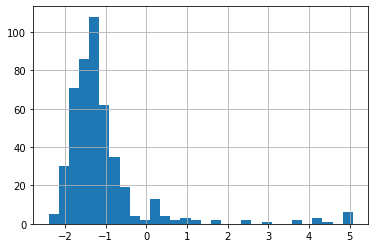

In [18]:
(gr_expand_nodub["ln(D0 (eV))"]).hist(bins=30)
gr_expand_nodub['D0 (kcal/mol)']=gr_expand_nodub['D0 (eV)']*23

In [19]:
len(gr_expand_nodub["ln(D0 (eV))"])

463

In [20]:

#gr_expand_nodub['1/omega_e (au)'].hist(bins=25)
gr_expand_nodub["(e1*e2)"]=(gr_expand_nodub["e1"]+gr_expand_nodub["e2"])
gr_expand_nodub['1/ln(omega_e (au))']=(1/gr_expand_nodub["ln(omega_e (au))"])
gr_expand_nodub['mu^(1/2)']*(gr_expand_nodub["ln(omega_e (au))"])
#gr_expand_nodub['1/omega_e (au)']=(1/gr_expand_nodub["omega_e (au)"])
gr_expand_nodub['1/D0 (eV)']=(1/gr_expand_nodub["D0 (eV)"])
(gr_expand_nodub["ln(K)"])=np.log(gr_expand_nodub["K"])

In [21]:
gr_expand_nodub["ln('omega_ex_e (cm^{-1})')"]=np.log(gr_expand_nodub['omega_ex_e (cm^{-1})'])
gr_expand_nodub['ln(mu)']=np.log(gw_expand['Reduced mass'])

In [22]:
gw_expand["ln(D0 (eV))"]

0     -1.499206
1     -1.769684
3     -1.479785
4     -1.510046
5     -1.244155
         ...   
636    3.772261
637    5.083206
638    4.283087
639    5.051457
640    5.035953
Name: ln(D0 (eV)), Length: 463, dtype: float64

In [23]:
from sklearn.linear_model import LinearRegression
>>> X = gw_expand[["ln(K)",'ln(Re (au))','g1_lan_act','g2_lan_act','p1','p2']]
>>> # y = 1 * x_0 + 2 * x_1 + 3
>>> y = gw_expand["ln(D0 (eV))"]
>>> reg = LinearRegression().fit(X, y)
>>> reg.score(X, y)
reg.coef_
reg.score(X, y)

0.900376742750011

## 4.2 Run the model

In [50]:
trval,train,test,mean_std,Train_MAE,Train_RMSE,Train_R,Train_RMSLE,MAE,RMSE,R,RMSLE,r_y_train_preds,r_train_stds,r_y_test_preds,r_test_stds=ml_model(data=gr_expand_nodub,strata=gr_expand_nodub['rcat'],test_size=22,features=['g1_lan_act','g2_lan_act','p1','p2','mu^(1/2)'],prior_features=["ln(K)",'ln(Re (au))','g1_lan_act','g2_lan_act','p1','p2'],logtarget="ln(D0 (eV))",target="ln(D0 (eV))",nu=3/2,normalize_y=True,n_splits=100)




size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 0
Molecule MnH
Test MAE 0.1004140867300293 0.1004140867300293
Test R%:  2.558678390017945 2.558678390017945
Train RMSE:  0.018893046029031666 0.018893046029031666
Test RMSE:  0.1916719182333333 0.1916719182333333
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 1
Molecule SiD
Test MAE 0.10781025591387425 0.11520642509771921
Test R%:  2.433793528120205 2.308908666222465
Train RMSE:  0.018437096531286324 0.017981147033540982
Test RMSE:  0.1823167287997457 0.17296153936615813
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 2
Molecule PbO
Test MAE 0.11306907987464719 0.12358672779619308
Test R%:  2.4422618581767086 2.4591985182897154
Train RMSE:  0.012291397716347213 8.646899039856307e-11
Test RMSE:  0.1829510957731392 0.1842198297199262
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 3
Molecule BaD
Test MAE 0.11468897401711808 0.11954865644453079
Test R%:  2.466071885236018 2.537501966413946
Train RMSE:  0.01314993786656075 0.015725558317201366
Test RMSE:  0.18473471718388376 0.1900855814161174
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 4
Molecule BeT
Test MAE 0.11055223813115231 0.09400529458728923
Test R%:  2.3971395975403453 2.1214104467576536
Train RMSE:  0.014062831209562374 0.017714404581568862
Test RMSE:  0.17957096395003208 0.15891595101462527
size of training set before removing mirror molecules 441
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 14
Molecule LuO
Test MAE 0.11421205769739916 0.14831630889381678
Test R%:  2.296401532451421 3.1351353629984855
Train RMSE:  0.01653302396138254 9.540068796770848e-11
Test RMSE:  0.1720246235228661 0.23485460747681652
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 15
Molecule CsI
Test MAE 0.11499770297162087 0.12678238208494685
Test R%:  2.304559050353193 2.4269218188797748
Train RMSE:  0.016539682229597584 0.016639556252823227
Test RMSE:  0.17263570739739884 0.18180196551539027
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 16
Molecule CuSe
Test MAE 0.11714141475936471 0.15144080336326604
Test R%:  2.3661126350831863 3.3509699907630726
Train RMSE:  0.01674714805538653 0.02006660126800964
Test RMSE:  0.1772467181853756 0.2510228907930037
size of training set before removing mirror molecules 441
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 19
Molecule BeD
Test MAE 0.11687198930324565 0.1472500716759188
Test R%:  2.3310819201077404 2.761888383079077
Train RMSE:  0.01601765254306368 8.817996246065655e-11
Test RMSE:  0.17462254925401502 0.20689448365076205
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 20
Molecule BaF
Test MAE 0.11623736750263414 0.10354493149040381
Test R%:  2.3038447472655443 1.7591012904216168
Train RMSE:  0.016125719230023913 0.018287052969228546
Test RMSE:  0.17258219858458992 0.13177518519608808
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 21
Molecule SrS
Test MAE 0.11695212488336434 0.13196202987869887
Test R%:  2.3123145132479404 2.490179598878266
Train RMSE:  0.016195418315353354 0.017659099107271616
Test RMSE:  0.17321667312393285 0.1865406384501345
size of training set before removing mirror molecules 441
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 41
Molecule LiNa
Test MAE 0.11146942677179947 0.13042243870844233
Test R%:  2.185300089347944 2.7142528428596076
Train RMSE:  0.016536975516532472 9.355571828415017e-11
Test RMSE:  0.16370195710210275 0.20332608075746886
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 42
Molecule OD
Test MAE 0.111862796459746 0.12838432335350064
Test R%:  2.206001655737029 3.0754674440786163
Train RMSE:  0.01657967922646862 0.01837323504378693
Test RMSE:  0.16525272212036785 0.23038485288750213
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 43
Molecule NaCs
Test MAE 0.11178156023610265 0.1082884026194384
Test R%:  2.203544278810893 2.097877070987031
Train RMSE:  0.016920350292612005 0.03156920613677742
Test RMSE:  0.1650686387470559 0.15715305369464228
size of training set before removing mirror molecules 441
size of training set after removing mirr

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 53
Molecule NS
Test MAE 0.11410088420024592 0.14799185407041096
Test R%:  2.2432459758198395 2.793054191958549
Train RMSE:  0.01695072120617055 8.740399171958998e-11
Test RMSE:  0.16804271335233292 0.2092291304725457
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 54
Molecule CaH
Test MAE 0.11373976084983148 0.09423909992745201
Test R%:  2.234367871211101 1.7549502223392097
Train RMSE:  0.016979805056530708 0.01855033297597924
Test RMSE:  0.1673776499558264 0.13146422654447476
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 55
Molecule CrF
Test MAE 0.11362457514651474 0.10728936146409507
Test R%:  2.227211437922231 1.833607607034362
Train RMSE:  0.01667659425328947 7.502131118550585e-11
Test RMSE:  0.16684155784611154 0.1373564918117917
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 56
Molecule NaK
Test MAE 0.11342393453273657 0.10218806016115876
Test R%:  2.2227820390408217 1.9747357016819038
Train RMSE:  0.016384022425811728 8.705828286857619e-11
Test RMSE:  0.1665097492907525 0.1479284701906453
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 57
Molecule YF
Test MAE 0.11351883429585746 0.11892812079374908
Test R%:  2.22086998069659 2.111882655075388
Train RMSE:  0.016447640576710713 0.02007387517795298
Test RMSE:  0.16636651601374405 0.15820221922426353
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 58
Molecule YF
Test MAE 0.11383219281366228 0.13200698684634143
Test R%:  2.2283055829638085 2.6595705144624744
Train RMSE:  0.016466774619226483 0.017576549085140905
Test RMSE:  0.1669235208156519 0.19922979932630783
size of training set before removing mirror molecules 441
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 78
Molecule CH
Test MAE 0.11239150571839016 0.1215767960515918
Test R%:  2.1831408053464694 2.350610385557031
Train RMSE:  0.01615642218936088 8.65010110764487e-11
Test RMSE:  0.16354020402356512 0.17608543667567045
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 79
Molecule LuD
Test MAE 0.11245259181323934 0.11727839330632683
Test R%:  2.184349001703231 2.279796513887407
Train RMSE:  0.016195465971424967 0.01927992475448765
Test RMSE:  0.1636307106359657 0.17078073301560995
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 423
Split: 80
Molecule BF
Test MAE 0.11266435076539379 0.129605066937749
Test R%:  2.184920175451672 2.230614075326929
Train RMSE:  0.016236515230688617 0.019520455971780662
Test RMSE:  0.16367349755613325 0.1670964511695379
size of training set before removing mirror molecules 441
size of training set after removing mirror mo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 84
Molecule LuO
Test MAE 0.11268703622419113 0.11140313571842919
Test R%:  2.1810135773235646 2.0357458063453424
Train RMSE:  0.016108205580078486 8.288172550559033e-11
Test RMSE:  0.16338085227492002 0.15249876860645195
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 85
Molecule ND
Test MAE 0.11294962142475917 0.13526936347304244
Test R%:  2.18448005561929 2.4791307107559475
Train RMSE:  0.016131950953828612 0.01815030772258956
Test RMSE:  0.16364052795242914 0.18571296054070588
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 86
Molecule Xe2
Test MAE 0.112542625914366 0.07754101202055377
Test R%:  2.1738945505590963 1.2635411153824165
Train RMSE:  0.016158818492723187 0.01846942683765649
Test RMSE:  0.16284756230724629 0.09465251682152001
size of training set before removing mirror molecules 441
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 92
Molecule HoF
Test MAE 0.11285195924607642 0.09232457172554233
Test R%:  2.1826835803716897 1.7020523882234317
Train RMSE:  0.016004785079108554 8.615519499041434e-11
Test RMSE:  0.16350595306481944 0.12750162250056102
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 93
Molecule NH
Test MAE 0.11312991855563415 0.13898013434450143
Test R%:  2.1903469743892137 2.9030426180189264
Train RMSE:  0.016098031182551584 0.024769918802753203
Test RMSE:  0.16408002186426177 0.2174684202123984
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 94
Molecule MgS
Test MAE 0.11318622990487695 0.11847949673370038
Test R%:  2.191777966039736 2.326291181188834
Train RMSE:  0.016111549889185478 0.017382308312771638
Test RMSE:  0.1641872181870593 0.17426367253002958
size of training set before removing mirror molecules 441
size of training set after removing

In [67]:

>>> from sklearn.linear_model import LinearRegression
>>> X = gr_expand_nodub[["ln(Re (au))",'Re (au)','g1_lan_act','g2_lan_act','p1','p2']]
>>> # y = 1 * x_0 + 2 * x_1 + 3
>>> y =  gr_expand_nodub['log(D_0/(Z_1*Z_2))']
>>> reg = LinearRegression().fit(X, y)
>>> reg.score(X, y)

0.7150509486431491

In [ ]:

(gr_nodub['D_0/(Z_1*Z_2)']).hist(bins=100)


## 4.3 Plot and report the results

In [ ]:
gr_expand_nodub

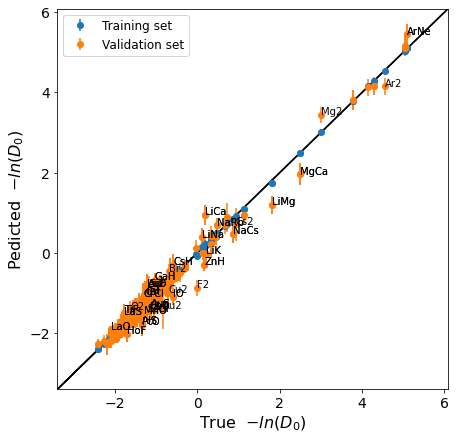

In [32]:
from matplotlib.transforms import Bbox
re_train_preds,re_train_std,re_test_preds,re_test_std,out,fig,ax=plot_results(gr_expand_nodub[gr_expand_nodub["ln(D0 (eV))"]<6],'True  $-ln(D_0)$','Pedicted  $-ln(D_0)$',"ln(D0 (eV))",r_y_train_preds,r_train_stds,r_y_test_preds,r_test_stds)
#pyplot.savefig('experiment1.svg',bbox_inches=Bbox([[-2,-2],fig.get_size_inches()])) 
for i in range(len(gr_expand_nodub)):
    if abs(gr_expand_nodub["ln(D0 (eV))"].tolist()[i]-re_test_preds[i])<0.2:
        continue
    ax.annotate(gr_expand_nodub['Molecule'].tolist()[i], (gr_expand_nodub["ln(D0 (eV))"].tolist()[i], re_test_preds[i]))
#pyplot.savefig('experiment1_ann.svg',bbox_inches=Bbox([[-2,-2],fig.get_size_inches()]))    

In [ ]:
from matplotlib.transforms import Bbox
re_train_preds,re_train_std,re_test_preds,re_test_std,out,fig,ax=plot_results(gr_expand_nodub,'True  $ln(\\frac{D_0}{Z_{1}Z_{2}})$','Pedicted  $ln(\\frac{D_0}{Z_{1}Z_{2}})$','log(D_0/(Z_1*Z_2))',r_y_train_preds,r_train_stds,r_y_test_preds,r_test_stds)
#for i in range(len(gr_expand_nodub)):
    #if abs(gr_expand_nodub['D_0/(Z_1*Z_2)'].tolist()[i]-test_preds[i])>0:
        #continue
    #ax.annotate(gr_expand_nodub['Molecule'].tolist()[i], (gr_expand_nodub['log(D_0/(Z_1*Z_2))'].tolist()[i], test_preds[i]))
pyplot.savefig('experiment2_loo.svg',bbox_inches=Bbox([[-2,-2],fig.get_size_inches()]))    

In [ ]:
gr_expand_df = pd.DataFrame(list(zip(gr_expand_nodub['Molecule'].tolist(), gr_expand_nodub['Re (\AA)'].tolist(),train_preds,train_std,test_preds,test_std,gr_expand_nodub[~gr_expand_nodub['Molecule'].isin(['AgBi'])]['type'].tolist())),
               columns =['Molecule', 'True R_e(\AA)','Train','Train std','Predicted $R_e(\AA)$','standard deviation','type'])
gr_expand_df
gr_expand_df.to_csv(r'C:\Users\mamr4\OneDrive - Stony Brook University\Master thesis\Computational\Results\ML results\R_e\experiment 1\results.csv')

In [36]:
results('$\ln{(D0 (eV))}"$ statistical summary',gr_expand_nodub,"ln(D0 (eV))",re_test_preds,208,MAE,RMSE,R,r"stat_summ.csv")

,"$\ln{(D0 (eV))}""$ statistical summary"
$r%$,2.226668393781774 (+/-) 0.0
MAE,0.11436628921336878 (+/-) 0.0003
Number of molecules in the whole data set,208
RMSE,0.1668008781293903 (+/-) 0.0


In [ ]:
results('$ln(\\frac{D_0}{ Z_{1}Z_{2}})$ statistical summary',gr_expand_nodub,"D0 (eV)",test_preds,208,MAE,RMSE,R,r"stat_summ_loo.csv")

## 4.4 Learning curves

In [ ]:
Train_rmse_means=[]
Train_rmse_stds=[]
Valid_rmse_means=[]
Valid_rmse_stds=[]

In [ ]:
gr_expand_nodub['z1z2^1/2']=np.sqrt(gr_expand_nodub['e1']*gr_expand_nodub['e2'])

In [29]:
Train_rmse_means=[]
Train_rmse_stds=[]
Valid_rmse_means=[]
Valid_rmse_stds=[]
for i in [0.5,0.4,0.3,0.2,0.1,22]:
    trval,train,test,mean_std,Train_MAE,Train_RMSE,Train_R,Train_RMSLE,MAE,RMSE,R,RMSLE,r_y_train_preds,r_train_stds,r_y_test_preds,r_test_stds=ml_model(data=gr_expand_nodub,strata=gr_expand_nodub['rcat'],test_size=i,features=['g1_lan_act','g2_lan_act','p1','p2','mu^(1/2)'],prior_features=["ln(K)",'ln(Re (au))','g1_lan_act','g2_lan_act','p1','p2'],logtarget="ln(D0 (eV))",target="ln(D0 (eV))",nu=3/2,normalize_y=True,n_splits=500)
    Train_rmse_means.append(np.array(Train_RMSE).mean())
    Train_rmse_stds.append(np.array(Train_RMSE).std())
    Valid_rmse_means.append(np.array(RMSE).mean())
    Valid_rmse_stds.append(np.array(RMSE).std())
    print(Train_rmse_means)
    print(Valid_rmse_means)

size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 121
Split: 0
Molecule SiO
Test MAE 0.1951671207694119 0.1951671207694119
Test R%:  3.6604713199199934 3.6604713199199934
Train RMSE:  6.600878666019358e-11 6.600878666019358e-11
Test RMSE:  0.27420779503368764 0.27420779503368764
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 108
Split: 1
Molecule BiCl
Test MAE 0.20820554395268637 0.22124396713596087
Test R%:  3.7543247347531663 3.8481781495863396
Train RMSE:  0.0003590875209424496 0.0007181749758761126
Test RMSE:  0.2812384027583642 0.2882690104830407
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 123
Split: 2
Molecule AlBr
Test MAE 0.21158203398201833 0.21833501404068228
Test R%:  3.745461940654098 3.727736352455962
Train RMSE:  0.054501669473138094 0.1627868333775294
Test RMSE:  0.2805744862800359 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 4
Molecule BaO
Test MAE 0.2224108708876143 0.22965685812949832
Test R%:  3.964139452122491 3.9813308612017573
Train RMSE:  0.0467378879575342 4.421451994344728e-11
Test RMSE:  0.2969557314811354 0.29824354880441134
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 125
Split: 5
Molecule CuH
Test MAE 0.2171478404426711 0.19083268821795515
Test R%:  3.916558657959065 3.678654687141938
Train RMSE:  0.03901873547134078 0.000422973040373694
Test RMSE:  0.2933914296431443 0.2755699204531886
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 116


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 6
Molecule CaH
Test MAE 0.20941452540913058 0.16301463520788734
Test R%:  3.795684497329174 3.0704395335498265
Train RMSE:  0.033444630413031556 6.317622808222647e-11
Test RMSE:  0.2843366839106754 0.23000820951586212
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 109
Split: 7
Molecule NaCs
Test MAE 0.2107467475159831 0.220072302263951
Test R%:  3.798261297351926 3.816298897511187
Train RMSE:  0.029602432744026647 0.00270704906099228
Test RMSE:  0.2845297133297659 0.28588091926339915
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 107
Split: 8
Molecule SrH
Test MAE 0.2072952444613397 0.17968322002419237
Test R%:  3.7551487884656 3.410248717374997
Train RMSE:  0.026313273556251623 5.405142510330288e-11
Test RMSE:  0.2813001330470967 0.25546349078574343
size of training set before removing mirror molecules 231
size of training set after removing mirror mol

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 22
Molecule SeO
Test MAE 0.20419654385869448 0.15370809453362164
Test R%:  3.7317156955571447 3.0743249255042233
Train RMSE:  0.02740744794291529 7.761241657804667e-11
Test RMSE:  0.279544747968055 0.23029926623166236
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 117
Split: 23
Molecule NaK
Test MAE 0.2053472157603012 0.23181266949725582
Test R%:  3.7518514476565064 4.214973745941849
Train RMSE:  0.028197470369168736 0.04636798617299816
Test RMSE:  0.28105312754597017 0.3157458578380172
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 115


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 24
Molecule CP
Test MAE 0.20878524442945343 0.29129793248910696
Test R%:  3.8039088838320474 5.053287352045031
Train RMSE:  0.02706957155590878 3.7669881594468805e-11
Test RMSE:  0.2849527769466146 0.3785443625620802
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 111
Split: 25
Molecule BF
Test MAE 0.20936181520231856 0.2237760845239466
Test R%:  3.8066871248129024 3.876143149334264
Train RMSE:  0.02606569201057472 0.0009687033772232022
Test RMSE:  0.2851608964118011 0.29036388304146404
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 124
Split: 26
Molecule AgF
Test MAE 0.2132589991507522 0.31458578181002644
Test R%:  3.8627085078573193 5.319264467012167
Train RMSE:  0.02510029601141173 3.317405116832961e-11
Test RMSE:  0.28935748711741627 0.3984688454634116
size of training set before removing mirror molecules 231
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 32
Molecule CaH
Test MAE 0.21090865903884798 0.18231547775765647
Test R%:  3.830259407267183 3.4701979358215347
Train RMSE:  0.025892740161823455 6.119103510000345e-11
Test RMSE:  0.2869267082515291 0.25995431766772464
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 117


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 33
Molecule ICl
Test MAE 0.21105280996210599 0.2158097904296193
Test R%:  3.8388153093640462 4.1211600785605285
Train RMSE:  0.02513118898223256 5.573312195518848e-11
Test RMSE:  0.28756763529164486 0.3087182276154648
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 108
Split: 34
Molecule CsF
Test MAE 0.21239488624148137 0.25802547974024514
Test R%:  3.855436694970359 4.420563805585009
Train RMSE:  0.027750535825682217 0.11680832850297057
Test RMSE:  0.2888127518624835 0.3311467152709958
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 125
Split: 35
Molecule CuH
Test MAE 0.21240120258755207 0.212622274700027
Test R%:  3.8489274630720374 3.621104346630784
Train RMSE:  0.03116025712178137 0.15050050248525165
Test RMSE:  0.2883251419428296 0.2712587947549421
size of training set before removing mirror molecules 231
size of training set after removing mirror mo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 36
Molecule IBr
Test MAE 0.21126086442148057 0.17020869044290646
Test R%:  3.8349665489332465 3.3323736399367787
Train RMSE:  0.030318088011722776 4.961343517446303e-11
Test RMSE:  0.2872793226621758 0.24962982855864035
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 130
Split: 37
Molecule LiCa
Test MAE 0.21100578031497916 0.20156766837442738
Test R%:  3.8314548587405337 3.7015223216101605
Train RMSE:  0.031677489966969063 0.0819753623110818
Test RMSE:  0.28701626013813825 0.277282946748749
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 125


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 38
Molecule HfO
Test MAE 0.21113938417124145 0.2162163307092087
Test R%:  3.8329667597832247 3.8904189994054823
Train RMSE:  0.030865246635690496 4.710494632331296e-11
Test RMSE:  0.2871295174252448 0.2914332943352932
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 122
Split: 39
Molecule TlCl
Test MAE 0.21060911987228548 0.18992881221300187
Test R%:  3.8224424803307984 3.411995581686158
Train RMSE:  0.030103978249978697 0.0004145112072183581
Test RMSE:  0.2863411382219264 0.25559434929250996
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 109
Split: 40
Molecule LiK
Test MAE 0.2107172564257659 0.21504271856498142
Test R%:  3.8272309210194115 4.018768548563942
Train RMSE:  0.029636351286068577 0.010931272729663875
Test RMSE:  0.2866998427842949 0.3010480252790337
size of training set before removing mirror molecules 231
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 46
Molecule ScCl
Test MAE 0.2105500572249853 0.22466837478586144
Test R%:  3.814192666229181 3.9811691762286636
Train RMSE:  0.02701499008862868 4.44789956771543e-11
Test RMSE:  0.28572314039144703 0.2982314368996627
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 128


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 47
Molecule ZnD
Test MAE 0.20950042532503854 0.16016772602754287
Test R%:  3.7986957274967317 3.0703396070716384
Train RMSE:  0.026452177796636094 7.29844692191914e-11
Test RMSE:  0.28456225671603824 0.23000072397182844
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 121
Split: 48
Molecule ND
Test MAE 0.20919952797093969 0.1947564549741955
Test R%:  3.7886082625226116 3.3044099437648464
Train RMSE:  0.025912337434526287 5.325558686367855e-11
Test RMSE:  0.28380659951064496 0.24753505365176712
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 110
Split: 49
Molecule LiCl
Test MAE 0.20933714760708594 0.21608050977825075
Test R%:  3.7909205897401073 3.904224623397389
Train RMSE:  0.027282329942178035 0.09441196281711361
Test RMSE:  0.2839798171354506 0.29246748075092877
size of training set before removing mirror molecules 231
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 55
Molecule LiCa
Test MAE 0.2105416211656745 0.18163224990187227
Test R%:  3.818838932947892 3.4149797872865317
Train RMSE:  0.02555498009935806 5.911241092113663e-11
Test RMSE:  0.2860711946283817 0.255817897673603
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 115
Split: 56
Molecule InCl
Test MAE 0.21040929941821596 0.2029992815605382
Test R%:  3.815861308137862 3.6491143187761708
Train RMSE:  0.025142010491570062 0.0020157124554419778
Test RMSE:  0.28584813921768837 0.2733570362188608
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 121
Split: 57
Molecule LiF
Test MAE 0.2099359818394303 0.1829568798486479
Test R%:  3.808334234592356 3.3792910424985325
Train RMSE:  0.025106984592934714 0.023110508370719894
Test RMSE:  0.2852842822551334 0.25314443538950265
size of training set before removing mirror molecules 231
size of training set after removing mirr

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 59
Molecule LiI
Test MAE 0.2097906790334483 0.22327993446865071
Test R%:  3.811013493603439 4.148966727142686
Train RMSE:  0.02430961922927378 4.902176668912601e-11
Test RMSE:  0.285484986929899 0.3108012380063663
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 108
Split: 60
Molecule BeF
Test MAE 0.2099267537653631 0.21809123768025246
Test R%:  3.814215535800622 4.006338067631618
Train RMSE:  0.024432926928093825 0.03183138885729633
Test RMSE:  0.2857248535628422 0.30011685153943574
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 111
Split: 61
Molecule NS
Test MAE 0.2101420917429405 0.22327770837516037
Test R%:  3.818575581344683 4.0845383595323765
Train RMSE:  0.02403884746253398 6.338347127278833e-11
Test RMSE:  0.2860514668239207 0.3059748757497077
size of training set before removing mirror molecules 231
size of training set after removing mirror mole

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 65
Molecule DF
Test MAE 0.21036724099626364 0.22376216591847528
Test R%:  3.822837908052732 3.9779597459594123
Train RMSE:  0.022600102639490093 4.481880850452732e-11
Test RMSE:  0.2863707599165799 0.2979910168224293
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 112
Split: 66
Molecule ICl
Test MAE 0.21011240508476714 0.19329323492599673
Test R%:  3.8173965349437515 3.458265909751057
Train RMSE:  0.02257403492442959 0.020853565730436573
Test RMSE:  0.2859631438497501 0.2590604834389834
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 118
Split: 67
Molecule TiS
Test MAE 0.2097136050859214 0.1829940051632572
Test R%:  3.8130674867098775 3.523021255040287
Train RMSE:  0.0222535487501863 0.0007809750758858649
Test RMSE:  0.28563885261316935 0.26391133976225956
size of training set before removing mirror molecules 231
size of training set after removing mirror

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 83
Molecule ScCl
Test MAE 0.21163240902737193 0.30710244684328947
Test R%:  3.8289525068577484 5.257105142114752
Train RMSE:  0.027235020808469217 3.5000981263206673e-11
Test RMSE:  0.28682880766762076 0.39381245836698836
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 122
Split: 84
Molecule GeS
Test MAE 0.21119983963348862 0.17486401054729375
Test R%:  3.8235218217209916 3.3673442702334673
Train RMSE:  0.026938603016734935 0.002039508511055584
Test RMSE:  0.2864219922423042 0.2522494965157172
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 132


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 85
Molecule PbS
Test MAE 0.21049536202203772 0.15061476504871293
Test R%:  3.813404003498145 2.9533894545562225
Train RMSE:  0.026625363447499044 6.244836173189324e-11
Test RMSE:  0.2856640612593894 0.22123992771163356
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 126
Split: 86
Molecule GeH
Test MAE 0.21076659826828534 0.23409291544557959
Test R%:  3.8157926235469137 4.021213947740995
Train RMSE:  0.027873293939923712 0.13519531628844497
Test RMSE:  0.28584299401954566 0.3012312113929824
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 120
Split: 87
Molecule SD
Test MAE 0.2105980678072907 0.1959359177007601
Test R%:  3.8145638571309957 3.7076611789460787
Train RMSE:  0.02755655196383776 4.435958449657961e-11
Test RMSE:  0.2857509464934015 0.2777428117188549
size of training set before removing mirror molecules 231
size of training set after removing mirr

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 94
Molecule LiK
Test MAE 0.21074664565590054 0.17738368367949403
Test R%:  3.819257250265612 3.3424613499633318
Train RMSE:  0.025884984357887816 5.137135189893329e-11
Test RMSE:  0.2861025309944645 0.2503855041210378
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 128


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 95
Molecule AuD
Test MAE 0.21060291782604432 0.19694877398970076
Test R%:  3.816175152753555 3.5233758891081566
Train RMSE:  0.025615349104662802 4.8286907354402335e-11
Test RMSE:  0.2858716494797643 0.26393790558324143
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 120
Split: 96
Molecule CrCl
Test MAE 0.21094861976878873 0.24413600627225185
Test R%:  3.820425430565305 4.22845210049329
Train RMSE:  0.026502725293732186 0.111690839444393
Test RMSE:  0.28619003998338555 0.3167555283310272
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 109


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 97
Molecule TF
Test MAE 0.21188263781221078 0.30248238802414923
Test R%:  3.8328056206366323 5.033684057555384
Train RMSE:  0.026232289321713287 3.587996946314428e-11
Test RMSE:  0.28711744640864084 0.37707586965840684
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 108


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 98
Molecule SiO
Test MAE 0.21198823898482946 0.22233715390146153
Test R%:  3.8330046100630093 3.8525055738479694
Train RMSE:  0.025967316702772084 4.6534398606429086e-11
Test RMSE:  0.28713235280923055 0.2885931800670228
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 113


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 99
Molecule PbTe
Test MAE 0.21213347940919136 0.22651228142102
Test R%:  3.836137150422697 4.1462586460317485
Train RMSE:  0.02570764353632411 5.7974369507465706e-11
Test RMSE:  0.28736701302367057 0.3105983742532311
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 108
Split: 100
Molecule NSe
Test MAE 0.21193028481582332 0.1916108254790207
Test R%:  3.833828256243423 3.602938838316039
Train RMSE:  0.025453112412699173 5.0205786304323706e-11
Test RMSE:  0.28719405256952923 0.2698980071553929
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 131
Split: 101
Molecule PbSe
Test MAE 0.21155052537025507 0.17319482136786155
Test R%:  3.8297285655050297 3.415659800927317
Train RMSE:  0.02523707273718655 0.003417065510411519
Test RMSE:  0.28688694262126185 0.25586883784625725
size of training set before removing mirror molecules 231
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 106
Molecule LiMg
Test MAE 0.21048631020340663 0.20229088044126586
Test R%:  3.8121734410475754 3.6298460265634764
Train RMSE:  0.025344872728148313 4.5922744379759345e-11
Test RMSE:  0.2855718791913629 0.2719136385085837
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 137
Split: 107
Molecule CuO
Test MAE 0.21063227597941464 0.22625061401227195
Test R%:  3.812948695400198 3.895900911130801
Train RMSE:  0.025179086209764612 0.00743992874270864
Test RMSE:  0.28562995389487605 0.29184394717078704
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 125
Split: 108
Molecule OH
Test MAE 0.21057334128476266 0.20420839426234802
Test R%:  3.8099021661287225 3.48087700480938
Train RMSE:  0.024964987917544475 0.001842372357769713
Test RMSE:  0.2854017368154277 0.2607542922349981
size of training set before removing mirror molecules 231
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 114
Molecule SrS
Test MAE 0.21119179656155904 0.19786599093073484
Test R%:  3.8127294618936127 3.4550061156888816
Train RMSE:  0.025108421967729215 4.678575997169231e-11
Test RMSE:  0.285613530999794 0.2588162905840391
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 106
Split: 115
Molecule MnD
Test MAE 0.2114565077514327 0.24189829458690773
Test R%:  3.8164256744129847 4.241490114140763
Train RMSE:  0.025541432827563083 0.07533768170845778
Test RMSE:  0.2858904161865177 0.3177322126597466
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 114
Split: 116
Molecule KH
Test MAE 0.21230341057152846 0.31054413770263356
Test R%:  3.8285030910527524 5.229483421265784
Train RMSE:  0.025323129983185675 3.540627670945159e-11
Test RMSE:  0.28679514169781234 0.39174330100798543
size of training set before removing mirror molecules 231
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 124
Molecule HF
Test MAE 0.21165530933759846 0.1849316574642158
Test R%:  3.818946774215184 3.6196697520865264
Train RMSE:  0.02671138339226169 5.4444106459868955e-11
Test RMSE:  0.2860792730733505 0.27115132853751606
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 113
Split: 125
Molecule CuTe
Test MAE 0.21139305320454463 0.17861103657281732
Test R%:  3.8141649152870323 3.216432549268142
Train RMSE:  0.026545047648918876 0.005753079731066905
Test RMSE:  0.2857210615540538 0.24094462164196856
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 121
Split: 126
Molecule RbI
Test MAE 0.21109957050149833 0.17412074991766302
Test R%:  3.8100353590971348 3.289711279170059
Train RMSE:  0.026348716842117703 0.0016110351851699063
Test RMSE:  0.28541171436940654 0.24643396910384488
size of training set before removing mirror molecules 231
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 132
Molecule YO
Test MAE 0.21214984792407848 0.3097559242646451
Test R%:  3.8228703114061373 5.0745429260234385
Train RMSE:  0.025700020905757834 3.833067393920408e-11
Test RMSE:  0.2863731872685006 0.38013662857467706
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 121
Split: 133
Molecule MgD
Test MAE 0.21212650148482215 0.20902142506373583
Test R%:  3.8223296426573947 3.7504206990746836
Train RMSE:  0.02580735352920875 0.040082592448180805
Test RMSE:  0.28633268549359814 0.28094594943157425
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 127
Split: 134
Molecule HF
Test MAE 0.21176982797521685 0.1639755776881025
Test R%:  3.816724379569454 3.0656191257853638
Train RMSE:  0.025766271982166397 0.02026134467849076
Test RMSE:  0.2859127923438926 0.22964711028334978
size of training set before removing mirror molecules 231
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 136
Molecule AsF
Test MAE 0.21171080213469157 0.19727972865056964
Test R%:  3.8150126567033276 3.738215446659204
Train RMSE:  0.026109622766417942 4.9124650131909184e-11
Test RMSE:  0.2857845663009032 0.28003164767636984
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 100
Split: 137
Molecule PtC
Test MAE 0.21176101283352047 0.21863987857307843
Test R%:  3.8143325236979506 3.721154301961368
Train RMSE:  0.025920422601800185 4.916757345402517e-11
Test RMSE:  0.28573361718658585 0.278753588525111
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 119
Split: 138
Molecule NeXe
Test MAE 0.21188455827914857 0.22893382977582902
Test R%:  3.81730417810528 4.227392486316725
Train RMSE:  0.02574685078625202 0.0017939402406049946
Test RMSE:  0.2859562253513327 0.31667615208639954
size of training set before removing mirror molecules 231
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 142
Molecule BiCl
Test MAE 0.2120211216106149 0.18223763478327154
Test R%:  3.8187201194682165 3.306171502911496
Train RMSE:  0.026396436846790224 5.604215969529389e-11
Test RMSE:  0.2860622942493228 0.24766701295624124
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 125
Split: 143
Molecule LiCa
Test MAE 0.21180018680081444 0.180206508999342
Test R%:  3.814441108234552 3.2025425018203313
Train RMSE:  0.026214700103983017 0.00022634588255313854
Test RMSE:  0.28574175131024204 0.23990411102169665
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 120
Split: 144
Molecule BCl
Test MAE 0.21192744466229355 0.23025257671528593
Test R%:  3.816918379626588 4.173645460079854
Train RMSE:  0.02628015990513764 0.03570637127140369
Test RMSE:  0.28592732498825824 0.3126499346225916
size of training set before removing mirror molecules 231
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 148
Molecule MnO
Test MAE 0.21256114086604236 0.24000320239850867
Test R%:  3.8272980703858486 4.367220311958728
Train RMSE:  0.026025778945289763 4.512146857108881e-11
Test RMSE:  0.28670487297797737 0.3271507266432319
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 122
Split: 149
Molecule AgF
Test MAE 0.21246309509307362 0.19785427492072727
Test R%:  3.82692139774875 3.7707971748210753
Train RMSE:  0.026283709426697596 0.06471535115646485
Test RMSE:  0.28667665623640476 0.282472361742079
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 105
Split: 150
Molecule LiH
Test MAE 0.21255142334898786 0.22580066173612187
Test R%:  3.8289732033399697 4.13674404202283
Train RMSE:  0.02611780744703917 0.0012325104982750781
Test RMSE:  0.2868303580517814 0.30988563035828337
size of training set before removing mirror molecules 231
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 160
Molecule MgH
Test MAE 0.21158883735950995 0.18612601260119313
Test R%:  3.815424060181403 3.5040821948914016
Train RMSE:  0.025410823664425233 6.151138404941976e-11
Test RMSE:  0.28581538474769136 0.26249260499573507
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 111
Split: 161
Molecule XeKr
Test MAE 0.21153378053973632 0.20266963255618153
Test R%:  3.813497163759684 3.5032668398628473
Train RMSE:  0.025337500607689828 0.013532488473290078
Test RMSE:  0.28567103994264326 0.26243152632989963
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 129
Split: 162
Molecule GaCl
Test MAE 0.21140349164172903 0.1902966901645566
Test R%:  3.8110033916410764 3.407012308426676
Train RMSE:  0.025184977261947485 0.0004761952516872326
Test RMSE:  0.28548423018668684 0.2552210497217425
size of training set before removing mirror molecules 231
size of training set after re

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 166
Molecule NbO
Test MAE 0.2117424535372662 0.23938608179341378
Test R%:  3.8176925496146428 4.231524572341248
Train RMSE:  0.025621385720126944 3.81152199535168e-11
Test RMSE:  0.2859853184614622 0.31698568878226385
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 105
Split: 167
Molecule CsCl
Test MAE 0.21187792334176508 0.234501380693077
Test R%:  3.820685408516739 4.320492845166962
Train RMSE:  0.025477497851787365 0.0014482238390779566
Test RMSE:  0.2862095150658516 0.32365034799888837
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 128
Split: 168
Molecule NaCs
Test MAE 0.21163169447245977 0.17026524442916544
Test R%:  3.817170210237895 3.2266168993920825
Train RMSE:  0.02532674342703922 6.935057051068736e-11
Test RMSE:  0.2859461897492721 0.24170753656391852
size of training set before removing mirror molecules 231
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 188
Molecule ZnH
Test MAE 0.21050499348059135 0.20375484259347368
Test R%:  3.799394345140587 3.7765446844723214
Train RMSE:  0.026526538787305504 4.265895207773534e-11
Test RMSE:  0.28461459052416044 0.2829029106552276
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 126
Split: 189
Molecule MgBr
Test MAE 0.2104298370607693 0.19622527371440168
Test R%:  3.79802494534073 3.5392083831676557
Train RMSE:  0.02683508719428447 0.08515073611330999
Test RMSE:  0.2845120080786718 0.26512392588131445
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 116
Split: 190
Molecule LiK
Test MAE 0.21041365692672703 0.20733943145869815
Test R%:  3.7980985976768453 3.8120925415388256
Train RMSE:  0.026694589355950402 7.247665800215676e-11
Test RMSE:  0.2845175254131679 0.285565818967426
size of training set before removing mirror molecules 231
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 196
Molecule BrF
Test MAE 0.21034750472003602 0.17330627736047227
Test R%:  3.796185804650662 3.40833911636992
Train RMSE:  0.026727067872253527 4.859529364556621e-11
Test RMSE:  0.28437423710075543 0.25532044158927886
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 129
Split: 197
Molecule InBr
Test MAE 0.21017027100088176 0.17525522832748977
Test R%:  3.7930995528600873 3.1851079501167754
Train RMSE:  0.02659502286887993 0.0005821572042810628
Test RMSE:  0.2841430443869082 0.2385980797589965
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 120
Split: 198
Molecule NaF
Test MAE 0.21014022174793168 0.2041904696638178
Test R%:  3.793214327319235 3.8159396702305517
Train RMSE:  0.026611924551570052 0.029958457724213208
Test RMSE:  0.2841516422008558 0.2858540093624793
size of training set before removing mirror molecules 231
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 201
Molecule SrO
Test MAE 0.2107554631127131 0.3108996916124699
Test R%:  3.8010604885738974 5.233489948787426
Train RMSE:  0.026589082275195946 3.526218008336585e-11
Test RMSE:  0.28473940218832283 0.3920434320516225
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 125


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 202
Molecule AgD
Test MAE 0.21065176658675897 0.18970506834401676
Test R%:  3.7992140958873635 3.42624277320747
Train RMSE:  0.02645810157461128 5.650891042317814e-11
Test RMSE:  0.2846010879596098 0.2566616137595806
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 115
Split: 203
Molecule CH
Test MAE 0.2108128562745218 0.24351406289037866
Test R%:  3.8012454650252216 4.213613400010392
Train RMSE:  0.026328404998557386 5.961721642798982e-11
Test RMSE:  0.2847532588697219 0.3156439536224813
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 115
Split: 204
Molecule BeF
Test MAE 0.21089083952263035 0.22679942213677928
Test R%:  3.804883074933693 4.546955496261895
Train RMSE:  0.026204293986374888 0.0008856475011454195
Test RMSE:  0.28502575410462966 0.340614782025811
size of training set before removing mirror molecules 231
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 208
Molecule BaD
Test MAE 0.21125700692119684 0.210484256547173
Test R%:  3.8121406689103736 4.0425058172935415
Train RMSE:  0.025710555691700582 7.004011482327149e-11
Test RMSE:  0.28556942421365783 0.3028261963257632
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 124
Split: 209
Molecule SiD
Test MAE 0.21117352824552169 0.19372648502941608
Test R%:  3.811112529295265 3.5962313497375997
Train RMSE:  0.02584907768166152 0.05480017358349788
Test RMSE:  0.28549240574466683 0.26939554572554963
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 105
Split: 210
Molecule HfO
Test MAE 0.21141915202770056 0.26300014628526724
Test R%:  3.8145347304000476 4.533196962404421
Train RMSE:  0.026730933531878553 0.21192066207745555
Test RMSE:  0.28574876459495957 0.3395841231564398
size of training set before removing mirror molecules 231
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 213
Molecule KH
Test MAE 0.2115633514455619 0.23298233534758134
Test R%:  3.8158755637347563 4.029696526295619
Train RMSE:  0.02697489891291608 4.2116146715107634e-11
Test RMSE:  0.28584920711180634 0.30186664572872096
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 122
Split: 214
Molecule GeO
Test MAE 0.2115964671007168 0.2186832173038611
Test R%:  3.81636336481207 3.920752795357314
Train RMSE:  0.026857293172587077 0.001689664742180321
Test RMSE:  0.28588574854216736 0.293705614639427
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 109


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 215
Molecule LiF
Test MAE 0.21159343513437673 0.2109415623712628
Test R%:  3.817206855459255 3.9985573446038503
Train RMSE:  0.026732953852611673 5.789890862657198e-11
Test RMSE:  0.28594893486170964 0.2995339935633053
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 122
Split: 216
Molecule PtH
Test MAE 0.21151307328248234 0.19415491327329565
Test R%:  3.8158446103849917 3.5215996743441367
Train RMSE:  0.026828181555895825 0.04739736546527389
Test RMSE:  0.28584688838040645 0.26380484841890917
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 118
Split: 217
Molecule MnO
Test MAE 0.21154838648679533 0.2192113518227118
Test R%:  3.815508890019326 3.742657570669995
Train RMSE:  0.026705116503158797 5.922320086041987e-11
Test RMSE:  0.2858217393946143 0.2803644094777359
size of training set before removing mirror molecules 231
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 225
Molecule BeH
Test MAE 0.21101291195489186 0.19593379105550376
Test R%:  3.8075860782377386 3.527151273823583
Train RMSE:  0.026388867929091685 4.862088637683088e-11
Test RMSE:  0.28522823747663095 0.264220721600017
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 120
Split: 226
Molecule GeH
Test MAE 0.21113455734891812 0.23862641639885665
Test R%:  3.8104253453920967 4.452099722277032
Train RMSE:  0.02627681754078167 0.0009534297827179009
Test RMSE:  0.28544092844395835 0.3335090870599585
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 117


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 227
Molecule ClF
Test MAE 0.2115053868626278 0.29568368647472193
Test R%:  3.815424726346926 4.950284203093144
Train RMSE:  0.026161568341198368 3.5788660568986965e-11
Test RMSE:  0.2858154346504944 0.3708283435341696
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 123
Split: 228
Molecule LiH
Test MAE 0.21155053152273154 0.22184351402638633
Test R%:  3.8168408880656584 4.139725759936766
Train RMSE:  0.0260675130283414 0.004622901696952681
Test RMSE:  0.2859215200554508 0.31010899238550194
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 107
Split: 229
Molecule RbCl
Test MAE 0.211549439072543 0.21129926797936788
Test R%:  3.816011131821501 3.625996951909422
Train RMSE:  0.026267561564016724 0.0720786762336663
Test RMSE:  0.28585936258712485 0.27162530234048843
size of training set before removing mirror molecules 231
size of training set after removing mirr

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 233
Molecule RbF
Test MAE 0.21171751495094562 0.2513037974223885
Test R%:  3.820416199801454 4.237056149740917
Train RMSE:  0.025869883499901793 4.3432079944730374e-11
Test RMSE:  0.28618934850210326 0.31740006209904614
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 118


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 234
Molecule DF
Test MAE 0.21170222894283083 0.20812530304396867
Test R%:  3.819790087995411 3.6732799253814856
Train RMSE:  0.0257597988894476 4.316688666013744e-11
Test RMSE:  0.2861424461436979 0.2751672942768422
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 120


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 235
Molecule BeF
Test MAE 0.21167204700716438 0.20457929212554835
Test R%:  3.8200080198051105 3.8712219950843543
Train RMSE:  0.025650647199519302 6.636875764220281e-11
Test RMSE:  0.28615877152799474 0.28999523683775114
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 121
Split: 236
Molecule NO
Test MAE 0.21166135263549862 0.2091374809223803
Test R%:  3.8194239644755754 3.681586906705345
Train RMSE:  0.025765358645519414 0.05283725990154677
Test RMSE:  0.28611501964194175 0.27578957453343256
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 126
Split: 237
Molecule DF
Test MAE 0.21185852933555446 0.25858940724879026
Test R%:  3.824199798471294 4.956072455456614
Train RMSE:  0.025677363255562045 0.004822455835665668
Test RMSE:  0.2864727798304416 0.37126194450491024
size of training set before removing mirror molecules 231
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 240
Molecule ZnD
Test MAE 0.21220160976937916 0.3103629134561694
Test R%:  3.8279406442227217 5.278737175193299
Train RMSE:  0.025719200474216393 3.4530595728816485e-11
Test RMSE:  0.28675300851560515 0.3954329251249942
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 119
Split: 241
Molecule MnD
Test MAE 0.21228250574138843 0.23177843499562623
Test R%:  3.8286877931109995 4.0087506751858415
Train RMSE:  0.02602358843235048 0.09938108634266446
Test RMSE:  0.28680897782428444 0.30029758121600086
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 114
Split: 242
Molecule SO
Test MAE 0.21243336482380923 0.24894126276964096
Test R%:  3.8300549072511605 4.1608965291701905
Train RMSE:  0.026765542990370178 0.20631854603113794
Test RMSE:  0.2869113890498261 0.311694905630901
size of training set before removing mirror molecules 231
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 245
Molecule TeSe
Test MAE 0.21243678340245886 0.19478026379020497
Test R%:  3.83049377657697 3.6264066924429104
Train RMSE:  0.026441337232611987 5.68419196666766e-11
Test RMSE:  0.28694426497743764 0.27165599621523956
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 115
Split: 246
Molecule CsCl
Test MAE 0.2124494109384597 0.21555578479467205
Test R%:  3.831061655578848 3.9707598900409566
Train RMSE:  0.026335452115355328 0.0002877132702160772
Test RMSE:  0.2869868050864405 0.29745167190113014
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 122


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 247
Molecule AlF
Test MAE 0.21239469860080123 0.19888075119915632
Test R%:  3.830226409207383 3.6239205554555647
Train RMSE:  0.026229260776369608 4.689805861677992e-11
Test RMSE:  0.2869242363498456 0.2714697584109049
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 109
Split: 248
Molecule BO
Test MAE 0.21245268072568785 0.22683224769756755
Test R%:  3.8308091411710126 3.975326668151185
Train RMSE:  0.026123922379877054 4.972264824140589e-11
Test RMSE:  0.28696788910187593 0.2977937716053948
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 128
Split: 249
Molecule NO
Test MAE 0.21232779011507918 0.18123002807352429
Test R%:  3.828438675773615 3.2381927918215876
Train RMSE:  0.026019426690569142 5.2899041512995394e-11
Test RMSE:  0.2867903163160199 0.2425746926378831
size of training set before removing mirror molecules 231
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 250
Molecule InF
Test MAE 0.21217847819825705 0.1748504989927255
Test R%:  3.826946090640731 3.453799807419639
Train RMSE:  0.025915763636327006 7.579310205183372e-11
Test RMSE:  0.28667850599368216 0.25872592540924866
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 118
Split: 251
Molecule CS
Test MAE 0.21218201004332649 0.21306850315575282
Test R%:  3.8265516430221886 3.727545290768147
Train RMSE:  0.026149249591766607 0.08475422440710738
Test RMSE:  0.2866489577190794 0.2792323407937752
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 122
Split: 252
Molecule HoF
Test MAE 0.21223178478027974 0.22477501849249698
Test R%:  3.8275220204879234 4.072057141853097
Train RMSE:  0.0260844622853016 0.009758061056119642
Test RMSE:  0.28672164919566095 0.30503990129422
size of training set before removing mirror molecules 231
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 253
Molecule BH
Test MAE 0.21258525928750757 0.30201430961615167
Test R%:  3.8320696113323347 4.982610094968424
Train RMSE:  0.025981767552048257 3.8951038594368396e-11
Test RMSE:  0.2870623115719444 0.3732498927716628
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 126
Split: 254
Molecule LiNa
Test MAE 0.2124057648370249 0.16681417441442722
Test R%:  3.8292520056545234 3.1135801634903597
Train RMSE:  0.025879878267733913 5.1891446596598804e-11
Test RMSE:  0.2868512432770004 0.23323989636120984
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 111
Split: 255
Molecule CS
Test MAE 0.2124177861079133 0.2154832101844504
Test R%:  3.8292145325000986 3.8196588781218868
Train RMSE:  0.025788137159424823 0.002394154540606549
Test RMSE:  0.28684843614366984 0.2861326171443802
size of training set before removing mirror molecules 231
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 260
Molecule AuD
Test MAE 0.21245999820801081 0.18647745772532434
Test R%:  3.8293493047487965 3.3604395111790115
Train RMSE:  0.026913195181574714 4.986854171366712e-11
Test RMSE:  0.28685853200234956 0.25173225745274247
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 122
Split: 261
Molecule CuD
Test MAE 0.21240234647252645 0.19735524351110825
Test R%:  3.8283216710437866 3.5601092740362508
Train RMSE:  0.026816867784763686 0.0016754172170833
Test RMSE:  0.28678155143134515 0.26668962239917227
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 116
Split: 262
Molecule RbI
Test MAE 0.21240041107589633 0.21189333715880115
Test R%:  3.8278254138437218 3.697806027426606
Train RMSE:  0.0267149025082171 5.301274523326069e-11
Test RMSE:  0.28674437654846624 0.2770045572342011
size of training set before removing mirror molecules 231
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 267
Molecule PtC
Test MAE 0.21216078432941415 0.2093496843657583
Test R%:  3.824261527397085 3.8208721553239418
Train RMSE:  0.02628267530520587 6.651509973574238e-11
Test RMSE:  0.28647740397611887 0.28622350436552296
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 113
Split: 268
Molecule IrC
Test MAE 0.21219288155583352 0.22079493823622687
Test R%:  3.8246194607915682 3.920545610512926
Train RMSE:  0.026184970192717597 4.585971944452154e-11
Test RMSE:  0.2865042169513595 0.29369009431584603
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 105
Split: 269
Molecule AlBr
Test MAE 0.2123843186856485 0.26388090660587243
Test R%:  3.8266050351035643 4.360724525030407
Train RMSE:  0.027018295930434713 0.25118291937633863
Test RMSE:  0.28665295734744045 0.32666412389321714
size of training set before removing mirror molecules 231
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 275
Molecule BeH
Test MAE 0.21306112039237268 0.3104843140870722
Test R%:  3.8356373790246012 5.203084857746691
Train RMSE:  0.026759814258533025 3.250411194566798e-11
Test RMSE:  0.2873295748904043 0.38976577099559745
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 130
Split: 276
Molecule PN
Test MAE 0.2131484940399813 0.2372636207799552
Test R%:  3.8361230719535935 3.970174320355332
Train RMSE:  0.0268701315435261 0.0573177022016152
Test RMSE:  0.2873659583982869 0.2974078065738812
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 111
Split: 277
Molecule NeXe
Test MAE 0.2130522245832616 0.18638558507190817
Test R%:  3.8344892524045915 3.3819212373311527
Train RMSE:  0.026833398726714138 0.01665840846980051
Test RMSE:  0.2872435681329742 0.25334146464134705
size of training set before removing mirror molecules 231
size of training set after removing mirror

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 278
Molecule AuF
Test MAE 0.2132098354782509 0.25702566428527174
Test R%:  3.8368222111209302 4.485384734263051
Train RMSE:  0.026737221670505545 4.451744376662479e-11
Test RMSE:  0.28741833127400207 0.3360024844797628
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 105
Split: 279
Molecule YF
Test MAE 0.2132727377666465 0.23082247622902385
Test R%:  3.838126058644338 4.201899517675111
Train RMSE:  0.02664470258326835 0.0008318772440903855
Test RMSE:  0.28751600316464304 0.31476646065348524
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 110
Split: 280
Molecule SiD
Test MAE 0.21325220117515026 0.2075019555562062
Test R%:  3.837543139810111 3.674325866226604
Train RMSE:  0.026553347455777223 0.0009739117582616904
Test RMSE:  0.28747233641403996 0.27524564624515696
size of training set before removing mirror molecules 231
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 285
Molecule PO
Test MAE 0.21316457371826375 0.19800868595660012
Test R%:  3.8362306010651115 3.6342097110540332
Train RMSE:  0.02646425038516758 4.277828879006865e-11
Test RMSE:  0.28737401345950553 0.27224052436502155
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 112
Split: 286
Molecule InBr
Test MAE 0.21317045812428345 0.21485339824591673
Test R%:  3.8356824694995115 3.6789168417380487
Train RMSE:  0.026637387005632885 0.07615446045870915
Test RMSE:  0.2873329526411423 0.27558955858923034
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 117
Split: 287
Molecule LuD
Test MAE 0.2132671705379374 0.24102363325662696
Test R%:  3.8368743772493263 4.178951901446065
Train RMSE:  0.026809071549792934 0.07608253572372758
Test RMSE:  0.287422239065593 0.3130474428829585
size of training set before removing mirror molecules 231
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 288
Molecule AlH
Test MAE 0.21325588357389913 0.21000523793087392
Test R%:  3.8367122752545937 3.7900269007716103
Train RMSE:  0.026716306596507332 5.025380630460542e-11
Test RMSE:  0.2874100959215382 0.28391287043376123
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 113
Split: 289
Molecule CsBr
Test MAE 0.21318217921695592 0.19188162006037154
Test R%:  3.835881449895375 3.5957729210810245
Train RMSE:  0.026625187197805947 0.00029168097310600214
Test RMSE:  0.2873478583652515 0.2693612045983796
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 109
Split: 290
Molecule AlS
Test MAE 0.21325393918177288 0.2340643289786831
Test R%:  3.8372962820898553 4.2475976184893005
Train RMSE:  0.026545138988982718 0.003331158430245816
Test RMSE:  0.2874538441748602 0.31818972896139264
size of training set before removing mirror molecules 231
size of training set after rem

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 291
Molecule LiBe
Test MAE 0.21355158664860932 0.30016699949801384
Test R%:  3.841130845932066 4.956988924015272
Train RMSE:  0.02645423097887566 3.772167795654034e-11
Test RMSE:  0.28774109333055403 0.3713305976374508
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 126
Split: 292
Molecule BBr
Test MAE 0.21358599534096961 0.22363333351018036
Test R%:  3.841219177471269 3.867011986918618
Train RMSE:  0.02636584694612917 0.0005577093841553234
Test RMSE:  0.28774771029172647 0.2896798629540881
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 114
Split: 293
Molecule ZnH
Test MAE 0.21348001640132605 0.1824281870857617
Test R%:  3.8397126117434195 3.3982888534835185
Train RMSE:  0.02627616719593038 3.8768410939142395e-10
Test RMSE:  0.28763485267580724 0.25456757121146933
size of training set before removing mirror molecules 231
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 298
Molecule NO
Test MAE 0.21374191239607918 0.22348341004467204
Test R%:  3.844784164200853 4.070000444888579
Train RMSE:  0.026158135613922752 7.174038562759582e-11
Test RMSE:  0.2880147652868371 0.30488583306354594
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 122
Split: 299
Molecule AlD
Test MAE 0.2136625629378743 0.1899370749346139
Test R%:  3.8429514870740573 3.29498102616191
Train RMSE:  0.02650078071739292 0.12895166665497382
Test RMSE:  0.28787747849777995 0.2468287285696976
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 119
Split: 300
Molecule YO
Test MAE 0.21357501021619388 0.18730919371206134
Test R%:  3.8423248354559085 3.65432935001124
Train RMSE:  0.026440022870002328 0.008212668652824094
Test RMSE:  0.2878305357017712 0.27374769689914485
size of training set before removing mirror molecules 231
size of training set after removing mirror

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 304
Molecule MgBr
Test MAE 0.21345043511843803 0.21376798431915134
Test R%:  3.841524240497934 3.8865743114081233
Train RMSE:  0.026299827336752235 5.870091975085701e-11
Test RMSE:  0.2877705627204379 0.2911452867739141
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 118
Split: 305
Molecule CO
Test MAE 0.21335663618135 0.1847479603695087
Test R%:  3.840225693908922 3.4441689842601395
Train RMSE:  0.026224907956426628 0.0033744969571177824
Test RMSE:  0.2876732879255272 0.2580044754777728
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 130
Split: 306
Molecule NF
Test MAE 0.21328340579516428 0.19087490762233364
Test R%:  3.838512427676672 3.314252960608036
Train RMSE:  0.0264873064464215 0.1067812443848518
Test RMSE:  0.2875449462681853 0.24827239912156016
size of training set before removing mirror molecules 231
size of training set after removing mirror m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 307
Molecule YF
Test MAE 0.21330512525897982 0.21997300065036043
Test R%:  3.8388176917243793 3.9325337543705086
Train RMSE:  0.026401308698364417 4.48401108171813e-11
Test RMSE:  0.28756781375548646 0.2945881323569708
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 124
Split: 308
Molecule TlBr
Test MAE 0.21331077332832216 0.21505037868575216
Test R%:  3.8392218302875367 3.9636965077399657
Train RMSE:  0.026315867570042294 4.682909253311701e-11
Test RMSE:  0.2875980879837501 0.29692255028892284
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 108
Split: 309
Molecule GeTe
Test MAE 0.21331076193036932 0.21330723996293738
Test R%:  3.839160797038905 3.8203015232116813
Train RMSE:  0.026388650303178943 0.04887851484240174
Test RMSE:  0.2875935159516076 0.2861807580196011
size of training set before removing mirror molecules 231
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 316
Molecule LaO
Test MAE 0.21398317996995536 0.3427255221668115
Test R%:  3.8534620402210646 7.115396918683089
Train RMSE:  0.026163511869528366 3.1412620692824734e-11
Test RMSE:  0.28866482945647787 0.533018054053277
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 108


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 317
Molecule CO
Test MAE 0.21393267186145173 0.19792160146580387
Test R%:  3.8535276408797685 3.8743230496889303
Train RMSE:  0.02608123667518265 6.758970075154542e-11
Test RMSE:  0.2886697436356652 0.29022753843803206
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 118


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 318
Molecule RbCl
Test MAE 0.214200878039615 0.2994904426955285
Test R%:  3.8572882836426627 5.053172682242954
Train RMSE:  0.025999477312669265 3.341390199938423e-11
Test RMSE:  0.2889514553251711 0.37853577258804766
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 108
Split: 319
Molecule ThO
Test MAE 0.2141824186700701 0.2082938797852317
Test R%:  3.8569068378801177 3.7352256396283194
Train RMSE:  0.02592345365935388 0.001671908251744793
Test RMSE:  0.2889228810263088 0.27980767968922743
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 123
Split: 320
Molecule ScO
Test MAE 0.2142042286004673 0.22118340632760544
Test R%:  3.857045430267701 3.9013949942942237
Train RMSE:  0.025930409816957403 0.02815638025008499
Test RMSE:  0.2889332630535632 0.29225551177498854
size of training set before removing mirror molecules 231
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 326
Molecule ScO
Test MAE 0.21400327073261985 0.17008580029538262
Test R%:  3.8543802455280445 3.1965654556144916
Train RMSE:  0.02548911540319639 6.653350391503584e-11
Test RMSE:  0.2887336126897312 0.23945636740682424
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 116
Split: 327
Molecule SnO
Test MAE 0.21389395198591618 0.17814672181382005
Test R%:  3.853039288484183 3.41454633514158
Train RMSE:  0.025411404685637566 4.3901170190209027e-11
Test RMSE:  0.288633160905768 0.2557854275498042
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 123
Split: 328
Molecule CF
Test MAE 0.2137922638156929 0.1804385439824574
Test R%:  3.8521193840835477 3.5503907406749553
Train RMSE:  0.025334166373676748 5.0527726917599937e-11
Test RMSE:  0.28856425039253236 0.26596160205122965
size of training set before removing mirror molecules 231
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 330
Molecule BeO
Test MAE 0.2138982121055973 0.23253758682736736
Test R%:  3.8537559470546574 4.3025948390672015
Train RMSE:  0.025181089840016338 6.256048332671234e-11
Test RMSE:  0.2886868461690106 0.32230959912826973
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 102
Split: 331
Molecule PtH
Test MAE 0.2139770586751539 0.2400752731983832
Test R%:  3.8542775140318906 4.026916183495957
Train RMSE:  0.025671582656523178 0.1880247049202891
Test RMSE:  0.28872591702035455 0.3016583688152032
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 114
Split: 332
Molecule TlBr
Test MAE 0.21397979642500284 0.21488872937483414
Test R%:  3.8549124816433844 4.065721728659346
Train RMSE:  0.025594490816879957 5.5330202209967234e-11
Test RMSE:  0.28877348277171505 0.3045653122233995
size of training set before removing mirror molecules 231
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 336
Molecule AgD
Test MAE 0.21398442561977396 0.18879995683599027
Test R%:  3.856698062404533 3.6387637700308
Train RMSE:  0.025416559313136425 7.017715203434194e-11
Test RMSE:  0.28890724154772424 0.2725816712724367
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 122


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 337
Molecule RbF
Test MAE 0.21403521798691197 0.23115224571243465
Test R%:  3.8570109257385794 3.9624458693123032
Train RMSE:  0.025341362392284024 6.502475002956279e-11
Test RMSE:  0.28893067830148567 0.296828864319095
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 132
Split: 338
Molecule BiO
Test MAE 0.21397661795098824 0.19416980580875914
Test R%:  3.856612209405059 3.7218460886750946
Train RMSE:  0.02533598159407672 0.02351727180000825
Test RMSE:  0.2889008102552416 0.2788054106247331
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 113
Split: 339
Molecule SrD
Test MAE 0.21398460699618707 0.21669289331859432
Test R%:  3.8557542647758645 3.564911035478773
Train RMSE:  0.025578342124126664 0.10773856181105784
Test RMSE:  0.28883654118045 0.26704932482608834
size of training set before removing mirror molecules 231
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 342
Molecule AgBr
Test MAE 0.2140991284109078 0.2328095374865325
Test R%:  3.857728101280656 4.232284720571322
Train RMSE:  0.02538740005999323 4.690665417048651e-11
Test RMSE:  0.2889844022913377 0.3170426318783436
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 106


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 343
Molecule LuD
Test MAE 0.21406966099326563 0.20396233674198813
Test R%:  3.856924436624052 3.58126745940865
Train RMSE:  0.025313599478630093 7.107365801578775e-11
Test RMSE:  0.28892419935729613 0.26827459298104983
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 120
Split: 344
Molecule GeH
Test MAE 0.21410208771446182 0.22525687980597173
Test R%:  3.8570381677718615 3.8961616826185153
Train RMSE:  0.025652298192564434 0.14216465578597795
Test RMSE:  0.28893271901625317 0.29186348169746523
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 116
Split: 345
Molecule NaI
Test MAE 0.21408415964545083 0.20789897583663558
Test R%:  3.8570070019907097 3.846254807493231
Train RMSE:  0.025588277872559028 0.0035012674706938916
Test RMSE:  0.2889303843715084 0.28812493193458255
size of training set before removing mirror molecules 231
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 352
Molecule InCl
Test MAE 0.21397938713444106 0.24420381965893298
Test R%:  3.8563246276005576 4.498438250338111
Train RMSE:  0.025513371365886252 4.160937359525925e-11
Test RMSE:  0.2888792673539012 0.3369803301033305
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 107
Split: 353
Molecule CrF
Test MAE 0.21397154932379012 0.2112048021639973
Test R%:  3.8561910430395026 3.809035692986984
Train RMSE:  0.02544302834976544 0.0006119436591180889
Test RMSE:  0.28886926046551553 0.28533682886536155
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 124
Split: 354
Molecule BiCl
Test MAE 0.21391841252624036 0.19510798619363925
Test R%:  3.854842690581224 3.377525920350568
Train RMSE:  0.025375291950664777 0.0013966066690319977
Test RMSE:  0.288768254687243 0.2530122091787618
size of training set before removing mirror molecules 231
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 364
Molecule BrCl
Test MAE 0.21409214654950134 0.22136378245461696
Test R%:  3.8567082240303416 3.944631887022491
Train RMSE:  0.025318598084199718 3.6811186536306376e-11
Test RMSE:  0.288908002760356 0.2954944097154279
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 125


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 365
Molecule BiS
Test MAE 0.21403939550388776 0.19478526385492353
Test R%:  3.8557470768283526 3.5049283481022613
Train RMSE:  0.025249421586845313 5.248931843120091e-11
Test RMSE:  0.28883600272759347 0.2625559907692959
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 112


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 366
Molecule GeH
Test MAE 0.21401072932351886 0.20351890730850986
Test R%:  3.855249992549452 3.673317146471987
Train RMSE:  0.025180622073133634 5.4658597712080924e-11
Test RMSE:  0.28879876588781245 0.27517008252793423
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 124
Split: 367
Molecule OD
Test MAE 0.21399023352814647 0.20646827662648792
Test R%:  3.8552722217205777 3.863430327523581
Train RMSE:  0.025121940089927706 0.003585652253351888
Test RMSE:  0.28880043108648956 0.2894115590010069
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 104
Split: 368
Molecule NaF
Test MAE 0.2140014687620765 0.2181360348483153
Test R%:  3.855046839359477 3.772106130474516
Train RMSE:  0.02506066176298856 0.0025102374493831507
Test RMSE:  0.2887835475775435 0.2825704162853761
size of training set before removing mirror molecules 231
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 371
Molecule LaO
Test MAE 0.2139236645640152 0.19771965303875813
Test R%:  3.8536582937602066 3.6823262278572457
Train RMSE:  0.025079992027178047 5.110229808746851e-11
Test RMSE:  0.2886795309103434 0.27584495746234156
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 130
Split: 372
Molecule TlF
Test MAE 0.21389768672033924 0.20423392887287983
Test R%:  3.8531258902050904 3.655071767701849
Train RMSE:  0.025131906760591453 0.044444187590377736
Test RMSE:  0.28863964828535954 0.273803311791366
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 116
Split: 373
Molecule LaS
Test MAE 0.2138982958098315 0.21412548619045235
Test R%:  3.8524507846352334 3.6006364070786243
Train RMSE:  0.02527779597167557 0.07969447170605122
Test RMSE:  0.2885890757788307 0.26972553084356055
size of training set before removing mirror molecules 231
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 375
Molecule PbTe
Test MAE 0.2139033224243801 0.23305223450618356
Test R%:  3.8519694777061217 4.124588404660836
Train RMSE:  0.025143339610404773 3.918508895097423e-11
Test RMSE:  0.28855302082846185 0.3089750452923322
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 120
Split: 376
Molecule NeKr
Test MAE 0.2138772823337663 0.2040862082629715
Test R%:  3.851991128787519 3.8601319353928916
Train RMSE:  0.025106163603307308 0.011127984934659526
Test RMSE:  0.2885546427221392 0.28916447474483725
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 127
Split: 377
Molecule SD
Test MAE 0.21372966279654684 0.15807709726481906
Test R%:  3.849869571937597 3.050042639516988
Train RMSE:  0.025044803077320973 0.0019118847804742976
Test RMSE:  0.28839571580398804 0.22848026766098578
size of training set before removing mirror molecules 231
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 389
Molecule OH
Test MAE 0.21373305254372416 0.23236620239801928
Test R%:  3.851769831497601 4.143577010579219
Train RMSE:  0.02500832272460344 5.212935106395711e-11
Test RMSE:  0.28853806522798287 0.3103974915580108
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 118
Split: 390
Molecule SD
Test MAE 0.21375626065167225 0.2228074227514267
Test R%:  3.851923712977758 3.91193749023905
Train RMSE:  0.02512005064600551 0.0686939399928149
Test RMSE:  0.28854959256904983 0.29304525558515054
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 123
Split: 391
Molecule MgF
Test MAE 0.2139993727527106 0.3090562042587206
Test R%:  3.8555847695662298 5.2870578956588
Train RMSE:  0.02505596888424915 3.751257917129193e-11
Test RMSE:  0.2888238442068527 0.39605623458777306
size of training set before removing mirror molecules 231
size of training set after removing mirror mol

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 396
Molecule CsF
Test MAE 0.2142932867075852 0.3048345620554822
Test R%:  3.859214615004026 5.115818017008432
Train RMSE:  0.025252707851431504 3.341428913968981e-11
Test RMSE:  0.2890957578012564 0.38322856693442287
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 119
Split: 397
Molecule MgS
Test MAE 0.21429902696149877 0.2165779077651767
Test R%:  3.859217864670734 3.8605079823536164
Train RMSE:  0.02518925883688457 6.175119110021486e-11
Test RMSE:  0.28909600123546597 0.28919264461666994
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 116
Split: 398
Molecule CaH
Test MAE 0.21430348159451865 0.21607642553643008
Test R%:  3.8586909695543388 3.6489867132291858
Train RMSE:  0.025382140688408862 0.10214911759507742
Test RMSE:  0.2890565312504686 0.27334747722150377
size of training set before removing mirror molecules 231
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 402
Molecule NaCs
Test MAE 0.21419668932286756 0.19246584622106333
Test R%:  3.8573450518143724 3.3840369113092206
Train RMSE:  0.02526775209534177 5.659899711021553e-11
Test RMSE:  0.28895570785820096 0.2534999508705327
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 100
Split: 403
Molecule VO
Test MAE 0.21428265025176574 0.24892490459772823
Test R%:  3.8588523183827257 4.466280745429043
Train RMSE:  0.025217681203670787 0.005039111860264744
Test RMSE:  0.2890686179744439 0.33457139482034803
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 118
Split: 404
Molecule SrD
Test MAE 0.21431410829521574 0.22702315784902025
Test R%:  3.859722129103235 4.211125660188994
Train RMSE:  0.025192095138361632 0.01485532475346282
Test RMSE:  0.28913377594425765 0.3154575957490209
size of training set before removing mirror molecules 231
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 408
Molecule CaF
Test MAE 0.2141551268465228 0.22317950411933807
Test R%:  3.8573934130365175 3.8570157344458504
Train RMSE:  0.02511935245334183 4.554943355720971e-11
Test RMSE:  0.2889593306223016 0.2889310385242282
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 116
Split: 409
Molecule BiS
Test MAE 0.21414258522614385 0.20901306249114374
Test R%:  3.85688183535424 3.6476465633025654
Train RMSE:  0.02519856437371278 0.057596239805431625
Test RMSE:  0.2889210080741963 0.27324708589910945
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 116
Split: 410
Molecule RbF
Test MAE 0.21407690864976872 0.18714951233597055
Test R%:  3.855814521115544 3.4182156832504074
Train RMSE:  0.02514264542445446 0.0022158762285428768
Test RMSE:  0.28884105501394197 0.2560603003096745
size of training set before removing mirror molecules 231
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 422
Molecule IO
Test MAE 0.21369716986694462 0.20445849797938065
Test R%:  3.8510924893442326 4.009517164372111
Train RMSE:  0.02559411825450707 6.692890217834091e-11
Test RMSE:  0.2884873251778293 0.3003549993163806
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 114
Split: 423
Molecule AuAl
Test MAE 0.21362482851884843 0.18302443827415737
Test R%:  3.8499487150234155 3.3661321773176835
Train RMSE:  0.025536411342090358 0.0011263873898191654
Test RMSE:  0.28840164445337707 0.25215869801007
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 111
Split: 424
Molecule ThO
Test MAE 0.21361807794864324 0.2107558361816409
Test R%:  3.8492706319670953 3.561763416087115
Train RMSE:  0.025775277998103387 0.12705474014762722
Test RMSE:  0.28835084890180107 0.266813535033584
size of training set before removing mirror molecules 231
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 439
Molecule AgH
Test MAE 0.21360170892360372 0.21137052842984194
Test R%:  3.847605075127566 3.652517872639625
Train RMSE:  0.025823798216723978 5.438425756322859e-11
Test RMSE:  0.2882260811796815 0.27361199819468546
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 125
Split: 440
Molecule ICl
Test MAE 0.21364155951351832 0.2311758190759501
Test R%:  3.848258034883729 4.135560327595416
Train RMSE:  0.025900339212116263 0.05957837718472234
Test RMSE:  0.2882749947318814 0.3097969576998406
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 114
Split: 441
Molecule RhC
Test MAE 0.21360992778607615 0.1996603359840695
Test R%:  3.8475984354423414 3.556715081790264
Train RMSE:  0.025846972278603206 0.0023121545993453536
Test RMSE:  0.28822558379743585 0.2664353617069418
size of training set before removing mirror molecules 231
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 444
Molecule BaS
Test MAE 0.21375411672523623 0.2513023830922568
Test R%:  3.849857149633683 4.389761554179695
Train RMSE:  0.02592937397308818 4.312537264763263e-11
Test RMSE:  0.28839478524279305 0.3288393027271628
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 112
Split: 445
Molecule TeS
Test MAE 0.21373024887345798 0.20310905483213865
Test R%:  3.8491217097383377 3.5218509563098315
Train RMSE:  0.025876142299211115 0.002188047423916684
Test RMSE:  0.28833969306081497 0.2638236720805972
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 122
Split: 446
Molecule NF
Test MAE 0.21364518778389813 0.17570794184020286
Test R%:  3.8476861383675134 3.2074213069798554
Train RMSE:  0.025909846188604174 0.040941780857908575
Test RMSE:  0.28823215366880695 0.24026958483320063
size of training set before removing mirror molecules 231
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 462
Molecule LiF
Test MAE 0.21348330370660723 0.1980153905932509
Test R%:  3.8450355124416493 3.5882171015819053
Train RMSE:  0.026362771908593825 4.690927664018081e-11
Test RMSE:  0.2880335939132272 0.26879519426160925
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 104
Split: 463
Molecule ScF
Test MAE 0.21345813246789658 0.20180384894486533
Test R%:  3.844549543105331 3.619545740389819
Train RMSE:  0.026305955589946008 5.600652844508417e-11
Test RMSE:  0.28799718969952914 0.27114203875733733
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 116
Split: 464
Molecule CaF
Test MAE 0.2135135189831835 0.2392128620763059
Test R%:  3.845012218111072 4.0596934207746695
Train RMSE:  0.026268246438953327 0.00877120037835055
Test RMSE:  0.28803184892290584 0.30411372856971924
size of training set before removing mirror molecules 231
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 465
Molecule IF
Test MAE 0.21351408742271197 0.213778411803465
Test R%:  3.8452604015817915 3.9606657154663765
Train RMSE:  0.026211876811506208 4.859448272519154e-11
Test RMSE:  0.2880504404747367 0.2966955120761049
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 128
Split: 466
Molecule LuO
Test MAE 0.21338183485674214 0.15175213911478563
Test R%:  3.84356291020511 3.05253192867153
Train RMSE:  0.026155748595784793 6.960505735950242e-11
Test RMSE:  0.28792328051996385 0.22866674159579126
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 119


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 467
Molecule LaS
Test MAE 0.21360177439888292 0.3163135405786354
Test R%:  3.8469857011779087 5.445429085475046
Train RMSE:  0.026099860244150366 3.087409880533647e-11
Test RMSE:  0.28817968355757406 0.4079199021215275
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 108
Split: 468
Molecule TiO
Test MAE 0.21360936629553717 0.21716237392973095
Test R%:  3.8468458733844 3.7814064660223856
Train RMSE:  0.026189751220950283 0.06825872836331154
Test RMSE:  0.28816920898542436 0.2832671092193643
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 120
Split: 469
Molecule HfO
Test MAE 0.21363612160071715 0.22618435973011553
Test R%:  3.8472636044806814 4.043179488636392
Train RMSE:  0.026136728588400097 0.0012691139223622062
Test RMSE:  0.28820050143735665 0.3028766613936071
size of training set before removing mirror molecules 231
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 474
Molecule LiO
Test MAE 0.21346244561541994 0.22169400780991433
Test R%:  3.843845848577788 4.023661004628308
Train RMSE:  0.025979205450888457 6.620143660665079e-11
Test RMSE:  0.28794447557943076 0.3014145216868619
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 114
Split: 475
Molecule GaI
Test MAE 0.2135377319067713 0.24929872029867114
Test R%:  3.8447643142912384 4.281035528179984
Train RMSE:  0.026266341392768643 0.16265591378585692
Test RMSE:  0.2880132783198671 0.3206945800271342
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 110
Split: 476
Molecule MgS
Test MAE 0.2136422752023505 0.26340488389804095
Test R%:  3.8467277330028846 4.781315039746579
Train RMSE:  0.026212758432739118 0.0007072694586851047
Test RMSE:  0.2881603590284957 0.3581707763357026
size of training set before removing mirror molecules 231
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 487
Molecule MnD
Test MAE 0.21345781668229685 0.18967633378279303
Test R%:  3.8442732557517583 3.3212564621718856
Train RMSE:  0.026331746526340283 6.218878858062084e-11
Test RMSE:  0.2879764928713347 0.2487970350368554
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 101


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 488
Molecule CuH
Test MAE 0.21347125200067765 0.22002768737050155
Test R%:  3.8448043993485306 4.104002474573195
Train RMSE:  0.02627789837401845 4.096178345926732e-11
Test RMSE:  0.28801628111218897 0.30743294264906584
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 108
Split: 489
Molecule AsF
Test MAE 0.213543071513048 0.2486628130621608
Test R%:  3.846174286227128 4.516048969861461
Train RMSE:  0.026224270010076933 4.26755211378987e-11
Test RMSE:  0.28811890004499735 0.33829955818829743
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 116
Split: 490
Molecule LaO
Test MAE 0.2135493026436365 0.21660255663200123
Test R%:  3.8460041813392385 3.7626527862733625
Train RMSE:  0.026170860091618654 4.706206298538321e-11
Test RMSE:  0.28810615740008744 0.28186226139423237
size of training set before removing mirror molecules 231
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 492
Molecule PbS
Test MAE 0.21351262507073296 0.1961782351782536
Test R%:  3.845713082362341 3.5359073823731157
Train RMSE:  0.026069951411825852 5.987809591287361e-11
Test RMSE:  0.28808435102554836 0.2648766462087899
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 125


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 493
Molecule MgO
Test MAE 0.21350748369137612 0.21097278366845618
Test R%:  3.845277893101028 3.630729587273582
Train RMSE:  0.026017178230953324 6.079477498732054e-11
Test RMSE:  0.28805175077346673 0.2719798264972118
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 114
Split: 494
Molecule MgS
Test MAE 0.21354298154822857 0.23107892283332856
Test R%:  3.846318650771219 4.36045293984568
Train RMSE:  0.025966590067985407 0.000976037561835841
Test RMSE:  0.2881297144674737 0.32664377930691685
size of training set before removing mirror molecules 231
size of training set after removing mirror molecules 114
Split: 495
Molecule ZrO
Test MAE 0.21370237132742062 0.29260031202749237
Test R%:  3.8482101047855433 4.784479841876269
Train RMSE:  0.02591423807196036 3.956102087959735e-11
Test RMSE:  0.28827140426349895 0.3584078532959776
size of training set before removing mirror molecules 231
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 5
Molecule RbF
Test MAE 0.18067989987406743 0.18640242187829922
Test R%:  3.288620580234591 3.556769805998928
Train RMSE:  0.03751430032872378 4.819417468781775e-11
Test RMSE:  0.24635226428389098 0.2664394611256454
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 177
Split: 6
Molecule BH
Test MAE 0.1851553972092192 0.21200838122012974
Test R%:  3.4069988341554516 4.117268357680614
Train RMSE:  0.04420986102914747 0.08438322523168963
Test RMSE:  0.2552200403571335 0.30842669679658896
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 157
Split: 7
Molecule CuH
Test MAE 0.18698626272348712 0.19980232132336245
Test R%:  3.4399444796760132 3.6705639983199485
Train RMSE:  0.04520498684148974 0.052170867527885675
Test RMSE:  0.2576880156599294 0.27496384277949987
size of training set before removing mirror molecules 277
size of training set after removing mirror mo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 12
Molecule TF
Test MAE 0.17999147372405463 0.17416900449283818
Test R%:  3.36579198247337 3.440119855860666
Train RMSE:  0.02843564621928431 6.544803644813423e-11
Test RMSE:  0.252133213838774 0.25770115318039927
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 163
Split: 13
Molecule NaCl
Test MAE 0.1796160564563378 0.1747356319760186
Test R%:  3.3401940032237833 3.007420272979164
Train RMSE:  0.03224716831639276 0.08179695557880265
Test RMSE:  0.2502156560070409 0.2252874041945101
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 179
Split: 14
Molecule GeO
Test MAE 0.17779568386641004 0.15231046760742153
Test R%:  3.297080701309048 2.6934944745027507
Train RMSE:  0.03032372980675857 0.003395590671879894
Test RMSE:  0.24698601631820435 0.20177106067449355
size of training set before removing mirror molecules 277
size of training set after removing mirror mo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 17
Molecule LiH
Test MAE 0.17948421532449793 0.20167603228021877
Test R%:  3.333969525090641 3.502231419530365
Train RMSE:  0.02529810193242605 4.786306512386108e-11
Test RMSE:  0.24974937713884257 0.26235396245861403
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 177
Split: 18
Molecule InF
Test MAE 0.1781990015215546 0.1550651530685749
Test R%:  3.3181579654072313 3.0335498911058534
Train RMSE:  0.023966622886303583 5.6099164073626346e-11
Test RMSE:  0.2485649250456826 0.22724478736880263
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 156


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 19
Molecule BaF
Test MAE 0.17977127183661912 0.20964440782284474
Test R%:  3.3473569877720353 3.902138412703302
Train RMSE:  0.022768291745321096 6.665383524936546e-11
Test RMSE:  0.2507522388749758 0.2923112016315465
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 161


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 20
Molecule NaK
Test MAE 0.17980184179543568 0.1804132409717667
Test R%:  3.34518105895175 3.3016624825460434
Train RMSE:  0.021684087379140994 5.5538977914127086e-11
Test RMSE:  0.2505892389244739 0.2473292399144353
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 162
Split: 21
Molecule LiCa
Test MAE 0.18036048663733367 0.19209202831719185
Test R%:  3.350138653827821 3.4542481462253094
Train RMSE:  0.022144004756401284 0.03180226967886741
Test RMSE:  0.25096061491429245 0.25875951070048203
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 164
Split: 22
Molecule AlF
Test MAE 0.17992052868559957 0.1702414537474492
Test R%:  3.356560583656334 3.4978430398836267
Train RMSE:  0.021181221942911457 4.6135238066457615e-11
Test RMSE:  0.2514416849908574 0.2620252266752862
size of training set before removing mirror molecules 277
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 24
Molecule BaO
Test MAE 0.18020184666233185 0.19637683393309532
Test R%:  3.3531778118510673 3.5444181423167853
Train RMSE:  0.019493756222440185 4.799929994906474e-11
Test RMSE:  0.25118827980973324 0.26551419162692086
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 150


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 25
Molecule CuS
Test MAE 0.180772445572196 0.19503741831879887
Test R%:  3.352711752655924 3.3410602727773364
Train RMSE:  0.018743996369605283 4.873280267855825e-11
Test RMSE:  0.25115336707498237 0.250280548706211
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 158
Split: 26
Molecule KCl
Test MAE 0.18090594966048526 0.18437705595600656
Test R%:  3.352584785478929 3.3492836388770546
Train RMSE:  0.019371564931728806 0.03568834754694034
Test RMSE:  0.25114385589825056 0.25089656530322335
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 155
Split: 27
Molecule NeXe
Test MAE 0.18052523048971114 0.1702458128788097
Test R%:  3.3511946016466445 3.313659638174969
Train RMSE:  0.018679723329063123 5.708964080538418e-11
Test RMSE:  0.2510397165101702 0.2482279530320006
size of training set before removing mirror molecules 277
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 32
Molecule LiMg
Test MAE 0.18100137576547723 0.19079579728793195
Test R%:  3.377864695702528 3.5726803148884967
Train RMSE:  0.017422621238107765 4.611111209405117e-11
Test RMSE:  0.25303758701515333 0.2676313255548872
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 172
Split: 33
Molecule NH
Test MAE 0.18114882325437395 0.1860145903879655
Test R%:  3.3804868344229915 3.467017412198283
Train RMSE:  0.016957108491701962 0.00159518786031042
Test RMSE:  0.25323401277947993 0.2597160630022562
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 156
Split: 34
Molecule MgO
Test MAE 0.18143731670751606 0.19124609411434787
Test R%:  3.3811996662547643 3.4054359485350374
Train RMSE:  0.0165329350107115 0.0021110366570358005
Test RMSE:  0.25328741137975214 0.2551029637890066
size of training set before removing mirror molecules 277
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 35
Molecule AlO
Test MAE 0.18262129570580946 0.22406056064607852
Test R%:  3.4013697394999265 4.107322303080613
Train RMSE:  0.016073686817203905 4.44380172723304e-11
Test RMSE:  0.2547983619724055 0.3076816327152754
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 160
Split: 36
Molecule BeT
Test MAE 0.18391384388008808 0.2304455781541176
Test R%:  3.436911505416357 4.716415078407851
Train RMSE:  0.01568315359226872 0.0016239574946020116
Test RMSE:  0.2574608139934094 0.35330908674955036
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 181
Split: 37
Molecule GeO
Test MAE 0.18399265746644394 0.18690876016161118
Test R%:  3.436469080621359 3.4200993632064574
Train RMSE:  0.015289675172315892 0.000730973634061356
Test RMSE:  0.2574276717237667 0.2562014077469837
size of training set before removing mirror molecules 277
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 43
Molecule GaH
Test MAE 0.1829341594651023 0.17198766088863124
Test R%:  3.4122547474516396 3.300044635455093
Train RMSE:  0.0170423230324133 5.996288211977405e-11
Test RMSE:  0.25561376353370735 0.2472080461541955
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 161


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 44
Molecule AgH
Test MAE 0.18306922015873275 0.18901189067847154
Test R%:  3.4159896484380075 3.580325291838181
Train RMSE:  0.016663604744145744 6.037331648089384e-11
Test RMSE:  0.25589354689345334 0.26820401472227623
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 178
Split: 45
Molecule KF
Test MAE 0.18390664266917864 0.22159065563924268
Test R%:  3.434824943990632 4.282413243858743
Train RMSE:  0.016843503615475684 0.024938952825322973
Test RMSE:  0.25730450860053916 0.32079778541940157
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 166
Split: 46
Molecule SrH
Test MAE 0.18401040652603548 0.18878354394145092
Test R%:  3.442036967929521 3.773790069118396
Train RMSE:  0.016485385741620333 1.1963544274109095e-05
Test RMSE:  0.25784476503452647 0.2826965609979429
size of training set before removing mirror molecules 277
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 55
Molecule RbI
Test MAE 0.18498862406400582 0.28625606153104455
Test R%:  3.472974349136199 4.852797718841101
Train RMSE:  0.014420597144999174 3.7637304618195854e-11
Test RMSE:  0.26016230022149395 0.36352558070500385
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 169
Split: 56
Molecule InCl
Test MAE 0.18506809321424542 0.1895183656276626
Test R%:  3.468448909528014 3.215024291469658
Train RMSE:  0.014745566281061348 0.03294383790054302
Test RMSE:  0.25982329720574415 0.2408391283237557
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 158


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 57
Molecule AuD
Test MAE 0.18510648237243071 0.18729466438899184
Test R%:  3.473710303821507 3.7736097785506257
Train RMSE:  0.01449133238080005 6.590616100871084e-11
Test RMSE:  0.26021743096665373 0.2826830553384983
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 167
Split: 58
Molecule IBr
Test MAE 0.1849668453560184 0.17686789840410444
Test R%:  3.4752164301208675 3.5625717554837695
Train RMSE:  0.014245716579027044 7.619262063383809e-11
Test RMSE:  0.26033025566475815 0.26687408815481445
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 174


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 59
Molecule MgCl
Test MAE 0.18524060925924798 0.20139267954979398
Test R%:  3.4813486634052784 3.8431504271855275
Train RMSE:  0.01400828797038137 6.028663541426629e-11
Test RMSE:  0.26078962442374826 0.28789238120416455
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 173
Split: 60
Molecule MgBr
Test MAE 0.1853871736350338 0.19418103618218036
Test R%:  3.479067490750391 3.3421971314571386
Train RMSE:  0.01569013789228945 0.11660113320677429
Test RMSE:  0.26061874060330037 0.250365711376427
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 176
Split: 61
Molecule SnSe
Test MAE 0.18493513147929358 0.15736055997914047
Test R%:  3.4700695565418185 2.9211955698189165
Train RMSE:  0.017043815540164157 0.09961815206052095
Test RMSE:  0.25994470070964953 0.21882826719694926
size of training set before removing mirror molecules 277
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 76
Molecule AlS
Test MAE 0.18430556448930463 0.17501294313681068
Test R%:  3.447945979941736 3.2045217745932355
Train RMSE:  0.01821693514184909 4.351574886153911e-11
Test RMSE:  0.25828741217285534 0.24005237936623328
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 164
Split: 77
Molecule AuS
Test MAE 0.18462698566228297 0.2093764159816148
Test R%:  3.455381541696927 4.02791979684664
Train RMSE:  0.018073499469153084 0.007028952671560469
Test RMSE:  0.2588444139399863 0.3017335500090728
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 161
Split: 78
Molecule SiS
Test MAE 0.18439495544423473 0.16629659843647293
Test R%:  3.451985151772563 3.1870667376721618
Train RMSE:  0.01811363371785407 0.021244105116530645
Test RMSE:  0.2585899886185349 0.2387448135453204
size of training set before removing mirror molecules 277
size of training set after removing mirror

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 83
Molecule SrF
Test MAE 0.1851695204703612 0.18942091416742418
Test R%:  3.4704261026726777 3.582034548607969
Train RMSE:  0.01845127624781298 4.348436665457327e-11
Test RMSE:  0.25997140976425637 0.26833205602871657
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 159
Split: 84
Molecule GaH
Test MAE 0.18553257117195981 0.21602883010624474
Test R%:  3.475166761828743 3.873382130938244
Train RMSE:  0.020594936473621976 0.20066239544157757
Test RMSE:  0.26032653498737096 0.2901570537289927
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 161
Split: 85
Molecule CaD
Test MAE 0.18521010666119772 0.15780062324641816
Test R%:  3.4741660431714934 3.389104957305253
Train RMSE:  0.020385641580289673 0.002595575647044027
Test RMSE:  0.2602515706364798 0.2538796008107299
size of training set before removing mirror molecules 277
size of training set after removing mirr

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 89
Molecule MgCl
Test MAE 0.18478462292935882 0.16354337982970313
Test R%:  3.4661376722635326 3.2684714472325305
Train RMSE:  0.019548982152325336 5.972147309349502e-11
Test RMSE:  0.2596501612298811 0.24484288233565155
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 169
Split: 90
Molecule BeD
Test MAE 0.18484888469547014 0.19063244364548929
Test R%:  3.4632771405618077 3.205829287406576
Train RMSE:  0.020743581023366892 0.12825747941710713
Test RMSE:  0.2594358773243399 0.2401503258256341
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 168
Split: 91
Molecule SH
Test MAE 0.18516209883454393 0.21366458549025832
Test R%:  3.467766737398075 3.876320049498411
Train RMSE:  0.021390158071602737 0.08022866946106448
Test RMSE:  0.25977219533955387 0.2903771347240241
size of training set before removing mirror molecules 277
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 94
Molecule NbO
Test MAE 0.18551007248242393 0.1914266355415623
Test R%:  3.4714391600206658 3.583370137258158
Train RMSE:  0.021512859102517733 5.406185748622145e-11
Test RMSE:  0.26004729841283636 0.2684321056635402
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 176
Split: 95
Molecule SO
Test MAE 0.18580771985657388 0.21408422040081782
Test R%:  3.4775270957228965 4.055880987434807
Train RMSE:  0.021288766820744005 5.2239969174659923e-11
Test RMSE:  0.260503348817092 0.3038281372213736
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 173
Split: 96
Molecule LiO
Test MAE 0.18564103938572268 0.16963971418400775
Test R%:  3.4736837732962567 3.1047248203388587
Train RMSE:  0.021080191786618588 0.0010569885105783715
Test RMSE:  0.2602154435513199 0.23257653803720776
size of training set before removing mirror molecules 277
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 100
Molecule SrI
Test MAE 0.1850338440374121 0.14854296023891098
Test R%:  3.4645674761257195 2.7042051168412278
Train RMSE:  0.02027027738328192 6.248899709666102e-11
Test RMSE:  0.2595325370271242 0.20257340041775165
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 171
Split: 101
Molecule TF
Test MAE 0.18493372787027626 0.17482199498955814
Test R%:  3.462711995316228 3.2753084335575973
Train RMSE:  0.020569965899878844 0.05083850607616837
Test RMSE:  0.2593935420024318 0.2453550445085034
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 179
Split: 102
Molecule SeS
Test MAE 0.1848783759485759 0.17923247993513658
Test R%:  3.459306501379726 3.1119461198564977
Train RMSE:  0.021083168025582723 0.07342978484737814
Test RMSE:  0.2591384346947343 0.2331174893095846
size of training set before removing mirror molecules 277
size of training set after removing mirr

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 103
Molecule SnF
Test MAE 0.18469733080444062 0.16604968095851338
Test R%:  3.455722060186192 3.086524617252247
Train RMSE:  0.020880445256588165 5.0149262163748057e-11
Test RMSE:  0.2588699223556926 0.23121315143439888
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 157
Split: 104
Molecule BaD
Test MAE 0.18481975099372147 0.197551450678929
Test R%:  3.45871454546051 3.7699330139895997
Train RMSE:  0.020681583873648088 4.787985219349573e-11
Test RMSE:  0.2590940909714324 0.2824076270083676
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 162
Split: 105
Molecule NF
Test MAE 0.18444646416048172 0.14525134667030518
Test R%:  3.454620495392354 3.024745238235912
Train RMSE:  0.020488124490777786 0.00017488928939623483
Test RMSE:  0.25878740356868246 0.22658522627994365
size of training set before removing mirror molecules 277
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 109
Molecule ZrO
Test MAE 0.18405641675515325 0.17740921433829726
Test R%:  3.4525525454560446 3.6339148435322053
Train RMSE:  0.019746144122196663 4.7388827681335816e-11
Test RMSE:  0.25863249237208613 0.2722184356868375
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 172
Split: 110
Molecule PbSe
Test MAE 0.1841907519353879 0.19896762176119964
Test R%:  3.4536563051647122 3.5750698731181454
Train RMSE:  0.02053170181816726 0.10694304837493292
Test RMSE:  0.2587151755812985 0.2678103285946572
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 177
Split: 111
Molecule AuF
Test MAE 0.1840501849589029 0.16844725056906654
Test R%:  3.4510438127240626 3.161057151811922
Train RMSE:  0.020348383052451003 5.794628644609232e-11
Test RMSE:  0.2585194724247693 0.23679642205003296
size of training set before removing mirror molecules 277
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 114
Molecule NaI
Test MAE 0.1836243431473139 0.18114039191414166
Test R%:  3.446748734034092 3.5013770498449905
Train RMSE:  0.02005135856270203 6.696635648917914e-11
Test RMSE:  0.2581977258642475 0.2622899611847083
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 166
Split: 115
Molecule BeT
Test MAE 0.18389434802974677 0.21494490950952663
Test R%:  3.4518181228111233 4.034797832169742
Train RMSE:  0.019878502023885466 5.99809022408938e-11
Test RMSE:  0.2585774763928621 0.3022487871835449
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 161


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 116
Molecule SiSe
Test MAE 0.18399308457043584 0.19544652329036838
Test R%:  3.4534306021617316 3.6404782068322934
Train RMSE:  0.019708600297569417 4.490755420429252e-11
Test RMSE:  0.2586982680529037 0.2727101006177245
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 162


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 117
Molecule BeD
Test MAE 0.18378674714169327 0.15964526797881398
Test R%:  3.4515084087162657 3.2266117755967385
Train RMSE:  0.019541578261742066 6.99416145538389e-11
Test RMSE:  0.258554275550233 0.2417071527377659
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 159
Split: 118
Molecule BaS
Test MAE 0.18361112135298707 0.16288727828565563
Test R%:  3.449142346709555 3.169947029917702
Train RMSE:  0.019377363319002174 7.569496797976638e-11
Test RMSE:  0.2583770326246452 0.23746236740527685
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 182
Split: 119
Molecule AsF
Test MAE 0.18350577994821446 0.17097015278027577
Test R%:  3.4494691282412133 3.488356130508569
Train RMSE:  0.019215885292139474 9.547879313692731e-11
Test RMSE:  0.2584015119977702 0.2613145573996488
size of training set before removing mirror molecules 277
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 127
Molecule LiF
Test MAE 0.1831815221020867 0.19252014581191934
Test R%:  3.4357738363817987 3.4331825399303058
Train RMSE:  0.01938922923584304 6.218142793466732e-11
Test RMSE:  0.25737559061910054 0.2571814752650543
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 167


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 128
Molecule MgD
Test MAE 0.18301804053496246 0.16209239994305827
Test R%:  3.4338908291588726 3.192865904624359
Train RMSE:  0.019238925133791926 7.124923427386776e-11
Test RMSE:  0.2572345335765767 0.2391792321335335
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 174
Split: 129
Molecule BBr
Test MAE 0.1829818891156884 0.1783183560293376
Test R%:  3.430798923363241 3.0319430757267565
Train RMSE:  0.01963094114952829 0.07020100717951938
Test RMSE:  0.2570029173182938 0.2271244199997891
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 174
Split: 130
Molecule HoF
Test MAE 0.18291681879622756 0.17445767726631703
Test R%:  3.4306486582247055 3.4111141902151103
Train RMSE:  0.019481086637377992 5.783928252313736e-11
Test RMSE:  0.2569916608792434 0.2555283238026988
size of training set before removing mirror molecules 277
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 133
Molecule MgH
Test MAE 0.1825786905005742 0.17665123333214153
Test R%:  3.4218082506152205 3.2235083548861607
Train RMSE:  0.019071500281108038 6.212061142852385e-11
Test RMSE:  0.2563294213843991 0.2414746738912637
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 173
Split: 134
Molecule CoD
Test MAE 0.1823558823965763 0.15249959646085862
Test R%:  3.4203004846067255 3.218259839468353
Train RMSE:  0.01893857374058185 0.0011264173100729111
Test RMSE:  0.2562164738548375 0.24108150489357602
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 171


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 135
Molecule CSe
Test MAE 0.1822814711457537 0.17223595228469604
Test R%:  3.4197384976385714 3.343870256937771
Train RMSE:  0.01879931952246436 7.660317052422811e-11
Test RMSE:  0.2561743751211207 0.25049104606935635
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 163
Split: 136
Molecule PbO
Test MAE 0.18219404366565017 0.17030390637157364
Test R%:  3.4177630764887397 3.1491058001116796
Train RMSE:  0.018662098212483 5.5017796657458055e-11
Test RMSE:  0.25602639530365556 0.2359011401283958
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 188


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 137
Molecule GaCl
Test MAE 0.18221349641038762 0.1848785224394198
Test R%:  3.418152113587766 3.471450196154358
Train RMSE:  0.018526865617130073 5.377920346405506e-11
Test RMSE:  0.2560555382734501 0.26004812513530484
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 163
Split: 138
Molecule PbTe
Test MAE 0.1822539559763763 0.18783737608281525
Test R%:  3.4182698948612464 3.4345237106014848
Train RMSE:  0.01840673692121794 0.001828976885343215
Test RMSE:  0.2560643613294105 0.25728194305195007
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 165
Split: 139
Molecule AlS
Test MAE 0.18245529332400318 0.2104411846441334
Test R%:  3.419650227114145 3.611516410267114
Train RMSE:  0.018300105988681665 0.00347840636613999
Test RMSE:  0.25616776273059666 0.27054055749546735
size of training set before removing mirror molecules 277
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 141
Molecule LiCs
Test MAE 0.18248153188806515 0.185669951854176
Test R%:  3.420982416415677 3.561889522603294
Train RMSE:  0.01825420420053381 4.877169941312767e-11
Test RMSE:  0.25626755771845866 0.2668229817377701
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 169
Split: 142
Molecule BeD
Test MAE 0.18244460708881427 0.17720128559518938
Test R%:  3.4203862931834887 3.335736794212724
Train RMSE:  0.018347557873229 0.03160377939594557
Test RMSE:  0.25622290181959195 0.24988176418052227
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 163
Split: 143
Molecule MnO
Test MAE 0.18250909482457475 0.1917308410383213
Test R%:  3.421209966474627 3.538995247107381
Train RMSE:  0.01824934245692841 0.004204537925944639
Test RMSE:  0.25628460361076905 0.26510795974908113
size of training set before removing mirror molecules 277
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 155
Molecule GaH
Test MAE 0.18214881724108972 0.17883550105877613
Test R%:  3.4190502407691405 3.340166251219879
Train RMSE:  0.018805583155095614 6.73341859136742e-11
Test RMSE:  0.256122817443956 0.25021357709011094
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 154
Split: 156
Molecule KI
Test MAE 0.1819934293643746 0.15775292059681537
Test R%:  3.4177787811095013 3.21943107420569
Train RMSE:  0.018724727681250716 0.006111273761446273
Test RMSE:  0.2560275717448989 0.24116924269199677
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 164
Split: 157
Molecule TF
Test MAE 0.18209695634306372 0.1983506919972556
Test R%:  3.418990312256368 3.6092007023145367
Train RMSE:  0.018618293381023596 0.0019081082453651504
Test RMSE:  0.25611832816814667 0.27036708661805253
size of training set before removing mirror molecules 277
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 165
Molecule LaO
Test MAE 0.18150354023089263 0.21227000550377473
Test R%:  3.4123047534532085 3.9038454194233037
Train RMSE:  0.018085432100078444 5.563056058931297e-11
Test RMSE:  0.25561750950908324 0.2924390743855965
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 164
Split: 166
Molecule MgCa
Test MAE 0.18143637850962543 0.17028753277926892
Test R%:  3.410044568809341 3.034853917927314
Train RMSE:  0.018816935772131282 0.1402465453329029
Test RMSE:  0.25544819791136875 0.22734247269075333
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 166
Split: 167
Molecule MgD
Test MAE 0.18149625893395277 0.19149628979661915
Test R%:  3.411785166391784 3.7024649626598043
Train RMSE:  0.01907850425442388 0.06276044079728739
Test RMSE:  0.25557858697425395 0.27735356047609183
size of training set before removing mirror molecules 277
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 177
Molecule CsH
Test MAE 0.18121191208728468 0.18269603232173853
Test R%:  3.4099719479250137 3.34589660736652
Train RMSE:  0.01868685512248641 5.914452227198961e-11
Test RMSE:  0.2554427578434582 0.2506428410253799
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 165


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 178
Molecule BH
Test MAE 0.18119963378378007 0.17901409575996172
Test R%:  3.408540335646435 3.153713350059476
Train RMSE:  0.0185824592841164 5.4254996368422654e-11
Test RMSE:  0.2553355150290928 0.2362462940720471
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 161
Split: 179
Molecule ClO
Test MAE 0.18105137465551405 0.15451299069589577
Test R%:  3.4066449653409663 3.067373680662054
Train RMSE:  0.01870327817983433 0.04032986051334386
Test RMSE:  0.25519353186167754 0.22977854489434776
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 166


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 180
Molecule SD
Test MAE 0.18101814954087755 0.1750376289063033
Test R%:  3.405015144185851 3.1116473362650083
Train RMSE:  0.01859994515150234 5.17440161223936e-11
Test RMSE:  0.25507144111811353 0.23309510727660193
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 165


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 181
Molecule PH
Test MAE 0.1810037027166796 0.1783888275368516
Test R%:  3.4064596411831958 3.6679135977026505
Train RMSE:  0.01849774765100406 6.081534958163812e-11
Test RMSE:  0.25517964913340907 0.27476529990190096
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 172


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 182
Molecule CuI
Test MAE 0.1809620394155412 0.17337931860835984
Test R%:  3.4063797194534526 3.3918339646402518
Train RMSE:  0.018396667063199784 8.282161553431516e-11
Test RMSE:  0.25517366215540194 0.25408403215810543
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 167
Split: 183
Molecule CF
Test MAE 0.18088053293255899 0.16596484654680219
Test R%:  3.4041287458615583 2.992200578544769
Train RMSE:  0.018301361232954446 0.0008603942980569659
Test RMSE:  0.25500504056234274 0.22414728903250056
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 172
Split: 184
Molecule ScF
Test MAE 0.18090398373782257 0.18521893190632233
Test R%:  3.4048083222573178 3.529850379077135
Train RMSE:  0.0183167373101131 0.021145935507305758
Test RMSE:  0.25505594798074654 0.26442291296704473
size of training set before removing mirror molecules 277
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 186
Molecule BeH
Test MAE 0.1808976119996317 0.17798010626195174
Test R%:  3.4041510629326153 3.5726739830819962
Train RMSE:  0.01828337212780438 6.924384203474513e-11
Test RMSE:  0.2550067123456492 0.26763085123599567
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 160
Split: 187
Molecule BeF
Test MAE 0.18077121141822064 0.15713430269435458
Test R%:  3.401508345943087 2.9073202689012487
Train RMSE:  0.01818612014873121 6.204912352639016e-11
Test RMSE:  0.2548087450525705 0.2177888612468582
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 170
Split: 188
Molecule BD
Test MAE 0.18081321881494825 0.1887106093997383
Test R%:  3.400439875415164 3.1995674161656407
Train RMSE:  0.018112121591499088 0.0042003928318594405
Test RMSE:  0.2547287053740936 0.2396812458204398
size of training set before removing mirror molecules 277
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 189
Molecule MgCl
Test MAE 0.18092415584172564 0.20189125390265045
Test R%:  3.401996021921889 3.696107711693044
Train RMSE:  0.01801679463603352 5.304160007522851e-11
Test RMSE:  0.2548452771117375 0.276877335526429
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 182
Split: 190
Molecule ZnD
Test MAE 0.18086148871006982 0.16895473369546374
Test R%:  3.4007162029937756 3.1575506066522374
Train RMSE:  0.017946534676217426 0.004597142311159562
Test RMSE:  0.2547494052155665 0.2365337449430739
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 175
Split: 191
Molecule MgBr
Test MAE 0.18077864626643883 0.16495573953292497
Test R%:  3.39933893953499 3.1362816189067786
Train RMSE:  0.0184053074781137 0.10603091264030215
Test RMSE:  0.25464623369933054 0.23494047409826688
size of training set before removing mirror molecules 277
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 203
Molecule CN
Test MAE 0.18080347990874934 0.197529874671275
Test R%:  3.4002518276181957 3.542542202621615
Train RMSE:  0.01823054899314962 4.625603772752086e-11
Test RMSE:  0.25471461861660777 0.26537366401654744
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 155
Split: 204
Molecule YO
Test MAE 0.1807940864906082 0.17887782918982015
Test R%:  3.399256659153186 3.1962422922912226
Train RMSE:  0.018221133545097544 0.01630038214247437
Test RMSE:  0.25464007003348066 0.23943215907555632
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 159
Split: 205
Molecule ScO
Test MAE 0.18069104366021707 0.15956726343003022
Test R%:  3.3975942105098156 3.0567922386188946
Train RMSE:  0.018314372998551643 0.03742846095664175
Test RMSE:  0.25451553514793884 0.22898588361186709
size of training set before removing mirror molecules 277
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 210
Molecule PtD
Test MAE 0.18054885983754693 0.19653965648090183
Test R%:  3.3939456472452036 3.493225268342277
Train RMSE:  0.01839561890870368 5.7192044559442594e-11
Test RMSE:  0.25424221939147174 0.2616793070267885
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 159
Split: 211
Molecule GeO
Test MAE 0.1805027563417829 0.1707749187355736
Test R%:  3.3928875199032555 3.1696226507522436
Train RMSE:  0.0183211907834917 0.002616856363763378
Test RMSE:  0.25416295452639237 0.23743806799464323
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 172


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 212
Molecule BiH
Test MAE 0.18059854705040748 0.20090617727881696
Test R%:  3.393263933781882 3.473063676050677
Train RMSE:  0.018235175803507166 4.678616739951484e-11
Test RMSE:  0.25419115188423436 0.2601689917467418
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 172
Split: 213
Molecule CaCl
Test MAE 0.18050605941485254 0.16080619304165505
Test R%:  3.3924335330055326 3.215558167643083
Train RMSE:  0.018172115401126433 0.004740249694030561
Test RMSE:  0.25412894613366943 0.24087912126333685
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 185


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 214
Molecule AuAl
Test MAE 0.1803469249464614 0.14629214871075405
Test R%:  3.389837637121581 2.8343159179558977
Train RMSE:  0.018087593934517112 8.012233425728283e-11
Test RMSE:  0.2539344862337648 0.2123200676541719
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 166
Split: 215
Molecule PtO
Test MAE 0.1802453873522616 0.15841480459930235
Test R%:  3.3884183123848195 3.0832634939810544
Train RMSE:  0.018038297157016006 0.007439489994277096
Test RMSE:  0.2538281638854961 0.23096885900772132
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 170


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 216
Molecule KF
Test MAE 0.18023873493760473 0.17880181337172565
Test R%:  3.387278187965811 3.1410113134601394
Train RMSE:  0.017955171363985337 6.936170410233631e-11
Test RMSE:  0.2537427565770714 0.2352947779573361
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 175
Split: 217
Molecule PbTe
Test MAE 0.1802601210931492 0.18490091684630205
Test R%:  3.3878953587135796 3.521821410979226
Train RMSE:  0.01787280819285637 5.787020978166906e-11
Test RMSE:  0.2537889891561887 0.2638214588246389
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 171
Split: 218
Molecule GeS
Test MAE 0.18024418889934204 0.17677097064937708
Test R%:  3.3869599885506347 3.183049293028746
Train RMSE:  0.01833135328886626 0.11829418421902213
Test RMSE:  0.2537189200947196 0.23844386469445905
size of training set before removing mirror molecules 277
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 224
Molecule BiH
Test MAE 0.18023032272867093 0.15286992387577708
Test R%:  3.3881505630981894 3.0680750067571605
Train RMSE:  0.018177959369275173 6.839075433837996e-11
Test RMSE:  0.2538081066483012 0.2298310815939504
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 153


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 225
Molecule NF
Test MAE 0.18039437306188189 0.2173056980343493
Test R%:  3.391776568055295 4.207627683404023
Train RMSE:  0.01809752592104671 6.964267656181157e-11
Test RMSE:  0.2540797325503151 0.3151955605034321
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 177
Split: 226
Molecule LiBr
Test MAE 0.18041666458460767 0.1854545487206383
Test R%:  3.3921547865317216 3.4776321622042867
Train RMSE:  0.018286388476852586 0.06096932608898089
Test RMSE:  0.25410806509150935 0.2605112194014173
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 165
Split: 227
Molecule InBr
Test MAE 0.1805187884474146 0.20370090530458249
Test R%:  3.394571245095038 3.943107338967773
Train RMSE:  0.018395016993676842 0.043053690312782056
Test RMSE:  0.2542890832491524 0.29538020503412576
size of training set before removing mirror molecules 277
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 230
Molecule PN
Test MAE 0.180619708786089 0.18775661921219547
Test R%:  3.3955477318117495 3.6723968260601625
Train RMSE:  0.01851814806389442 6.220692619787177e-11
Test RMSE:  0.2543622323728765 0.2751011408510858
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 162
Split: 231
Molecule TiF
Test MAE 0.18061530054410016 0.17959699664467937
Test R%:  3.3963887839782467 3.590671834439076
Train RMSE:  0.018444710628572773 0.001480663069271861
Test RMSE:  0.25442523602457245 0.26897907956635086
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 167
Split: 232
Molecule BaD
Test MAE 0.1805308596005195 0.16094056068981463
Test R%:  3.3954244040794523 3.171688267559031
Train RMSE:  0.018368273188316103 0.0006347870487695368
Test RMSE:  0.25435299382882454 0.23759280441530342
size of training set before removing mirror molecules 277
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 242
Molecule LiCl
Test MAE 0.18057352581067693 0.2035163686653322
Test R%:  3.39924379961052 3.9499613785403858
Train RMSE:  0.018415895893735143 7.383143192300945e-11
Test RMSE:  0.25463910671850526 0.29589364467454915
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 173


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 243
Molecule TlH
Test MAE 0.18053471567420784 0.17110385251222496
Test R%:  3.3990101711798353 3.3422384625235644
Train RMSE:  0.018340420910828912 6.461392966736651e-11
Test RMSE:  0.2546216054922324 0.2503688075079359
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 181
Split: 244
Molecule IO
Test MAE 0.18043749481845767 0.15671560601541049
Test R%:  3.3979327949976357 3.135053006540875
Train RMSE:  0.018375961700199114 0.027047914306528507
Test RMSE:  0.2545408986865992 0.23484843811208878
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 171
Split: 245
Molecule GaH
Test MAE 0.18056789636267304 0.21251627469543888
Test R%:  3.399269953229773 3.726873720103606
Train RMSE:  0.018301262669113475 5.313182529066476e-11
Test RMSE:  0.2546410658996164 0.2791820330888272
size of training set before removing mirror molecules 277
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 248
Molecule NeKr
Test MAE 0.1806543328015086 0.21057676339655843
Test R%:  3.401691519538202 4.0544550146284974
Train RMSE:  0.01808407080316284 4.5671652157255015e-11
Test RMSE:  0.2548224666810809 0.30372131686278525
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 166
Split: 249
Molecule BaO
Test MAE 0.18057978602678437 0.16201763912044528
Test R%:  3.4010998353059803 3.2537704614828677
Train RMSE:  0.018013237611531462 0.00037577289531798345
Test RMSE:  0.2547781433099918 0.24374162390882015
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 168
Split: 250
Molecule PbTe
Test MAE 0.18054675822928085 0.1722898088534007
Test R%:  3.4010066255602713 3.3777041891330666
Train RMSE:  0.017944931193890595 0.0008683267836738361
Test RMSE:  0.25477116091985336 0.2530255633852287
size of training set before removing mirror molecules 277
size of training set after r

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 263
Molecule SrF
Test MAE 0.18023835559282064 0.16398502403812282
Test R%:  3.393598580514644 3.4465204481227802
Train RMSE:  0.01820648078571343 5.4827545226820276e-11
Test RMSE:  0.2542162204436318 0.2581806248488571
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 158
Split: 264
Molecule NaF
Test MAE 0.18021778074108924 0.17478601988399184
Test R%:  3.392694444824268 3.1540026225651143
Train RMSE:  0.018142270442400972 0.0011907398079124575
Test RMSE:  0.25414849117261684 0.23626796362468183
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 167
Split: 265
Molecule BD
Test MAE 0.18021434054235055 0.17930268787660014
Test R%:  3.3921264759014003 3.241614711341394
Train RMSE:  0.01807626503943294 0.0005848332529051842
Test RMSE:  0.2541059443275863 0.24283103039450002
size of training set before removing mirror molecules 277
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 282
Molecule BaS
Test MAE 0.1800824390859645 0.1532975710308798
Test R%:  3.3901063753521936 3.163603621123794
Train RMSE:  0.018366425250544383 6.500634481415667e-11
Test RMSE:  0.2539546175532636 0.23698717937992364
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 171
Split: 283
Molecule BeS
Test MAE 0.18001994725325265 0.1623347585957966
Test R%:  3.389805947674046 3.304784914758209
Train RMSE:  0.0183064399730545 0.0013306064434178166
Test RMSE:  0.2539321123609012 0.24756314292232962
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 169
Split: 284
Molecule SiF
Test MAE 0.17994128518652208 0.15760125823504179
Test R%:  3.389052927489449 3.17519519506401
Train RMSE:  0.018327095214698306 0.02419318384154
Test RMSE:  0.2538757032303855 0.23785551016394574
size of training set before removing mirror molecules 277
size of training set after removing mirror m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 293
Molecule BiS
Test MAE 0.17989713926442363 0.17780576870356188
Test R%:  3.3848831369131145 3.2822254965955975
Train RMSE:  0.01876551514693339 5.633659576441214e-11
Test RMSE:  0.2535633420670931 0.2458732052692331
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 167
Split: 294
Molecule RbI
Test MAE 0.17986895422003452 0.17158255116963406
Test R%:  3.3847346893087895 3.3410910936371225
Train RMSE:  0.018701903231415802 6.924463789034665e-11
Test RMSE:  0.25355222178046816 0.2502828575127182
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 173
Split: 295
Molecule NH
Test MAE 0.17994128738749865 0.20127957178942313
Test R%:  3.385574521095111 3.6333248980601756
Train RMSE:  0.018641871387252974 0.0009324773592185601
Test RMSE:  0.2536151340128556 0.2721742425671715
size of training set before removing mirror molecules 277
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 297
Molecule TlCl
Test MAE 0.1798854653498391 0.16387826249687928
Test R%:  3.3841452194416153 3.113818087168177
Train RMSE:  0.01876867037271237 8.375400903262302e-11
Test RMSE:  0.25350806428860717 0.23325771934666134
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 152
Split: 298
Molecule SiO
Test MAE 0.1798841360380541 0.179488001126123
Test R%:  3.3841353732865755 3.381201219084591
Train RMSE:  0.018854810096839335 0.044524447886675186
Test RMSE:  0.2535073267080534 0.2532875277030355
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 175
Split: 299
Molecule LiI
Test MAE 0.17990192637319055 0.18522123657899178
Test R%:  3.3848878894092422 3.6098902100866206
Train RMSE:  0.018791960730046995 5.913789348564708e-11
Test RMSE:  0.25356369807902984 0.27041873800098043
size of training set before removing mirror molecules 277
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 305
Molecule BeS
Test MAE 0.1800405632516002 0.17346417853507537
Test R%:  3.3847562171596106 3.367457854838389
Train RMSE:  0.018758732538356058 6.50917877509011e-11
Test RMSE:  0.25355383444287943 0.2522580051970708
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 174
Split: 306
Molecule IO
Test MAE 0.17998110527970934 0.16178696588110997
Test R%:  3.3832077311542554 2.9093710135154978
Train RMSE:  0.018697629175241925 6.231772359246789e-11
Test RMSE:  0.25343783655734536 0.21794248358390267
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 167
Split: 307
Molecule PS
Test MAE 0.17993580054372083 0.16602724659524015
Test R%:  3.3818845746318815 2.9756755222632996
Train RMSE:  0.01863692258719157 5.573243658959188e-11
Test RMSE:  0.25333871821963017 0.22290938854108286
size of training set before removing mirror molecules 277
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 312
Molecule KF
Test MAE 0.17968202312317424 0.17669722374435642
Test R%:  3.378822177637533 2.9865988897462437
Train RMSE:  0.018340865809252645 6.346669285856198e-11
Test RMSE:  0.2531093124808751 0.22372766363465912
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 182


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 313
Molecule PtD
Test MAE 0.17964421584546955 0.16781053792390618
Test R%:  3.3788478565953644 3.3868853703965494
Train RMSE:  0.018282455408856483 8.48563558967064e-11
Test RMSE:  0.25311123610485414 0.2537133304103011
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 158
Split: 314
Molecule PtO
Test MAE 0.17964441011901292 0.17970541201163331
Test R%:  3.378776797977654 3.3564643920164317
Train RMSE:  0.018247664147138923 0.007323207967825588
Test RMSE:  0.25310591306714186 0.2514344792254865
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 160
Split: 315
Molecule NF
Test MAE 0.17966327320008776 0.18560514373865794
Test R%:  3.3784902460052586 3.288226374700848
Train RMSE:  0.018222549125953565 0.010311317452566155
Test RMSE:  0.2530844473110559 0.2463227341439854
size of training set before removing mirror molecules 277
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 326
Molecule InBr
Test MAE 0.17946815936239927 0.14964626284742738
Test R%:  3.3779666137399285 2.940101983632045
Train RMSE:  0.017655377479317613 6.98870882244299e-11
Test RMSE:  0.2530452217479151 0.22024455640961976
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 177
Split: 327
Molecule NeKr
Test MAE 0.17940087672979127 0.15739945586697573
Test R%:  3.376408306557505 2.8668418579050354
Train RMSE:  0.0176015501091153 5.295935040405997e-11
Test RMSE:  0.25292848815294 0.21475660259608376
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 163
Split: 328
Molecule NaRb
Test MAE 0.17954687610550207 0.2274346713386469
Test R%:  3.378752533852896 4.147659086741202
Train RMSE:  0.01778125417068098 0.07672418636422451
Test RMSE:  0.2531040954290383 0.3107032819892718
size of training set before removing mirror molecules 277
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 333
Molecule AgF
Test MAE 0.17953938311386772 0.1614418451736904
Test R%:  3.3791944105132896 3.262862421226743
Train RMSE:  0.018007208288350784 5.973564832851751e-11
Test RMSE:  0.253137196637635 0.24442270730382884
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 164
Split: 334
Molecule AlCl
Test MAE 0.17957140919865902 0.19026812151896094
Test R%:  3.379258668842354 3.400720950750039
Train RMSE:  0.018142853994865104 0.06344851997064882
Test RMSE:  0.25314201026221655 0.2547497608724375
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 163
Split: 335
Molecule RbF
Test MAE 0.1795929212821047 0.18679946923639942
Test R%:  3.3791367952101803 3.3383091284318813
Train RMSE:  0.01850312259117433 0.13919310235476476
Test RMSE:  0.25313288064555506 0.2500744590639616
size of training set before removing mirror molecules 277
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 339
Molecule AgH
Test MAE 0.1796053328762887 0.19326034969232936
Test R%:  3.3783246811241803 3.8305100716583556
Train RMSE:  0.018396873141320533 4.887138823781684e-11
Test RMSE:  0.25307204476039846 0.2869454856503911
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 168
Split: 340
Molecule BBr
Test MAE 0.17952597378877277 0.15254388403337202
Test R%:  3.3765927617396683 2.7877401710054466
Train RMSE:  0.018342923366943133 7.862650284544035e-11
Test RMSE:  0.2529423057857973 0.20883105442141442
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 176
Split: 341
Molecule InH
Test MAE 0.17951982900927207 0.17742445919952546
Test R%:  3.3759551448992347 3.1585278023116334
Train RMSE:  0.018289289088252156 5.462934539715597e-11
Test RMSE:  0.2528945415793303 0.2366069471740602
size of training set before removing mirror molecules 277
size of training set after rem

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 342
Molecule SiD
Test MAE 0.17954257779619306 0.18732266292317637
Test R%:  3.376230704102797 3.4704719517208535
Train RMSE:  0.018235967545875673 5.311929709881761e-11
Test RMSE:  0.25291518386143164 0.25997484434010903
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 167
Split: 343
Molecule HfO
Test MAE 0.17951982612743558 0.17171600374361837
Test R%:  3.376215918954949 3.3711446132432674
Train RMSE:  0.0181865863506158 0.001248836376479718
Test RMSE:  0.25291407629837864 0.25253418217120044
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 174
Split: 344
Molecule AuS
Test MAE 0.1794428889432759 0.15297649759234339
Test R%:  3.3760812110391667 3.3297416880097894
Train RMSE:  0.018158447178912056 0.008478572112823192
Test RMSE:  0.2529039852589108 0.24943266768195024
size of training set before removing mirror molecules 277
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 354
Molecule YO
Test MAE 0.17937017277439007 0.17009957582926333
Test R%:  3.374144098178964 3.030579698641636
Train RMSE:  0.017936208044501238 5.0762568080743895e-11
Test RMSE:  0.2527588751351852 0.22702228871896854
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 170


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 355
Molecule PbS
Test MAE 0.17932348345063726 0.16274877351837802
Test R%:  3.3737903944944314 3.248225586485472
Train RMSE:  0.01788582543787522 8.563941274313419e-11
Test RMSE:  0.2527323790096991 0.24332625446213188
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 170


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 356
Molecule AlF
Test MAE 0.1793425637166516 0.18613513841775897
Test R%:  3.373787592180349 3.372789968366812
Train RMSE:  0.017835725086670983 5.79625387021756e-11
Test RMSE:  0.25273216908690543 0.25265743657235346
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 182
Split: 357
Molecule LaS
Test MAE 0.17945776102933989 0.220583201659049
Test R%:  3.374831898830129 3.7476493728016322
Train RMSE:  0.017793049194695123 0.0025577557593122534
Test RMSE:  0.2528103986368043 0.2807383479507166
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 168
Split: 358
Molecule SiD
Test MAE 0.17946325862470394 0.18143139776504574
Test R%:  3.3757466473069044 3.7032266019926223
Train RMSE:  0.017746767940767107 0.0011780790345378147
Test RMSE:  0.25287892291712366 0.2774106152714474
size of training set before removing mirror molecules 277
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 359
Molecule CF
Test MAE 0.1794602149818623 0.1783675472017055
Test R%:  3.3752375234101692 3.192462044482165
Train RMSE:  0.017697471363287216 4.800636741437651e-11
Test RMSE:  0.25284078418335926 0.23914897876192798
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 166
Split: 360
Molecule IF
Test MAE 0.17941610432567176 0.16353626809707483
Test R%:  3.3746999583768518 3.1811765463827713
Train RMSE:  0.017692640654016684 0.015953585316624372
Test RMSE:  0.25280051490938055 0.23830357627704815
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 154
Split: 361
Molecule LiK
Test MAE 0.17946841014136236 0.19835080960567408
Test R%:  3.3755560768162027 3.684614833421813
Train RMSE:  0.01764637978324617 0.0009462054350902052
Test RMSE:  0.2528646471833488 0.27601639808588824
size of training set before removing mirror molecules 277
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 362
Molecule BCl
Test MAE 0.17945575599503266 0.1748749550236846
Test R%:  3.3752282540746372 3.2565564216278
Train RMSE:  0.01759776716691446 5.483680814011817e-11
Test RMSE:  0.2528400898126524 0.24395032162057007
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 152
Split: 363
Molecule LaS
Test MAE 0.17944485793264756 0.17548886128684854
Test R%:  3.3752565172800097 3.385516060830315
Train RMSE:  0.017617059798182084 0.024620284948328474
Test RMSE:  0.25284220702394805 0.2536107547242597
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 176
Split: 364
Molecule LuO
Test MAE 0.1793199003106051 0.13383532588714794
Test R%:  3.3738325910141227 2.8555234302311323
Train RMSE:  0.017571822436618003 0.0011054228272930917
Test RMSE:  0.25273553997275855 0.2139087333397889
size of training set before removing mirror molecules 277
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 365
Molecule SnSe
Test MAE 0.1792606716229722 0.15764220063697723
Test R%:  3.372491511964958 2.882997659020103
Train RMSE:  0.01752381199298513 6.69852183137416e-11
Test RMSE:  0.2526350790493152 0.2159668419924854
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 156
Split: 366
Molecule YF
Test MAE 0.17923656161429755 0.17041229843937045
Test R%:  3.3720511870670395 3.2108922744288413
Train RMSE:  0.017476063186636193 6.292654051781905e-11
Test RMSE:  0.25260209408404594 0.2405295967954965
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 172
Split: 367
Molecule RbI
Test MAE 0.17918141908173735 0.15894410963214076
Test R%:  3.3715207237709186 3.1768406940944103
Train RMSE:  0.01750475920937551 0.028036199554705304
Test RMSE:  0.2525623568048644 0.23797877534523557
size of training set before removing mirror molecules 277
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 368
Molecule CD
Test MAE 0.17928407952964434 0.2170631243594184
Test R%:  3.372815964168613 3.849464430519997
Train RMSE:  0.017457320837654406 4.4287745628969384e-11
Test RMSE:  0.2526593839312777 0.28836536645138083
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 167
Split: 369
Molecule NeKr
Test MAE 0.17928522245763398 0.1797069628858107
Test R%:  3.3732361760687977 3.5282943672369522
Train RMSE:  0.0174101388896012 5.796717073051619e-11
Test RMSE:  0.2526908622215103 0.26430635131734104
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 172
Split: 370
Molecule SrS
Test MAE 0.17923185524021837 0.15948598479644177
Test R%:  3.3719431075911683 2.893507770868455
Train RMSE:  0.01760138853255252 0.08836375642454106
Test RMSE:  0.25259399779474956 0.21675415989327337
size of training set before removing mirror molecules 277
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 376
Molecule OD
Test MAE 0.17956303786993305 0.3166718615428023
Test R%:  3.3782853944711926 5.391448821175238
Train RMSE:  0.017675712535696553 3.145158207218728e-11
Test RMSE:  0.25306910177695496 0.40387621267409607
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 176
Split: 377
Molecule ThO
Test MAE 0.17959984850536861 0.19347745806458527
Test R%:  3.3795803296991536 3.867770910640515
Train RMSE:  0.01769136340152382 0.023591739818401992
Test RMSE:  0.2531661060429461 0.28973671432162856
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 175
Split: 378
Molecule NeKr
Test MAE 0.1795783835155498 0.1714646173640302
Test R%:  3.3789616403137477 3.145097052630404
Train RMSE:  0.017644684342592434 6.653044512283555e-11
Test RMSE:  0.2531197597018999 0.23560084278643728
size of training set before removing mirror molecules 277
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 385
Molecule CsI
Test MAE 0.17952978293039162 0.19671253196659313
Test R%:  3.3789445690513307 3.5573927750277785
Train RMSE:  0.017417617944672593 5.421521406933195e-11
Test RMSE:  0.2531184808848251 0.26648612805698996
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 175
Split: 386
Molecule PbF
Test MAE 0.17954431540486862 0.1851538505529876
Test R%:  3.3791528641790647 3.4595547834845295
Train RMSE:  0.01753688335708752 0.06357333254924885
Test RMSE:  0.2531340843803043 0.2591570336352953
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 165
Split: 387
Molecule SiSe
Test MAE 0.17957548679694527 0.1916388155306137
Test R%:  3.379446288769187 3.493001605146385
Train RMSE:  0.01770274966868546 0.08189301225708902
Test RMSE:  0.25315606496772985 0.26166255230139507
size of training set before removing mirror molecules 277
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 388
Molecule AuH
Test MAE 0.17953254073534686 0.16286946883515285
Test R%:  3.378468182118225 2.998962801545109
Train RMSE:  0.017657241314957543 6.852530629916836e-11
Test RMSE:  0.25308279449389537 0.22465385064612628
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 159
Split: 389
Molecule CuS
Test MAE 0.17960382088626284 0.20733179959258327
Test R%:  3.3801164878315015 4.0213074102959165
Train RMSE:  0.01761486616737524 0.0011309337578591606
Test RMSE:  0.2532062699252474 0.3012382127211894
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 165
Split: 390
Molecule VO
Test MAE 0.17972032781032002 0.22515802819261865
Test R%:  3.3819610545346905 4.101342068778411
Train RMSE:  0.01756981535890749 5.6485083862109725e-11
Test RMSE:  0.25334444736860595 0.3072336502784597
size of training set before removing mirror molecules 277
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 397
Molecule TeS
Test MAE 0.17960896521500025 0.15708787847187203
Test R%:  3.378583878561461 2.8170767774551995
Train RMSE:  0.017773565681813066 5.722917016086457e-11
Test RMSE:  0.2530914613741466 0.2110286747454916
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 166
Split: 398
Molecule NH
Test MAE 0.1796099716144718 0.18001051860414666
Test R%:  3.378486565974418 3.3397561563316196
Train RMSE:  0.01792524924407318 0.07829530702359823
Test RMSE:  0.25308417163804714 0.2501828566704611
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 174
Split: 399
Molecule GeO
Test MAE 0.17955069746490962 0.15590031178962205
Test R%:  3.3773070233873996 2.906669531166955
Train RMSE:  0.01788043612111502 6.080962128322035e-11
Test RMSE:  0.25299581149432065 0.21774011414746283
size of training set before removing mirror molecules 277
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 400
Molecule RbF
Test MAE 0.17954371171284003 0.17674941088499135
Test R%:  3.377399620398941 3.4144384250156175
Train RMSE:  0.017835846504989847 5.492099239878627e-11
Test RMSE:  0.25300274798422656 0.2557773439465969
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 156
Split: 401
Molecule CSe
Test MAE 0.17954894481236056 0.1816474177201055
Test R%:  3.37763763708467 3.4730823280619614
Train RMSE:  0.01789340091942241 0.040972721106879065
Test RMSE:  0.2530205779369487 0.2601703889785298
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 164
Split: 402
Molecule BaO
Test MAE 0.17957033322981925 0.18816847704821607
Test R%:  3.377261408814456 3.226017644188337
Train RMSE:  0.01817413454538308 0.13102905218157332
Test RMSE:  0.2529923944831286 0.2416626460474467
size of training set before removing mirror molecules 277
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 407
Molecule LaS
Test MAE 0.1796217596950641 0.1827078287286247
Test R%:  3.3766380446111306 3.2283093299052594
Train RMSE:  0.01841977591371921 5.792168104160503e-11
Test RMSE:  0.25294569794906024 0.24183431740679537
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 164
Split: 408
Molecule InI
Test MAE 0.17972838839177735 0.22323289665076596
Test R%:  3.3796852764149676 4.622955852380722
Train RMSE:  0.018374739787025373 9.594023362054232e-11
Test RMSE:  0.2531739676555704 0.3463080079116988
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 170
Split: 409
Molecule AgF
Test MAE 0.17964345241577975 0.14490463823276456
Test R%:  3.37865185145062 2.9559810410323455
Train RMSE:  0.01833560713119242 0.0023303508955135792
Test RMSE:  0.25309655325834113 0.2214340647915745
size of training set before removing mirror molecules 277
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 410
Molecule PbS
Test MAE 0.17962152722821173 0.17063220032533497
Test R%:  3.3789444125985333 3.498894483243091
Train RMSE:  0.018290994948522984 5.405463929259883e-11
Test RMSE:  0.2531184691648653 0.2621039908397894
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 166
Split: 411
Molecule AuAl
Test MAE 0.17957866209927265 0.161961094105298
Test R%:  3.3785174474214883 3.20303475965589
Train RMSE:  0.018248531853266026 0.0007961997026566703
Test RMSE:  0.25308648498317904 0.23994098631011707
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 168
Split: 412
Molecule VO
Test MAE 0.17962579143537646 0.19904307791016165
Test R%:  3.3789097722177206 3.540547588265562
Train RMSE:  0.01834247707504997 0.05704790845003435
Test RMSE:  0.25311587423606746 0.2652242464261023
size of training set before removing mirror molecules 277
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 415
Molecule NS
Test MAE 0.17960999222226523 0.1665014736487002
Test R%:  3.3784962575288375 3.2204499301078924
Train RMSE:  0.018347598289547604 6.434108013831836e-11
Test RMSE:  0.2530848976373886 0.24124556571326444
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 167
Split: 416
Molecule HF
Test MAE 0.1796215816098825 0.1844427668586479
Test R%:  3.378087950008005 3.208232021341489
Train RMSE:  0.018375615391616994 0.03003072985248373
Test RMSE:  0.25305431111035476 0.24033031586428286
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 176
Split: 417
Molecule NaCs
Test MAE 0.17960221925924122 0.17152811904183882
Test R%:  3.377072484435292 2.9536233406139663
Train RMSE:  0.01853690172190093 0.0857933014503024
Test RMSE:  0.25297824206041825 0.22125744823688234
size of training set before removing mirror molecules 277
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 432
Molecule SrD
Test MAE 0.17943717227834033 0.1677371662420838
Test R%:  3.3752578714051835 3.0209211194967613
Train RMSE:  0.018329705461095046 6.305631559421848e-11
Test RMSE:  0.2528423084621634 0.22629875957230872
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 162
Split: 433
Molecule ZnD
Test MAE 0.17938912457005926 0.1585844668843504
Test R%:  3.374995844889108 3.261538363428585
Train RMSE:  0.018288280138473025 0.00035111544313838936
Test RMSE:  0.2528226799206632 0.24432352145107966
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 172


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 434
Molecule MgF
Test MAE 0.17941255063931075 0.18957946469446996
Test R%:  3.375635774254106 3.6533651186632756
Train RMSE:  0.01824623811528799 5.2981238835628664e-11
Test RMSE:  0.25287061735953853 0.2736754658314163
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 171
Split: 435
Molecule BaS
Test MAE 0.17934213753677702 0.14871243793460218
Test R%:  3.3739676057175765 2.6483142923270333
Train RMSE:  0.018354768793350455 0.06556561375052314
Test RMSE:  0.2527456539938492 0.19838658991899133
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 164
Split: 436
Molecule NS
Test MAE 0.17936906191140067 0.19110808924730185
Test R%:  3.3748361147852566 3.753506068293699
Train RMSE:  0.01831747135918256 0.0020557900619810597
Test RMSE:  0.252810714456178 0.28117707603153064
size of training set before removing mirror molecules 277
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 437
Molecule GaI
Test MAE 0.17931355171826122 0.1550555973163221
Test R%:  3.373595511369178 2.831451818543102
Train RMSE:  0.01827565064846459 6.471109030230752e-11
Test RMSE:  0.25271778021424507 0.21210551648955384
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 179


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 438
Molecule AlH
Test MAE 0.1793551705748807 0.19758422977423037
Test R%:  3.374383358153391 3.719460249638528
Train RMSE:  0.018234020464871586 5.1135918067132447e-11
Test RMSE:  0.2527767982233051 0.27862668619163555
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 164
Split: 439
Molecule VO
Test MAE 0.1793144889355047 0.16145524924941818
Test R%:  3.3735008505660544 2.9860800197252164
Train RMSE:  0.018194169681097074 0.0006996756040875099
Test RMSE:  0.25271068912464695 0.2236887948136959
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 178


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 440
Molecule CuI
Test MAE 0.1793496827017789 0.19483493986244171
Test R%:  3.3736737442059908 3.449746945778101
Train RMSE:  0.018152913060665587 7.081052856688532e-11
Test RMSE:  0.25272364067641145 0.2584223234527861
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 169
Split: 441
Molecule TiS
Test MAE 0.17937340297743007 0.18983404453959704
Test R%:  3.3738861512228673 3.467557645665519
Train RMSE:  0.018273268800214276 0.07135014994118546
Test RMSE:  0.2527395521956277 0.25975653216999645
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 172
Split: 442
Molecule PbS
Test MAE 0.17927741358429256 0.13685010181751522
Test R%:  3.3727622118586575 2.8759810128778085
Train RMSE:  0.01823258122272808 0.00024867197383038504
Test RMSE:  0.25265535731800787 0.21544122141003752
size of training set before removing mirror molecules 277
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 453
Molecule AlO
Test MAE 0.17913941037617123 0.197925230089954
Test R%:  3.3705716924962847 3.6801261049990526
Train RMSE:  0.018370467248251917 5.170911855663996e-11
Test RMSE:  0.25249126438247077 0.2756801451239781
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 165
Split: 454
Molecule LiK
Test MAE 0.1791297594119336 0.17474822164803994
Test R%:  3.370121483214269 3.1657264691790568
Train RMSE:  0.01843286020448628 0.04675926233488999
Test RMSE:  0.2524575389728894 0.23714620302293304
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 145
Split: 455
Molecule SnSe
Test MAE 0.17911194305845152 0.17100550222410224
Test R%:  3.3698363250482335 3.2400893595019435
Train RMSE:  0.018418317737113186 0.011801495082355779
Test RMSE:  0.2524361776275569 0.24271676550126886
size of training set before removing mirror molecules 277
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 457
Molecule IO
Test MAE 0.17919820059154823 0.21930745841421415
Test R%:  3.3700355969931746 3.69784241336896
Train RMSE:  0.01833924112697022 4.556641590500935e-11
Test RMSE:  0.25245110519175806 0.2770072829239146
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 172


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 458
Molecule CrF
Test MAE 0.17921171512148434 0.18540136983223526
Test R%:  3.370073967133757 3.3876474915204478
Train RMSE:  0.018299286353388972 5.3174924732310675e-11
Test RMSE:  0.25245397951878445 0.25377042129687505
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 162
Split: 459
Molecule CsI
Test MAE 0.17920926896748282 0.17808648428077223
Test R%:  3.370383594247798 3.5125024395925943
Train RMSE:  0.01827172016074743 0.005618837738279529
Test RMSE:  0.25247717384563567 0.26312336987035473
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 145
Split: 460
Molecule AlD
Test MAE 0.1792466320722116 0.1964336602474537
Test R%:  3.370355180016375 3.3572846335619406
Train RMSE:  0.018345652958957157 0.05235474013543207
Test RMSE:  0.2524750453209007 0.25149592394282794
size of training set before removing mirror molecules 277
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 471
Molecule SrI
Test MAE 0.1792488503693836 0.19019463239764048
Test R%:  3.3706527937555544 3.517429246990306
Train RMSE:  0.01843049061505321 5.29499399074788e-11
Test RMSE:  0.2524973397196433 0.2634924395542859
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 163
Split: 472
Molecule MnO
Test MAE 0.1792018747730827 0.15702939331905075
Test R%:  3.3703370433225444 3.2213028389419684
Train RMSE:  0.018392874815832166 0.000638217583497617
Test RMSE:  0.25247368669180903 0.24130945755404573
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 174
Split: 473
Molecule MgCa
Test MAE 0.17919839755407366 0.17755367296280206
Test R%:  3.3698890079456265 3.1579682746634465
Train RMSE:  0.018354071282570467 4.978768483372709e-11
Test RMSE:  0.25244012413058003 0.23656503266927092
size of training set before removing mirror molecules 277
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 476
Molecule MgH
Test MAE 0.17914267073793597 0.1922493289148487
Test R%:  3.368393433448194 3.355260250592313
Train RMSE:  0.018353378375376213 5.189814359213512e-11
Test RMSE:  0.2523280898734018 0.2513442763701822
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 164
Split: 477
Molecule InI
Test MAE 0.17914952732800482 0.18242012079084935
Test R%:  3.368614839263339 3.4742254130873613
Train RMSE:  0.018317840856187498 0.0013664442031692367
Test RMSE:  0.2523446754972388 0.2602560180675067
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 160
Split: 478
Molecule AuH
Test MAE 0.1791796641238019 0.19358505251481056
Test R%:  3.3687237766609477 3.4207958527181823
Train RMSE:  0.018448978811267412 0.0811329213394679
Test RMSE:  0.25235283605389514 0.25625358213563004
size of training set before removing mirror molecules 277
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 482
Molecule BF
Test MAE 0.17917025101262585 0.1626092293513354
Test R%:  3.368158502461971 2.8656436672975167
Train RMSE:  0.018440062705632282 6.308804239558006e-11
Test RMSE:  0.2523104910720215 0.21466684551952103
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 165
Split: 483
Molecule SnS
Test MAE 0.17911704206172108 0.1534171187747165
Test R%:  3.3673041832341544 2.9546679961987956
Train RMSE:  0.018403827661402465 0.0009023012983999135
Test RMSE:  0.2522464935779175 0.2213357039256858
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 170
Split: 484
Molecule IBr
Test MAE 0.17911480057623025 0.1780299215986693
Test R%:  3.367309275580929 3.3697739714196246
Train RMSE:  0.018381918003979827 0.0077776438114254744
Test RMSE:  0.25224687504824156 0.25243150668506925
size of training set before removing mirror molecules 277
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 493
Molecule CaH
Test MAE 0.17907171055013038 0.1770624702025344
Test R%:  3.364849465259775 3.226220487855805
Train RMSE:  0.018418523247539176 5.66444907906238e-11
Test RMSE:  0.25206260938805347 0.24167784117122498
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 154
Split: 494
Molecule AlF
Test MAE 0.1790534863314826 0.17005072231947743
Test R%:  3.364616064063669 3.2493158731871676
Train RMSE:  0.018386844380964825 0.002737484293236152
Test RMSE:  0.25204512518404015 0.24340792840144118
size of training set before removing mirror molecules 277
size of training set after removing mirror molecules 162
Split: 495
Molecule SiF
Test MAE 0.179150645027808 0.22724419970889212
Test R%:  3.365911522719858 4.007163557533602
Train RMSE:  0.01835192321402245 0.0010659455775478928
Test RMSE:  0.25214216866031 0.3001786894138683
size of training set before removing mirror molecules 277
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 4
Molecule MnO
Test MAE 0.1490771746242531 0.15325772565570867
Test R%:  2.968967972684119 3.2701643598059946
Train RMSE:  0.031521514502541655 7.63921048468517e-11
Test RMSE:  0.22240692254164257 0.24496969928991322
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 244
Split: 5
Molecule ScF
Test MAE 0.14777553356899267 0.1412673282926905
Test R%:  2.9726946918929147 2.9913282879368914
Train RMSE:  0.026267928763830075 7.027217685174882e-11
Test RMSE:  0.22268609300020958 0.22408194529304462
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 229


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 6
Molecule BH
Test MAE 0.1497698615620113 0.16173582952012305
Test R%:  2.9653447565419193 2.921245144435947
Train RMSE:  0.022515367522351233 7.34781838923135e-11
Test RMSE:  0.22213550555119205 0.21883198085708686
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 227
Split: 7
Molecule MnD
Test MAE 0.14782578078332415 0.13421721533251407
Test R%:  2.913289329760536 2.5489013422908555
Train RMSE:  0.02374271110078196 0.03233411614979704
Test RMSE:  0.21823600667530066 0.19093951454406113
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 240


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 8
Molecule NaI
Test MAE 0.1509043361386453 0.17553277898121436
Test R%:  2.944376974631076 3.193078133595397
Train RMSE:  0.02110463209730487 6.948816552269892e-11
Test RMSE:  0.22056479819084995 0.23919513031524411
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 9
Molecule NBr
Test MAE 0.15096389552574607 0.15149993000965306
Test R%:  2.9329038503674014 2.82964573199433
Train RMSE:  0.019004630015168136 0.0001046112759375298
Test RMSE:  0.21970534053320642 0.21197022161441476
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 10
Molecule TlD
Test MAE 0.1506274379071508 0.1472628617211983
Test R%:  2.924496721065728 2.840425428048994
Train RMSE:  0.017276936383393893 6.565145475563363e-11
Test RMSE:  0.2190755581399311 0.2127777342071776
size of training set before removing mirror molecules 324
size of training set after removing mirror

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 12
Molecule CsF
Test MAE 0.15237426617474514 0.16342411228758444
Test R%:  2.9586357707035784 3.2016843269866673
Train RMSE:  0.01693350962922318 7.190040600048771e-11
Test RMSE:  0.2216329319608371 0.2398398247021695
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 227


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 13
Molecule PbSe
Test MAE 0.15225965389220694 0.15076969421921024
Test R%:  2.948321810507289 2.8142403279555204
Train RMSE:  0.015723973231841572 6.588069575464719e-11
Test RMSE:  0.22086030788150085 0.2108161948501298
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 231
Split: 14
Molecule InBr
Test MAE 0.1516773694583159 0.14352538738384119
Test R%:  2.933237732997349 2.722060647858195
Train RMSE:  0.014675708355128313 8.11426623814035e-11
Test RMSE:  0.2197303518532678 0.20391096745800513
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 231


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 15
Molecule GeS
Test MAE 0.15360709482603557 0.18255297534183115
Test R%:  2.9828165057188696 3.726498096541675
Train RMSE:  0.013758476587824389 7.826554394844525e-11
Test RMSE:  0.2234443232958146 0.27915389493401654
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 233
Split: 16
Molecule SrS
Test MAE 0.15556186985777526 0.18683827036561038
Test R%:  3.0144709150701425 3.5209414646905097
Train RMSE:  0.012984601436430017 0.0006025990141200834
Test RMSE:  0.22581557143101266 0.26375554159418174
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 219
Split: 17
Molecule ND
Test MAE 0.15661556253076397 0.17452833797157216
Test R%:  3.020896111959413 3.1301244590770083
Train RMSE:  0.012263234692889062 5.2692826274148183e-11
Test RMSE:  0.22629688624478442 0.23447923807890414
size of training set before removing mirror molecules 324
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 19
Molecule NaCl
Test MAE 0.15632524372083798 0.1633465172865959
Test R%:  3.0184973214106585 3.5020185754991093
Train RMSE:  0.012767777761583093 7.105029323196172e-11
Test RMSE:  0.22611719160722718 0.2623380182024252
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 20
Molecule NH
Test MAE 0.1573617982528277 0.1780928888926221
Test R%:  3.0325415222702694 3.313425539462493
Train RMSE:  0.014151584427515386 0.041827717746161217
Test RMSE:  0.22716924993910573 0.24821041657667614
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 236
Split: 21
Molecule AgAl
Test MAE 0.15678524325687557 0.14467758834188066
Test R%:  3.009799193536163 2.532210290119927
Train RMSE:  0.016485680527265654 0.06550169862202124
Test RMSE:  0.22546561036073393 0.18968917921492578
size of training set before removing mirror molecules 324
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 25
Molecule MnD
Test MAE 0.157740583955407 0.15375378036274998
Test R%:  3.0199483228993733 3.163109034378677
Train RMSE:  0.01778420912259857 9.741109346260384e-11
Test RMSE:  0.2262258868773269 0.23695012963168677
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 229
Split: 26
Molecule LiK
Test MAE 0.15734957582218906 0.14718336435852336
Test R%:  3.020028616375481 3.0221162467542744
Train RMSE:  0.01712553471311526 6.654925458711287e-11
Test RMSE:  0.226231901703046 0.22638828717174214
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 217
Split: 27
Molecule MgS
Test MAE 0.15659310473473273 0.13616838537341192
Test R%:  3.0138152086226304 2.846053199295668
Train RMSE:  0.01651390847583419 6.92452060109365e-11
Test RMSE:  0.2257664521227467 0.21319931345466597
size of training set before removing mirror molecules 324
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 28
Molecule BaO
Test MAE 0.1557117654699546 0.13103426605616675
Test R%:  3.005812895360366 2.781748124016969
Train RMSE:  0.015944463358647677 7.742534108138283e-11
Test RMSE:  0.22516699470783047 0.2083821870901756
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 29
Molecule AlCl
Test MAE 0.15588137912735567 0.16080017519198594
Test R%:  3.0111940677162727 3.167248066037557
Train RMSE:  0.015412981249011604 6.956554022216765e-11
Test RMSE:  0.22557010110518957 0.23726018662860396
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 219
Split: 30
Molecule CuD
Test MAE 0.15539207274249997 0.14071288119682865
Test R%:  3.006128296828852 2.854155170206242
Train RMSE:  0.01491578830842023 9.067903939575656e-11
Test RMSE:  0.22519062159455222 0.21380623627543105
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 231
Split: 31
Molecule CrF
Test MAE 0.15514329530511123 0.14743119474606042
Test R%:  3.010947680542731 3.1603485756729848
Train RMSE:  0.015387060754128379 0.029996506571080925
Test RMSE:  0.22555164411490702 0.2367433422459066
size of training set before removing mirror molecules 324
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 36
Molecule GaH
Test MAE 0.15580601958928306 0.18310102632358452
Test R%:  3.010630654711488 3.673522935289829
Train RMSE:  0.016433410720981496 6.344777639302711e-11
Test RMSE:  0.22552789554633318 0.27518549827444644
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 221


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 37
Molecule ZnH
Test MAE 0.15635609435821388 0.17670886080865394
Test R%:  3.0163906624634826 3.22951094928727
Train RMSE:  0.016000952545717716 6.095791832261161e-11
Test RMSE:  0.22595938069865665 0.2419243313346242
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 38
Molecule ZrO
Test MAE 0.15629312230936357 0.15390018445305176
Test R%:  3.0208310003300674 3.1895638392602907
Train RMSE:  0.015590671713489438 8.881482868011299e-11
Test RMSE:  0.22629200869903868 0.2389318727135564
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 241


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 39
Molecule IO
Test MAE 0.15565767110954326 0.1308750743165508
Test R%:  3.007184992834351 2.474990700501403
Train RMSE:  0.015200904922532735 7.522132336182443e-11
Test RMSE:  0.22526977923747973 0.18540283023668253
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 226


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 40
Molecule HfO
Test MAE 0.15600829468257066 0.1700332376036674
Test R%:  3.01849290119841 3.470809235760783
Train RMSE:  0.014830151146210885 9.33369276364037e-11
Test RMSE:  0.22611686048684723 0.2600001104615469
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 236
Split: 41
Molecule TiO
Test MAE 0.15557044519695307 0.13761861628663125
Test R%:  3.007304634060781 2.5485856814180012
Train RMSE:  0.015646033402800325 0.049097205922967325
Test RMSE:  0.22527874162347525 0.19091586822522433
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 222
Split: 42
Molecule CS
Test MAE 0.15549020544728268 0.152120135961127
Test R%:  3.01137483461596 3.1823232579334584
Train RMSE:  0.01578454189288386 0.021601898476392396
Test RMSE:  0.22558364244690385 0.2383894770309053
size of training set before removing mirror molecules 324
size of training set after removing mirror m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 46
Molecule CsF
Test MAE 0.15543430873032618 0.14969585782376732
Test R%:  3.0156395809218446 2.833353591013353
Train RMSE:  0.015164656521443222 6.258401326998463e-11
Test RMSE:  0.22590311679288513 0.21224797924643585
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 239
Split: 47
Molecule ICl
Test MAE 0.1550777979860198 0.13832179300362143
Test R%:  3.004519287522547 2.4818654977555887
Train RMSE:  0.015382530743419697 0.025622619176313973
Test RMSE:  0.22507008987731966 0.18591782484574154
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 222
Split: 48
Molecule PO
Test MAE 0.15566494399642566 0.18384795249590727
Test R%:  3.0086596677263304 3.2073979175079192
Train RMSE:  0.01506860154580497 6.029804590722334e-11
Test RMSE:  0.2253802478944313 0.24026783271579114
size of training set before removing mirror molecules 324
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 53
Molecule LiCs
Test MAE 0.15557991438094326 0.15696615716728254
Test R%:  3.004555875693737 2.9567453754760606
Train RMSE:  0.016109141271808198 5.7608148419954504e-11
Test RMSE:  0.22507283071609954 0.2214913214790778
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 236
Split: 54
Molecule CsF
Test MAE 0.15546752090181495 0.14939827302888706
Test R%:  2.999760318617351 2.740800236492494
Train RMSE:  0.01679782939342216 0.05398698796057606
Test RMSE:  0.2247135930614516 0.20531475971046345
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 55
Molecule CaF
Test MAE 0.15524544771539348 0.14303142246221068
Test R%:  2.998408712265262 2.924070362900367
Train RMSE:  0.01649786815557907 7.420891306315215e-11
Test RMSE:  0.22461234353231507 0.21904361942980322
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 227
Split: 56
Molecule NSe
Test MAE 0.15546440751625973 0.16772615636476926
Test R%:  3.0020211658314064 3.204318565535512
Train RMSE:  0.017631726045954865 0.08112776790699952
Test RMSE:  0.2248829542926408 0.24003715687088245
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 232
Split: 57
Molecule MgO
Test MAE 0.15552136029411381 0.15876766863179614
Test R%:  3.0017801356377083 2.988041414596909
Train RMSE:  0.017575320609052956 0.01436021070564427
Test RMSE:  0.224864898596482 0.2238357239154295
size of training set before removing mirror molecules 324
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 60
Molecule BeD
Test MAE 0.15515410212154998 0.13416645834857133
Test R%:  2.9874732641482113 2.4311867186246823
Train RMSE:  0.017919811229062332 6.650703032502888e-11
Test RMSE:  0.22379316347220546 0.1821214513555679
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 232
Split: 61
Molecule LiCl
Test MAE 0.15505369094649576 0.14892860926818738
Test R%:  2.9856547962835367 2.8747282565383565
Train RMSE:  0.01763078201672506 6.415145399073867e-11
Test RMSE:  0.2236569411063045 0.21534737678634486
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 241
Split: 62
Molecule GaCl
Test MAE 0.15492361169494112 0.14685869809855231
Test R%:  2.9809291687039 2.6879402587664076
Train RMSE:  0.0190484692383502 0.10694507697910902
Test RMSE:  0.2233029419063351 0.20135499150823183
size of training set before removing mirror molecules 324
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 64
Molecule AuH
Test MAE 0.15515965209277116 0.16154332496513615
Test R%:  2.9812552551428193 2.9573676162014384
Train RMSE:  0.018471685275695624 5.544668530045032e-11
Test RMSE:  0.2233273692097044 0.22153793385283344
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 227
Split: 65
Molecule LiBr
Test MAE 0.15484290218142205 0.13425415794372908
Test R%:  2.9759224962840056 2.6292931704610907
Train RMSE:  0.01855001438259916 0.023641406331329145
Test RMSE:  0.22292788949238926 0.19696170786690598
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 219
Split: 66
Molecule SiF
Test MAE 0.15488597602933532 0.15772884999160958
Test R%:  2.9806855457415824 3.2950468099416526
Train RMSE:  0.018273148497505862 8.134800248799731e-11
Test RMSE:  0.2232846919845413 0.24683365646657635
size of training set before removing mirror molecules 324
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 71
Molecule MgS
Test MAE 0.1548670607372093 0.14190862392700412
Test R%:  2.9815358941928674 2.9289044106222146
Train RMSE:  0.017795481294982384 9.735988222453059e-11
Test RMSE:  0.2233483920257268 0.2194057404385602
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 227


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 72
Molecule AlS
Test MAE 0.15475149284236434 0.14643060441352607
Test R%:  2.9786175935262382 2.768499945528956
Train RMSE:  0.017551707579400548 5.750842186611518e-11
Test RMSE:  0.2231297806172213 0.2073897592048261
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 236
Split: 73
Molecule NaBr
Test MAE 0.15459898377903672 0.14346582215612172
Test R%:  2.9745382212100804 2.6767440421305326
Train RMSE:  0.017329745175043453 0.0011264896569753904
Test RMSE:  0.22282419273244594 0.20051627714384507
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 74
Molecule IO
Test MAE 0.1546058840549209 0.1551165044703498
Test R%:  2.972118187656371 2.7930357046818877
Train RMSE:  0.017753614935435178 0.04911997720442291
Test RMSE:  0.22264290677042817 0.20922774558111332
size of training set before removing mirror molecules 324
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 80
Molecule AsF
Test MAE 0.15509935305162775 0.16749504664406778
Test R%:  2.9785532068731455 3.2493789732751717
Train RMSE:  0.0171745680448867 5.217963920285976e-11
Test RMSE:  0.22312495737982066 0.24341265526158726
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 234
Split: 81
Molecule SeO
Test MAE 0.15490859444631982 0.1394571474163783
Test R%:  2.975695028253797 2.7441825600865997
Train RMSE:  0.017005155211831866 0.0032827157343902516
Test RMSE:  0.22291084974489428 0.20556813131585835
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 82
Molecule MgD
Test MAE 0.15481998660861315 0.1475541439166649
Test R%:  2.9728516049439624 2.739690893537535
Train RMSE:  0.016800273824624345 7.360775999879671e-11
Test RMSE:  0.22269784743781593 0.20523165825739098
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 83
Molecule YF
Test MAE 0.15466419934576153 0.14173385652907985
Test R%:  2.969691613571436 2.707412329651737
Train RMSE:  0.016600270565436493 5.284463901723851e-11
Test RMSE:  0.22246113085384198 0.2028136543840067
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 215
Split: 84
Molecule ScF
Test MAE 0.15463086779928623 0.15183101789535933
Test R%:  2.972131043732158 3.1770431772328123
Train RMSE:  0.01674732268849795 0.02909970102566047
Test RMSE:  0.22264386982569792 0.2379939434615955
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 221
Split: 85
Molecule GeS
Test MAE 0.1544090576722059 0.13555519687037546
Test R%:  2.967010978239784 2.53180541138799
Train RMSE:  0.017040266812045648 0.041940517313600115
Test RMSE:  0.22226032307819255 0.18965884954023715
size of training set before removing mirror molecules 324
size of training set after removing mirror

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 88
Molecule PbS
Test MAE 0.1546445745896835 0.1578016035408693
Test R%:  2.9742734398533694 3.337093624693104
Train RMSE:  0.016810127539043436 1.2130630697643728e-10
Test RMSE:  0.22280435782441244 0.2499834050518043
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 89
Molecule ScF
Test MAE 0.1545486894566173 0.14601491261372418
Test R%:  2.9790312706977016 3.4024782158432654
Train RMSE:  0.01662334834500331 7.543222759077352e-11
Test RMSE:  0.22316076938755403 0.2548813985071544
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 90
Molecule GaF
Test MAE 0.15462572919872886 0.1615593059887684
Test R%:  2.978411177289416 2.922602770543737
Train RMSE:  0.016440674188049897 6.224258428498903e-11
Test RMSE:  0.22311431787042957 0.21893368132922864
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224
Split: 91
Molecule ZnD
Test MAE 0.15464826165715417 0.15669871537385865
Test R%:  2.97612977251885 2.7685219383973028
Train RMSE:  0.016263710925410575 0.00016005402523232575
Test RMSE:  0.22294341666207645 0.2073914067019402
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 232


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 92
Molecule NH
Test MAE 0.15471210789287934 0.16058596157959334
Test R%:  2.976829075523256 3.0411649519286574
Train RMSE:  0.016088832314072224 7.094397285841068e-11
Test RMSE:  0.22299580181091105 0.22781523550369315
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 225


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 93
Molecule LiO
Test MAE 0.15481474294017356 0.16435980233853686
Test R%:  2.9768673520631976 2.98042707027778
Train RMSE:  0.015917674524173066 6.355143527885832e-11
Test RMSE:  0.22299866912626518 0.2232653294541989
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224
Split: 94
Molecule LiK
Test MAE 0.15469425917115515 0.14336878488342397
Test R%:  2.974780695540575 2.7786349824140295
Train RMSE:  0.01575012005619659 6.640779972213555e-11
Test RMSE:  0.22284235660963725 0.20814898004661153
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 234
Split: 95
Molecule MgBr
Test MAE 0.15480939667981222 0.16574746000223517
Test R%:  2.973649795200444 2.8662142628880694
Train RMSE:  0.015586056306256882 6.198428777603166e-11
Test RMSE:  0.22275764028172 0.2147095891295829
size of training set before removing mirror molecules 324
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 96
Molecule TlD
Test MAE 0.1549873310799071 0.17206903348901276
Test R%:  2.975414773513928 3.1448526916083526
Train RMSE:  0.015425375314145688 7.147101399981177e-11
Test RMSE:  0.22288985571774564 0.23558253757620815
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 236
Split: 97
Molecule NaK
Test MAE 0.15481748846981747 0.1383427552911251
Test R%:  2.9719178566788917 2.6327169236803787
Train RMSE:  0.015566029766111503 0.02920951160679553
Test RMSE:  0.2226278998735533 0.19721818298689708
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 233
Split: 98
Molecule CaD
Test MAE 0.15479203553747473 0.15229764816788652
Test R%:  2.969283136651727 2.7110805739896167
Train RMSE:  0.01635637655599964 0.09381036196503698
Test RMSE:  0.222430531637051 0.20308844445982588
size of training set before removing mirror molecules 324
size of training set after removing mirr

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 100
Molecule GeD
Test MAE 0.1549955298335538 0.15008214578342627
Test R%:  2.97251541366261 2.999627200358849
Train RMSE:  0.016324469254246826 6.112378708449236e-11
Test RMSE:  0.22267266317548678 0.22470362110403078
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224
Split: 101
Molecule ICl
Test MAE 0.1551621413206377 0.17198990151610916
Test R%:  2.9776962836894127 3.500964156396469
Train RMSE:  0.016164425439050188 1.0418992305349166e-10
Test RMSE:  0.2230607648220356 0.26225903112346544
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 102
Molecule AlD
Test MAE 0.15523192388558538 0.16234974551025202
Test R%:  2.978090534946453 3.018304163164522
Train RMSE:  0.01600748927029367 5.712842990535121e-11
Test RMSE:  0.223090298387097 0.22610272202335766
size of training set before removing mirror molecules 324
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 103
Molecule ICl
Test MAE 0.1553548969315364 0.16802112066448988
Test R%:  2.9819913946566317 3.3837799448050676
Train RMSE:  0.01585357110494782 7.432597173961337e-11
Test RMSE:  0.22338251380046273 0.2534807013771361
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 212
Split: 104
Molecule NF
Test MAE 0.15554007523613386 0.17479861891427154
Test R%:  2.9834064534148905 3.130572564273807
Train RMSE:  0.016485856505129723 0.08224353812404735
Test RMSE:  0.22348851658208096 0.23451280587037646
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 232
Split: 105
Molecule ThO
Test MAE 0.15562860786480873 0.16492453387566847
Test R%:  2.983867195512592 3.0322451157712482
Train RMSE:  0.016632849907744017 0.03206715718224506
Test RMSE:  0.2235230310103193 0.22714704597534618
size of training set before removing mirror molecules 324
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 106
Molecule PbSe
Test MAE 0.155493960885141 0.14122138104036389
Test R%:  2.980516097175786 2.625299673474309
Train RMSE:  0.016477402713018157 7.20769003300444e-11
Test RMSE:  0.223271998505058 0.1966625529473578
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 230


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 107
Molecule AgF
Test MAE 0.15536756999037832 0.14184374425077184
Test R%:  2.978043450706274 2.713470278468473
Train RMSE:  0.016324834170074916 7.514808654620315e-11
Test RMSE:  0.22308677128237414 0.20326745845519947
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 108
Molecule PtC
Test MAE 0.15524976132798904 0.14252642578994662
Test R%:  2.975345260755986 2.683940746124891
Train RMSE:  0.016622958711201456 0.048820409152867755
Test RMSE:  0.22288464848118617 0.20105538595288394
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 237
Split: 109
Molecule IBr
Test MAE 0.1551232030867216 0.14132835478856806
Test R%:  2.974692255632843 2.9035146972102788
Train RMSE:  0.016471881599400242 4.476413068056134e-06
Test RMSE:  0.22283573153052239 0.21750378390817102
size of training set before removing mirror molecules 324
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 116
Molecule NBr
Test MAE 0.155312382581532 0.17968511423009637
Test R%:  2.9772632840487896 3.198720205862561
Train RMSE:  0.016445144601907408 6.071924020641836e-11
Test RMSE:  0.22302832859556945 0.23961778085955535
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 223


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 117
Molecule RhC
Test MAE 0.15537370819230786 0.16254880465308624
Test R%:  2.977671327264928 3.0254123835531344
Train RMSE:  0.016305778970261368 6.76745387731319e-11
Test RMSE:  0.22305889532340226 0.22663520247984092
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 233
Split: 118
Molecule BD
Test MAE 0.15525556282248656 0.1413144091835704
Test R%:  2.975111689275416 2.673074406512985
Train RMSE:  0.016244919515751258 0.009063503883558465
Test RMSE:  0.22286715152107575 0.20024138284654813
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 225
Split: 119
Molecule CS
Test MAE 0.1553127312530403 0.16211577448893205
Test R%:  2.978312644435936 3.359226308537781
Train RMSE:  0.01634980003598919 0.028830581944302477
Test RMSE:  0.22310693672354173 0.2516413758169896
size of training set before removing mirror molecules 324
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 120
Molecule GeH
Test MAE 0.15532254910862278 0.15650069177852136
Test R%:  2.9775116131884363 2.8813878634885013
Train RMSE:  0.01621467772220896 6.858179782122302e-11
Test RMSE:  0.22304693105953485 0.21584625137871022
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 230
Split: 121
Molecule CsI
Test MAE 0.1554133284868068 0.16639763324707396
Test R%:  2.97768037498592 2.9981005524814486
Train RMSE:  0.016081790005877564 2.3763297787602966e-06
Test RMSE:  0.22305957309284954 0.22458925912392816
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 122
Molecule BeO
Test MAE 0.15574512522022388 0.1962243266971071
Test R%:  2.9803711351749915 3.3086438782417185
Train RMSE:  0.016165383230225903 0.026363756600723116
Test RMSE:  0.22326113932679176 0.24785221986774106
size of training set before removing mirror molecules 324
size of training set after rem

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 131
Molecule CF
Test MAE 0.15549662159288635 0.13854331298269656
Test R%:  2.9796530531630308 2.5860638846342234
Train RMSE:  0.015654192741021287 6.56301858335207e-11
Test RMSE:  0.2232073474328131 0.19372337976337495
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 226
Split: 132
Molecule CN
Test MAE 0.15550588598447002 0.1567287856735126
Test R%:  2.978341653869827 2.805236947166924
Train RMSE:  0.015544626793121684 0.0010819216703739408
Test RMSE:  0.22310910983520066 0.21014174695035945
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224
Split: 133
Molecule GeH
Test MAE 0.1559263393592181 0.21184663820071706
Test R%:  2.9848702827878157 3.8531779288803043
Train RMSE:  0.015513323005806481 0.01134991929288462
Test RMSE:  0.22359817279560487 0.28864354652936686
size of training set before removing mirror molecules 324
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 134
Molecule TlF
Test MAE 0.1558571672833609 0.14658810911849512
Test R%:  2.9834681042852447 2.795576184940724
Train RMSE:  0.01539840950253545 6.42172818422451e-11
Test RMSE:  0.2234931348805852 0.20941805426795132
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 239
Split: 135
Molecule TlF
Test MAE 0.1557230107252843 0.13761187538493794
Test R%:  2.9821285416453773 2.8012875852633563
Train RMSE:  0.015285185903851625 8.153524367712931e-11
Test RMSE:  0.22339278755214464 0.2098458982126644
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224
Split: 136
Molecule NaK
Test MAE 0.15554985513931652 0.13200069544769805
Test R%:  2.980352900727365 2.7388657358776567
Train RMSE:  0.015298524711139273 0.017112602502259325
Test RMSE:  0.22325977337491282 0.20516984527138585
size of training set before removing mirror molecules 324
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 139
Molecule ArNe
Test MAE 0.15547715241199192 0.15838210659584576
Test R%:  2.9832020355672415 3.5321868372898955
Train RMSE:  0.015570246704513124 7.494964068156917e-11
Test RMSE:  0.22347320353565323 0.264597938257155
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 234
Split: 140
Molecule TiS
Test MAE 0.15538396551059724 0.14233779931534118
Test R%:  2.98019880304247 2.5597462495744305
Train RMSE:  0.01608719358339767 0.08845975662723356
Test RMSE:  0.2232482298378374 0.1917519121436246
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 230
Split: 141
Molecule CaCl
Test MAE 0.1554628685775421 0.166588201016766
Test R%:  2.9808296992216667 3.069786060488426
Train RMSE:  0.016210909892125966 0.03365490942281588
Test RMSE:  0.22329549059610404 0.2299592575117021
size of training set before removing mirror molecules 324
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 142
Molecule GeSe
Test MAE 0.15540237712765484 0.14681259124366308
Test R%:  2.978190747103434 2.603459546314359
Train RMSE:  0.016097546886442295 7.936150353319417e-11
Test RMSE:  0.22309780533147644 0.1950264977543571
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 223
Split: 143
Molecule TlCl
Test MAE 0.15537280641374007 0.15114419432392776
Test R%:  2.976388629339546 2.718685789103581
Train RMSE:  0.015985758366870075 6.804204565342178e-11
Test RMSE:  0.22296280776006056 0.20365815504758772
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 243
Split: 144
Molecule BaD
Test MAE 0.1552131648880841 0.13222478519362268
Test R%:  2.9721919872699196 2.36787552924381
Train RMSE:  0.015879093819576202 0.0005193990092585963
Test RMSE:  0.2226484351375528 0.17737877749643527
size of training set before removing mirror molecules 324
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 146
Molecule NBr
Test MAE 0.15532134759181007 0.16787686631380289
Test R%:  2.9751257815108683 3.0616754756786855
Train RMSE:  0.015674381336327647 6.01052344935485e-11
Test RMSE:  0.22286820717770375 0.22935168941930645
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 233
Split: 147
Molecule GaI
Test MAE 0.15550188463475142 0.1820408299471237
Test R%:  2.9758758047313756 3.0861292181459516
Train RMSE:  0.01556847335465521 4.880745464374242e-11
Test RMSE:  0.22292439180409335 0.23118353188335758
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 230
Split: 148
Molecule PtO
Test MAE 0.15542210635257675 0.14361492059072914
Test R%:  2.973327168183941 2.5961289591636216
Train RMSE:  0.016318698638889857 0.12735204070561773
Test RMSE:  0.22273347212546857 0.19447735968900276
size of training set before removing mirror molecules 324
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 149
Molecule LuD
Test MAE 0.15530218324890244 0.1374336408014286
Test R%:  2.9713724348575434 2.6801171692243035
Train RMSE:  0.016209907315024998 5.916013181584427e-11
Test RMSE:  0.2225870420435298 0.20076895983465534
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 227
Split: 150
Molecule AuD
Test MAE 0.15534525300130678 0.16180571586195733
Test R%:  2.972111444222869 3.0829628490217527
Train RMSE:  0.016322798637890656 0.03325649706773967
Test RMSE:  0.22264240161634563 0.23094633753871555
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 230


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 151
Molecule CuS
Test MAE 0.15540077817580897 0.16378507952563934
Test R%:  2.9728107324121056 3.078403248986762
Train RMSE:  0.016215411805164334 6.349026865091397e-11
Test RMSE:  0.22269478565536813 0.2306047755477702
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 238


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 152
Molecule MgO
Test MAE 0.15546983676478224 0.16596674228872038
Test R%:  2.975031245767541 3.3125492757937742
Train RMSE:  0.016109428721865972 6.051483414770711e-11
Test RMSE:  0.2228611254563996 0.24814477521318293
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 235
Split: 153
Molecule CsI
Test MAE 0.15536727351741667 0.13967509667048517
Test R%:  2.9734321550009817 2.728771267717407
Train RMSE:  0.0160092796503783 0.0006864717127642627
Test RMSE:  0.22274133674209642 0.2044136634537066
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 227


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 154
Molecule SH
Test MAE 0.15543331550167466 0.16560378107740778
Test R%:  2.9751093371326314 3.233395385406621
Train RMSE:  0.01590599397562977 6.435585191371459e-11
Test RMSE:  0.22286697532084626 0.24221531644832806
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 232
Split: 155
Molecule GeD
Test MAE 0.1553828674895329 0.14756342560755828
Test R%:  2.9731232296418844 2.665276568576127
Train RMSE:  0.016008524344416568 0.03190073150637028
Test RMSE:  0.22271819498407 0.1996572427837481
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 234
Split: 156
Molecule TF
Test MAE 0.15533077065395584 0.14720366430393167
Test R%:  2.9711356828498676 2.661078383295221
Train RMSE:  0.01626361803936532 0.05605823445137121
Test RMSE:  0.22256930682849305 0.19934275455848718
size of training set before removing mirror molecules 324
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 161
Molecule ScF
Test MAE 0.15537056716976252 0.16402501959029794
Test R%:  2.9697339696945346 3.08479451403011
Train RMSE:  0.015961111407520566 6.775692381943486e-11
Test RMSE:  0.2224643037728751 0.23108354850945825
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 232
Split: 162
Molecule PS
Test MAE 0.155483198457913 0.17372946713828846
Test R%:  2.9710686155558883 3.1872812450951526
Train RMSE:  0.015863190479099273 7.484991124566834e-11
Test RMSE:  0.22256428278290072 0.23876088240704227
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 163
Molecule CuO
Test MAE 0.15551070263376512 0.1599938832976609
Test R%:  2.9738951593285803 3.4346217942773953
Train RMSE:  0.015769366170122097 0.00047600380684258224
Test RMSE:  0.22277602063514348 0.2572892905507145
size of training set before removing mirror molecules 324
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 164
Molecule SrI
Test MAE 0.15555492214330305 0.1628069217075212
Test R%:  2.973375914856807 2.888219821485965
Train RMSE:  0.015673794254276372 5.557739265439114e-11
Test RMSE:  0.22273712376388166 0.21635803687694713
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 217


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 165
Molecule CsBr
Test MAE 0.1555886611955907 0.1611556048230545
Test R%:  2.976158941128666 3.4353582759854064
Train RMSE:  0.015579373807443753 8.006118088801952e-11
Test RMSE:  0.2229456016976861 0.2573444607754168
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 223
Split: 166
Molecule GeSe
Test MAE 0.15574685797894613 0.18200752401595102
Test R%:  2.9796620512813012 3.561178336618803
Train RMSE:  0.015486084144391819 7.777065111354239e-11
Test RMSE:  0.223208021486495 0.26676970642876685
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 226
Split: 167
Molecule BiH
Test MAE 0.15571133276024465 0.14977862123709695
Test R%:  2.9797403825276634 2.9928217006700417
Train RMSE:  0.015534064939578308 0.023546857735722723
Test RMSE:  0.22321388932057146 0.22419381761134527
size of training set before removing mirror molecules 324
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 169
Molecule LiK
Test MAE 0.15566224305043866 0.14959936498493995
Test R%:  2.97878378929419 3.081560492890247
Train RMSE:  0.015351311235281625 6.862570984062657e-11
Test RMSE:  0.22314223042793996 0.23084128631742076
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 232
Split: 170
Molecule GeH
Test MAE 0.15549063141385755 0.1263166531950687
Test R%:  2.975821735017299 2.472272507945827
Train RMSE:  0.015434280008438172 0.029538971445051142
Test RMSE:  0.22292034141391703 0.1851992090300129
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 225
Split: 171
Molecule GaH
Test MAE 0.15538640530462816 0.13756374062640228
Test R%:  2.9749513835380696 2.82612128058986
Train RMSE:  0.015613140317193451 0.04619825311434654
Test RMSE:  0.22285514293558853 0.21170620314142088
size of training set before removing mirror molecules 324
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 177
Molecule MgD
Test MAE 0.154973957487525 0.13665669546913853
Test R%:  2.965067380625923 2.848985896885126
Train RMSE:  0.016299242248464893 1.0051327992907312e-10
Test RMSE:  0.2221147271782249 0.213419003344088
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 229
Split: 178
Molecule NeXe
Test MAE 0.1548729116259624 0.13688674826781935
Test R%:  2.962141659103884 2.441363228180873
Train RMSE:  0.016208185029630624 7.713036619562913e-11
Test RMSE:  0.22189555986961212 0.1828837789365427
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 230
Split: 179
Molecule ICl
Test MAE 0.15489309082453445 0.1585051673689271
Test R%:  2.9649389779761504 3.4656590561117717
Train RMSE:  0.016118139557691168 8.052888060405873e-11
Test RMSE:  0.2221051084694867 0.2596143078470318
size of training set before removing mirror molecules 324
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 182
Molecule NaI
Test MAE 0.15495622472447723 0.15651961151306182
Test R%:  2.9670523593549376 3.0226349825647305
Train RMSE:  0.016461957265992228 7.057685428603894e-11
Test RMSE:  0.2222634229588774 0.22642714593892221
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 226
Split: 183
Molecule KI
Test MAE 0.15511800623683739 0.1847240229987495
Test R%:  2.970742687073706 3.6460726596084765
Train RMSE:  0.016372490107269665 6.104075471557738e-11
Test RMSE:  0.22253986731215197 0.2731291839613992
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 239
Split: 184
Molecule NO
Test MAE 0.15502209971711642 0.1373753000884535
Test R%:  2.9684451326403325 2.545695116899631
Train RMSE:  0.01641505060648188 0.02424618246152912
Test RMSE:  0.22236775632422628 0.19069933454589413
size of training set before removing mirror molecules 324
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 185
Molecule CuS
Test MAE 0.15498619195420987 0.1483432558165036
Test R%:  2.9672283013231255 2.742114507639685
Train RMSE:  0.016326797646590317 6.665101624185814e-11
Test RMSE:  0.22227660286248385 0.20541321244013963
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 233
Split: 186
Molecule InH
Test MAE 0.1549293504204223 0.14435682513593145
Test R%:  2.9654197964105236 2.6290378826666303
Train RMSE:  0.016346726397723554 0.020053474108506074
Test RMSE:  0.22214112682646264 0.19694258412651847
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 225


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 187
Molecule LiBr
Test MAE 0.15493178745157155 0.15538751227648406
Test R%:  2.9665715848073373 3.1819560150114428
Train RMSE:  0.016259775725847747 8.507208288688468e-11
Test RMSE:  0.22222740788948228 0.23836196667415432
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 217


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 188
Molecule PbTe
Test MAE 0.15498043011360535 0.16412525057595975
Test R%:  2.96624015606543 2.9039315525869225
Train RMSE:  0.016173745166869428 7.89455141774064e-11
Test RMSE:  0.22220258039144006 0.21753501075949352
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 216
Split: 189
Molecule MgS
Test MAE 0.15504684613298686 0.16759947379609016
Test R%:  2.9670045947701817 3.1114835099681897
Train RMSE:  0.01609913158308558 0.001997164247938171
Test RMSE:  0.22225984488919134 0.2330828349641883
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 225
Split: 190
Molecule LaS
Test MAE 0.15505566757172765 0.15673174093247724
Test R%:  2.966615906594333 2.892765153183087
Train RMSE:  0.016152634901703957 0.02631826543919512
Test RMSE:  0.22223072805741204 0.21669853001934167
size of training set before removing mirror molecules 324
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 194
Molecule NBr
Test MAE 0.15498431775725166 0.15180745636066453
Test R%:  2.9663578543200204 3.101836769158782
Train RMSE:  0.01598689362948364 7.845575824862918e-11
Test RMSE:  0.22221139722841265 0.23236019263334579
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 234
Split: 195
Molecule GaCl
Test MAE 0.15501069817380067 0.16015487940085643
Test R%:  2.9665543375175307 3.004868561032025
Train RMSE:  0.01608906810490839 0.036013090812735175
Test RMSE:  0.22222611588610497 0.22509625413610687
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 226
Split: 196
Molecule TeS
Test MAE 0.15505612509652977 0.16395980195143567
Test R%:  2.9670058020680736 3.0554928539745023
Train RMSE:  0.016055100797595243 0.009397508564217928
Test RMSE:  0.22225993532849933 0.22888854603779554
size of training set before removing mirror molecules 324
size of training set after rem

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 199
Molecule PD
Test MAE 0.15528633558952176 0.1764287507621102
Test R%:  2.9714620722282152 3.292903907004167
Train RMSE:  0.016284370530082026 6.09670127737946e-11
Test RMSE:  0.2225937568252113 0.2466731305019932
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 229
Split: 200
Molecule LiMg
Test MAE 0.15523104453399938 0.14417283342952125
Test R%:  2.971280577885048 2.9349817092516477
Train RMSE:  0.016336179434330942 0.026697960284114336
Test RMSE:  0.22258016099033065 0.21986099401420484
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 230


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 201
Molecule CsF
Test MAE 0.15527271547082608 0.1636485737729918
Test R%:  2.9715860151438145 3.032978904155809
Train RMSE:  0.016255307259161834 5.017061357992378e-11
Test RMSE:  0.2226030414529617 0.22720201444179933
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 202
Molecule ThO
Test MAE 0.15519836277735566 0.14017911869633332
Test R%:  2.969185759833239 2.4843341870969895
Train RMSE:  0.016576426790280124 0.08144257207617497
Test RMSE:  0.22242323708934078 0.18610275563791706
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 241
Split: 203
Molecule CuO
Test MAE 0.15516498073192916 0.14838842551034884
Test R%:  2.9685641530249804 2.8423779709485717
Train RMSE:  0.016639949749376298 0.029535110445899668
Test RMSE:  0.22237667220264362 0.21292400020311328
size of training set before removing mirror molecules 324
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 208
Molecule GaH
Test MAE 0.1548310709573093 0.12333413265916013
Test R%:  2.9620771340875462 2.2608691505683054
Train RMSE:  0.01673061283282739 6.087811128457527e-11
Test RMSE:  0.22189072626734951 0.16936287446463905
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 231
Split: 209
Molecule TlCl
Test MAE 0.15478480296682703 0.14511479295603125
Test R%:  2.9627044659257322 3.09381682010665
Train RMSE:  0.016740223535011093 0.01874886029140438
Test RMSE:  0.22193772001899215 0.23175941411231213
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224
Split: 210
Molecule SbF
Test MAE 0.15478335760015496 0.15447983059902431
Test R%:  2.96185765617514 2.7840276085507782
Train RMSE:  0.01699177950311812 0.06981853280559448
Test RMSE:  0.22187428506370122 0.20855294445260264
size of training set before removing mirror molecules 324
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 211
Molecule VO
Test MAE 0.15478195463867964 0.15448592976738076
Test R%:  2.962763935740113 3.1539889239494143
Train RMSE:  0.016911629600158094 7.559226323847869e-11
Test RMSE:  0.22194217493346827 0.23626693745431257
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 230
Split: 212
Molecule Xe2
Test MAE 0.15478834718170945 0.15614356630403398
Test R%:  2.962236226512866 2.8503618703364944
Train RMSE:  0.016863287108083994 0.006614678788375164
Test RMSE:  0.2219026439630069 0.21352207822520275
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 236
Split: 213
Molecule CN
Test MAE 0.15477157008744682 0.15119804900950315
Test R%:  2.961217860013763 2.7443057957048294
Train RMSE:  0.01689720336036965 0.024121365097213725
Test RMSE:  0.2218263576031779 0.20557736295959791
size of training set before removing mirror molecules 324
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 219
Molecule CaO
Test MAE 0.15463740508286128 0.15604504280535045
Test R%:  2.9593976807522178 2.870187002911307
Train RMSE:  0.016692830697077318 7.083326388047514e-11
Test RMSE:  0.22169000703565445 0.21500718913428335
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 234
Split: 220
Molecule SrH
Test MAE 0.1546000859608122 0.1463898791100177
Test R%:  2.9582196134067873 2.6990447974120912
Train RMSE:  0.016765675456342524 0.03279152249468748
Test RMSE:  0.22160175740303645 0.20218683822707617
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 229
Split: 221
Molecule CuBr
Test MAE 0.15456694456204548 0.14724269543459698
Test R%:  2.957915616248894 2.8907322443543655
Train RMSE:  0.016690154396050767 7.157261463534186e-11
Test RMSE:  0.22157898481910474 0.21654624377019263
size of training set before removing mirror molecules 324
size of training set after rem

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 224
Molecule ClF
Test MAE 0.15441553498370925 0.16372139380614678
Test R%:  2.957101823722292 3.401577805652164
Train RMSE:  0.016709131214619415 9.16454795963106e-11
Test RMSE:  0.2215180232010967 0.25481394831521215
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 225
Molecule CsI
Test MAE 0.154436618238092 0.159180350474213
Test R%:  2.958690749427087 3.316199033005832
Train RMSE:  0.016635197005951084 5.557634190662315e-11
Test RMSE:  0.22163705044537893 0.24841818040886918
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 243
Split: 226
Molecule CaF
Test MAE 0.1544210676212559 0.1509066282162956
Test R%:  2.9582988333321003 2.8697257958651425
Train RMSE:  0.01656191420007557 7.221005589969366e-11
Test RMSE:  0.22160769180851167 0.21497263987651577
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 237
Split: 227
Molecule BaF
Test MAE 0.15437999712875825 0.1450569953317954
Test R%:  2.9570045671575835 2.663206145542345
Train RMSE:  0.016489274225781548 6.103874828614316e-11
Test RMSE:  0.2215107376616592 0.1995021463261442
size of training set before removing mirror molecules 324
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 231
Molecule GeSe
Test MAE 0.15423007330330876 0.16079190593561327
Test R%:  2.955003254848961 3.1865168993021356
Train RMSE:  0.016304177131596268 7.06257007687564e-11
Test RMSE:  0.2213608183241316 0.2387036248693569
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 232
Molecule PD
Test MAE 0.15424719776363663 0.15822007255969558
Test R%:  2.956349909065267 3.2687736872481206
Train RMSE:  0.01623420212283619 9.049709069846324e-11
Test RMSE:  0.2214616968862218 0.2448655232911468
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 235
Split: 233
Molecule CN
Test MAE 0.15428032381761908 0.16199869439552872
Test R%:  2.9567459754351257 3.0490294396122724
Train RMSE:  0.01616482519095229 6.200368932955396e-11
Test RMSE:  0.2214913664223209 0.22840436833340777
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 231
Split: 234
Molecule CSe
Test MAE 0.15431561632665064 0.16257406344004371
Test R%:  2.956870760740186 2.986070522124298
Train RMSE:  0.016096038701060654 6.641765647971562e-11
Test RMSE:  0.2215007141539004 0.22368808334351126
size of training set before removing mirror molecules 324
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 250
Molecule ArNe
Test MAE 0.15459368398260434 0.16913816311996618
Test R%:  2.958839889671306 3.094788706247235
Train RMSE:  0.016310988372221964 6.764004398849224e-11
Test RMSE:  0.22164822261801573 0.23183221860450506
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 221
Split: 251
Molecule ZnH
Test MAE 0.15465211424341996 0.16931810970813482
Test R%:  2.9595588017677654 3.1400057379790174
Train RMSE:  0.016260693531140097 0.0036366884195916283
Test RMSE:  0.22170207669405242 0.23521944977926304
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 238
Split: 252
Molecule NS
Test MAE 0.15466219066413117 0.15720144868336228
Test R%:  2.95904150958694 2.82868388001881
Train RMSE:  0.016514300598180792 0.08042328149243473
Test RMSE:  0.2216633260699127 0.21189816878670353
size of training set before removing mirror molecules 324
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 255
Molecule LiCl
Test MAE 0.15448027967820016 0.14817291972538654
Test R%:  2.9554184837834923 2.8736146030834098
Train RMSE:  0.0168757761650034 6.551285306376712e-11
Test RMSE:  0.2213919233378363 0.2152639524314945
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224
Split: 256
Molecule KF
Test MAE 0.15442450563541313 0.14014635068192494
Test R%:  2.954027040224687 2.597817489170532
Train RMSE:  0.01682599014586055 0.004080769245291156
Test RMSE:  0.2212876895829924 0.19460384834294286
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 223
Split: 257
Molecule NSe
Test MAE 0.15441041928253532 0.15079022659293986
Test R%:  2.953314982552178 2.7703161607173517
Train RMSE:  0.01687593039139934 0.029710573494869025
Test RMSE:  0.22123434897539002 0.2075258128215848
size of training set before removing mirror molecules 324
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 259
Molecule GeO
Test MAE 0.15436825628930514 0.1447004565779908
Test R%:  2.9537096740769857 2.938874992203545
Train RMSE:  0.01674839004546128 7.971148499525383e-11
Test RMSE:  0.22126391552113703 0.22015264184869876
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224
Split: 260
Molecule LiH
Test MAE 0.1543694488150872 0.15467950551843332
Test R%:  2.9532977450064832 2.846196186675851
Train RMSE:  0.016684219968879165 5.7529419600560404e-11
Test RMSE:  0.2212330577019491 0.2132100247130835
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 229
Split: 261
Molecule LiH
Test MAE 0.15438377667134717 0.15812334715518972
Test R%:  2.9535251186024487 3.012869627149405
Train RMSE:  0.01677019485827374 0.03920964099025818
Test RMSE:  0.22125009037532622 0.22569561812675645
size of training set before removing mirror molecules 324
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 267
Molecule BaO
Test MAE 0.15435060704031905 0.15218038299141196
Test R%:  2.9511917003598143 3.2143444430984305
Train RMSE:  0.01675759738294439 9.36957086977965e-11
Test RMSE:  0.22107529281094637 0.24078820053152936
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 215
Split: 268
Molecule RhC
Test MAE 0.15442461235445407 0.1742580365426328
Test R%:  2.9525523403910396 3.3172038687595804
Train RMSE:  0.016991688962254465 0.07972823221735474
Test RMSE:  0.22117721905764764 0.24849345317358307
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 229
Split: 269
Molecule KI
Test MAE 0.15442374278853838 0.1541898295572202
Test R%:  2.951526191198113 2.6754920583007697
Train RMSE:  0.016928756781141082 6.164217937080406e-11
Test RMSE:  0.22110034969220912 0.20042249038925175
size of training set before removing mirror molecules 324
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 270
Molecule CH
Test MAE 0.15441771918868663 0.15279134722871218
Test R%:  2.9508523876073105 2.7689254180906704
Train RMSE:  0.016866289044179528 6.455852560292544e-11
Test RMSE:  0.22104987471760296 0.2074216315739279
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 227
Split: 271
Molecule LiBr
Test MAE 0.15433377638693155 0.1315852771113066
Test R%:  2.949532335194155 2.591798131229067
Train RMSE:  0.017021895513281742 0.059191248639982465
Test RMSE:  0.22095098891031076 0.19415293513412588
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 272
Molecule GeD
Test MAE 0.1542648533527211 0.1355177880474872
Test R%:  2.9480490389132226 2.544592450499439
Train RMSE:  0.016960727082483938 0.0003229139054812955
Test RMSE:  0.22083987442066486 0.19061673323698372
size of training set before removing mirror molecules 324
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 281
Molecule PtH
Test MAE 0.15469082982253865 0.1572748385795383
Test R%:  2.9522537530460644 2.89800641734423
Train RMSE:  0.01696550630437834 6.18131548771997e-11
Test RMSE:  0.22115485172559257 0.21709115582165162
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 237
Split: 282
Molecule GaH
Test MAE 0.15465977888288057 0.14590341389930434
Test R%:  2.95176197976977 2.8130819158548577
Train RMSE:  0.01691233036581158 0.0019167156899837395
Test RMSE:  0.22111801273575674 0.21072941760203762
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 233
Split: 283
Molecule CrF
Test MAE 0.1546261253900796 0.14510218692741475
Test R%:  2.9520980681849833 3.0472110896903715
Train RMSE:  0.016926448933297502 0.020922003531814296
Test RMSE:  0.2211431892923303 0.22826815480266083
size of training set before removing mirror molecules 324
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 286
Molecule CsI
Test MAE 0.154741055751506 0.1720690848001522
Test R%:  2.9544040487274974 3.3816720643924114
Train RMSE:  0.01696498249439314 6.014692727211604e-11
Test RMSE:  0.22131593148443882 0.2533227989679562
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 287
Molecule HF
Test MAE 0.1547322244897871 0.15219765237645222
Test R%:  2.9549041952060673 3.0984462345555883
Train RMSE:  0.016916881951447225 0.0031120261259699787
Test RMSE:  0.22135339771517692 0.23210620593702397
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 230
Split: 288
Molecule ZnH
Test MAE 0.15473816544152644 0.1564491595424523
Test R%:  2.9553140384378787 3.073348889199467
Train RMSE:  0.01693214580606716 0.021328135936608827
Test RMSE:  0.22138409928311242 0.23022615084853026
size of training set before removing mirror molecules 324
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 292
Molecule InCl
Test MAE 0.15454241967862115 0.12524578917387763
Test R%:  2.9525181611471316 2.725713882141
Train RMSE:  0.016721284859718105 7.214688206912367e-11
Test RMSE:  0.22117465867285319 0.20418463312285492
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 248
Split: 293
Molecule YF
Test MAE 0.15448911503891197 0.13887085560412055
Test R%:  2.9514834660170295 2.648317792897155
Train RMSE:  0.016665689596626686 0.0003762775108408936
Test RMSE:  0.221097149126852 0.19838685214850513
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 226
Split: 294
Molecule SnS
Test MAE 0.1544759770582459 0.15061341074242024
Test R%:  2.9510724107321575 2.8302221569797337
Train RMSE:  0.016724499619700083 0.034014646403278115
Test RMSE:  0.22106635676339642 0.21201340190745235
size of training set before removing mirror molecules 324
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 298
Molecule TeS
Test MAE 0.15434171644670935 0.14184082057041006
Test R%:  2.9493242823253354 3.1041671251301866
Train RMSE:  0.017057155621698128 8.195269941189698e-11
Test RMSE:  0.22093540356257177 0.23253476080140792
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 217
Split: 299
Molecule NaF
Test MAE 0.1543869691378763 0.16791752379679478
Test R%:  2.949282620448166 2.936825719174413
Train RMSE:  0.017111608284957325 0.033392954599457236
Test RMSE:  0.22093228264985934 0.2199991297488546
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 217
Split: 300
Molecule NeXe
Test MAE 0.15434117032782915 0.14060152731368303
Test R%:  2.949292940734629 2.952389026673534
Train RMSE:  0.01718856629168956 0.040275968311359184
Test RMSE:  0.2209330557478426 0.22116498514281482
size of training set before removing mirror molecules 324
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 301
Molecule LiH
Test MAE 0.1543760653088129 0.1648794545849241
Test R%:  2.9495187566068304 3.0174893341394626
Train RMSE:  0.01713165050950381 7.159367952855e-11
Test RMSE:  0.22094997173132896 0.2260416827607154
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 225
Split: 302
Molecule CuH
Test MAE 0.15440709175260015 0.16377707777634057
Test R%:  2.9499554513824138 3.081837273608682
Train RMSE:  0.017181176596219244 0.0321380547842801
Test RMSE:  0.2209826847622613 0.23086202010383156
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 230
Split: 303
Molecule GeO
Test MAE 0.1543945001666863 0.15057924963479694
Test R%:  2.9492130410977873 2.724262724855874
Train RMSE:  0.017356807563410685 0.07057299062241737
Test RMSE:  0.22092707042482615 0.20407592618196563
size of training set before removing mirror molecules 324
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 310
Molecule SeS
Test MAE 0.1544706677604578 0.16668725624662248
Test R%:  2.9507139242600657 3.4033976830137638
Train RMSE:  0.01718318713166794 8.852666034903999e-11
Test RMSE:  0.2210395023568267 0.2549502762672549
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 230
Split: 311
Molecule SrS
Test MAE 0.15447903653847064 0.15708172650045948
Test R%:  2.9507278805233716 2.9550682784116074
Train RMSE:  0.017128112814166603 7.125096561008808e-11
Test RMSE:  0.22104054782771115 0.22136568927275543
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 227
Split: 312
Molecule NBr
Test MAE 0.15445903424476543 0.1482183186087321
Test R%:  2.9494784130874474 2.5596445730792623
Train RMSE:  0.01724017914212678 0.05220487346570207
Test RMSE:  0.22094694957747854 0.191744295504916
size of training set before removing mirror molecules 324
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 325
Molecule RbCl
Test MAE 0.15494053252001555 0.16266629318530512
Test R%:  2.958133169490263 2.763594380846895
Train RMSE:  0.017148279748742373 6.214765045488745e-11
Test RMSE:  0.22159528184465271 0.20702228082368349
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 233
Split: 326
Molecule RbI
Test MAE 0.15484921000144 0.12507806894580517
Test R%:  2.9565410436099575 2.4375080066303108
Train RMSE:  0.017268000999849008 0.0562971288606123
Test RMSE:  0.22147601487357196 0.18259498230125884
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 327
Molecule BeH
Test MAE 0.15476128121048713 0.126008566568901
Test R%:  2.9546999646608185 2.3526671482924653
Train RMSE:  0.017222773557066022 0.0024333997670289605
Test RMSE:  0.22133809869966864 0.1762395098332777
size of training set before removing mirror molecules 324
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 332
Molecule BaF
Test MAE 0.15472107059032641 0.15126419059721624
Test R%:  2.9543081361176466 3.1050258500945094
Train RMSE:  0.01733274954764487 6.635400023022865e-11
Test RMSE:  0.22130874662135303 0.23259908833150658
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 227
Split: 333
Molecule RbI
Test MAE 0.15478857621922243 0.17726795064159304
Test R%:  2.9553487565777687 3.3018753697984398
Train RMSE:  0.017280855088131465 7.016750661519386e-11
Test RMSE:  0.22138670003688293 0.2473451874083421
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 238
Split: 334
Molecule MnD
Test MAE 0.15474262708051428 0.13939561475199613
Test R%:  2.9550305786705615 2.848759157663321
Train RMSE:  0.017229270446320083 8.131741599434743e-11
Test RMSE:  0.2213628651657042 0.21340201819200652
size of training set before removing mirror molecules 324
size of training set after re

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 336
Molecule AlO
Test MAE 0.15476529850799364 0.1398363259269125
Test R%:  2.9560505831197266 2.9034635796400123
Train RMSE:  0.017127019583553015 7.67282078902609e-11
Test RMSE:  0.2214392742252174 0.2174999546646105
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 233
Split: 337
Molecule IBr
Test MAE 0.1547627972291195 0.15391986624853754
Test R%:  2.9555784878399036 2.796482378539518
Train RMSE:  0.017155696013681863 0.02681965296710441
Test RMSE:  0.22140390932424914 0.20948593769794752
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 239
Split: 338
Molecule LiCa
Test MAE 0.15470885025268516 0.1364747722178738
Test R%:  2.954511922251704 2.5940127534402584
Train RMSE:  0.017172282564554255 0.022778536759422457
Test RMSE:  0.22132401234578974 0.19431883362650273
size of training set before removing mirror molecules 324
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 341
Molecule BeD
Test MAE 0.15465651653885815 0.1521362283171944
Test R%:  2.9528832612631546 2.8915929308587924
Train RMSE:  0.01708460857993098 7.063575575807842e-11
Test RMSE:  0.22120200851090174 0.21661071824027248
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 342
Molecule PO
Test MAE 0.15464366307255276 0.1502477775961137
Test R%:  2.9522517801954202 2.736285255030232
Train RMSE:  0.017034799225645676 6.007297109338923e-11
Test RMSE:  0.22115470393833303 0.20497654011982017
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 230
Split: 343
Molecule CrF
Test MAE 0.1547244869242751 0.1824470680650406
Test R%:  2.9538070663752576 3.48727022605947
Train RMSE:  0.017084184049227978 0.03402317853795764
Test RMSE:  0.22127121122844587 0.26123321173714237
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 232
Split: 344
Molecule AgI
Test MAE 0.15472910842985357 0.15631890634884368
Test R%:  2.954508165321133 3.1956862027022885
Train RMSE:  0.01703671527402294 0.0007074566034899341
Test RMSE:  0.22132373091218238 0.2393905021175594
size of training set before removing mirror molecules 324
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 347
Molecule BrF
Test MAE 0.15464612031943453 0.1359925397980201
Test R%:  2.95427141790755 2.4967134108910964
Train RMSE:  0.016957301892693233 7.097895207669639e-11
Test RMSE:  0.2213059960412915 0.1870300896788473
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 223
Split: 348
Molecule PtO
Test MAE 0.15458122532733687 0.13199776807735691
Test R%:  2.953845575459644 2.805652403588307
Train RMSE:  0.016946903428146493 0.013328237765880185
Test RMSE:  0.22127409596382425 0.21017286900522167
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 223


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 349
Molecule NF
Test MAE 0.15452173904678637 0.13376102713465804
Test R%:  2.9537249297448906 2.9116195752958642
Train RMSE:  0.01689848370431797 8.816395548099935e-11
Test RMSE:  0.22126505833109028 0.21811092450691605
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 235


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 350
Molecule BeO
Test MAE 0.15450004630766714 0.14690758761593942
Test R%:  2.9529357755545926 2.676731808950378
Train RMSE:  0.01685033987629031 6.660924941515464e-11
Test RMSE:  0.22120594238356578 0.20051536075000848
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 229


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 351
Molecule CsBr
Test MAE 0.15448199374239746 0.14814554333274116
Test R%:  2.952157720421633 2.6790603687528742
Train RMSE:  0.016802469592717615 5.870162513921595e-11
Test RMSE:  0.22114765787215263 0.20068979436613105
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 226
Split: 352
Molecule CH
Test MAE 0.15452925076312607 0.17116372205958535
Test R%:  2.9530247846480977 3.258231392363571
Train RMSE:  0.01699509678164894 0.08479986728547638
Test RMSE:  0.2212126101006806 0.24407579454251382
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 219
Split: 353
Molecule KD
Test MAE 0.154670613563819 0.20457168220842567
Test R%:  2.95580909236031 3.938669714771181
Train RMSE:  0.016947088033893512 7.62268908728583e-11
Test RMSE:  0.22142118402784294 0.29504778031616286
size of training set before removing mirror molecules 324
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 356
Molecule CaF
Test MAE 0.15460343543339164 0.16593960474856512
Test R%:  2.9543780567772604 3.1545324624155806
Train RMSE:  0.016927626706856692 6.770794750228589e-11
Test RMSE:  0.22131398441403713 0.23630765420122773
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 229


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 357
Molecule BeT
Test MAE 0.15453414839700488 0.12979867640693374
Test R%:  2.953531770180491 2.6514074551335276
Train RMSE:  0.016880342833554166 6.455254992983615e-11
Test RMSE:  0.22125058864846886 0.19861830034060654
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 358
Molecule LiH
Test MAE 0.1544695376916047 0.13133890515833319
Test R%:  2.952042014960126 2.4187096460697375
Train RMSE:  0.01684076684425523 0.002672562675235274
Test RMSE:  0.22113899031633802 0.18118678741348254
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 240
Split: 359
Molecule ICl
Test MAE 0.1544936929539373 0.16316543213134732
Test R%:  2.952575500529183 3.144096819820556
Train RMSE:  0.016793986936546604 6.915090823005087e-11
Test RMSE:  0.22117895399554438 0.23552591483062563
size of training set before removing mirror molecules 324
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 366
Molecule BeS
Test MAE 0.1544872318778098 0.1723851538641941
Test R%:  2.9535861238917236 3.2897409131192688
Train RMSE:  0.016784272523906598 6.625042031138917e-11
Test RMSE:  0.22125466031301874 0.2464361889982685
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 221
Split: 367
Molecule MgD
Test MAE 0.1545352167605397 0.17214566872242082
Test R%:  2.9541614531492963 3.1653072906787454
Train RMSE:  0.016850738618850447 0.04124379546324332
Test RMSE:  0.2212977585245193 0.2371148021452181
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 368
Molecule MgO
Test MAE 0.15447283253918873 0.13151543908204277
Test R%:  2.9530671216511957 2.5503531303500817
Train RMSE:  0.016805072660701997 6.207282928113637e-11
Test RMSE:  0.22121578158742458 0.19104826873656366
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 233
Split: 369
Molecule BaO
Test MAE 0.15448539500697375 0.1591209456196488
Test R%:  2.954358735295108 3.4309641698987874
Train RMSE:  0.016759653545639717 8.765881516934052e-11
Test RMSE:  0.22131253703184106 0.25701529602152323
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 222
Split: 370
Molecule CuO
Test MAE 0.15448942286029518 0.15597972858921888
Test R%:  2.9549361796604585 3.168590594840117
Train RMSE:  0.016716157966287632 0.0006227936060159764
Test RMSE:  0.22135579368715635 0.2373607561538222
size of training set before removing mirror molecules 324
size of training set after re

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 380
Molecule BS
Test MAE 0.15460082132087907 0.13874477126150106
Test R%:  2.9564952484545373 2.7339083921981
Train RMSE:  0.016908490840822826 6.631947786277337e-11
Test RMSE:  0.22147258433485348 0.20479848809882775
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 239
Split: 381
Molecule NeKr
Test MAE 0.15465299611242464 0.17453159169129412
Test R%:  2.956820277272967 3.0806562570946636
Train RMSE:  0.017086870442878804 0.08504949882620622
Test RMSE:  0.2214969324113263 0.23077354954747312
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 240
Split: 382
Molecule ClO
Test MAE 0.15465601394036638 0.15580882421410197
Test R%:  2.9576997807705183 3.2936701168350795
Train RMSE:  0.017094540671342986 0.02002456794466133
Test RMSE:  0.22156281647206888 0.24673052767571896
size of training set before removing mirror molecules 324
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 386
Molecule SrF
Test MAE 0.15457856067010178 0.14146890930911907
Test R%:  2.9554329317083563 2.6036048061201553
Train RMSE:  0.016921656182013863 6.849568010734383e-11
Test RMSE:  0.22139300563934172 0.19503737924134967
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224
Split: 387
Molecule TF
Test MAE 0.15456432951667057 0.1490568731387808
Test R%:  2.954968676890127 2.7753020622353257
Train RMSE:  0.016900686772697154 0.008785525367131434
Test RMSE:  0.22135822807139638 0.20789930927655187
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 225
Split: 388
Molecule MgO
Test MAE 0.15456807395916405 0.15602091764663398
Test R%:  2.9556238631251346 3.2098361223080185
Train RMSE:  0.016911853035972296 0.021244363186726598
Test RMSE:  0.2214073084102752 0.24045047989525062
size of training set before removing mirror molecules 324
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 390
Molecule CsCl
Test MAE 0.154608354556179 0.16251976476975752
Test R%:  2.9558165356604715 2.941604830521297
Train RMSE:  0.01682873699782831 6.252086771781809e-11
Test RMSE:  0.22142174160929812 0.22035713544542107
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 232
Split: 391
Molecule BH
Test MAE 0.1546155807082755 0.15744100617801035
Test R%:  2.955778936537326 2.941077679387496
Train RMSE:  0.016791858576571842 0.002372395865293764
Test RMSE:  0.2214189250395857 0.22031764628202774
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 225


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 392
Molecule CSe
Test MAE 0.15461851082978517 0.1557671184615761
Test R%:  2.955726143897135 2.9350314289422896
Train RMSE:  0.016749131201210122 5.94156353913117e-11
Test RMSE:  0.221414970315673 0.21986471854188144
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 393
Molecule LiCl
Test MAE 0.15464592556481513 0.16541991643158369
Test R%:  2.9565011671623367 3.261085310386385
Train RMSE:  0.01671421449306353 0.0029919481914522645
Test RMSE:  0.22147302770830818 0.24428958301395579
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 226
Split: 394
Molecule LiBe
Test MAE 0.15459485880216683 0.1344745543187431
Test R%:  2.955889019483311 2.714702833947637
Train RMSE:  0.016671900026160938 6.654001902000423e-11
Test RMSE:  0.22142717140986193 0.20335978982202618
size of training set before removing mirror molecules 324
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 396
Molecule GeSe
Test MAE 0.15456517316187396 0.12098444880319653
Test R%:  2.9546919408192434 2.290843845613374
Train RMSE:  0.016715069165030662 7.014442143359615e-11
Test RMSE:  0.22133749762955668 0.17160829433458497
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 232
Split: 397
Molecule CuH
Test MAE 0.15456817709585233 0.15576073888525904
Test R%:  2.954501966462787 2.8790821469499654
Train RMSE:  0.01685433957916792 0.07214469399165929
Test RMSE:  0.22132326655250575 0.2156735289632759
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 225
Split: 398
Molecule NaCl
Test MAE 0.1545946655356655 0.16513706458131183
Test R%:  2.95501560385475 3.159443285855724
Train RMSE:  0.0168169448430239 0.0019338398577033538
Test RMSE:  0.22136174339452613 0.2366755265186513
size of training set before removing mirror molecules 324
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 400
Molecule TlD
Test MAE 0.1545703621900527 0.16102427315961693
Test R%:  2.9550009275871676 3.058895497101017
Train RMSE:  0.016827835245639605 5.98391791993752e-11
Test RMSE:  0.22136064398774996 0.22914343978984617
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 223
Split: 401
Molecule MgO
Test MAE 0.15455455914044294 0.14821753624692618
Test R%:  2.9544864607067645 2.7481852416651766
Train RMSE:  0.016798334320845973 0.004968463478600039
Test RMSE:  0.22132210500832253 0.2058679742579163
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 231
Split: 402
Molecule ScO
Test MAE 0.1546311326161459 0.18541366984873983
Test R%:  2.95537582278531 3.312899378360592
Train RMSE:  0.016842930693223682 0.034770672389063
Test RMSE:  0.22138872758045344 0.2481710015770832
size of training set before removing mirror molecules 324
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 410
Molecule SiD
Test MAE 0.15449565904817228 0.13301445179293236
Test R%:  2.954204118320401 2.9815138224969715
Train RMSE:  0.016777503959749966 8.557911254350964e-11
Test RMSE:  0.22130095459449792 0.22334673862360035
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 229
Split: 411
Molecule AsF
Test MAE 0.1544582523147172 0.1390840848646787
Test R%:  2.954098738200451 2.910787508901198
Train RMSE:  0.01673811382202674 0.0005487672177807611
Test RMSE:  0.2212930605153463 0.2180485939840237
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 232
Split: 412
Molecule BaD
Test MAE 0.1544754378355438 0.1615558724161009
Test R%:  2.954161509881571 2.9800234425029086
Train RMSE:  0.016831015400007487 0.0551064655280741
Test RMSE:  0.22129776277436325 0.2232350934893494
size of training set before removing mirror molecules 324
size of training set after removing mirr

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 420
Molecule AgAl
Test MAE 0.15457956519155622 0.15725476596485854
Test R%:  2.9553857220775113 2.9941351010511075
Train RMSE:  0.016893396583757225 6.924713472123531e-11
Test RMSE:  0.22138946914153934 0.22429220511148182
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 230
Split: 421
Molecule ICl
Test MAE 0.1545962851350689 0.16163538135390768
Test R%:  2.955683957392502 3.0812410250035653
Train RMSE:  0.016869068104933764 0.0066267785202570005
Test RMSE:  0.22141181010284663 0.2308173548132141
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224
Split: 422
Molecule BeO
Test MAE 0.15462440702556443 0.1664918448146829
Test R%:  2.9564749774300334 3.290285433268354
Train RMSE:  0.016830673834304984 0.0006282916289587411
Test RMSE:  0.22147106582194998 0.2464769792835576
size of training set before removing mirror molecules 324
size of training set after rem

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 423
Molecule SiO
Test MAE 0.15459983877139652 0.14420746725837844
Test R%:  2.955881594218613 2.7048804957877897
Train RMSE:  0.016790978849018916 7.301223398038779e-11
Test RMSE:  0.2214266151794526 0.20262399340307052
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 237
Split: 424
Molecule MgH
Test MAE 0.15464243039215897 0.17270127759543827
Test R%:  2.956722827161668 3.313405595017037
Train RMSE:  0.01685045671251293 0.04206907083397444
Test RMSE:  0.22148963237321384 0.24820892252797758
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 221


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 425
Molecule CH
Test MAE 0.15469900010414672 0.17874112769893163
Test R%:  2.958017316901382 3.508175456279597
Train RMSE:  0.016810901649984635 7.545957983368529e-11
Test RMSE:  0.22158660326745058 0.26279923331806215
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 229
Split: 426
Molecule TeSe
Test MAE 0.15470760204604764 0.1583720292958422
Test R%:  2.9580666757508456 2.979093545622448
Train RMSE:  0.016771531857044764 6.466009798361782e-11
Test RMSE:  0.22159030076432842 0.22316543443429485
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 229
Split: 427
Molecule CN
Test MAE 0.15467911780288632 0.14251634597299953
Test R%:  2.9583299550067848 3.070750197292769
Train RMSE:  0.016732346035133905 7.91971697848161e-11
Test RMSE:  0.22161002314921813 0.23003148149711922
size of training set before removing mirror molecules 324
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 432
Molecule PbTe
Test MAE 0.15461680341472106 0.14911196445161923
Test R%:  2.9593483002100274 3.067620238700589
Train RMSE:  0.016541271548051177 8.07401537704113e-11
Test RMSE:  0.22168630791376326 0.22979701468421512
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 220
Split: 433
Molecule TiO
Test MAE 0.154653688328449 0.1706248559726408
Test R%:  2.960115354594741 3.2922499031757164
Train RMSE:  0.016504660683020984 0.0006521561249472903
Test RMSE:  0.22174376835344997 0.2466241387377996
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 223
Split: 434
Molecule ScF
Test MAE 0.15467398081369335 0.16348091940973777
Test R%:  2.960224090738394 3.0074155770838766
Train RMSE:  0.016466718934461617 5.969710486992863e-11
Test RMSE:  0.22175191383406867 0.2252870524225715
size of training set before removing mirror molecules 324
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 436
Molecule LiMg
Test MAE 0.15470329031555158 0.16740316835114194
Test R%:  2.9609954012162407 3.3537518675615967
Train RMSE:  0.016392508696774735 6.591383525120496e-11
Test RMSE:  0.22180969309988768 0.25123128261916766
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 231
Split: 437
Molecule NBr
Test MAE 0.1547542331727175 0.1770162617542187
Test R%:  2.9617074213420564 3.2728602163235077
Train RMSE:  0.01636351407329589 0.0036928636130417595
Test RMSE:  0.2218630308948479 0.24517164729244822
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 438
Molecule SiSe
Test MAE 0.1547625524016579 0.15840637467755614
Test R%:  2.962326592408252 3.233523519401824
Train RMSE:  0.016326239553898954 5.8039838464845446e-11
Test RMSE:  0.22190941331885056 0.24222491503201374
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 227
Split: 439
Molecule NBr
Test MAE 0.15476537164550885 0.1560030196960877
Test R%:  2.9623985555572045 2.993990377947602
Train RMSE:  0.016334771557360576 0.020080321077013356
Test RMSE:  0.22191480411546485 0.22428136382913472
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 217


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 440
Molecule BaO
Test MAE 0.15478712403335942 0.16435817468760636
Test R%:  2.96329182538497 3.3563305496017355
Train RMSE:  0.01629773125921062 7.323114456137211e-11
Test RMSE:  0.22198171941910583 0.2514244530211515
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 441
Molecule BaO
Test MAE 0.1547622389452954 0.14378791510905367
Test R%:  2.962939802896296 2.807697885390941
Train RMSE:  0.016260858564198077 6.366560360813871e-11
Test RMSE:  0.22195534923286878 0.21032609710233294
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 230


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 442
Molecule KCl
Test MAE 0.15476509081428305 0.15602561690683855
Test R%:  2.9628437451218956 2.9203862088369887
Train RMSE:  0.016224152337332785 6.287409736359091e-11
Test RMSE:  0.22194815349543168 0.21876763754823902
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 231
Split: 443
Molecule CoD
Test MAE 0.15477470586607553 0.15903417381014262
Test R%:  2.963116295734698 3.0838562172062014
Train RMSE:  0.01618761145383398 6.386258863325733e-11
Test RMSE:  0.2219685704024472 0.23101326021030646
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 444
Molecule AuS
Test MAE 0.15474214463045774 0.14028495601615198
Test R%:  2.9623682018287054 2.63021450756799
Train RMSE:  0.01615256677731897 0.0005927304046547227
Test RMSE:  0.22191253030200328 0.19703072570490696
size of training set before removing mirror molecules 324
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 445
Molecule SiF
Test MAE 0.1547012710634338 0.13651253373778044
Test R%:  2.962010127875204 2.8026672185668957
Train RMSE:  0.01611635026004217 7.186594803034328e-11
Test RMSE:  0.22188570679741404 0.2099492472551934
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 238
Split: 446
Molecule CaH
Test MAE 0.15467160276350697 0.14143954099614078
Test R%:  2.962019240777866 2.9660835953650215
Train RMSE:  0.016083772786248212 0.0015542194741429984
Test RMSE:  0.22188638944965383 0.22219085234860186
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 235


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 447
Molecule BF
Test MAE 0.15470710126062656 0.17057492947309827
Test R%:  2.9623583425879474 3.113936851694733
Train RMSE:  0.016047871507938922 1.0368676064096811e-10
Test RMSE:  0.2219117917411917 0.23326661605861698
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 211
Split: 448
Molecule TlH
Test MAE 0.15473293918831899 0.16630833079452498
Test R%:  2.963073660871434 3.2835362518735076
Train RMSE:  0.016012130146165197 7.153694502654781e-11
Test RMSE:  0.22196537660284454 0.24597139462332768
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 219
Split: 449
Molecule RbF
Test MAE 0.15473705914934657 0.15658692165072335
Test R%:  2.962884085689223 2.877764828876478
Train RMSE:  0.01597664355791873 4.316543525474744e-05
Test RMSE:  0.22195117542814216 0.21557484798677892
size of training set before removing mirror molecules 324
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 461
Molecule CuD
Test MAE 0.15491234684692198 0.14391809878754788
Test R%:  2.9657765207400053 2.64399568569438
Train RMSE:  0.016340559297369883 7.081781953762062e-11
Test RMSE:  0.22216784923002036 0.19806308086814492
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 227
Split: 462
Molecule LiI
Test MAE 0.15492072482085079 0.15879134877595352
Test R%:  2.9661817456453683 3.15339565192299
Train RMSE:  0.016419874321035217 0.05306341525441951
Test RMSE:  0.222198204836739 0.23622249514074065
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 224
Split: 463
Molecule IF
Test MAE 0.1549249184051172 0.15686654792047422
Test R%:  2.9662243576994407 2.985953738735
Train RMSE:  0.01638523954194429 0.0003493368228453141
Test RMSE:  0.2222013969276933 0.22367933503956974
size of training set before removing mirror molecules 324
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 476
Molecule PN
Test MAE 0.15482068535577198 0.16014391369904368
Test R%:  2.964404495540664 2.932776152868827
Train RMSE:  0.01621932260939973 5.3482491503147435e-11
Test RMSE:  0.22206507011450188 0.21969577464770834
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 227


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 477
Molecule BD
Test MAE 0.15478898401986538 0.13966744679240706
Test R%:  2.964341276001704 2.934185555917719
Train RMSE:  0.016185390972302 7.668357137515184e-11
Test RMSE:  0.22206033430622305 0.21980135375722004
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 226
Split: 478
Molecule MnO
Test MAE 0.15475267735685927 0.13739809243995535
Test R%:  2.9642007179616803 2.8970139748306374
Train RMSE:  0.016203343338247203 0.024784574260054905
Test RMSE:  0.22204980503093022 0.2170168114409515
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 220
Split: 479
Molecule Xe2
Test MAE 0.15477110523163568 0.1635980572495194
Test R%:  2.9643344439869677 3.0283892100992102
Train RMSE:  0.016289035779655316 0.05733571521414168
Test RMSE:  0.22205982251647444 0.22685819809216962
size of training set before removing mirror molecules 324
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 480
Molecule RbI
Test MAE 0.15475377032520915 0.14643301524047558
Test R%:  2.96446894058609 3.029027308164817
Train RMSE:  0.016255170840588903 8.871112493696433e-11
Test RMSE:  0.22206989772610228 0.22690599834746272
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 230
Split: 481
Molecule GaF
Test MAE 0.15471693844792017 0.13700080547192836
Test R%:  2.9635627073290007 2.5276645106692133
Train RMSE:  0.016305532206644085 0.04052934927918554
Test RMSE:  0.22200201132528274 0.18934865253107874
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 225


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 482
Molecule BeS
Test MAE 0.15472993223509113 0.16099293765148318
Test R%:  2.9642094534598478 3.275941088528027
Train RMSE:  0.016271773340935197 6.925170672283738e-11
Test RMSE:  0.22205045941160456 0.2454024370187287
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 214


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 483
Molecule ScF
Test MAE 0.15471026729690207 0.14521210215160113
Test R%:  2.9636941167298874 2.7147864761591314
Train RMSE:  0.01623815397466517 6.624222227916054e-11
Test RMSE:  0.22201185527129802 0.20336605550324074
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 484
Molecule PO
Test MAE 0.1547239844893183 0.16136310561875244
Test R%:  2.9637165759774495 2.974586851797577
Train RMSE:  0.01620637901754012 0.0008272997690144538
Test RMSE:  0.22201353770511978 0.22282783567484415
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 241


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 485
Molecule CuO
Test MAE 0.15475009869672257 0.16741548928781033
Test R%:  2.9640716886403005 3.136301330122875
Train RMSE:  0.016173032558801793 7.07138094484284e-11
Test RMSE:  0.2220401393778986 0.23494195067563378
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 228
Split: 486
Molecule BS
Test MAE 0.15478788542525554 0.1731522354922794
Test R%:  2.964122491033083 2.98881245392521
Train RMSE:  0.016182970966447753 0.02101303708238525
Test RMSE:  0.2220439450113512 0.22389348286929617
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 238
Split: 487
Molecule TlF
Test MAE 0.1547832543051203 0.1525278987992502
Test R%:  2.9638568360002666 2.8344828350190943
Train RMSE:  0.016206005516118987 0.027423831206009663
Test RMSE:  0.22202404465578998 0.2123325714974895
size of training set before removing mirror molecules 324
size of training set after removing mirr

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 489
Molecule CuBr
Test MAE 0.15472703672181884 0.14283381778056878
Test R%:  2.9628557270308087 2.9589605103210888
Train RMSE:  0.016307477200112424 5.657846203782076e-11
Test RMSE:  0.2219490510664099 0.2216572583731198
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 240


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 490
Molecule CSe
Test MAE 0.15470283118629996 0.14284211878203365
Test R%:  2.962202259010774 2.642002929194076
Train RMSE:  0.016274264415738284 7.240974319250893e-11
Test RMSE:  0.22190009943990122 0.1979138024506325
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 237
Split: 491
Molecule MgBr
Test MAE 0.15472114046039825 0.16371099404265227
Test R%:  2.962477046407034 3.097397657970594
Train RMSE:  0.016241186642688994 7.54869795245032e-11
Test RMSE:  0.22192068390551944 0.23202765652407528
size of training set before removing mirror molecules 324
size of training set after removing mirror molecules 222
Split: 492
Molecule TiO
Test MAE 0.15471208496192726 0.1502567797141995
Test R%:  2.9621044687660363 2.7787962693948924
Train RMSE:  0.01627400230836543 0.03241930982117296
Test RMSE:  0.2218927739222173 0.20816106213755683
size of training set before removing mirror molecules 324
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 2
Molecule IO
Test MAE 0.15099669366111382 0.19339678326975182
Test R%:  3.0257100392691876 3.79024561516353
Train RMSE:  0.014948522753961404 8.462344051282287e-11
Test RMSE:  0.22665750002309282 0.283929254441696
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301
Split: 3
Molecule AuH
Test MAE 0.15736262116363778 0.17646040367120963
Test R%:  3.110403375765521 3.3644833852545215
Train RMSE:  0.016561678510852322 0.021401145781525074
Test RMSE:  0.23300192155381888 0.2520351861459971
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 302
Split: 4
Molecule ClF
Test MAE 0.15113062268231509 0.1262026287570243
Test R%:  3.019327990831747 2.6550264510966515
Train RMSE:  0.013249342822536486 6.927313801937804e-11
Test RMSE:  0.22617941748210818 0.19888940119526524
size of training set before removing mirror molecules 370
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 6
Molecule GaI
Test MAE 0.14082597899223406 0.10983095403858253
Test R%:  2.8858109117085022 2.303408402656115
Train RMSE:  0.0094638163266547 8.210327959386653e-11
Test RMSE:  0.21617758420274685 0.1725495117847848
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 302
Split: 7
Molecule PbF
Test MAE 0.13709365652610123 0.1109673992631714
Test R%:  2.7976726797110656 2.180705055729013
Train RMSE:  0.011268106424672786 0.023898137110799408
Test RMSE:  0.20957510377279148 0.16335774076310403
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 8
Molecule BBr
Test MAE 0.13990452246033086 0.16239144993416788
Test R%:  2.8120852731483876 2.927386020646965
Train RMSE:  0.010016094607409086 6.929948761373236e-11
Test RMSE:  0.2106547585827222 0.219291997062168
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297
Split: 9
Molecule Xe2
Test MAE 0.14031095515610598 0.14396884941808216
Test R%:  2.8100532580048454 2.7917651217129658
Train RMSE:  0.01123089129056434 0.022164061438961637
Test RMSE:  0.21050253927999102 0.2091325655554102
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 300
Split: 10
Molecule PbTe
Test MAE 0.13800369509365618 0.11493109446915799
Test R%:  2.7516921153765903 2.1680806890940354
Train RMSE:  0.010209901180140283 7.589971444493484e-11
Test RMSE:  0.2061306759768549 0.16241204294549358
size of training set before removing mirror molecules 370
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 13
Molecule CrF
Test MAE 0.1340550065584412 0.11478685649830361
Test R%:  2.6371092822425575 2.1738936926389343
Train RMSE:  0.01347801536851864 7.63134052085823e-11
Test RMSE:  0.19754721683283324 0.16284749804000434
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 14
Molecule CsF
Test MAE 0.13363417074173334 0.12774246930782338
Test R%:  2.6545711200332525 2.899036849102982
Train RMSE:  0.01257948101560617 7.483161304365908e-11
Test RMSE:  0.19885529211039807 0.21716834599630547
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 15
Molecule InH
Test MAE 0.13466418884628342 0.15011446041453486
Test R%:  2.671303193514544 2.9222842957339195
Train RMSE:  0.01179326345708442 7.925809975667435e-11
Test RMSE:  0.2001087003670558 0.21890982421692218
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 16
Molecule CuH
Test MAE 0.13457321468576483 0.13311762811746736
Test R%:  2.678826061436316 2.799191948184671
Train RMSE:  0.01224206234214913 0.019422844503184475
Test RMSE:  0.20067224228416713 0.20968891295794873
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 298
Split: 17
Molecule TlF
Test MAE 0.13421837973410966 0.12818618555597178
Test R%:  2.6531004651212418 2.215765327764978
Train RMSE:  0.013012656647599949 0.026112759840263858
Test RMSE:  0.1987451245922199 0.1659841238291168
size of training set before removing mirror molecules 370
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 19
Molecule CrCl
Test MAE 0.1319911032106431 0.11957263557404954
Test R%:  2.6014949926125244 2.16712422441324
Train RMSE:  0.011711390990178771 6.92983396194007e-11
Test RMSE:  0.19487933202302793 0.16234039368280945
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 304
Split: 20
Molecule MgCl
Test MAE 0.13265851838543444 0.1460068218812613
Test R%:  2.6128548178061153 2.8400513216779357
Train RMSE:  0.013017521532322038 0.03914013237518736
Test RMSE:  0.19573030238887984 0.212749709705918
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 21
Molecule LaS
Test MAE 0.1320837377099849 0.1200133435255447
Test R%:  2.5955140034630655 2.2313569022590123
Train RMSE:  0.013769483199176286 0.029560678203115465
Test RMSE:  0.1944312930402148 0.16715209671824904
size of training set before removing mirror molecules 370
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 26
Molecule AlBr
Test MAE 0.1334800429198031 0.15300430963194658
Test R%:  2.6138996913749803 2.987641676195247
Train RMSE:  0.013325138924373632 6.736490148868387e-11
Test RMSE:  0.19580857440697988 0.22380577930553358
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 27
Molecule AgF
Test MAE 0.13302939927793286 0.12086202094743698
Test R%:  2.6023281935661133 2.289897752726708
Train RMSE:  0.012849241107952176 6.457287581913502e-11
Test RMSE:  0.19494174753631452 0.17153742202834993
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 305


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 28
Molecule BaD
Test MAE 0.13278970825389572 0.12607835958085548
Test R%:  2.5984717589308697 2.4904915891440407
Train RMSE:  0.012406163831157654 8.091103666237095e-11
Test RMSE:  0.19465286002823132 0.18656400980190127
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 296
Split: 29
Molecule PbO
Test MAE 0.13235566482271707 0.11976840531853682
Test R%:  2.585176030685498 2.1995999115697193
Train RMSE:  0.012003779469092842 0.00033463296921326197
Test RMSE:  0.19365687016602687 0.16477316416209756
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 30
Molecule MgF
Test MAE 0.13144896339053547 0.10424792042508801
Test R%:  2.57121053050326 2.152245525036117
Train RMSE:  0.013081095912539753 0.0454005892159471
Test RMSE:  0.19261070734249247 0.1612258226364615
size of training set before removing mirror molecules 370
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 32
Molecule BaO
Test MAE 0.13189136552144212 0.13165328853182195
Test R%:  2.5956581287212264 3.0599296517053785
Train RMSE:  0.013322902447533373 8.894660042152565e-11
Test RMSE:  0.19444208953765874 0.2292209088447853
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295
Split: 33
Molecule GaF
Test MAE 0.1317725115335875 0.1278503299343843
Test R%:  2.584719098463966 2.223731099974374
Train RMSE:  0.013858059910585575 0.03151825619130826
Test RMSE:  0.1936226411375779 0.16658084393491096
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 289
Split: 34
Molecule BO
Test MAE 0.13201635822435615 0.14030714571049058
Test R%:  2.586862799270835 2.6597486267043644
Train RMSE:  0.014202478427552583 0.02591270800443086
Test RMSE:  0.1937832268709682 0.19924314180623692
size of training set before removing mirror molecules 370
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 38
Molecule SiH
Test MAE 0.13320838787909897 0.16355943308528606
Test R%:  2.5947129226311763 2.970229258964128
Train RMSE:  0.014049881070573483 7.452200177204764e-11
Test RMSE:  0.19437128366181577 0.222501406147583
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 298
Split: 39
Molecule GaCl
Test MAE 0.13362352349080087 0.14981381234717492
Test R%:  2.5988493572001565 2.7601703053903948
Train RMSE:  0.013733955494989855 0.0014128580472284012
Test RMSE:  0.1946811461093888 0.2067657815647366
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 294
Split: 40
Molecule TeS
Test MAE 0.13333491810480524 0.12179070266498018
Test R%:  2.5933959396860224 2.3752592391206537
Train RMSE:  0.01441538767631672 0.04167267492939134
Test RMSE:  0.19427262778995516 0.1779318950126086
size of training set before removing mirror molecules 370
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 42
Molecule AgD
Test MAE 0.13363326051999752 0.1329508934894194
Test R%:  2.600393469201396 2.9804070319836784
Train RMSE:  0.014451168737905057 9.889551352059898e-11
Test RMSE:  0.19479681633601806 0.22326382837524988
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 289
Split: 43
Molecule ScF
Test MAE 0.13395245310984383 0.14767773447323568
Test R%:  2.6118315511310954 3.1036690741081663
Train RMSE:  0.014564843930342563 0.01945287720515528
Test RMSE:  0.19565364895434492 0.23249745154240095
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297
Split: 44
Molecule NF
Test MAE 0.13414665798577177 0.1426916725266008
Test R%:  2.6134287877642324 2.683707199622255
Train RMSE:  0.014786264231424153 0.02452875747901418
Test RMSE:  0.1957732987745569 0.20103789086388346
size of training set before removing mirror molecules 370
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 45
Molecule GaI
Test MAE 0.1338165816866602 0.11896314822663959
Test R%:  2.6039682210638837 2.1782427195482015
Train RMSE:  0.014464823706152423 6.892455589939425e-11
Test RMSE:  0.19506460284227228 0.16317328588946586
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 304
Split: 46
Molecule PtD
Test MAE 0.13382851168971183 0.13437729183008634
Test R%:  2.614015426854316 3.076186893214196
Train RMSE:  0.014576877557870285 0.019731354736891936
Test RMSE:  0.19581724421144556 0.23043874719341637
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301
Split: 47
Molecule NH
Test MAE 0.13415813057664994 0.14965021826274036
Test R%:  2.6174946748898953 2.781019332562122
Train RMSE:  0.015006224022469988 0.0351855078586559
Test RMSE:  0.19607787647675515 0.2083275929463053
size of training set before removing mirror molecules 370
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 53
Molecule LiI
Test MAE 0.1341777797805421 0.1511842702210955
Test R%:  2.622789997351059 2.9099812902807405
Train RMSE:  0.013338865806304508 6.535187165498536e-11
Test RMSE:  0.1964745518142087 0.21798819973123232
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295
Split: 54
Molecule KCl
Test MAE 0.13426663711070655 0.13906493293958624
Test R%:  2.6192189415481626 2.426381928191767
Train RMSE:  0.013096340974628527 6.412557249713153e-11
Test RMSE:  0.19620704218168525 0.18176152202541887
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 55
Molecule OD
Test MAE 0.13411478959491488 0.12576317622637367
Test R%:  2.618081774116994 2.555537565402672
Train RMSE:  0.012862477744522751 8.870511979059855e-11
Test RMSE:  0.196121856382745 0.19143663744103345
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 303
Split: 56
Molecule SrI
Test MAE 0.13438856994015047 0.1497202692733432
Test R%:  2.6200724377352262 2.7315496003562294
Train RMSE:  0.013074323726088055 0.024937698693744965
Test RMSE:  0.19627097802138174 0.20462178978503878
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 306
Split: 57
Molecule SrH
Test MAE 0.13454793488710337 0.14363173686341807
Test R%:  2.6205490714130493 2.6477171910489754
Train RMSE:  0.013273834251469335 0.024645934198202376
Test RMSE:  0.19630668289608558 0.19834186075420399
size of training set before removing mirror molecules 370
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 60
Molecule NeKr
Test MAE 0.1350516190706376 0.1572345008365395
Test R%:  2.6280869608515802 3.0990523521727416
Train RMSE:  0.013110735059636856 7.914412510658222e-11
Test RMSE:  0.196871350082767 0.23215161052042455
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 305
Split: 61
Molecule RbF
Test MAE 0.13528323580214033 0.14941185642380722
Test R%:  2.632909426672139 2.9270798417262345
Train RMSE:  0.013196198394820684 0.018409461841034196
Test RMSE:  0.1972326034853233 0.2192690610412566
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295
Split: 62
Molecule HfO
Test MAE 0.13534102922477764 0.1389242214282922
Test R%:  2.6379701854047095 2.95173722682408
Train RMSE:  0.013019100934239736 0.002039058378220933
Test RMSE:  0.19761170753285506 0.22111615847982485
size of training set before removing mirror molecules 370
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 63
Molecule BaF
Test MAE 0.1353770594951775 0.13764696653036876
Test R%:  2.637530706966702 2.6098435653721954
Train RMSE:  0.012815677483085377 6.036089153971789e-11
Test RMSE:  0.1975787859763344 0.19550472791553225
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 64
Molecule CaCl
Test MAE 0.13505668761052855 0.11455288699299652
Test R%:  2.627981334669542 2.016821507651282
Train RMSE:  0.012618513215162396 6.809161930514064e-11
Test RMSE:  0.19686343757097732 0.15108113962812394
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 292
Split: 65
Molecule AgBr
Test MAE 0.13487962368470907 0.12337046850644272
Test R%:  2.622665417685143 2.2771308136992117
Train RMSE:  0.013245221292595933 0.05398124632577578
Test RMSE:  0.19646521948716344 0.17058104403926197
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 298
Split: 66
Molecule LaS
Test MAE 0.13457081813190394 0.11418965164676577
Test R%:  2.6154391869716886 2.1385079598837082
Train RMSE:  0.013047531423594128 6.947502694266035e-11
Test RMSE:  0.19592389881636407 0.1601967345436047
size of training set before removing mirror molecules 370
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 69
Molecule RbI
Test MAE 0.13422095116920754 0.1300710719671122
Test R%:  2.606647100511305 2.431540382311648
Train RMSE:  0.01344792058780886 8.238920277610961e-11
Test RMSE:  0.19526527908372815 0.18214794448481567
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 70
Molecule CP
Test MAE 0.1341193874663882 0.12700992826903382
Test R%:  2.6033911617460572 2.375475448178698
Train RMSE:  0.013258513256816061 8.732010337407176e-11
Test RMSE:  0.19502137503106565 0.1779480913446902
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 294
Split: 71
Molecule AgH
Test MAE 0.1339012565294368 0.11841396000588693
Test R%:  2.599869844177075 2.34985629677935
Train RMSE:  0.013074367240432797 7.722133218547881e-11
Test RMSE:  0.19475759131530493 0.17602894749629555
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 300
Split: 72
Molecule SO
Test MAE 0.13386337776443258 0.13113610668412712
Test R%:  2.599977168645246 2.607704530353582
Train RMSE:  0.01327736879974581 0.027893481070282753
Test RMSE:  0.19476563104658498 0.1953444916987473
size of training set before removing mirror molecules 370
size of training set after removing mirror

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 74
Molecule RhC
Test MAE 0.13425503492409926 0.13199909624490827
Test R%:  2.6033125039818943 2.38184071386928
Train RMSE:  0.012923305633763062 6.851844124444773e-11
Test RMSE:  0.1950154827373722 0.17842491668144936
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 294
Split: 75
Molecule SrI
Test MAE 0.1344873372958387 0.15191001517629726
Test R%:  2.6050061158027575 2.732027002367475
Train RMSE:  0.012753262139751831 8.890944205860542e-11
Test RMSE:  0.19514235207261726 0.2046575522159957
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 288


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 76
Molecule CsI
Test MAE 0.13444456199218038 0.13119363891414731
Test R%:  2.6038179951443947 2.513520825108835
Train RMSE:  0.012587635359706046 7.622644605256222e-11
Test RMSE:  0.19505334934114094 0.188289141748941
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301
Split: 77
Molecule VO
Test MAE 0.13470619592799063 0.1548520089853801
Test R%:  2.6085653080265803 2.9741083999548623
Train RMSE:  0.012684735237829708 0.02016142585335169
Test RMSE:  0.19540897299831184 0.22279199460047033
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 298
Split: 78
Molecule SnO
Test MAE 0.13490948069731445 0.15076569270457263
Test R%:  2.6106273412049616 2.7714659291187065
Train RMSE:  0.012880830527839433 0.028176263148597915
Test RMSE:  0.19556344096751932 0.20761194256570253
size of training set before removing mirror molecules 370
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 80
Molecule NaI
Test MAE 0.13462855599672385 0.12206169916077933
Test R%:  2.601841814607688 2.184043084286076
Train RMSE:  0.012824981166073494 7.546583043370414e-11
Test RMSE:  0.19490531263761315 0.16360779420442198
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295
Split: 81
Molecule NSe
Test MAE 0.13453753857495185 0.12716512741141955
Test R%:  2.601431687821844 2.5682114181684876
Train RMSE:  0.012668578957638978 7.444308569976054e-11
Test RMSE:  0.19487458982849878 0.19238604229023518
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 303


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 82
Molecule CuH
Test MAE 0.13467621809671887 0.14604793888161344
Test R%:  2.6082520550421564 3.1675221671077662
Train RMSE:  0.012515945477326224 9.168034549569627e-11
Test RMSE:  0.19538550705563953 0.23728071968118372
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 83
Molecule BeH
Test MAE 0.13483712862034433 0.14819270208125915
Test R%:  2.6145713278068636 3.139070967277568
Train RMSE:  0.012366946127380112 8.1852640373022e-11
Test RMSE:  0.19585888703859342 0.23514942562376379
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 84
Molecule SiO
Test MAE 0.13483052672667964 0.13427596765884459
Test R%:  2.619901609503565 3.0676452720264478
Train RMSE:  0.012659099753423109 0.037200004341034786
Test RMSE:  0.19625818119041666 0.22979888994357003
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 307
Split: 85
Molecule TiS
Test MAE 0.13476415176035664 0.1291222796229007
Test R%:  2.6175620472286876 2.4186992538641325
Train RMSE:  0.012739087738403768 0.019538066461760026
Test RMSE:  0.1960829233734118 0.1811860089279993
size of training set before removing mirror molecules 370
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 97
Molecule GeSe
Test MAE 0.13436027336551862 0.14128312335286655
Test R%:  2.6024912126416417 2.644042106725
Train RMSE:  0.013516632733062865 6.132799260766111e-11
Test RMSE:  0.19495395937936488 0.19806655829149758
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 98
Molecule LiNa
Test MAE 0.13446282996194484 0.14451337641171283
Test R%:  2.601907712883952 2.544724736630359
Train RMSE:  0.013640786573595763 0.025807862945819743
Test RMSE:  0.1949102491114854 0.19062664285929815
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 292
Split: 99
Molecule CrO
Test MAE 0.1347609402232953 0.16427385609698983
Test R%:  2.6063755298709617 3.0486894115849257
Train RMSE:  0.013820102726966831 0.03157240191070259
Test RMSE:  0.1952449355869551 0.2283788966584568
size of training set before removing mirror molecules 370
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 103
Molecule KF
Test MAE 0.13464719358914062 0.148565693434263
Test R%:  2.6052582962856223 3.0085472862258813
Train RMSE:  0.013763385243717717 8.019558969057664e-11
Test RMSE:  0.19516124304269006 0.22537182933825442
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 291
Split: 104
Molecule BiO
Test MAE 0.1347453267897334 0.14495117965138035
Test R%:  2.608744791661235 2.9713403107249348
Train RMSE:  0.013632305385048088 8.340668533287829e-11
Test RMSE:  0.19542241820998044 0.22258463560818306
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 290
Split: 105
Molecule ND
Test MAE 0.13482580617562578 0.14327614169432748
Test R%:  2.6087421629161085 2.6084661446778212
Train RMSE:  0.014045662607778637 0.05744817099448636
Test RMSE:  0.19542222128932685 0.19540154462069734
size of training set before removing mirror molecules 370
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 110
Molecule PtC
Test MAE 0.134848059316674 0.1376570852466856
Test R%:  2.6068774803617605 2.6419401474949766
Train RMSE:  0.013805421504995325 7.300846987046039e-11
Test RMSE:  0.19528253695717998 0.1979090994411635
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301
Split: 111
Molecule BiCl
Test MAE 0.13508114707427402 0.1609538881678751
Test R%:  2.6101294303183993 2.971095875505383
Train RMSE:  0.013682158813633596 7.248151067874111e-11
Test RMSE:  0.1955261422061318 0.2225663248397809
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 112
Molecule NO
Test MAE 0.13507799345541538 0.13472478814324884
Test R%:  2.6094229388863264 2.530295898494144
Train RMSE:  0.013561077762818162 7.148940055409703e-11
Test RMSE:  0.19547321856847213 0.18954577115059262
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295
Split: 113
Molecule SD
Test MAE 0.13517336250298323 0.14595006487814932
Test R%:  2.608664913749263 2.5230080732610918
Train RMSE:  0.013466093795319566 0.002732905467978211
Test RMSE:  0.19541643451438512 0.18899983640255316
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 303


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 114
Molecule AlF
Test MAE 0.13504398906507342 0.1202954171433567
Test R%:  2.6098545270569122 2.7454704441289257
Train RMSE:  0.01334899732829678 8.769908466653202e-11
Test RMSE:  0.19550554906098958 0.20566460737389586
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 292
Split: 115
Molecule NaRb
Test MAE 0.13511563691781425 0.14335513998300933
Test R%:  2.6086070028039496 2.465141713713277
Train RMSE:  0.013806846610960478 0.06645951411728587
Test RMSE:  0.19541209637559512 0.18466503755523433
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299
Split: 116
Molecule AgH
Test MAE 0.13486137773983442 0.10536731309417167
Test R%:  2.6034559131297885 2.0059295109271007
Train RMSE:  0.013887830323758519 0.02328194100833123
Test RMSE:  0.19502622559062655 0.15026521453427094
size of training set before removing mirror molecules 370
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 123
Molecule BF
Test MAE 0.13494079938437256 0.14166349357068084
Test R%:  2.60242186290243 2.8963751307482988
Train RMSE:  0.01347821631447603 6.626586986866512e-11
Test RMSE:  0.19494876435462255 0.21696895530116017
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 291


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 124
Molecule AgBr
Test MAE 0.1349908856333275 0.14120158050373918
Test R%:  2.603088889327293 2.685800166010309
Train RMSE:  0.013370390584486285 6.575800091432738e-11
Test RMSE:  0.19499873164823187 0.20119467605578617
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 125
Molecule LiF
Test MAE 0.13517074073132657 0.1576526279812083
Test R%:  2.607014120922931 3.0976680703776704
Train RMSE:  0.013264276374038979 6.81258275019158e-11
Test RMSE:  0.19529277277211093 0.23204791325699675
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 294
Split: 126
Molecule TF
Test MAE 0.13522339341499154 0.14185763155677925
Test R%:  2.607547193587785 2.6747143493594443
Train RMSE:  0.013316516808913858 0.019898811603148603
Test RMSE:  0.19533270552045046 0.20036423181123247
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299
Split: 127
Molecule PbS
Test MAE 0.13509875360180149 0.11926949732666552
Test R%:  2.604201174784446 2.17925678676034
Train RMSE:  0.013413011417278142 0.025667826679542188
Test RMSE:  0.19508205352566177 0.16324925018749034
size of training set before removing mirror molecules 370
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 130
Molecule AuAl
Test MAE 0.13494634436408542 0.13409414451581259
Test R%:  2.6037464202925102 2.6770129720741846
Train RMSE:  0.013658652820078748 7.216699392143118e-11
Test RMSE:  0.19504798763206035 0.20053642282466655
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 294
Split: 131
Molecule NaF
Test MAE 0.1348029574366944 0.11601926994847242
Test R%:  2.600463282869939 2.170372280513099
Train RMSE:  0.013561627780149904 0.0008513475494713853
Test RMSE:  0.19480204611394583 0.16258370724094098
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301
Split: 132
Molecule GeH
Test MAE 0.13467343561064973 0.11757655457275128
Test R%:  2.598816581861119 2.381452048696893
Train RMSE:  0.01346383530855771 0.0005552290583877792
Test RMSE:  0.19467869089183248 0.17839580157287124
size of training set before removing mirror molecules 370
size of training set after rem

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 133
Molecule BeS
Test MAE 0.13461785455228376 0.12722557378960964
Test R%:  2.5973936067571146 2.4081379179245124
Train RMSE:  0.013363358926147689 6.56151348076796e-11
Test RMSE:  0.19457209509267034 0.1803948538041076
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 303
Split: 134
Molecule GaCl
Test MAE 0.13440888149138852 0.10640649133142759
Test R%:  2.5925015037264134 1.9369596976124888
Train RMSE:  0.01326985932282999 0.0007409124782583027
Test RMSE:  0.19420562513077608 0.14509865023694482
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 302
Split: 135
Molecule AlH
Test MAE 0.13436218177691697 0.12805772032325646
Test R%:  2.5913897329863205 2.441300683073769
Train RMSE:  0.013172286828374503 7.688373566023693e-11
Test RMSE:  0.19412234181106672 0.18287909365030217
size of training set before removing mirror molecules 370
size of training set after r

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 143
Molecule TlF
Test MAE 0.1343611184729498 0.16236509012486722
Test R%:  2.5901377794574194 2.967048341812045
Train RMSE:  0.013680543831340312 7.002527340650598e-11
Test RMSE:  0.1940285573263266 0.22226312200266674
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301
Split: 144
Molecule HfO
Test MAE 0.13428687318970484 0.12359555240243333
Test R%:  2.5908093404523926 2.6875141237285503
Train RMSE:  0.01394159467012802 0.051532915455558145
Test RMSE:  0.19407886430692228 0.20132306951270038
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 289


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 145
Molecule MgCl
Test MAE 0.13416802241707693 0.1169346603860285
Test R%:  2.5909176388990636 2.606620913666307
Train RMSE:  0.013846104296230356 8.106887657360959e-11
Test RMSE:  0.19408697699943417 0.19526331741365935
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 146
Molecule NeKr
Test MAE 0.13423686954821376 0.14428855069419239
Test R%:  2.591228150226861 2.636562804085316
Train RMSE:  0.01393879748281647 0.027472002724389388
Test RMSE:  0.1941102375631941 0.19750627987214303
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299
Split: 147
Molecule CaD
Test MAE 0.1342208667361752 0.1318684533665043
Test R%:  2.591117575857231 2.5748631435216107
Train RMSE:  0.013856294112434966 0.0017282986663537242
Test RMSE:  0.19410195438011915 0.1928843264681015
size of training set before removing mirror molecules 370
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 151
Molecule BaD
Test MAE 0.13439560671006326 0.14690907989028068
Test R%:  2.5969407995346248 2.700013000955643
Train RMSE:  0.013811911880246506 7.420266771549926e-11
Test RMSE:  0.19453817507002777 0.20225936685402549
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299
Split: 152
Molecule BO
Test MAE 0.13436740097398536 0.13008012909014516
Test R%:  2.5979295889381033 2.748225578266806
Train RMSE:  0.013895428246064772 0.026589915850441195
Test RMSE:  0.19461224579436454 0.20587099589355426
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 153
Molecule BiH
Test MAE 0.1343284635457161 0.12837103702051691
Test R%:  2.596958615557153 2.448399688271768
Train RMSE:  0.01400648184605236 0.03099768264415335
Test RMSE:  0.19453950967746675 0.1834108837921024
size of training set before removing mirror molecules 370
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 154
Molecule TeSe
Test MAE 0.13438397138545086 0.14293217870460453
Test R%:  2.5998099791276226 3.038919968979922
Train RMSE:  0.013916117447596259 8.535661800512066e-11
Test RMSE:  0.19475310679356567 0.2276470626728036
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 298


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 155
Molecule GeH
Test MAE 0.13441726167955464 0.1395772572656382
Test R%:  2.6010246293075117 2.789295407190336
Train RMSE:  0.013826911567060715 8.405151743203908e-11
Test RMSE:  0.19484409686518628 0.2089475579663799
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 156
Molecule AlO
Test MAE 0.13447706070870932 0.1438057092568425
Test R%:  2.6007380897635133 2.55603792089973
Train RMSE:  0.01373884206708304 7.056547281278774e-11
Test RMSE:  0.19482263204011793 0.19147411932945443
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 157
Molecule CsI
Test MAE 0.13441713600899727 0.12500895815420116
Test R%:  2.599531635664056 2.4101183420492975
Train RMSE:  0.01365188737093783 7.613993048234834e-11
Test RMSE:  0.1947322559411109 0.1805432083970076
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 304
Split: 158
Molecule AlS
Test MAE 0.1343695430374715 0.12684985353640435
Test R%:  2.5977503070685324 2.3163003889758667
Train RMSE:  0.013849343282566026 0.04504737731982143
Test RMSE:  0.19459881569702245 0.17351525713104832
size of training set before removing mirror molecules 370
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 162
Molecule TlF
Test MAE 0.13453073340160665 0.12941450639752572
Test R%:  2.601048039432622 2.7043446940717573
Train RMSE:  0.014207428366806827 7.964285464740872e-11
Test RMSE:  0.19484585052973574 0.20258385622009933
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 163
Molecule YF
Test MAE 0.1347393593270859 0.16874538518020543
Test R%:  2.6054753504531916 3.3271270468060377
Train RMSE:  0.014244336854490166 0.020260420346873902
Test RMSE:  0.19517750268236211 0.24923680356046857
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 300


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 164
Molecule CaD
Test MAE 0.1346538848418912 0.12063606926996076
Test R%:  2.605523723798156 2.6134569523723434
Train RMSE:  0.014158007540658653 7.229034431205077e-11
Test RMSE:  0.19518112635458953 0.19577540859988077
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299
Split: 165
Molecule BiH
Test MAE 0.13464652785739217 0.13343262541505424
Test R%:  2.6045043739246174 2.4363116447907145
Train RMSE:  0.014514683613431773 0.07336623562099652
Test RMSE:  0.19510476632967425 0.18250536221864466
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 298
Split: 166
Molecule AsF
Test MAE 0.134609938410188 0.12853609017429582
Test R%:  2.6055984824256675 2.787220493600018
Train RMSE:  0.014582175763964733 0.025785872752436368
Test RMSE:  0.19518672656194483 0.20879212511886916
size of training set before removing mirror molecules 370
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 170
Molecule InCl
Test MAE 0.13489623251643207 0.13926772929880815
Test R%:  2.6090267781452776 2.45396025647527
Train RMSE:  0.014556572787084622 7.117538258145585e-11
Test RMSE:  0.19544354196297853 0.18382742882495628
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 303
Split: 171
Molecule BO
Test MAE 0.1349580153932558 0.14552288733011226
Test R%:  2.6090383780814066 2.611021967159412
Train RMSE:  0.014592609482520736 0.02075488440209638
Test RMSE:  0.1954444109201784 0.195593002601357
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 296


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 172
Molecule CsH
Test MAE 0.13490381313932398 0.1255810254630533
Test R%:  2.6077064361286886 2.3786124202611876
Train RMSE:  0.014508259139111508 7.272414284062979e-11
Test RMSE:  0.19534463446134367 0.17818308354177165
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 296
Split: 173
Molecule BeH
Test MAE 0.1349805904131454 0.14826305878424628
Test R%:  2.6079892022799593 2.6569077464498583
Train RMSE:  0.014766889346749232 0.0595099152680757
Test RMSE:  0.1953658166196161 0.19903033000074521
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 305


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 174
Molecule KH
Test MAE 0.13497906071072197 0.13471289248904342
Test R%:  2.6079211347395104 2.596077382701367
Train RMSE:  0.014682507122379368 8.202320292512508e-11
Test RMSE:  0.19536071764504462 0.19447349606960665
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 289
Split: 175
Molecule AuF
Test MAE 0.1349318899892634 0.1266770137340173
Test R%:  2.6084967959266763 2.709237503680761
Train RMSE:  0.014601112542223387 0.00035706101492623233
Test RMSE:  0.19540384072156225 0.20295037911213878
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 302


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 176
Molecule CF
Test MAE 0.13483393764399348 0.11759432487648816
Test R%:  2.6080315408488497 2.526146647151331
Train RMSE:  0.014518620381378923 7.275343673614159e-11
Test RMSE:  0.19536898822365445 0.18923494859187953
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 296
Split: 177
Molecule SrF
Test MAE 0.13489945188285266 0.14649547216093128
Test R%:  2.6093622249631916 2.844893313201709
Train RMSE:  0.014524296032033408 0.01552888619787686
Test RMSE:  0.19546867045716745 0.2131124257889755
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 290
Split: 178
Molecule SiS
Test MAE 0.13503040876799222 0.1583407343228314
Test R%:  2.610808444699112 2.868235557693044
Train RMSE:  0.014619805178254442 0.031620433205598916
Test RMSE:  0.1955770075236985 0.21486100536622132
size of training set before removing mirror molecules 370
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 185
Molecule BeT
Test MAE 0.13456979041200576 0.11770634560562715
Test R%:  2.5984769766355433 2.2795615995227707
Train RMSE:  0.014751608889730374 6.58465237075908e-11
Test RMSE:  0.1946532508891803 0.17076313545936134
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 296
Split: 186
Molecule CoD
Test MAE 0.13458920703425506 0.13820069877262173
Test R%:  2.597876208999794 2.486133428750448
Train RMSE:  0.014672723281073868 7.096371889590246e-11
Test RMSE:  0.1946082470756468 0.18623753775841692
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 310
Split: 187
Molecule AgH
Test MAE 0.13460796093355049 0.13811494010179623
Test R%:  2.5973422802088364 2.4974975962997426
Train RMSE:  0.014890338036602686 0.055584297320491645
Test RMSE:  0.1945682501944592 0.1870888334123748
size of training set before removing mirror molecules 370
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 190
Molecule SeS
Test MAE 0.13466471154814874 0.13944240158787718
Test R%:  2.596786009250436 2.640635195923261
Train RMSE:  0.01530111925644667 7.087487979741071e-11
Test RMSE:  0.19452657964998196 0.19781134484569418
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 291


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 191
Molecule LaO
Test MAE 0.1347326463379542 0.1477081911907989
Test R%:  2.599408943389855 3.100389364018891
Train RMSE:  0.015221425927427678 8.480002581315908e-11
Test RMSE:  0.19472306499955283 0.2322517667675918
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 192
Molecule SeO
Test MAE 0.13465485535474045 0.11971898657769883
Test R%:  2.5969438192042715 2.1236399755722872
Train RMSE:  0.015145477255091423 0.0005633321665303535
Test RMSE:  0.19453840127503885 0.15908296616835638
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 296
Split: 193
Molecule NS
Test MAE 0.13465715631318528 0.13510124129304005
Test R%:  2.5992309988850226 3.040656677269975
Train RMSE:  0.015181373617604693 0.022109371582666088
Test RMSE:  0.19470973508489325 0.22777716038678938
size of training set before removing mirror molecules 370
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 200
Molecule DF
Test MAE 0.13456100239925403 0.11270985141881786
Test R%:  2.5921262977245303 2.0273150965392914
Train RMSE:  0.015352769377865174 6.793330288273078e-11
Test RMSE:  0.19417751825560414 0.15186721978542836
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 201
Molecule RbI
Test MAE 0.13464411558297834 0.15134986551156196
Test R%:  2.594413865015869 3.0542148905748396
Train RMSE:  0.015276765569441277 7.623838718359283e-11
Test RMSE:  0.19434888110156756 0.22879281314021802
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 202
Molecule AgH
Test MAE 0.13452547351998487 0.11055977679530803
Test R%:  2.5919224470193805 2.088656011728808
Train RMSE:  0.015205089958534009 0.0007266165552652994
Test RMSE:  0.19416224769411358 0.15646229938841058
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299
Split: 203
Molecule PtD
Test MAE 0.13449132608132502 0.12755939603337352
Test R%:  2.5923181295787425 2.6726416891292897
Train RMSE:  0.015130555204219817 7.84391502280751e-11
Test RMSE:  0.19419188847877036 0.2002089677640941
size of training set before removing mirror molecules 370
size of training set after re

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 205
Molecule MnD
Test MAE 0.13444994566030974 0.13584537654283535
Test R%:  2.5913016992849482 2.744637354855879
Train RMSE:  0.015302061511578334 7.928258208794812e-11
Test RMSE:  0.1941157471610799 0.20560220022665632
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 289
Split: 206
Molecule LiCs
Test MAE 0.13447562291968332 0.1397651383506409
Test R%:  2.5912937266416862 2.5896513621295716
Train RMSE:  0.015228138509442294 6.941825742099811e-11
Test RMSE:  0.19411514992625994 0.19399211955335202
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 292
Split: 207
Molecule BBr
Test MAE 0.1344533118883355 0.12983492839933605
Test R%:  2.5900256716505345 2.3275382884821196
Train RMSE:  0.015154926305429148 7.47077747685923e-11
Test RMSE:  0.19402015927267582 0.17435709398075955
size of training set before removing mirror molecules 370
size of training set after re

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 216
Molecule BF
Test MAE 0.1344360840101206 0.12062118800777523
Test R%:  2.5903307459579614 2.175564405753249
Train RMSE:  0.015432960076331468 6.628353804030276e-11
Test RMSE:  0.19404301254643475 0.16297265202132827
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295
Split: 217
Molecule GeS
Test MAE 0.13441212098866265 0.12921214533228917
Test R%:  2.5897300904161544 2.4593878378440954
Train RMSE:  0.015482467621425985 0.02622560490693601
Test RMSE:  0.19399801712991632 0.18423401174541584
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 296
Split: 218
Molecule BaO
Test MAE 0.13443652546965215 0.1397567023253669
Test R%:  2.58969097847204 2.5811645746550944
Train RMSE:  0.015501154767465775 0.019574952604140185
Test RMSE:  0.19399508723400463 0.19335636992525582
size of training set before removing mirror molecules 370
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 223
Molecule TlH
Test MAE 0.13441403868576404 0.13585564446380546
Test R%:  2.5901152930628513 2.4759908848414165
Train RMSE:  0.015564028831893893 7.1287245225607e-11
Test RMSE:  0.19402687285890866 0.18547775456159385
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299
Split: 224
Molecule MnH
Test MAE 0.13455811926240702 0.1668321684304291
Test R%:  2.592661871201435 3.1630953742442554
Train RMSE:  0.015577462487019425 0.018586601235138594
Test RMSE:  0.19421763834106448 0.23694910634396987
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 290
Split: 225
Molecule PS
Test MAE 0.13467684421879253 0.1613899594055305
Test R%:  2.5934645800383427 2.7740740683426224
Train RMSE:  0.015508535662173036 7.173553779118314e-11
Test RMSE:  0.1942777696741594 0.20780731962052026
size of training set before removing mirror molecules 370
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 226
Molecule LiNa
Test MAE 0.13465046003973136 0.12868763557191032
Test R%:  2.5919821150419233 2.2569450258510364
Train RMSE:  0.015440216122103986 6.649887901311462e-11
Test RMSE:  0.19416671745646527 0.1690689162575896
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297
Split: 227
Molecule InI
Test MAE 0.13472772677543235 0.1522672757795549
Test R%:  2.592786136683391 2.775299049296638
Train RMSE:  0.0153724958762951 7.767798425245658e-11
Test RMSE:  0.1942269471324271 0.20789908357576037
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 291
Split: 228
Molecule InH
Test MAE 0.13470825024074334 0.13026760033165222
Test R%:  2.5923849274929656 2.5009092320759305
Train RMSE:  0.015305367073668944 7.490515092462612e-11
Test RMSE:  0.19419689234498616 0.18734440080845183
size of training set before removing mirror molecules 370
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 233
Molecule LiK
Test MAE 0.1345887907153273 0.16614967000304565
Test R%:  2.589313523424252 3.3028280220645514
Train RMSE:  0.01508251390605442 7.608926704062177e-11
Test RMSE:  0.19396681188164358 0.24741655108107538
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295
Split: 234
Molecule PbTe
Test MAE 0.13456150524249846 0.12817670460054686
Test R%:  2.5888449552877613 2.479200011348907
Train RMSE:  0.01533707236016048 0.07490375062097851
Test RMSE:  0.19393171120080202 0.18571815188387705
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 288
Split: 235
Molecule CH
Test MAE 0.13457532111855627 0.13782205199213693
Test R%:  2.589041032642056 2.6351192109012587
Train RMSE:  0.015301703696187654 0.0069900676625733625
Test RMSE:  0.19394639945656966 0.19739813956196717
size of training set before removing mirror molecules 370
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 237
Molecule TiF
Test MAE 0.13454581568420154 0.12656185633565323
Test R%:  2.5882878965739993 2.42341004519514
Train RMSE:  0.01526867989275484 6.247846533275562e-11
Test RMSE:  0.19388998164516424 0.18153889673692977
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 238
Molecule CuI
Test MAE 0.1346168635232115 0.15152624920758345
Test R%:  2.5895404693028676 2.887652778773583
Train RMSE:  0.015329525025104278 0.029810666524270356
Test RMSE:  0.19398381251449337 0.216315559414822
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 300


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 239
Molecule BaD
Test MAE 0.13454443612018968 0.11723428679798034
Test R%:  2.5880349925670783 2.22822605271336
Train RMSE:  0.015265652004481801 7.57104144629659e-11
Test RMSE:  0.19387103647553114 0.1669175631635607
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 298
Split: 240
Molecule BrCl
Test MAE 0.13452056171081164 0.12879070346007954
Test R%:  2.58751317214248 2.462276270238937
Train RMSE:  0.015276941432389607 0.017986404130263162
Test RMSE:  0.1938319466383143 0.18445038570627253
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295
Split: 241
Molecule BaS
Test MAE 0.13452229956345935 0.1349411220515541
Test R%:  2.589637746217707 3.101660098347527
Train RMSE:  0.015303021002666525 0.021588197439403458
Test RMSE:  0.1939910995783697 0.23234695813172918
size of training set before removing mirror molecules 370
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 256
Molecule ZrO
Test MAE 0.13471256050966304 0.1517007474076817
Test R%:  2.589668909652149 2.898099012495357
Train RMSE:  0.015867163304793916 6.858533011474533e-11
Test RMSE:  0.19399343404732114 0.21709809217219292
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 300
Split: 257
Molecule CsBr
Test MAE 0.13478541901265895 0.1535100542826049
Test R%:  2.592165042716253 3.233671240191009
Train RMSE:  0.015808774729880324 0.0008029109770883013
Test RMSE:  0.19418042066292276 0.24223598087254164
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 258
Molecule LiBe
Test MAE 0.13477180703864527 0.13125991774312695
Test R%:  2.5930798069364407 2.8290889757449236
Train RMSE:  0.015747736989897572 7.434671914667956e-11
Test RMSE:  0.19424894612258925 0.21192851471653792
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 304
Split: 259
Molecule SnO
Test MAE 0.13471250841681554 0.11935416536289951
Test R%:  2.5928909054856217 2.5439654297235994
Train RMSE:  0.015687168771007967 7.860055885334838e-11
Test RMSE:  0.19423479541745306 0.1905697627871819
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 298
Split: 260
Molecule LaO
Test MAE 0.13468127482550385 0.12656054108446746
Test R%:  2.5922562313290234 2.427240950613345
Train RMSE:  0.015627064676399165 7.810993227328214e-11
Test RMSE:  0.19418725164895018 0.18182587183819393
size of training set before removing mirror molecules 370
size of training set after

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 269
Molecule IBr
Test MAE 0.13469049487668933 0.1401584693575153
Test R%:  2.5901743510858877 2.615870183763556
Train RMSE:  0.01571601071171699 7.154640867463498e-11
Test RMSE:  0.1940312969258827 0.19595618500839662
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297
Split: 270
Molecule RbF
Test MAE 0.13469471708260064 0.1358347126786574
Test R%:  2.590106970026277 2.571914083931365
Train RMSE:  0.015740144169662625 0.02225617781498337
Test RMSE:  0.194026249375945 0.19266341089275918
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301
Split: 271
Molecule LaS
Test MAE 0.13471863116288607 0.1411993469202435
Test R%:  2.5915853858500704 2.9922360740979523
Train RMSE:  0.015786575501085042 0.02836946631656027
Test RMSE:  0.19413699826802866 0.2241499480227019
size of training set before removing mirror molecules 370
size of training set after removing mirr

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 272
Molecule CaD
Test MAE 0.13470951593443328 0.13223017379527544
Test R%:  2.5917524560175624 2.637195541575487
Train RMSE:  0.01572874921747043 7.42954727003132e-11
Test RMSE:  0.19414951358046798 0.19755367856396472
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 273
Molecule MgS
Test MAE 0.13466999960105666 0.12388204058923127
Test R%:  2.5908028378561787 2.331557079798271
Train RMSE:  0.015671345023519367 7.487962430782284e-11
Test RMSE:  0.19407837719408513 0.17465814371157032
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 298


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 274
Molecule PbF
Test MAE 0.1347094589342772 0.1455213162367057
Test R%:  2.5915555985043235 2.797812016096147
Train RMSE:  0.015614358314585266 6.664087391047096e-11
Test RMSE:  0.19413476688259132 0.20958554153328238
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 292


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 275
Molecule TeSe
Test MAE 0.1347313372553179 0.1407478755415148
Test R%:  2.5921373905015415 2.7521301897364197
Train RMSE:  0.01555778455283412 7.12698601909677e-11
Test RMSE:  0.19417834922125277 0.20616349235315481
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 302
Split: 276
Molecule DF
Test MAE 0.13470960524036088 0.1287115691122319
Test R%:  2.591716930502678 2.475669970816429
Train RMSE:  0.015501619265935181 8.182761794232438e-11
Test RMSE:  0.1941468523458202 0.18545371472642064
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 288
Split: 277
Molecule GeS
Test MAE 0.13469719325461524 0.13125907320306265
Test R%:  2.591796133259836 2.6137352969925534
Train RMSE:  0.015544191020990987 0.027336567171449083
Test RMSE:  0.19415278546522002 0.19579625953898028
size of training set before removing mirror molecules 370
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 278
Molecule PS
Test MAE 0.1347225321470284 0.14176674423788363
Test R%:  2.5914272547491555 2.4888790287799916
Train RMSE:  0.015488477074927388 6.924684090778572e-11
Test RMSE:  0.1941251525856784 0.18644321207310105
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 303
Split: 279
Molecule PS
Test MAE 0.13470017710460092 0.12846312026733483
Test R%:  2.5906161451555016 2.3643165685260943
Train RMSE:  0.01543316108562565 7.044079433822106e-11
Test RMSE:  0.1940643919475616 0.17711217391298262
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297
Split: 280
Molecule CaF
Test MAE 0.13468485546179335 0.1303947954756741
Test R%:  2.5898583068710628 2.3776635872281204
Train RMSE:  0.015378238804433272 7.056839625149925e-11
Test RMSE:  0.1940076218907011 0.17811200596975613
size of training set before removing mirror molecules 370
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 283
Molecule AlBr
Test MAE 0.13462170140842855 0.13758348832585532
Test R%:  2.5895207936092333 2.5058217515239973
Train RMSE:  0.015394796847861564 7.013659269958029e-11
Test RMSE:  0.19398233859813238 0.18771240017470392
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 306
Split: 284
Molecule LiI
Test MAE 0.13454919237490864 0.11395662685525945
Test R%:  2.5876724664158335 2.062747543490173
Train RMSE:  0.015447631255177247 0.03045260293283112
Test RMSE:  0.193843879454512 0.15452148266632476
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301
Split: 285
Molecule GeS
Test MAE 0.13458841844536415 0.14576784852518432
Test R%:  2.58831730646668 2.7720967209580505
Train RMSE:  0.015487484193711707 0.026845571676031684
Test RMSE:  0.19389218475539768 0.20765919550781695
size of training set before removing mirror molecules 370
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 287
Molecule TiO
Test MAE 0.134538095597468 0.12588216267354918
Test R%:  2.5870385398575473 2.5012886916613946
Train RMSE:  0.015455776391243249 7.861202453385931e-11
Test RMSE:  0.19379639168898444 0.18737282632176433
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295
Split: 288
Molecule BaS
Test MAE 0.13467836028087238 0.17507458910133356
Test R%:  2.590034253835944 3.452799879614233
Train RMSE:  0.015402296196371155 7.320764197323467e-11
Test RMSE:  0.19402080216861245 0.25865102030147713
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 289
Molecule LiBr
Test MAE 0.13467069272022927 0.13245476769437842
Test R%:  2.589242911109275 2.360544863101885
Train RMSE:  0.015349184830430554 7.359693086154032e-11
Test RMSE:  0.1939615222766993 0.1768296335138103
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 300
Split: 290
Molecule MgO
Test MAE 0.1346735836374166 0.13551194962173402
Test R%:  2.589207894148568 2.5790529755435894
Train RMSE:  0.015296438491078972 7.912014548992108e-11
Test RMSE:  0.19395889913810732 0.19319818894642668
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297
Split: 291
Molecule GaCl
Test MAE 0.1347089947025924 0.1450136146687499
Test R%:  2.591049041520701 3.1268229268113266
Train RMSE:  0.01530592958455524 0.018067837786149257
Test RMSE:  0.19409682043761245 0.23423191859360218
size of training set before removing mirror molecules 370
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 294
Molecule SrO
Test MAE 0.1348143499515076 0.14574453564647058
Test R%:  2.5924850362714005 2.7259319086373046
Train RMSE:  0.015316995281884847 8.252902246660269e-11
Test RMSE:  0.1942043915452254 0.20420096560017423
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 304


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 295
Molecule GeH
Test MAE 0.13489118072300185 0.15755625831381181
Test R%:  2.5939812396472472 3.0353612355220654
Train RMSE:  0.015265248676480294 8.2136802372434e-11
Test RMSE:  0.19431647291201012 0.22738047611350423
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 288


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 296
Molecule TlBr
Test MAE 0.13495076376858722 0.1525873452618515
Test R%:  2.596027275346452 3.2016538423111447
Train RMSE:  0.015213850533095829 9.129421708511558e-11
Test RMSE:  0.19446974250179933 0.2398375410793989
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301
Split: 297
Molecule TlBr
Test MAE 0.13491808732798416 0.12521318446887042
Test R%:  2.594389217346153 2.1078859912572616
Train RMSE:  0.015376186143744747 0.06358986250647411
Test RMSE:  0.19434703473191323 0.15790282707574552
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 292
Split: 298
Molecule SiD
Test MAE 0.13492591326623024 0.13725804286356547
Test R%:  2.5945970000007885 2.656516231082134
Train RMSE:  0.015409760487826713 0.025414915024252433
Test RMSE:  0.19436259983776824 0.19900100138256396
size of training set before removing mirror molecules 370
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 301
Molecule CsBr
Test MAE 0.13491889868890852 0.14240314087176098
Test R%:  2.594450332291114 2.7591051699234677
Train RMSE:  0.015349642543194717 6.659190521652715e-11
Test RMSE:  0.1943516128839698 0.2066859917173995
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 292
Split: 302
Molecule MnD
Test MAE 0.1348963092000953 0.12807428357850537
Test R%:  2.5952586522622463 2.839371283544174
Train RMSE:  0.015300385129249916 0.00042464611791956304
Test RMSE:  0.1944121645500243 0.21269876769848226
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 292


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 303
Molecule PtD
Test MAE 0.13491638868882863 0.14100047377503344
Test R%:  2.5959780150794494 2.813944948692078
Train RMSE:  0.015250054915253322 7.42861040358995e-11
Test RMSE:  0.19446605238978446 0.21079406783711746
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 302
Split: 304
Molecule CF
Test MAE 0.13490785611880152 0.13231395483054983
Test R%:  2.597237656868392 2.9801687607069374
Train RMSE:  0.015200054735487927 8.680777701211596e-11
Test RMSE:  0.19456041280605071 0.22324597935098367
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 305
Molecule CuH
Test MAE 0.1348480031636877 0.1165928518539734
Test R%:  2.595878308126352 2.181276941804199
Train RMSE:  0.015238707395900315 0.027027768821678785
Test RMSE:  0.19445858329048854 0.1634005810440356
size of training set before removing mirror molecules 370
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 306
Molecule BeF
Test MAE 0.13481613444933596 0.1250643078577116
Test R%:  2.595851536160633 2.5876593146505114
Train RMSE:  0.015189069912739822 6.562932193398657e-11
Test RMSE:  0.19445657778872472 0.1938428942489867
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297
Split: 307
Molecule PD
Test MAE 0.1348098738431946 0.13288786775778952
Test R%:  2.5958070479238273 2.5821491592246186
Train RMSE:  0.015239723631582753 0.0307904153163629
Test RMSE:  0.1944532451519539 0.19343012566331177
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 308
Molecule GeS
Test MAE 0.1348256966918826 0.1396991340877952
Test R%:  2.5960873555180677 2.682422094543951
Train RMSE:  0.015190404137859423 7.10735323949066e-11
Test RMSE:  0.19447424313845071 0.20094162297947454
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 309
Molecule HT
Test MAE 0.13482953262950162 0.1360148373537727
Test R%:  2.5958657784334376 2.527398459282869
Train RMSE:  0.0152627334200402 0.037612481613899997
Test RMSE:  0.1944576446847282 0.18932872248447022
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 290
Split: 310
Molecule InF
Test MAE 0.13485137274797737 0.14162180947546138
Test R%:  2.5967775525479917 2.8794275280597725
Train RMSE:  0.01528900853338001 0.023434293668721257
Test RMSE:  0.194525946154039 0.2156994016403957
size of training set before removing mirror molecules 370
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 313
Molecule AlO
Test MAE 0.1349456287374135 0.1397467574802735
Test R%:  2.5983467138422935 2.6451215774862082
Train RMSE:  0.015152095399686481 7.205281978255234e-11
Test RMSE:  0.19464349283613458 0.19814742200312496
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295
Split: 314
Molecule VO
Test MAE 0.13489796907335147 0.11993283455787267
Test R%:  2.599293306767105 2.8965234851579154
Train RMSE:  0.015103993509793778 8.348524129081388e-11
Test RMSE:  0.19471440260048506 0.21698006860652144
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299
Split: 315
Molecule SiF
Test MAE 0.1348536383523902 0.1208894612495919
Test R%:  2.598260093654265 2.2727979631096544
Train RMSE:  0.01505903386408195 0.0008967454648558692
Test RMSE:  0.19463700407316153 0.17025646796625538
size of training set before removing mirror molecules 370
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 317
Molecule LiCs
Test MAE 0.1349413639378273 0.13160270549532005
Test R%:  2.599185149109929 2.3884861624596176
Train RMSE:  0.015047295810982641 7.325473507065834e-11
Test RMSE:  0.19470630045458687 0.1789227306637772
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299
Split: 318
Molecule BaS
Test MAE 0.13498165796799863 0.14779515956248296
Test R%:  2.601361389275283 3.29340576185763
Train RMSE:  0.015064355909545033 0.02048946725238491
Test RMSE:  0.19486932372810845 0.24671072470797595
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 319
Molecule SeS
Test MAE 0.13504452128496344 0.15509791939674022
Test R%:  2.601881408499991 2.767767541181835
Train RMSE:  0.015017279797527622 6.397438606482325e-11
Test RMSE:  0.19490827863651228 0.2073348944173316
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 292


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 320
Molecule HfO
Test MAE 0.13501375536291083 0.12516866030607113
Test R%:  2.600757847639785 2.241218372373984
Train RMSE:  0.014970496994647007 7.284971550723483e-11
Test RMSE:  0.1948241121128227 0.16789082453215143
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 302
Split: 321
Molecule CsH
Test MAE 0.1349651619414486 0.11936667365207566
Test R%:  2.5998738079282475 2.316097060524722
Train RMSE:  0.014924004768201885 7.931806140682859e-11
Test RMSE:  0.19475788824195017 0.17350002569187473
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 288
Split: 322
Molecule MgO
Test MAE 0.13489720074251577 0.11301369468614703
Test R%:  2.599108809209592 2.3527792218025123
Train RMSE:  0.01499807462091937 0.03884856719594993
Test RMSE:  0.19470058179326838 0.1762479053177347
size of training set before removing mirror molecules 370
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 327
Molecule CuS
Test MAE 0.13492608620471938 0.13027265807281382
Test R%:  2.600901599188547 2.509216332671908
Train RMSE:  0.014932664016116627 7.128328603698117e-11
Test RMSE:  0.19483488061550272 0.1879666899997781
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 287


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 328
Molecule CsI
Test MAE 0.13501625288736605 0.16459092479547235
Test R%:  2.6020831674791465 2.98963756679582
Train RMSE:  0.014887275979798081 6.731555519543177e-11
Test RMSE:  0.1949233925057295 0.22395529250011412
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 292
Split: 329
Molecule LiI
Test MAE 0.1350113167858772 0.13338733939604844
Test R%:  2.6022299242135696 2.6505128898386143
Train RMSE:  0.014846035597333537 0.0012779497664985237
Test RMSE:  0.19493438612841776 0.19855128799285313
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 302
Split: 330
Molecule CsI
Test MAE 0.13502287740399452 0.13883788138270775
Test R%:  2.6029817677968805 2.851090150289648
Train RMSE:  0.0148019368786139 0.0002493597011335922
Test RMSE:  0.19499070711912408 0.21357663405221736
size of training set before removing mirror molecules 370
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 331
Molecule IBr
Test MAE 0.1349886991272697 0.12367568953136229
Test R%:  2.6020995959340225 2.31010070932803
Train RMSE:  0.014757352731591258 6.70965627702993e-11
Test RMSE:  0.1949246231697598 0.17305083593017798
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297
Split: 332
Molecule PbSe
Test MAE 0.13495622644529265 0.12417529602891125
Test R%:  2.6013680400761543 2.3584914952639457
Train RMSE:  0.014713036357243154 7.367231754142619e-11
Test RMSE:  0.19486982194303298 0.17667581466972584
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 285


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 333
Molecule MgS
Test MAE 0.13496349864136817 0.1373851399345075
Test R%:  2.6008832762835206 2.4394569333363902
Train RMSE:  0.014668985350380479 6.51104403933297e-11
Test RMSE:  0.1948335080372343 0.1827409774062739
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 334
Molecule AgI
Test MAE 0.13502005323353233 0.15390928701636789
Test R%:  2.601035294544864 2.6518093938336214
Train RMSE:  0.014625197334636663 7.620183527855297e-11
Test RMSE:  0.1948448958036186 0.19864840977599307
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 296
Split: 335
Molecule GeO
Test MAE 0.13496464591034968 0.11640319264415262
Test R%:  2.5995312229480914 2.0956672380291956
Train RMSE:  0.014581669961832244 7.235087419199512e-11
Test RMSE:  0.19473222502434506 0.1569875139677051
size of training set before removing mirror molecules 370
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 339
Molecule NaK
Test MAE 0.13502363877698778 0.11350483266249396
Test R%:  2.6000433872594626 2.263483558986156
Train RMSE:  0.014638931125702742 8.037857756651401e-11
Test RMSE:  0.1947705915171384 0.16955872114800877
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 292
Split: 340
Molecule NaCs
Test MAE 0.1350210166131033 0.1341294808923851
Test R%:  2.599822619138431 2.524761457987557
Train RMSE:  0.0145960017091238 7.228348535330886e-11
Test RMSE:  0.19475405366329637 0.18913118335699408
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299
Split: 341
Molecule CsI
Test MAE 0.13500596542668117 0.12987351085672577
Test R%:  2.6000585160426293 2.680499360374258
Train RMSE:  0.014688831387414147 0.04634375168442264
Test RMSE:  0.19477172482209046 0.20079758997087307
size of training set before removing mirror molecules 370
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 347
Molecule AlS
Test MAE 0.13482546246439805 0.11656305834531061
Test R%:  2.5983724759172726 2.209602411627098
Train RMSE:  0.014613625647961398 8.120254763683933e-11
Test RMSE:  0.19464542268646207 0.16552245660174386
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 294
Split: 348
Molecule BeH
Test MAE 0.13479055354821162 0.12264225071533114
Test R%:  2.5972635326393876 2.211351271935443
Train RMSE:  0.014802080949682368 0.08038452594858013
Test RMSE:  0.1945623511734054 0.16565346462968922
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 287


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 349
Molecule CuI
Test MAE 0.13479580102945093 0.1366271719819727
Test R%:  2.598206808375464 2.927410040266165
Train RMSE:  0.01475978929003033 7.146885077825524e-11
Test RMSE:  0.19463301244543638 0.21929379638423416
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299
Split: 350
Molecule InI
Test MAE 0.13482234978213253 0.1441144132206978
Test R%:  2.599549876758985 3.0696238109912146
Train RMSE:  0.014773354745377122 0.019521264116754113
Test RMSE:  0.1947336223909427 0.2299471033181605
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295
Split: 351
Molecule AlF
Test MAE 0.13480351167890076 0.12819133744453654
Test R%:  2.6006323636526303 2.9805852633222103
Train RMSE:  0.014731384987822867 8.627940229565938e-11
Test RMSE:  0.19481471204260697 0.2232771797767699
size of training set before removing mirror molecules 370
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 361
Molecule IBr
Test MAE 0.13471164525563356 0.11495134858313134
Test R%:  2.5986191356985966 2.256452737803067
Train RMSE:  0.014762958195693045 6.41109058204679e-11
Test RMSE:  0.19466390009793436 0.16903203870594194
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 294
Split: 362
Molecule SrH
Test MAE 0.13469492331839708 0.1286415820387756
Test R%:  2.598493147236181 2.5528853238417417
Train RMSE:  0.014822377317102578 0.036332099267353736
Test RMSE:  0.19465446223721655 0.19123795665739732
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 296
Split: 363
Molecule NO
Test MAE 0.13474055065268734 0.1513032730000518
Test R%:  2.5996101576962793 3.005084954711922
Train RMSE:  0.014781656500520192 8.11139213958038e-11
Test RMSE:  0.19473813806705476 0.22511246429830675
size of training set before removing mirror molecules 370
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 364
Molecule IrC
Test MAE 0.13477407664873786 0.14697753921113374
Test R%:  2.6013524992209907 3.235564814215865
Train RMSE:  0.014741158811761445 1.0357712574347737e-10
Test RMSE:  0.19486865776955498 0.24237782947964945
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 365
Molecule LiO
Test MAE 0.1347639178145779 0.13105594334619322
Test R%:  2.6014613035658702 2.6411748894471705
Train RMSE:  0.01470088242178197 7.92740982445023e-11
Test RMSE:  0.1948768083591628 0.19785177356600125
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 296
Split: 366
Molecule AsF
Test MAE 0.13474132059836746 0.1264707394653386
Test R%:  2.601301823652329 2.5429321752960727
Train RMSE:  0.014660825521664443 7.864936869784789e-11
Test RMSE:  0.19486486163656278 0.19049236116495394
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 287


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 367
Molecule LiF
Test MAE 0.1347349595080951 0.13240043937815862
Test R%:  2.601105242621589 2.528960004340166
Train RMSE:  0.014620986322063705 6.859369549174219e-11
Test RMSE:  0.19485013565013273 0.18944569863032257
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295
Split: 368
Molecule SiH
Test MAE 0.13473320558802898 0.1340877630036821
Test R%:  2.602570115492487 3.1416433319829085
Train RMSE:  0.014581363053172128 1.0107139067822625e-10
Test RMSE:  0.19495987003262813 0.2353421227909388
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 307
Split: 369
Molecule ND
Test MAE 0.13473765414573982 0.13637917194104374
Test R%:  2.602542842621371 2.5924791531795224
Train RMSE:  0.0146406103010207 0.03650284475714379
Test RMSE:  0.1949578270077826 0.1942039508397777
size of training set before removing mirror molecules 370
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 371
Molecule ND
Test MAE 0.1346747452824758 0.13304815612497972
Test R%:  2.6014750939576206 2.720105952305568
Train RMSE:  0.014561897342794831 7.278065751893544e-11
Test RMSE:  0.1948778414045233 0.20376454020571902
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301
Split: 372
Molecule NaCs
Test MAE 0.13473473530306837 0.15705102296350262
Test R%:  2.602466801824034 2.971382128129919
Train RMSE:  0.014524240319473178 0.0005158276438188503
Test RMSE:  0.1949521307524242 0.22258776817156425
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 373
Molecule LiCl
Test MAE 0.13478142301377974 0.15219593910911433
Test R%:  2.603890719246908 3.1350119179788547
Train RMSE:  0.014485405452538075 8.574397027034656e-11
Test RMSE:  0.19505879714117896 0.23484536014671
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 303
Split: 374
Molecule SiD
Test MAE 0.1347529784570297 0.12411471423250857
Test R%:  2.6037628834275877 2.5559522870016624
Train RMSE:  0.014498098198140923 0.01924518505360685
Test RMSE:  0.19504922089400242 0.19146770444997113
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 305
Split: 375
Molecule SiS
Test MAE 0.13481424227912883 0.15778817556631275
Test R%:  2.6059117994847103 3.4117553209058324
Train RMSE:  0.014509719759123484 0.01886780512758286
Test RMSE:  0.19521019730447983 0.25557635123350386
size of training set before removing mirror molecules 370
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 376
Molecule LiK
Test MAE 0.13484422154704945 0.14611642628520452
Test R%:  2.6063483084243493 2.770475669728565
Train RMSE:  0.014471232438972982 6.238530972546372e-11
Test RMSE:  0.19524289641434567 0.20753776172390642
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 300


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 377
Molecule TeS
Test MAE 0.1348611836598115 0.14125590017110257
Test R%:  2.606206218118698 2.5526381728880545
Train RMSE:  0.014432948755459876 7.101902953236019e-11
Test RMSE:  0.19523225235624408 0.19121944245195
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297
Split: 378
Molecule MgBr
Test MAE 0.13486615868515556 0.1367467182652172
Test R%:  2.605757466325041 2.4361292883227903
Train RMSE:  0.014448287832077647 0.020246458793594612
Test RMSE:  0.1951986361278676 0.1824917018015537
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295
Split: 379
Molecule IBr
Test MAE 0.13495866632865003 0.1700190632130457
Test R%:  2.608063161329144 3.4819215678842568
Train RMSE:  0.014497117110600918 0.03300341367092055
Test RMSE:  0.19537135693014646 0.26083254099383324
size of training set before removing mirror molecules 370
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 385
Molecule CuI
Test MAE 0.13504074269956715 0.14261560453421862
Test R%:  2.6086317465185562 2.6845116075548576
Train RMSE:  0.014639893146744586 7.025423759541908e-11
Test RMSE:  0.19541394994002173 0.2010981494771135
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 296
Split: 386
Molecule KH
Test MAE 0.13497955651855884 0.11136169064933658
Test R%:  2.6075848945700275 2.203500042437947
Train RMSE:  0.014604219040583056 0.0008340140622319154
Test RMSE:  0.19533552972048043 0.16506532497753676
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 288
Split: 387
Molecule BeO
Test MAE 0.1350296314053861 0.15440861260753952
Test R%:  2.60814350485047 2.8243256833816335
Train RMSE:  0.01456657930101538 8.832536579541464e-11
Test RMSE:  0.19537737550477863 0.21157169402819356
size of training set before removing mirror molecules 370
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 399
Molecule IBr
Test MAE 0.13491283882015853 0.14147154976359158
Test R%:  2.60944448397529 2.9053114181421646
Train RMSE:  0.014729476987827268 7.52756798530991e-11
Test RMSE:  0.19547483252220169 0.21763837720011736
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 296
Split: 400
Molecule TiO
Test MAE 0.1349685185037234 0.15724039192967373
Test R%:  2.610268788260143 2.9399905022012707
Train RMSE:  0.014735770633191885 0.017253228779038877
Test RMSE:  0.19553658158144338 0.22023620527812654
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 401
Molecule CN
Test MAE 0.1350354356105825 0.16186919546108097
Test R%:  2.6106012235163334 2.743907761248634
Train RMSE:  0.01469911448749831 6.437512540706293e-11
Test RMSE:  0.1955614844779899 0.205547545993136
size of training set before removing mirror molecules 370
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 408
Molecule CuD
Test MAE 0.13498510867904276 0.1401856641369198
Test R%:  2.6078955496389593 2.5991093496806292
Train RMSE:  0.014677630240049718 7.200298934009874e-11
Test RMSE:  0.1953588010519629 0.19470062228023263
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 296
Split: 409
Molecule PbF
Test MAE 0.13497645201898506 0.13143587805538273
Test R%:  2.6078286592097735 2.580470473672853
Train RMSE:  0.01472608721987102 0.03454499196678389
Test RMSE:  0.19535379025540342 0.19330437446258536
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 292
Split: 410
Molecule CH
Test MAE 0.13491730323118256 0.11066630023216038
Test R%:  2.6066295173817555 2.1149813678943152
Train RMSE:  0.01477910466619229 0.03651625765791276
Test RMSE:  0.19526396192242235 0.15843434540017334
size of training set before removing mirror molecules 370
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 411
Molecule AgBr
Test MAE 0.13493418283749145 0.14187170103043623
Test R%:  2.6069728359733584 2.7480767771221726
Train RMSE:  0.014743233053094825 7.00359372724848e-11
Test RMSE:  0.1952896800952394 0.20585984912304237
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 303
Split: 412
Molecule MgO
Test MAE 0.13488947076644558 0.11646809749556186
Test R%:  2.6061302149321803 2.2589703459669357
Train RMSE:  0.014838496604718279 0.05408707987358201
Test RMSE:  0.19522655891833166 0.16922063403234605
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 293
Split: 413
Molecule IF
Test MAE 0.1349514235343123 0.16053791666326406
Test R%:  2.6070050192632084 2.968299207977543
Train RMSE:  0.014802654825682684 8.398230325968349e-11
Test RMSE:  0.19529209096208558 0.22235682503245335
size of training set before removing mirror molecules 370
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 414
Molecule NF
Test MAE 0.13500037349653043 0.15526565785483384
Test R%:  2.6077882245855 2.9320352280145467
Train RMSE:  0.014766985778081717 7.128086394726329e-11
Test RMSE:  0.19535076127683867 0.21964027158462673
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 291
Split: 415
Molecule MnD
Test MAE 0.13498728735296756 0.129556537774379
Test R%:  2.607511739470394 2.4927704167010676
Train RMSE:  0.014789687705153789 0.024210987440063267
Test RMSE:  0.1953300496342257 0.18673471794985858
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297
Split: 416
Molecule AuD
Test MAE 0.13494572456776782 0.11765560592467203
Test R%:  2.6067321033775026 2.282403488734732
Train RMSE:  0.014867263816110428 0.04713892597407285
Test RMSE:  0.19527164669228844 0.17097602284637659
size of training set before removing mirror molecules 370
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 422
Molecule CF
Test MAE 0.13491596793161825 0.11449471993573472
Test R%:  2.6051155073668633 2.2316124937017876
Train RMSE:  0.015002444101249655 7.171414437271359e-11
Test RMSE:  0.19515054665112014 0.16717124320508844
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 294
Split: 423
Molecule DF
Test MAE 0.13487986543080954 0.11960850758871616
Test R%:  2.603968920521891 2.118962685098696
Train RMSE:  0.015039424780168634 0.030682251962898067
Test RMSE:  0.19506465523903246 0.15873258792593825
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297
Split: 424
Molecule IO
Test MAE 0.13484613972399798 0.12054644003590198
Test R%:  2.6028126143442 2.1125387950033607
Train RMSE:  0.015143481179468055 0.05926339448242265
Test RMSE:  0.19497803574671654 0.15825137100477438
size of training set before removing mirror molecules 370
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 431
Molecule LiCl
Test MAE 0.13479146812652537 0.1183315108198884
Test R%:  2.600308079363277 2.139087127787803
Train RMSE:  0.01520721508384677 6.611982233929734e-11
Test RMSE:  0.1947904197391914 0.16024012031009652
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299
Split: 432
Molecule LiCa
Test MAE 0.1347731321128023 0.1268519741844415
Test R%:  2.6008034125184305 2.814787335544465
Train RMSE:  0.015172094494957784 9.491534503196536e-11
Test RMSE:  0.19482752540138915 0.21085717147082206
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 300


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 433
Molecule NH
Test MAE 0.1348363141431844 0.16219413329861443
Test R%:  2.602368419565169 3.280016470803228
Train RMSE:  0.015137135752043668 7.023157654377156e-11
Test RMSE:  0.19494476088665666 0.24570772600747742
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 306
Split: 434
Molecule CaH
Test MAE 0.13483152466273932 0.13275289014958694
Test R%:  2.602209122177286 2.5330740558356957
Train RMSE:  0.015173275141591634 0.030857770205409564
Test RMSE:  0.1949328278371478 0.1897538843503158
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 294


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 435
Molecule NbO
Test MAE 0.13487111784880276 0.1520941537864006
Test R%:  2.602886528603729 2.8975583241066736
Train RMSE:  0.015138474051968696 6.598993800198784e-11
Test RMSE:  0.19498357270203062 0.21705758892605237
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 294
Split: 436
Molecule CuTe
Test MAE 0.13487840878402987 0.13805725654304915
Test R%:  2.60299147424749 2.64874777492732
Train RMSE:  0.015150029764409552 0.020188320388623292
Test RMSE:  0.19499143423434684 0.19841906232421502
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 292
Split: 437
Molecule SH
Test MAE 0.13489114002147604 0.14045469078545056
Test R%:  2.604362826478273 3.2036437513304965
Train RMSE:  0.01516467493929177 0.02156461636282048
Test RMSE:  0.1950941629374434 0.23998660619064416
size of training set before removing mirror molecules 370
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 438
Molecule YF
Test MAE 0.1349303132936948 0.15208820652550356
Test R%:  2.6053368267732138 3.0319489559571426
Train RMSE:  0.015130131260782945 7.391837983477453e-11
Test RMSE:  0.19516712580202983 0.22712486049088096
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 294
Split: 439
Molecule CoD
Test MAE 0.13492336967401292 0.1318751206336701
Test R%:  2.604793232155148 2.3661551948240733
Train RMSE:  0.015139401763513154 0.019209152462074643
Test RMSE:  0.19512640484874685 0.17724990635752227
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 440
Molecule SrF
Test MAE 0.13490383272104275 0.12630757341417967
Test R%:  2.60382874226748 2.1794531916937623
Train RMSE:  0.015105072054454723 6.874550136681144e-11
Test RMSE:  0.19505415441367574 0.16326396298237947
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 307
Split: 441
Molecule LuD
Test MAE 0.13489446893660462 0.130765039999378
Test R%:  2.6038405822864563 2.6090620306551084
Train RMSE:  0.015132834895952126 0.027376247996306544
Test RMSE:  0.1950550413556056 0.19544618274667694
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297
Split: 442
Molecule ThO
Test MAE 0.13484295406572203 0.11207338113561949
Test R%:  2.6031014476598595 2.2764039427039324
Train RMSE:  0.015099965093921591 0.0005715125964250766
Test RMSE:  0.19499967239940333 0.1705265937580086
size of training set before removing mirror molecules 370
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 443
Molecule CaF
Test MAE 0.13488741941430246 0.1545855688354277
Test R%:  2.6040465887615616 3.0227440968156354
Train RMSE:  0.01506595616367238 6.327119881358607e-11
Test RMSE:  0.19507047340693567 0.2264353197437502
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 295
Split: 444
Molecule YF
Test MAE 0.13486184827621228 0.12350826296417505
Test R%:  2.604026767967075 2.595226335215016
Train RMSE:  0.0150321000825752 7.542833968961037e-11
Test RMSE:  0.195068988620995 0.19440974366334374
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299
Split: 445
Molecule OH
Test MAE 0.1348790113667658 0.14251658666309164
Test R%:  2.604433433296983 2.7853995051059752
Train RMSE:  0.015000180141316316 0.0007958062811126873
Test RMSE:  0.1950994521306594 0.20865571393132185
size of training set before removing mirror molecules 370
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 447
Molecule MgH
Test MAE 0.13485901260876204 0.13538121613197765
Test R%:  2.6037252329984963 2.616348732085437
Train RMSE:  0.014995687438492528 6.745863959325236e-11
Test RMSE:  0.19504640048093513 0.1959920333100746
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 298
Split: 448
Molecule MgD
Test MAE 0.13486754238279774 0.1386888811507856
Test R%:  2.6036592810841483 2.574112823456162
Train RMSE:  0.015011108266679663 0.02191963929451672
Test RMSE:  0.19504145998900635 0.19282811960490423
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297
Split: 449
Molecule BH
Test MAE 0.13484967701837838 0.12682812839408478
Test R%:  2.60292141349852 2.2716188675512163
Train RMSE:  0.015122770648802996 0.06525918022217983
Test RMSE:  0.19498618594749673 0.17016814130967053
size of training set before removing mirror molecules 370
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 450
Molecule RbCl
Test MAE 0.13481990297258367 0.12142158236496134
Test R%:  2.6026606980412765 2.4853387422819426
Train RMSE:  0.015089239006730237 7.398892405514443e-11
Test RMSE:  0.19496665561809 0.18617800738507778
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 296
Split: 451
Molecule BH
Test MAE 0.13478049741107787 0.11700858917196799
Test R%:  2.6017510055419897 2.191479688363607
Train RMSE:  0.015139788385631639 0.037937558270163846
Test RMSE:  0.19489851008365278 0.16416487405245725
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299
Split: 452
Molecule PtO
Test MAE 0.13478642262359916 0.13746461868322182
Test R%:  2.6021130346596624 2.7657501958476467
Train RMSE:  0.015117247532236559 0.00492878179766026
Test RMSE:  0.19492562987163056 0.20718377403758734
size of training set before removing mirror molecules 370
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 453
Molecule AlH
Test MAE 0.13482387085732317 0.1517879207343031
Test R%:  2.6027723815613313 2.9014565280174085
Train RMSE:  0.015083949630349392 7.546311958590334e-11
Test RMSE:  0.1949750218881955 0.21734960539211162
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301
Split: 454
Molecule CsBr
Test MAE 0.13475890794580114 0.10526574611479937
Test R%:  2.6016377639517736 2.0865213692125057
Train RMSE:  0.015099142452523482 0.02199668371955998
Test RMSE:  0.1948900270977077 0.15630239221623987
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 303


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 455
Molecule BS
Test MAE 0.13477335147652839 0.14134515795742184
Test R%:  2.601748643820306 2.6521989840026077
Train RMSE:  0.015066030298177227 7.063082447139665e-11
Test RMSE:  0.19489833316586302 0.19867759417654368
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 300


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 456
Molecule BaS
Test MAE 0.13476729877019297 0.132007264681246
Test R%:  2.6017031308850416 2.580949232404397
Train RMSE:  0.015033063054788754 6.964640257655933e-11
Test RMSE:  0.19489492376840195 0.19334023852615975
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 300
Split: 457
Molecule HfO
Test MAE 0.1347462752871926 0.1251385435560303
Test R%:  2.601474740655071 2.497100405558706
Train RMSE:  0.01508684736126468 0.0396662754207614
Test RMSE:  0.19487781493844705 0.18705907964905075
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301
Split: 458
Molecule GeH
Test MAE 0.13472235039902097 0.12376475161640879
Test R%:  2.6009168425612605 2.3453995155959473
Train RMSE:  0.015098328396555878 0.020356642559925753
Test RMSE:  0.1948360225044168 0.17569508771856748
size of training set before removing mirror molecules 370
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 463
Molecule SrS
Test MAE 0.13470346930415356 0.14799291101020667
Test R%:  2.6023684979405703 3.316954623906998
Train RMSE:  0.014942241397690645 9.587948507412984e-11
Test RMSE:  0.1949447667577984 0.24847478211308924
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 300
Split: 464
Molecule LaO
Test MAE 0.13470513695503425 0.13547892696367944
Test R%:  2.602539021958383 2.6816621662233993
Train RMSE:  0.014910107545430396 9.667448009208301e-11
Test RMSE:  0.19495754079994704 0.20088469635693057
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 288
Split: 465
Molecule LuD
Test MAE 0.13477643532507114 0.16793017739221025
Test R%:  2.6036503433247793 3.1204147786989926
Train RMSE:  0.014927991838522113 0.023244188126170216
Test RMSE:  0.19504079045684095 0.23375188091250632
size of training set before removing mirror molecules 370
size of training set after re

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 469
Molecule CuSe
Test MAE 0.1347953643620522 0.12787512635621262
Test R%:  2.6033553935443186 2.248915875691742
Train RMSE:  0.014914503656350435 8.321269807268941e-11
Test RMSE:  0.19501869561662027 0.16846744847687153
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 297
Split: 470
Molecule CaS
Test MAE 0.13475499998525797 0.1157837428919865
Test R%:  2.60267825762715 2.2844243765580754
Train RMSE:  0.01488383971096008 0.0004717853774929988
Test RMSE:  0.19496797101572688 0.17112740859581102
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301
Split: 471
Molecule ZnH
Test MAE 0.13475184357834616 0.13326517592288067
Test R%:  2.6024807631123976 2.509460846664178
Train RMSE:  0.01490769000397374 0.026141178013407255
Test RMSE:  0.1949531765997382 0.18798500666908524
size of training set before removing mirror molecules 370
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 484
Molecule NO
Test MAE 0.1348733469444615 0.14398096337556765
Test R%:  2.6060470239999725 2.8520339038764315
Train RMSE:  0.015016967433969132 6.555627015830415e-11
Test RMSE:  0.19522032704268122 0.21364733112029127
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 296
Split: 485
Molecule XeKr
Test MAE 0.13489632656069603 0.14604144043445993
Test R%:  2.606643950927336 2.896153510698653
Train RMSE:  0.014986095760218043 1.3333990937761644e-05
Test RMSE:  0.19526504314676812 0.21695235362890614
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 298
Split: 486
Molecule KD
Test MAE 0.13487554297625312 0.12477472093699257
Test R%:  2.6060764122840405 2.33025263164245
Train RMSE:  0.015047964977116177 0.04511640438961022
Test RMSE:  0.19522252853420236 0.17456042682724532
size of training set before removing mirror molecules 370
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 489
Molecule CuBr
Test MAE 0.1348498727290339 0.12958040005241114
Test R%:  2.605044435663678 2.364991035442421
Train RMSE:  0.01495897350425151 7.330418905486719e-11
Test RMSE:  0.1951452226331682 0.17716269857764608
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 299
Split: 490
Molecule NF
Test MAE 0.13483535361637067 0.1277209884113888
Test R%:  2.6055499875924912 2.853270432710979
Train RMSE:  0.014942180951641227 0.00671383017260183
Test RMSE:  0.1951830937889728 0.21373996013321964
size of training set before removing mirror molecules 370
size of training set after removing mirror molecules 301
Split: 491
Molecule CaO
Test MAE 0.13481149910711987 0.1230989350649799
Test R%:  2.6051896499646783 2.4282638747086067
Train RMSE:  0.014968252933545723 0.02776959604865364
Test RMSE:  0.19515610071137307 0.18190249960990248
size of training set before removing mirror molecules 370
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 7
Molecule TiS
Test MAE 0.11940936218151513 0.10928578322019965
Test R%:  2.279381106576363 1.8517672936543867
Train RMSE:  0.0076920150964661285 7.032469099248567e-11
Test RMSE:  0.17074961463962862 0.13871684330518586
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 8
Molecule BCl
Test MAE 0.11975784764954324 0.12254573139376822
Test R%:  2.269896748743376 2.194021886079479
Train RMSE:  0.006837346760475523 7.255068276382382e-11
Test RMSE:  0.17003913650132407 0.1643553113948878
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 9
Molecule CsI
Test MAE 0.11737873321778894 0.09596670333200029
Test R%:  2.2333834477996346 1.9047637393059618
Train RMSE:  0.007967343683792653 0.01813731599364682
Test RMSE:  0.1673039062902037 0.14268683439012042
size of training set before removing mirror molecules 416
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 14
Molecule NBr
Test MAE 0.1164783692527771 0.10965597857713992
Test R%:  2.244228839560026 2.2017205084758613
Train RMSE:  0.010710512209843388 8.337886372217256e-11
Test RMSE:  0.16811634018217544 0.16493201917036499
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 377
Split: 15
Molecule LiH
Test MAE 0.11570681671801122 0.10413352869652295
Test R%:  2.222692953302909 1.8996546594461419
Train RMSE:  0.010094993135612596 0.0008622070221507186
Test RMSE:  0.16650307583216556 0.14230411058201725
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 16
Molecule GeSe
Test MAE 0.1153315110247094 0.10932661993188002
Test R%:  2.220831552221649 2.1910491349214856
Train RMSE:  0.010686170640966556 0.020145010726629914
Test RMSE:  0.16636363731686069 0.1641326210719829
size of training set before removing mirror molecules 416
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 25
Molecule BeO
Test MAE 0.11690781750951332 0.13692898214707339
Test R%:  2.2197056405311315 2.274540797098341
Train RMSE:  0.012745802147326755 7.40762483649382e-11
Test RMSE:  0.1662792946912597 0.1703870245594861
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 378
Split: 26
Molecule SrD
Test MAE 0.11654508840956265 0.10711413181084509
Test R%:  2.2186546559808247 2.19132905767285
Train RMSE:  0.013211733834561255 0.025325957702658195
Test RMSE:  0.16620056489638718 0.1641535902297014
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 27
Molecule CsH
Test MAE 0.11654552166304973 0.11655721950720045
Test R%:  2.2263089995163186 2.4329762749746457
Train RMSE:  0.012739886200675682 8.576521780697174e-11
Test RMSE:  0.16677395571955142 0.18225550794498618
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 376
Split: 28
Molecule BeD
Test MAE 0.11592679535843506 0.0986024588292244
Test R%:  2.2168466725761236 1.9519015182506672
Train RMSE:  0.012947672570179704 0.018765690916292304
Test RMSE:  0.16606512792679184 0.1462179497295231
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 377
Split: 29
Molecule SD
Test MAE 0.11580155837132239 0.1121696857450551
Test R%:  2.2257995148735703 2.485431941499534
Train RMSE:  0.01338855766561236 0.026174225433159327
Test RMSE:  0.1667357899621171 0.1861849889865496
size of training set before removing mirror molecules 416
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 38
Molecule RhC
Test MAE 0.11725497229181642 0.13114315140888536
Test R%:  2.2510819867144343 2.514462048833032
Train RMSE:  0.014652363064322823 7.569242615395794e-11
Test RMSE:  0.1686297129710906 0.1883596493037034
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372
Split: 39
Molecule AgAl
Test MAE 0.1179081688014552 0.14338283267736862
Test R%:  2.2597178759033887 2.5965175542726358
Train RMSE:  0.014702726110297748 0.01666688490331985
Test RMSE:  0.16927663188554082 0.19450646954909748
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 378
Split: 40
Molecule PbO
Test MAE 0.11812997332844415 0.12700215440800158
Test R%:  2.261543351034584 2.334562356282391
Train RMSE:  0.014876315929788783 0.021819908709430225
Test RMSE:  0.16941337916939192 0.17488327052343539
size of training set before removing mirror molecules 416
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 55
Molecule CuTe
Test MAE 0.11841729078309975 0.15893789276059117
Test R%:  2.2713395604868376 3.0635062225412395
Train RMSE:  0.016921207286891383 1.0162949817041938e-10
Test RMSE:  0.17014721827338178 0.22948883161127334
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 56
Molecule LiF
Test MAE 0.11860507918681187 0.12912122979469048
Test R%:  2.2728898389063987 2.3597054304018257
Train RMSE:  0.016624344002425257 7.232234504365715e-11
Test RMSE:  0.17026335042958876 0.17676675117718066
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 376
Split: 57
Molecule CaO
Test MAE 0.11840418924017848 0.10695346228207535
Test R%:  2.268250442147348 2.003804826881451
Train RMSE:  0.01634533902075614 0.00044205506561647954
Test RMSE:  0.16991581082487645 0.15010605335627444
size of training set before removing mirror molecules 416
size of training set after r

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 68
Molecule MgO
Test MAE 0.11814711881069022 0.10269219859300377
Test R%:  2.2754098062048445 1.9636365372323947
Train RMSE:  0.01520335551487465 8.120753728583076e-11
Test RMSE:  0.1704521224799812 0.14709702605560898
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372
Split: 69
Molecule MgO
Test MAE 0.11817040163402463 0.11977691644409862
Test R%:  2.2733311825596627 2.1299061510421295
Train RMSE:  0.015401371169169294 0.029064451315499697
Test RMSE:  0.1702964117103466 0.15955236860555871
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 376


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 70
Molecule ScO
Test MAE 0.11808893342160294 0.11238615855208428
Test R%:  2.2702268142058077 2.0529210294359506
Train RMSE:  0.015184450449625773 8.15794908715537e-11
Test RMSE:  0.17006386187539757 0.1537853734289671
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 371


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 71
Molecule CF
Test MAE 0.1180383922499441 0.11444996906216677
Test R%:  2.2705077819101875 2.290456488921117
Train RMSE:  0.014973555305541477 7.555605251115369e-11
Test RMSE:  0.1700849093110855 0.1715792772449284
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372
Split: 72
Molecule KD
Test MAE 0.11797710390534862 0.11356434309447413
Test R%:  2.2683302272037458 2.11154628833996
Train RMSE:  0.01508475444475886 0.023091092468410526
Test RMSE:  0.1699217875646128 0.15817702181857907
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 371


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 73
Molecule BO
Test MAE 0.11789608506143605 0.11198170945581802
Test R%:  2.266078656679958 2.101714008443424
Train RMSE:  0.014880906412804694 8.015051222631863e-11
Test RMSE:  0.16975312125507747 0.15744048065899907
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372
Split: 74
Molecule GeSe
Test MAE 0.11767412264358039 0.10124890372226235
Test R%:  2.261208087822773 1.9007859923910788
Train RMSE:  0.015092132352663337 0.030722851902202947
Test RMSE:  0.16938826442923088 0.14238885931658374
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 371


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 75
Molecule LiMg
Test MAE 0.1179960675512911 0.14214193562959543
Test R%:  2.271855871824605 3.0704396719620264
Train RMSE:  0.01489355166493439 8.526327596641662e-11
Test RMSE:  0.17018589542206194 0.23000821988439146
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 76
Molecule SnO
Test MAE 0.11809861616990704 0.12589231118471772
Test R%:  2.2753640251776703 2.5419836800106483
Train RMSE:  0.015067132063667417 0.028259242367377566
Test RMSE:  0.17044869299961685 0.19042130889378853
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 77
Molecule KCl
Test MAE 0.11794623590831248 0.10621295576553115
Test R%:  2.273521832033986 2.1316729599702855
Train RMSE:  0.015105472152195142 0.01805765896883001
Test RMSE:  0.1703106933608253 0.1596847211738739
size of training set before removing mirror molecules 416
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 80
Molecule LiCs
Test MAE 0.11730512284200781 0.10424953366291144
Test R%:  2.264398976017217 1.9824566164768802
Train RMSE:  0.015184546163928376 8.279209322191951e-11
Test RMSE:  0.16962729551007455 0.14850684790120192
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 380


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 81
Molecule LuD
Test MAE 0.11710111110673765 0.100576160549855
Test R%:  2.259309116026235 1.8470304567566795
Train RMSE:  0.01499936877270921 8.395678703693505e-11
Test RMSE:  0.16924601147226165 0.13836200440941684
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 82
Molecule BiH
Test MAE 0.11671014067427726 0.08465056521252526
Test R%:  2.2508552624916227 1.5576392726534456
Train RMSE:  0.01508772154344513 0.022332648743790377
Test RMSE:  0.16861272894259158 0.11668356150964565
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372
Split: 83
Molecule InBr
Test MAE 0.11691394842337283 0.13382999159830455
Test R%:  2.256792001658132 2.749541352478417
Train RMSE:  0.015201101495632953 0.0246116375272222
Test RMSE:  0.16905745313635312 0.2059695612185616
size of training set before removing mirror molecules 416
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 95
Molecule CoD
Test MAE 0.11693407762196295 0.09433780101353269
Test R%:  2.258506495447928 1.9051920746570097
Train RMSE:  0.014943729965628783 7.678906004690688e-11
Test RMSE:  0.169185886750664 0.14271892121224813
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 378


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 96
Molecule NO
Test MAE 0.11707692497919178 0.1307902712731589
Test R%:  2.262242925417343 2.620940202481176
Train RMSE:  0.014789670894661674 8.18193249524356e-11
Test RMSE:  0.16946578464731887 0.1963359827261857
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 97
Molecule IrC
Test MAE 0.11703757111459007 0.11322024624822427
Test R%:  2.263749850138101 2.409921548051652
Train RMSE:  0.014638755886431836 8.813760696919865e-11
Test RMSE:  0.1695786691555821 0.1805284664571168
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 98
Molecule BiO
Test MAE 0.11689900541071331 0.10331956643079136
Test R%:  2.25827016003639 1.721260530068701
Train RMSE:  0.014490889666097536 7.333619849260916e-11
Test RMSE:  0.16916818274305886 0.12894051431578243
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 99
Molecule SiS
Test MAE 0.1169628665660316 0.12328512094254203
Test R%:  2.260464939249166 2.477748081314004
Train RMSE:  0.014553798747844118 0.02078179784075568
Test RMSE:  0.16933259478618734 0.18560938705590327
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 100
Molecule CrF
Test MAE 0.11719761108975714 0.1406720634623115
Test R%:  2.2632252400487163 2.539255320003744
Train RMSE:  0.014409701731352517 8.219255910869217e-11
Test RMSE:  0.1695393703431369 0.19021692603809454
size of training set before removing mirror molecules 416
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 103
Molecule PtD
Test MAE 0.1170933338804956 0.09557757796450829
Test R%:  2.256220638672107 1.6803748910146212
Train RMSE:  0.01418828653842085 7.553683867755151e-11
Test RMSE:  0.16901465204030044 0.1258777500011019
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 104
Molecule InCl
Test MAE 0.11708321212862795 0.1160305499343925
Test R%:  2.256214166507453 2.255541061383439
Train RMSE:  0.014250630793226736 0.020734433293038968
Test RMSE:  0.16901416720710716 0.1689637445550084
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 105
Molecule IO
Test MAE 0.11707105870887069 0.11579494963435769
Test R%:  2.2542105542653403 2.0438312688434883
Train RMSE:  0.014320788103399661 0.021687305671556762
Test RMSE:  0.16886407558037528 0.15310445477352527
size of training set before removing mirror molecules 416
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 118
Molecule BiO
Test MAE 0.11720941472918832 0.12308007583101897
Test R%:  2.2605419801120874 2.5594918688304333
Train RMSE:  0.01513932317792912 8.99105876540791e-11
Test RMSE:  0.16933836595697468 0.19173285635085524
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 371
Split: 119
Molecule BeD
Test MAE 0.11701415825279067 0.09377863756147178
Test R%:  2.257724688152723 1.922466944988232
Train RMSE:  0.015175050821287799 0.01942664038097038
Test RMSE:  0.16912732116284127 0.14401299066096623
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372
Split: 120
Molecule CO
Test MAE 0.1171857204513371 0.13777318427690854
Test R%:  2.2606521841199934 2.6119517001924373
Train RMSE:  0.01505026677807192 7.618159216656046e-05
Test RMSE:  0.16934662139606171 0.1956626493825156
size of training set before removing mirror molecules 416
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 123
Molecule LiBr
Test MAE 0.11684512546499305 0.09430868450110647
Test R%:  2.2525097402483403 1.844033737206181
Train RMSE:  0.014910132675582097 8.150446117011837e-11
Test RMSE:  0.16873666672490195 0.13813751860186393
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 124
Molecule ZnD
Test MAE 0.11685644988854345 0.11826067840879373
Test R%:  2.2529851024472807 2.3119300151158875
Train RMSE:  0.014790851614777422 7.499773681352227e-11
Test RMSE:  0.1687722763524667 0.1731878701704959
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 125
Molecule HoF
Test MAE 0.11686182468101868 0.1175336737404219
Test R%:  2.2530097914464724 2.256095916345469
Train RMSE:  0.014924926047904038 0.031684230188731066
Test RMSE:  0.16877412581813336 0.169005309026467
size of training set before removing mirror molecules 416
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 132
Molecule GeTe
Test MAE 0.1170816009419102 0.1285253145400621
Test R%:  2.2548125996062653 2.3097697048174886
Train RMSE:  0.015049920566113071 8.15918495430338e-11
Test RMSE:  0.1689091751074627 0.17302604021152618
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 376
Split: 133
Molecule CN
Test MAE 0.11704851569107773 0.11264817733035881
Test R%:  2.2559603373133523 2.408609452355994
Train RMSE:  0.015086778089693177 0.019988828725847337
Test RMSE:  0.1689951527312252 0.18043017669163727
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 134
Molecule BH
Test MAE 0.11702700518258412 0.11414459704444235
Test R%:  2.2561754193507095 2.2849964123565623
Train RMSE:  0.015119771010385634 0.019540822383174557
Test RMSE:  0.16901126463760568 0.17117026009259229
size of training set before removing mirror molecules 416
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 135
Molecule AgF
Test MAE 0.1169648865660336 0.10857887333171101
Test R%:  2.2575333104407487 2.4408486075960107
Train RMSE:  0.01500859622421167 9.072643776027095e-11
Test RMSE:  0.16911298495970442 0.1828452284430349
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 136
Molecule ArNe
Test MAE 0.11686962399600079 0.10391391447154091
Test R%:  2.254597056880429 1.8552665726769522
Train RMSE:  0.015047717197888796 0.02036816961797838
Test RMSE:  0.16889302869067055 0.13897897610206467
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 376
Split: 137
Molecule GaH
Test MAE 0.116922761975049 0.12420266510465525
Test R%:  2.255963333318354 2.443143205314102
Train RMSE:  0.01507630434942752 0.01899274411023274
Test RMSE:  0.16899537716350552 0.18301711794189343
size of training set before removing mirror molecules 416
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 141
Molecule BrCl
Test MAE 0.11711713165612782 0.11819581358859557
Test R%:  2.260137219957159 2.10317600873637
Train RMSE:  0.015153387224199353 7.571122249221915e-11
Test RMSE:  0.16930804516495082 0.15754999985519808
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 142
Molecule CsI
Test MAE 0.11699484761678106 0.0996305140295437
Test R%:  2.2566276902054168 1.7582744654580058
Train RMSE:  0.015047419481933706 8.021152576489139e-11
Test RMSE:  0.16904514448066096 0.13171324731150016
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 143
Molecule MnO
Test MAE 0.11705906895848811 0.12624272082259244
Test R%:  2.261485148635993 2.9561017042083453
Train RMSE:  0.015072650303241076 0.018680657750194483
Test RMSE:  0.16940901919768653 0.22144310373233947
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 379
Split: 144
Molecule YO
Test MAE 0.11704062600806087 0.11438484114653702
Test R%:  2.260056906654296 2.05439006128996
Train RMSE:  0.015211772171143827 0.03524532114914
Test RMSE:  0.16930202885399925 0.153895419363033
size of training set before removing mirror molecules 416
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 146
Molecule NaCl
Test MAE 0.11700087634856038 0.11353304342589124
Test R%:  2.261570203258975 2.2829854192656307
Train RMSE:  0.015146491674134366 7.894834477817764e-11
Test RMSE:  0.16941539068337425 0.17101961556266754
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 147
Molecule CD
Test MAE 0.11709764363090076 0.13132243413493708
Test R%:  2.2641649875603935 2.6455982798689677
Train RMSE:  0.015044150514751201 8.542578586215997e-11
Test RMSE:  0.16960976731405789 0.19818313202455098
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 148
Molecule CF
Test MAE 0.1170824796225031 0.11483820637964895
Test R%:  2.2632308115829725 2.124972766924637
Train RMSE:  0.015342684382425103 0.05952569679816242
Test RMSE:  0.16953978770964243 0.15918280625615577
size of training set before removing mirror molecules 416
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 151
Molecule MgS
Test MAE 0.11709474870360814 0.1177031589350042
Test R%:  2.2684134326366903 2.415472043013496
Train RMSE:  0.015440760217108001 7.798861805232265e-11
Test RMSE:  0.16992802052652078 0.18094425689824126
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 378
Split: 152
Molecule LaS
Test MAE 0.11704217651252616 0.10905120346806409
Test R%:  2.266027742960508 1.903402912180744
Train RMSE:  0.01548366288648455 0.022004868631720076
Test RMSE:  0.16974930728208676 0.14258489412811173
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 153
Molecule SnS
Test MAE 0.11697839625711243 0.10722001717881428
Test R%:  2.264758974487422 2.070637398105374
Train RMSE:  0.015532398241454047 0.022988907551787334
Test RMSE:  0.16965426318120289 0.1551125157459714
size of training set before removing mirror molecules 416
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 165
Molecule CaD
Test MAE 0.11684059767452336 0.12187692864304069
Test R%:  2.258979229617792 2.2713480753415833
Train RMSE:  0.015741663697166113 7.673344716631025e-11
Test RMSE:  0.1692212995112148 0.17014785612554362
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 371
Split: 166
Molecule NaBr
Test MAE 0.1168560596965159 0.11942275534727419
Test R%:  2.2586496699323835 2.2039427621546235
Train RMSE:  0.015766030067151236 0.01981084748468178
Test RMSE:  0.16919661202515912 0.16509848933991467
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 377


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 167
Molecule LiNa
Test MAE 0.11694289402789942 0.13144422736895134
Test R%:  2.259654983510014 2.4275423509742944
Train RMSE:  0.015672184650601214 8.6747593859225e-11
Test RMSE:  0.16927192058390655 0.18184844989472684
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 168
Molecule IBr
Test MAE 0.11693081325917246 0.11490124411304155
Test R%:  2.259919089064674 2.304288822247573
Train RMSE:  0.01568842299183058 0.018416464318363912
Test RMSE:  0.16929170486725972 0.17261546447059456
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372
Split: 169
Molecule TeSe
Test MAE 0.11682099510062731 0.09826172630649747
Test R%:  2.258096273329374 1.950040414063605
Train RMSE:  0.015596138151168728 7.931582714251685e-11
Test RMSE:  0.16915515680012716 0.14607853345471578
size of training set before removing mirror molecules 416
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 170
Molecule SiSe
Test MAE 0.11677391267560848 0.10876990042240968
Test R%:  2.2576028774772503 2.1737255826162496
Train RMSE:  0.015504932665352989 7.667693687729732e-11
Test RMSE:  0.16911819626229876 0.16283490483147608
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 171
Molecule AlH
Test MAE 0.11688522559915357 0.13591973552535883
Test R%:  2.25978466281181 2.632869955021556
Train RMSE:  0.015414787708485915 8.421666871346452e-11
Test RMSE:  0.16928163492730644 0.19722964664361442
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 172
Molecule CrCl
Test MAE 0.11691037398127942 0.12123589570692504
Test R%:  2.2592229916585116 2.1626155532911815
Train RMSE:  0.01532568488981355 7.816666511855774e-11
Test RMSE:  0.1692395598514434 0.16200264680300638
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 173
Molecule LaS
Test MAE 0.1168239095862483 0.10186556924586757
Test R%:  2.256816746528953 1.8405363391153509
Train RMSE:  0.015375109842042317 0.023925626577619152
Test RMSE:  0.1690593067873923 0.1378755267065518
size of training set before removing mirror molecules 416
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 175
Molecule BF
Test MAE 0.11677750210621979 0.09421942005990822
Test R%:  2.254812067979789 1.8675502426332637
Train RMSE:  0.015333907888814774 7.922963808901488e-11
Test RMSE:  0.16890913528304907 0.13989915215570886
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 176
Molecule CuI
Test MAE 0.11663314272481493 0.09122589159755971
Test R%:  2.2516810409054524 1.7006202758221955
Train RMSE:  0.015579365888500217 0.0587799738331381
Test RMSE:  0.1686745884295954 0.12739434222174928
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 377


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 177
Molecule GaH
Test MAE 0.11661313948365395 0.11307256579816155
Test R%:  2.250150609805285 1.9792643050755943
Train RMSE:  0.015491841361496872 8.190447380745186e-11
Test RMSE:  0.16855994304632352 0.14826771020719953
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 178
Molecule BeS
Test MAE 0.1165155732240152 0.09914877900831574
Test R%:  2.247714627663329 1.8141098063952383
Train RMSE:  0.0155234382894239 0.021147691460434936
Test RMSE:  0.16837746236733225 0.13589590150688596
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 179
Molecule NeKr
Test MAE 0.11640578788369395 0.0967542119661902
Test R%:  2.2471135620755307 2.1395228218595825
Train RMSE:  0.015604895129849068 0.030185669565954316
Test RMSE:  0.16833243623405703 0.16027275837779062
size of training set before removing mirror molecules 416
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 200
Molecule CuH
Test MAE 0.11741194832126173 0.1614523664043001
Test R%:  2.2592366294649744 2.895643424794127
Train RMSE:  0.015785134018086233 7.549582361870716e-11
Test RMSE:  0.16924058146656132 0.2169141428306418
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372
Split: 201
Molecule NaI
Test MAE 0.11746534696883212 0.12819847513048171
Test R%:  2.259612644334246 2.3351916330578857
Train RMSE:  0.0160179186945933 0.06280763867251346
Test RMSE:  0.16926874893440677 0.17493040997133524
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 202
Molecule BaF
Test MAE 0.11745539573744193 0.11544524699662097
Test R%:  2.259382025608833 2.212797043075309
Train RMSE:  0.016032260323202867 0.01892926930233543
Test RMSE:  0.16925147316670847 0.1657617680916583
size of training set before removing mirror molecules 416
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 214
Molecule LiNa
Test MAE 0.11732472202193124 0.1009707401541508
Test R%:  2.2563015334529033 2.0831699706522837
Train RMSE:  0.016291090420736093 8.135881432771869e-11
Test RMSE:  0.169020711910064 0.1560513372210876
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 378
Split: 215
Molecule ZrO
Test MAE 0.11728833588142301 0.10946531567215516
Test R%:  2.257096922974524 2.428105670122956
Train RMSE:  0.016334138291701775 0.025589430549323163
Test RMSE:  0.16908029494947469 0.18189064842277272
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 377
Split: 216
Molecule LuO
Test MAE 0.11712886924767785 0.08268407635872047
Test R%:  2.255299818307675 1.8671252102682632
Train RMSE:  0.016258865765380482 7.998105881311068e-11
Test RMSE:  0.16894567291174425 0.13986731276197
size of training set before removing mirror molecules 416
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 219
Molecule CO
Test MAE 0.11711220929026832 0.1022514195175887
Test R%:  2.255558304573309 1.8986924586878413
Train RMSE:  0.01624883078523281 7.896524592374078e-11
Test RMSE:  0.16896503625125744 0.14223203162680798
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 220
Molecule CsH
Test MAE 0.11710044011077096 0.11451122062134914
Test R%:  2.255551038798115 2.2539525682554493
Train RMSE:  0.016175306664417737 8.510141398840618e-11
Test RMSE:  0.1689644919682892 0.16884474971527785
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 377


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 221
Molecule HF
Test MAE 0.11721209648856354 0.14188815598072535
Test R%:  2.258591147550273 2.9304551817771527
Train RMSE:  0.016102444923081355 8.774122364969265e-11
Test RMSE:  0.16919222808332318 0.2195219095058285
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 381
Split: 222
Molecule BH
Test MAE 0.11723239457914726 0.1217385706887319
Test R%:  2.2602771968381528 2.6345801387475367
Train RMSE:  0.016030236650288028 9.016985468861189e-11
Test RMSE:  0.1693185309053209 0.1973577573888214
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 223
Molecule ArNe
Test MAE 0.117256814965043 0.12270256101979234
Test R%:  2.259888392761929 2.173185083763966
Train RMSE:  0.015958673094201438 8.68908414579019e-11
Test RMSE:  0.16928940539138468 0.16279441578360504
size of training set before removing mirror molecules 416
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 224
Molecule BeD
Test MAE 0.11740275368981666 0.15009302803911717
Test R%:  2.2625984076809744 2.8696417495472586
Train RMSE:  0.015887745658627946 9.016562168211116e-11
Test RMSE:  0.1694924140070829 0.21496634392348313
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372
Split: 225
Molecule SeS
Test MAE 0.11734979445944672 0.10543396762621085
Test R%:  2.2607729122658973 1.850036443873513
Train RMSE:  0.015939202416728245 0.027516972989295542
Test RMSE:  0.16935566520375572 0.13858718445514512
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 226
Molecule TiO
Test MAE 0.11731601763897288 0.10968245621188263
Test R%:  2.2609084597868403 2.2915421995199856
Train RMSE:  0.016008031990609795 0.031563515687840146
Test RMSE:  0.16936581913847934 0.17166060838601407
size of training set before removing mirror molecules 416
size of training set after re

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 232
Molecule BiH
Test MAE 0.11735650709609736 0.13387227657690684
Test R%:  2.2629918307041974 2.5860488482074238
Train RMSE:  0.01626644168216519 8.490333051637058e-11
Test RMSE:  0.16952188552872177 0.19372225337688598
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 233
Molecule CaH
Test MAE 0.11733662916289977 0.1127050707278606
Test R%:  2.261662207403472 1.9518599783345334
Train RMSE:  0.01628456325769502 0.020506890356145262
Test RMSE:  0.16942228276130405 0.14621483795297482
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 234
Molecule MnH
Test MAE 0.11739991871799253 0.13220967460969568
Test R%:  2.2624823659380615 2.4543994630319768
Train RMSE:  0.016215267244169263 7.914263254753423e-11
Test RMSE:  0.1694837212602547 0.18386033001470842
size of training set before removing mirror molecules 416
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 236
Molecule CsI
Test MAE 0.11729858058100069 0.09954342062785836
Test R%:  2.2603706441803717 1.952901882299432
Train RMSE:  0.01615403199999796 8.120609703093225e-11
Test RMSE:  0.16932553109393658 0.1462928875165097
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372
Split: 237
Molecule BeF
Test MAE 0.1172009111968927 0.09405326716329399
Test R%:  2.2587226889830805 1.8681573072251823
Train RMSE:  0.01618549541926809 0.023642325786289237
Test RMSE:  0.1692020819199178 0.13994462767747765
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372
Split: 238
Molecule HT
Test MAE 0.11713786183281065 0.10213211318128737
Test R%:  2.2575813265058566 1.9859370569265067
Train RMSE:  0.01621949049781983 0.02431031919313367
Test RMSE:  0.16911658186791345 0.14876756949086295
size of training set before removing mirror molecules 416
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 245
Molecule AgI
Test MAE 0.11710153054137078 0.10929490047748172
Test R%:  2.2559741521640855 2.142914219862639
Train RMSE:  0.016319434170476595 8.745134475431928e-11
Test RMSE:  0.16899618760882074 0.16052680975184155
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 246
Molecule AlCl
Test MAE 0.11733881947626108 0.17571189745927782
Test R%:  2.260370821579401 3.3419514977469347
Train RMSE:  0.016253363587148913 8.853953880938614e-11
Test RMSE:  0.16932554438298938 0.2503473108284718
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 247
Molecule AuH
Test MAE 0.11734742132898524 0.11947207895185182
Test R%:  2.2616182935872673 2.5697438795302823
Train RMSE:  0.016275466086131618 0.021734783334858856
Test RMSE:  0.16941899315467673 0.192500839761453
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 377
Split: 248
Molecule VO
Test MAE 0.11736410313897842 0.12150119201728647
Test R%:  2.2612297365246405 2.164867584993237
Train RMSE:  0.01621010276884825 8.257251014197253e-11
Test RMSE:  0.16938988614465647 0.16217134765964364
size of training set before removing mirror molecules 416
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 255
Molecule LaO
Test MAE 0.1173505940042198 0.12424104318581686
Test R%:  2.263137475952534 3.1633835674921333
Train RMSE:  0.016275949779273883 9.843175575819066e-11
Test RMSE:  0.1695327958894139 0.23697069504884896
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 256
Molecule CN
Test MAE 0.11729318735318696 0.10259708468877998
Test R%:  2.2616759783396514 1.8875325894416886
Train RMSE:  0.016301453776079503 0.02283047695831829
Test RMSE:  0.1694233143492377 0.1413960400641371
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 257
Molecule SeO
Test MAE 0.11740895583377618 0.14716145534520478
Test R%:  2.2650416329042726 3.1300148560119405
Train RMSE:  0.016319106517173367 0.020855860978296715
Test RMSE:  0.1696754372690343 0.23447102765675507
size of training set before removing mirror molecules 416
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 259
Molecule MgS
Test MAE 0.1173070357099628 0.09480317099745798
Test R%:  2.2645911024326613 1.88980494424059
Train RMSE:  0.016305129376522984 7.485677779749281e-11
Test RMSE:  0.1696416877989746 0.1415662633344439
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 371
Split: 260
Molecule KH
Test MAE 0.11732196715672541 0.12120414331500276
Test R%:  2.2649307527118436 2.3532398252992626
Train RMSE:  0.016242657616803248 8.96716739858785e-11
Test RMSE:  0.16966713117661575 0.1762824093633043
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 261
Molecule GeS
Test MAE 0.11721707576639852 0.089840422891078
Test R%:  2.262638669646265 1.6644049895302866
Train RMSE:  0.01633479493589592 0.040382635219082946
Test RMSE:  0.16949543005167422 0.12468143644194518
size of training set before removing mirror molecules 416
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 262
Molecule AgF
Test MAE 0.11727862382162699 0.13340421429148738
Test R%:  2.2634604370682476 2.4787635016276135
Train RMSE:  0.01627268544975135 7.987451957867476e-11
Test RMSE:  0.16955698907320954 0.18568545271545703
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 371
Split: 263
Molecule OH
Test MAE 0.11728337377216795 0.11853261076444445
Test R%:  2.263211581159528 2.1977624771662385
Train RMSE:  0.016302141728442545 0.02404914302422703
Test RMSE:  0.1695383471487011 0.16463552100298973
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 264
Molecule CaF
Test MAE 0.11727632840030829 0.11541635022935536
Test R%:  2.2628894744383725 2.177853300053404
Train RMSE:  0.016339244456519044 0.02613436466871517
Test RMSE:  0.16951421796804267 0.16314411427420683
size of training set before removing mirror molecules 416
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 268
Molecule InH
Test MAE 0.1174602246296811 0.12086541383165886
Test R%:  2.2647629970320278 2.2182847012014255
Train RMSE:  0.016270771741719058 8.301051347136503e-11
Test RMSE:  0.16965456451209457 0.1661728513930005
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 371
Split: 269
Molecule BrF
Test MAE 0.11757616794428898 0.14876491957380988
Test R%:  2.2665395662356373 2.744436682006663
Train RMSE:  0.016285140478876567 0.020150330774245946
Test RMSE:  0.1697876482276794 0.2055871677199933
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 371
Split: 270
Molecule InBr
Test MAE 0.1175172689565302 0.101614542261658
Test R%:  2.2654497510294256 1.9711996453522727
Train RMSE:  0.016301112133029694 0.020613458754375206
Test RMSE:  0.16970600960834004 0.14766358238672056
size of training set before removing mirror molecules 416
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 282
Molecule AuD
Test MAE 0.1175895329731166 0.10296164137138238
Test R%:  2.2664912443277 1.7976383621468293
Train RMSE:  0.016438872958584396 7.902686330445892e-11
Test RMSE:  0.16978402840862625 0.13466201712052359
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 283
Molecule KCl
Test MAE 0.11758841463379928 0.11727192460699522
Test R%:  2.2668062529196793 2.355953684449803
Train RMSE:  0.016447394585862925 0.01885901510568655
Test RMSE:  0.16980762586476617 0.176485705952367
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 284
Molecule GeH
Test MAE 0.11759002558565879 0.11804753591376595
Test R%:  2.2668074315849642 2.2671421725257153
Train RMSE:  0.016389684429685428 7.527594397408612e-11
Test RMSE:  0.1698077141591907 0.1698327897757572
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 285
Molecule AgD
Test MAE 0.117561206913988 0.10934788548780983
Test R%:  2.2671006892741747 2.3506791306993144
Train RMSE:  0.016404039563099652 0.02049525258615377
Test RMSE:  0.16982968224398282 0.17609058640974493
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 286
Molecule CsF
Test MAE 0.1175605210126287 0.11736435322386972
Test R%:  2.266376379046654 2.0592236539756326
Train RMSE:  0.016412833701628243 0.018927957320805024
Test RMSE:  0.16977542379116337 0.15425750628479537
size of training set before removing mirror molecules 416
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 291
Molecule AuS
Test MAE 0.11760547182600663 0.16130253348027435
Test R%:  2.2683022379657864 3.490751685029267
Train RMSE:  0.01646613118565427 1.0900006399774007e-10
Test RMSE:  0.16991969087635744 0.26149400962467484
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 292
Molecule CuSe
Test MAE 0.11756689359210461 0.10630204929271285
Test R%:  2.2671497192825893 1.9306142637891182
Train RMSE:  0.01648433337619592 0.021799373014357488
Test RMSE:  0.16983335510720807 0.14462331051558985
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 378
Split: 293
Molecule AgF
Test MAE 0.11756436192163655 0.11682258247450372
Test R%:  2.2669004895213027 2.1938761694642457
Train RMSE:  0.01649731938685535 0.02030222051006858
Test RMSE:  0.169814685177211 0.16434439568806464
size of training set before removing mirror molecules 416
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 304
Molecule CP
Test MAE 0.11742098536203047 0.12492058895002782
Test R%:  2.2626919758635733 2.309357275010673
Train RMSE:  0.01659408759696799 8.071476716753839e-11
Test RMSE:  0.16949942324791373 0.1729951448819227
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 305
Molecule GeD
Test MAE 0.11740643418330955 0.11296832467343097
Test R%:  2.263103417622165 2.388593153992575
Train RMSE:  0.01654070917945457 0.0002602918378609596
Test RMSE:  0.16953024456231505 0.17893074545470858
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 306
Molecule BH
Test MAE 0.11736101522135206 0.10346281286235137
Test R%:  2.261727417155149 1.8406712742482387
Train RMSE:  0.016612829067498835 0.038681514809043714
Test RMSE:  0.1694271676574442 0.13788563476697024
size of training set before removing mirror molecules 416
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 317
Molecule MgO
Test MAE 0.1173143846892698 0.11064200983045384
Test R%:  2.263266046875508 2.170351348556336
Train RMSE:  0.01669772490184683 7.733675124897015e-11
Test RMSE:  0.16954242720358434 0.16258213921726095
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 318
Molecule CaF
Test MAE 0.11739985064585151 0.1445780248388371
Test R%:  2.2642952228362665 2.591573178357562
Train RMSE:  0.01672102698557659 0.02413108961163955
Test RMSE:  0.16961952330576266 0.19413608379846695
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 319
Molecule MnO
Test MAE 0.11738499815642711 0.11264705403003693
Test R%:  2.2636831489737532 2.068431586831948
Train RMSE:  0.016668773776484208 7.601575216438957e-11
Test RMSE:  0.16957367253694933 0.15494727728548816
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 377
Split: 320
Molecule CaS
Test MAE 0.11736389975114683 0.11061241006145789
Test R%:  2.2631032970385525 2.077550677774233
Train RMSE:  0.01670354196485863 0.027829362244672622
Test RMSE:  0.16953023552933444 0.1556303930925669
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 377


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 321
Molecule SH
Test MAE 0.11740730566448138 0.13134060384487045
Test R%:  2.263290633982676 2.323425793046387
Train RMSE:  0.016651667611197147 8.586210556765981e-11
Test RMSE:  0.16954426903646697 0.17404902482600845
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 376
Split: 322
Molecule CH
Test MAE 0.11738514288782871 0.11024872880566822
Test R%:  2.262851032068252 2.121299215623621
Train RMSE:  0.01660011446095831 8.405186338945688e-11
Test RMSE:  0.16951133823026424 0.15890761863299008
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 380
Split: 323
Molecule PtO
Test MAE 0.11734717139986259 0.10508238078680404
Test R%:  2.2628459142755335 2.2611928672275
Train RMSE:  0.016688547503852943 0.045252420358820454
Test RMSE:  0.1695109548537714 0.1693871242465866
size of training set before removing mirror molecules 416
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 327
Molecule LuD
Test MAE 0.11744967509079993 0.13462738830244375
Test R%:  2.263885628216344 2.590104515309088
Train RMSE:  0.016631941192383336 8.535685151178074e-11
Test RMSE:  0.16958884036147198 0.19402606549181398
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 378


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 328
Molecule BD
Test MAE 0.11751366322546082 0.13850177139422595
Test R%:  2.264035513741578 2.313197966018321
Train RMSE:  0.016581388179898713 8.494210516005746e-11
Test RMSE:  0.16960006836349406 0.17328285302674049
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 377
Split: 329
Molecule PD
Test MAE 0.11740217577052044 0.08072280309513938
Test R%:  2.2615545984698926 1.4453334740855084
Train RMSE:  0.016595934797234542 0.021381771900722515
Test RMSE:  0.1694142217205735 0.10827067619970565
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 380
Split: 330
Molecule AlO
Test MAE 0.11734821019548845 0.0995395704349313
Test R%:  2.259890425207869 1.7107132487399501
Train RMSE:  0.01673770932138046 0.0635233022895329
Test RMSE:  0.16928955764295858 0.12815041203004182
size of training set before removing mirror molecules 416
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 331
Molecule PtO
Test MAE 0.11732709675705573 0.11033854863582375
Test R%:  2.25910856691082 2.0003134705877303
Train RMSE:  0.01668729453451968 8.360128812618279e-11
Test RMSE:  0.16923098823456145 0.14984451405510077
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 376
Split: 332
Molecule BH
Test MAE 0.11732219845717626 0.11569596289719451
Test R%:  2.2588860398192745 2.1850070454260924
Train RMSE:  0.01669315139589258 0.018637629371695427
Test RMSE:  0.16921431861533076 0.16368000503073382
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 376
Split: 333
Molecule PtH
Test MAE 0.11730024757692668 0.10999060445381936
Test R%:  2.2584785722984897 2.122791887877141
Train RMSE:  0.01673422811799701 0.03041277657877184
Test RMSE:  0.16918379501313388 0.1590194354815796
size of training set before removing mirror molecules 416
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 334
Molecule InI
Test MAE 0.1172552062537204 0.10221140430281946
Test R%:  2.257754702963886 2.015982345206313
Train RMSE:  0.016684275198477892 7.909310884437318e-11
Test RMSE:  0.16912956958783032 0.1510182775364425
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 376
Split: 335
Molecule TiF
Test MAE 0.11722973268972649 0.10869608875176331
Test R%:  2.2570856228520686 2.032943785393218
Train RMSE:  0.01663461961779958 9.056456336623023e-11
Test RMSE:  0.16907944845147174 0.1522888677713494
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 336
Molecule CaS
Test MAE 0.11731519187574366 0.146029478377518
Test R%:  2.2600819074204592 3.2668335223997613
Train RMSE:  0.01665323642930918 0.022908485096535168
Test RMSE:  0.16930390167429057 0.2447201845414139
size of training set before removing mirror molecules 416
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 348
Molecule SO
Test MAE 0.11733009499623567 0.11233571961215796
Test R%:  2.259550461461034 2.0512837357067393
Train RMSE:  0.016613373055774802 8.030313448335172e-11
Test RMSE:  0.1692640907832939 0.15366272291102248
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 380
Split: 349
Molecule NSe
Test MAE 0.11735393397530149 0.12567373766926154
Test R%:  2.2605696539423192 2.616267829910976
Train RMSE:  0.016565906275854202 8.356515741163637e-11
Test RMSE:  0.16934043901787435 0.1959859728864478
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 350
Molecule SrO
Test MAE 0.11733679375030527 0.11133771500163757
Test R%:  2.2602116037384667 2.1348940323901084
Train RMSE:  0.016584662273691785 0.0231492615168461
Test RMSE:  0.16931361729238362 0.15992601337061285
size of training set before removing mirror molecules 416
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 354
Molecule BaS
Test MAE 0.11745911762232386 0.12305911816479982
Test R%:  2.2623254376017288 2.429393427277229
Train RMSE:  0.016525764879017933 7.345416332182372e-11
Test RMSE:  0.16947196567761974 0.18198711497556072
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 377
Split: 355
Molecule ZnD
Test MAE 0.11745469773225177 0.11588563675665464
Test R%:  2.26379966109547 2.787149001373562
Train RMSE:  0.01654708780788984 0.024116727557417558
Test RMSE:  0.1695824005200964 0.2087867695993021
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 376
Split: 356
Molecule TlCl
Test MAE 0.11748279999026012 0.1274872038412346
Test R%:  2.263623661925846 2.200967957539801
Train RMSE:  0.016559364858985737 0.020929995049125672
Test RMSE:  0.16956921633150088 0.16487564519149928
size of training set before removing mirror molecules 416
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 360
Molecule ScCl
Test MAE 0.11747929804673635 0.12302266895765172
Test R%:  2.2642916926395014 2.498089383722879
Train RMSE:  0.01659336651183746 8.232456195166171e-11
Test RMSE:  0.1696192588569017 0.18713316451354853
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 361
Molecule ScF
Test MAE 0.11740161840784528 0.08935926876817174
Test R%:  2.263098786867112 1.8324598030346062
Train RMSE:  0.01654752848302228 8.074232895635771e-11
Test RMSE:  0.169529897670065 0.1372705092220112
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 371


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 362
Molecule SrF
Test MAE 0.11740073361804321 0.11708043970968983
Test R%:  2.2621777941414103 1.9287784274373074
Train RMSE:  0.016501943005313196 7.462402231925958e-11
Test RMSE:  0.16946090562983715 0.14448578706735704
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372
Split: 363
Molecule BaD
Test MAE 0.11741120998606533 0.12121413157810051
Test R%:  2.262679397085638 2.444761265840363
Train RMSE:  0.01652009689603404 0.02310995922770084
Test RMSE:  0.16949848096516912 0.18313832769068253
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 376
Split: 364
Molecule LiK
Test MAE 0.11740705170437732 0.11589343716993475
Test R%:  2.2624690194560553 2.1858915622879103
Train RMSE:  0.01647483635686381 9.889947460336805e-11
Test RMSE:  0.16948272146840204 0.16374626464518
size of training set before removing mirror molecules 416
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 378
Molecule SnO
Test MAE 0.11747691880985453 0.12245132426183583
Test R%:  2.262864827413001 2.3180353281176007
Train RMSE:  0.016470320593026565 8.475958328451638e-11
Test RMSE:  0.1695123716466565 0.17364522231722082
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 370


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 379
Molecule CsCl
Test MAE 0.11751899458385164 0.1334657129287606
Test R%:  2.2631941312095645 2.3880002701070375
Train RMSE:  0.016426977644296625 7.564913627181946e-11
Test RMSE:  0.1695370399639468 0.17888633221697073
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372
Split: 380
Molecule TiO
Test MAE 0.11754486417208193 0.12737530769958702
Test R%:  2.263439326271724 2.3566134498922926
Train RMSE:  0.01654542325041969 0.06155475357718438
Test RMSE:  0.1695554076525507 0.17653512932204077
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 378
Split: 381
Molecule NaCl
Test MAE 0.11749261851160743 0.09758702187082943
Test R%:  2.262541118228232 1.9203238536577911
Train RMSE:  0.016505656514957764 0.0013545303039641172
Test RMSE:  0.169488122424622 0.1438524505837696
size of training set before removing mirror molecules 416
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 384
Molecule CN
Test MAE 0.11738729592458087 0.10513359650499482
Test R%:  2.2611441772418495 2.1397185602687547
Train RMSE:  0.016484486438314426 8.573882671766315e-11
Test RMSE:  0.16938347685464208 0.1602874212430043
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 385
Molecule LuO
Test MAE 0.11735409425324546 0.10457145078909884
Test R%:  2.26060187021787 2.0518136659857404
Train RMSE:  0.016441780515092756 7.47496440431399e-11
Test RMSE:  0.16934285235569643 0.1537024202616166
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 379
Split: 386
Molecule SnF
Test MAE 0.11736321717976005 0.12088466681439229
Test R%:  2.260149196411479 2.0854171071444507
Train RMSE:  0.016448265203802808 0.01895135504588308
Test RMSE:  0.1693089423273226 0.15621967137502665
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 378
Split: 387
Molecule CS
Test MAE 0.11737001937563686 0.120002469179969
Test R%:  2.260317092565033 2.325292903990621
Train RMSE:  0.01640587276793675 8.777300006393813e-11
Test RMSE:  0.16932151951480395 0.17418889107009444
size of training set before removing mirror molecules 416
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 389
Molecule ClF
Test MAE 0.11734615750744698 0.11506207598967763
Test R%:  2.260017647193864 2.2940074669197057
Train RMSE:  0.016412717911498 7.746603635758622e-11
Test RMSE:  0.1692990879075641 0.1718452828387729
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372
Split: 390
Molecule ND
Test MAE 0.1173495161918614 0.11865940311348891
Test R%:  2.2602524460514415 2.3518240005065887
Train RMSE:  0.0164158504692195 0.017637547980604507
Test RMSE:  0.1693166768111193 0.17617634919765285
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 378
Split: 391
Molecule CH
Test MAE 0.11737616007990892 0.1277939203064866
Test R%:  2.2610034058773554 2.554628697809688
Train RMSE:  0.016420750263301993 0.018336569749556518
Test RMSE:  0.16937293159910305 0.19136855370075295
size of training set before removing mirror molecules 416
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 392
Molecule CuI
Test MAE 0.11740599856864109 0.12910268615165268
Test R%:  2.262121487818329 2.700409608679891
Train RMSE:  0.016378967183963877 8.342238004181566e-11
Test RMSE:  0.1694566876941264 0.20228907694326115
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 393
Molecule CH
Test MAE 0.11747162008441382 0.14326087578309937
Test R%:  2.263047587695958 2.6270048396041856
Train RMSE:  0.01633739620146287 7.856814138381469e-11
Test RMSE:  0.1695260623137399 0.19679028782185198
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 376
Split: 394
Molecule LiCa
Test MAE 0.11745727734568062 0.11180623828479488
Test R%:  2.2627343238604753 2.139308372680545
Train RMSE:  0.016296035704972667 8.783200810250831e-11
Test RMSE:  0.1695025955582093 0.16025669387915334
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 380
Split: 395
Molecule MgF
Test MAE 0.11743094071192428 0.10702797037816704
Test R%:  2.2628620945138134 2.3133315025821877
Train RMSE:  0.016306510222206215 0.020443944529457365
Test RMSE:  0.16951216692376841 0.17329285631963204
size of training set before removing mirror molecules 416
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 400
Molecule CoD
Test MAE 0.11732648912858462 0.13638362519832456
Test R%:  2.260141980091642 2.356439763296823
Train RMSE:  0.016211600089323538 8.455850391186579e-11
Test RMSE:  0.16930840174908068 0.1765221183695682
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 401
Molecule HT
Test MAE 0.1173739680367915 0.1364130102277468
Test R%:  2.2609022507784817 2.565770796201227
Train RMSE:  0.01617127272614535 9.169155618598971e-11
Test RMSE:  0.1693653540184599 0.1922032140395366
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 369
Split: 402
Molecule GeH
Test MAE 0.11738660101876403 0.12246505977172076
Test R%:  2.2610205211071306 2.3085651932240516
Train RMSE:  0.016182614261270222 0.020741911381468737
Test RMSE:  0.16937421370979536 0.17293580962664726
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 403
Molecule ScO
Test MAE 0.1173970563423698 0.12161055175549426
Test R%:  2.261089091133621 2.288722811809361
Train RMSE:  0.016189563522740105 0.018990115895103247
Test RMSE:  0.16937935032585547 0.17144940659807262
size of training set before removing mirror molecules 416
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 423
Molecule SiF
Test MAE 0.11745814859310788 0.12429965387619668
Test R%:  2.2589413080345695 2.3165600727240983
Train RMSE:  0.01632938898128929 8.263179300460005e-11
Test RMSE:  0.16921845878585165 0.1735347101746007
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 424
Molecule BS
Test MAE 0.11749246439101424 0.1320423627033151
Test R%:  2.2593699800060394 2.441126895909117
Train RMSE:  0.016372819918234346 0.034787537182940094
Test RMSE:  0.16925057082438885 0.18286607516414025
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 425
Molecule BBr
Test MAE 0.1174800190777722 0.1121907609499048
Test R%:  2.258768766276034 2.003252931023902
Train RMSE:  0.016460129990961032 0.05356691089980223
Test RMSE:  0.16920553359370447 0.15006471055285914
size of training set before removing mirror molecules 416
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 437
Molecule NH
Test MAE 0.11781010547537837 0.10522571724785976
Test R%:  2.2660762121607374 1.9608178229230517
Train RMSE:  0.016538960858771434 7.271629726921247e-11
Test RMSE:  0.16975293813488151 0.14688587471250497
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 438
Molecule BaD
Test MAE 0.11781187695853292 0.11858778658021986
Test R%:  2.2654948116596945 2.0108413922026878
Train RMSE:  0.016501286688434407 8.08176650333524e-11
Test RMSE:  0.16970938512340047 0.15063316609469332
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 439
Molecule NBr
Test MAE 0.11779591821736139 0.1107900308430657
Test R%:  2.2658249658388803 2.410762650501491
Train RMSE:  0.016521707710237137 0.025486536281634546
Test RMSE:  0.16973411714329173 0.1805914738755639
size of training set before removing mirror molecules 416
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 451
Molecule PtD
Test MAE 0.11776202322404651 0.11317579584112566
Test R%:  2.2642364846941154 1.8552895918861956
Train RMSE:  0.016722880540483504 7.749309252690735e-11
Test RMSE:  0.16961512320123073 0.13898070048290484
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 452
Molecule AgAl
Test MAE 0.11772801514960157 0.1023563655004922
Test R%:  2.26387853369064 2.1020846801198747
Train RMSE:  0.016732061303360003 0.020881766123537586
Test RMSE:  0.16958830890689142 0.15746824786551364
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 372
Split: 453
Molecule LiK
Test MAE 0.11774217237387159 0.12415539496818871
Test R%:  2.2645542954405142 2.5706743681332624
Train RMSE:  0.016730039436962767 0.015814133959016045
Test RMSE:  0.1696389305682039 0.19257054314274671
size of training set before removing mirror molecules 416
size of training set after rem

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 455
Molecule MnO
Test MAE 0.1178687226920945 0.16920680525610776
Test R%:  2.267312235474852 3.3042377285974043
Train RMSE:  0.01671163535909604 8.486034310309284e-11
Test RMSE:  0.16984552927901347 0.24752215292472718
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 456
Molecule MgD
Test MAE 0.11785017027094268 0.10939026622571135
Test R%:  2.267243800974622 2.2360376688695176
Train RMSE:  0.01671438764021835 0.017969427831994136
Test RMSE:  0.16984040281529544 0.16750273535987675
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 377
Split: 457
Molecule SH
Test MAE 0.11783127186433918 0.1091947000465423
Test R%:  2.266705942258234 2.020904508869018
Train RMSE:  0.016789136735264457 0.050949473171334254
Test RMSE:  0.1698001115413664 0.15138699935578864
size of training set before removing mirror molecules 416
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 459
Molecule AlO
Test MAE 0.1177918051693463 0.11098846444073826
Test R%:  2.266208476623414 2.0972140239793893
Train RMSE:  0.016716140488941735 8.229890028465885e-11
Test RMSE:  0.1697628461340166 0.15710338450123001
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 376
Split: 460
Molecule PS
Test MAE 0.11778911141982311 0.11654998663915352
Test R%:  2.2655944238835546 1.9831301635483884
Train RMSE:  0.016727496693902975 0.02195135097607302
Test RMSE:  0.16971684712648036 0.14855730365981545
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 461
Molecule SD
Test MAE 0.11776006253484525 0.10436852656005272
Test R%:  2.2649463391895743 1.9661792952645967
Train RMSE:  0.016736957853590157 0.021098552469381245
Test RMSE:  0.16966829876770362 0.1472875053716249
size of training set before removing mirror molecules 416
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 464
Molecule LiO
Test MAE 0.11776925176177307 0.10051154937974059
Test R%:  2.2659063245351203 2.2102294237628204
Train RMSE:  0.01667358684923315 8.0260184249175e-11
Test RMSE:  0.16974021176520054 0.16556942640431005
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 371
Split: 465
Molecule SnSe
Test MAE 0.11778574588423513 0.12545551282908265
Test R%:  2.266245080340423 2.423766529805993
Train RMSE:  0.016637806620107894 7.68640768429889e-11
Test RMSE:  0.16976558813734186 0.18156560118304124
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 466
Molecule BiCl
Test MAE 0.11774064501263419 0.09672363884659628
Test R%:  2.2658139510253417 2.0649076901974044
Train RMSE:  0.016643276221103547 0.019192110285077665
Test RMSE:  0.16973329201792697 0.1546833003705957
size of training set before removing mirror molecules 416
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 471
Molecule InF
Test MAE 0.11770133302235669 0.09730843306696516
Test R%:  2.264412879849715 1.7036944942614345
Train RMSE:  0.0166110274031588 7.429667159014409e-11
Test RMSE:  0.16962833705334004 0.12762463351103986
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 373
Split: 472
Molecule AuD
Test MAE 0.11766130524749013 0.09876819551047132
Test R%:  2.263982620990216 2.060900439306696
Train RMSE:  0.016575908952161385 8.138151122531813e-11
Test RMSE:  0.1695961061402019 0.15438311513900868
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 380
Split: 473
Molecule SeS
Test MAE 0.11760258607948436 0.08982841961275037
Test R%:  2.262813791984082 1.7099576720827034
Train RMSE:  0.016591443699759574 0.023939379313704236
Test RMSE:  0.16950854855634673 0.12809381139284107
size of training set before removing mirror molecules 416
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 478
Molecule TlCl
Test MAE 0.11762980683607602 0.11396327562195635
Test R%:  2.2637081808407555 2.193738607714078
Train RMSE:  0.01665103599829616 7.992340124575311e-11
Test RMSE:  0.16957554768702054 0.16433409086639067
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 371
Split: 479
Molecule AuS
Test MAE 0.11757931594676266 0.09339417996566295
Test R%:  2.2627849583862085 1.8205614026580603
Train RMSE:  0.016732574734191062 0.05578962922784994
Test RMSE:  0.16950638861665457 0.13637919391135006
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 380
Split: 480
Molecule BH
Test MAE 0.1175665605860108 0.11144398742511838
Test R%:  2.2623957733711175 2.075586966127474
Train RMSE:  0.016743496763875914 0.021986071012603435
Test RMSE:  0.16947723456639133 0.15548329044001788
size of training set before removing mirror molecules 416
size of training set after remov

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 485
Molecule GeD
Test MAE 0.11743822754668426 0.10414837116964593
Test R%:  2.259711615815066 2.212217287943983
Train RMSE:  0.016755185407061238 7.974530479729058e-11
Test RMSE:  0.16927616293909495 0.16571833833567165
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 374
Split: 486
Molecule LiK
Test MAE 0.11744426009449596 0.120376078330989
Test R%:  2.2596112685037975 2.2108424752273415
Train RMSE:  0.01678335383680216 0.0304732106908897
Test RMSE:  0.1692686458702381 0.16561535040579414
size of training set before removing mirror molecules 416
size of training set after removing mirror molecules 375
Split: 487
Molecule CH
Test MAE 0.1174080275972942 0.09976280146003248
Test R%:  2.259096174728146 2.0082455059859936
Train RMSE:  0.016800935996715387 0.025363447874456442
Test RMSE:  0.16923005992976417 0.15043870691896793
size of training set before removing mirror molecules 416
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 2
Molecule PbO
Test MAE 0.11306907987464719 0.12358672779619308
Test R%:  2.4422618581767086 2.4591985182897154
Train RMSE:  0.012291397716347213 8.646899039856307e-11
Test RMSE:  0.1829510957731392 0.1842198297199262
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 3
Molecule BaD
Test MAE 0.11468897401711808 0.11954865644453079
Test R%:  2.466071885236018 2.537501966413946
Train RMSE:  0.01314993786656075 0.015725558317201366
Test RMSE:  0.18473471718388376 0.1900855814161174
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 4
Molecule BeT
Test MAE 0.11055223813115231 0.09400529458728923
Test R%:  2.3971395975403453 2.1214104467576536
Train RMSE:  0.014062831209562374 0.017714404581568862
Test RMSE:  0.17957096395003208 0.15891595101462527
size of training set before removing mirror molecules 441
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 14
Molecule LuO
Test MAE 0.11421205769739916 0.14831630889381678
Test R%:  2.296401532451421 3.1351353629984855
Train RMSE:  0.01653302396138254 9.540068796770848e-11
Test RMSE:  0.1720246235228661 0.23485460747681652
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 15
Molecule CsI
Test MAE 0.11499770297162087 0.12678238208494685
Test R%:  2.304559050353193 2.4269218188797748
Train RMSE:  0.016539682229597584 0.016639556252823227
Test RMSE:  0.17263570739739884 0.18180196551539027
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 16
Molecule CuSe
Test MAE 0.11714141475936471 0.15144080336326604
Test R%:  2.3661126350831863 3.3509699907630726
Train RMSE:  0.01674714805538653 0.02006660126800964
Test RMSE:  0.1772467181853756 0.2510228907930037
size of training set before removing mirror molecules 441
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 19
Molecule BeD
Test MAE 0.11687198930324565 0.1472500716759188
Test R%:  2.3310819201077404 2.761888383079077
Train RMSE:  0.01601765254306368 8.817996246065655e-11
Test RMSE:  0.17462254925401502 0.20689448365076205
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 20
Molecule BaF
Test MAE 0.11623736750263414 0.10354493149040381
Test R%:  2.3038447472655443 1.7591012904216168
Train RMSE:  0.016125719230023913 0.018287052969228546
Test RMSE:  0.17258219858458992 0.13177518519608808
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 21
Molecule SrS
Test MAE 0.11695212488336434 0.13196202987869887
Test R%:  2.3123145132479404 2.490179598878266
Train RMSE:  0.016195418315353354 0.017659099107271616
Test RMSE:  0.17321667312393285 0.1865406384501345
size of training set before removing mirror molecules 441
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 41
Molecule LiNa
Test MAE 0.11146942677179947 0.13042243870844233
Test R%:  2.185300089347944 2.7142528428596076
Train RMSE:  0.016536975516532472 9.355571828415017e-11
Test RMSE:  0.16370195710210275 0.20332608075746886
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 42
Molecule OD
Test MAE 0.111862796459746 0.12838432335350064
Test R%:  2.206001655737029 3.0754674440786163
Train RMSE:  0.01657967922646862 0.01837323504378693
Test RMSE:  0.16525272212036785 0.23038485288750213
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 43
Molecule NaCs
Test MAE 0.11178156023610265 0.1082884026194384
Test R%:  2.203544278810893 2.097877070987031
Train RMSE:  0.016920350292612005 0.03156920613677742
Test RMSE:  0.1650686387470559 0.15715305369464228
size of training set before removing mirror molecules 441
size of training set after removing mirr

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 53
Molecule NS
Test MAE 0.11410088420024592 0.14799185407041096
Test R%:  2.2432459758198395 2.793054191958549
Train RMSE:  0.01695072120617055 8.740399171958998e-11
Test RMSE:  0.16804271335233292 0.2092291304725457
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 54
Molecule CaH
Test MAE 0.11373976084983148 0.09423909992745201
Test R%:  2.234367871211101 1.7549502223392097
Train RMSE:  0.016979805056530708 0.01855033297597924
Test RMSE:  0.1673776499558264 0.13146422654447476
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 55
Molecule CrF
Test MAE 0.11362457514651474 0.10728936146409507
Test R%:  2.227211437922231 1.833607607034362
Train RMSE:  0.01667659425328947 7.502131118550585e-11
Test RMSE:  0.16684155784611154 0.1373564918117917
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 56
Molecule NaK
Test MAE 0.11342393453273657 0.10218806016115876
Test R%:  2.2227820390408217 1.9747357016819038
Train RMSE:  0.016384022425811728 8.705828286857619e-11
Test RMSE:  0.1665097492907525 0.1479284701906453
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 57
Molecule YF
Test MAE 0.11351883429585746 0.11892812079374908
Test R%:  2.22086998069659 2.111882655075388
Train RMSE:  0.016447640576710713 0.02007387517795298
Test RMSE:  0.16636651601374405 0.15820221922426353
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 58
Molecule YF
Test MAE 0.11383219281366228 0.13200698684634143
Test R%:  2.2283055829638085 2.6595705144624744
Train RMSE:  0.016466774619226483 0.017576549085140905
Test RMSE:  0.1669235208156519 0.19922979932630783
size of training set before removing mirror molecules 441
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 78
Molecule CH
Test MAE 0.11239150571839016 0.1215767960515918
Test R%:  2.1831408053464694 2.350610385557031
Train RMSE:  0.01615642218936088 8.65010110764487e-11
Test RMSE:  0.16354020402356512 0.17608543667567045
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 79
Molecule LuD
Test MAE 0.11245259181323934 0.11727839330632683
Test R%:  2.184349001703231 2.279796513887407
Train RMSE:  0.016195465971424967 0.01927992475448765
Test RMSE:  0.1636307106359657 0.17078073301560995
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 423
Split: 80
Molecule BF
Test MAE 0.11266435076539379 0.129605066937749
Test R%:  2.184920175451672 2.230614075326929
Train RMSE:  0.016236515230688617 0.019520455971780662
Test RMSE:  0.16367349755613325 0.1670964511695379
size of training set before removing mirror molecules 441
size of training set after removing mirror mo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 84
Molecule LuO
Test MAE 0.11268703622419113 0.11140313571842919
Test R%:  2.1810135773235646 2.0357458063453424
Train RMSE:  0.016108205580078486 8.288172550559033e-11
Test RMSE:  0.16338085227492002 0.15249876860645195
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 85
Molecule ND
Test MAE 0.11294962142475917 0.13526936347304244
Test R%:  2.18448005561929 2.4791307107559475
Train RMSE:  0.016131950953828612 0.01815030772258956
Test RMSE:  0.16364052795242914 0.18571296054070588
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 86
Molecule Xe2
Test MAE 0.112542625914366 0.07754101202055377
Test R%:  2.1738945505590963 1.2635411153824165
Train RMSE:  0.016158818492723187 0.01846942683765649
Test RMSE:  0.16284756230724629 0.09465251682152001
size of training set before removing mirror molecules 441
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 92
Molecule HoF
Test MAE 0.11285195924607642 0.09232457172554233
Test R%:  2.1826835803716897 1.7020523882234317
Train RMSE:  0.016004785079108554 8.615519499041434e-11
Test RMSE:  0.16350595306481944 0.12750162250056102
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 93
Molecule NH
Test MAE 0.11312991855563415 0.13898013434450143
Test R%:  2.1903469743892137 2.9030426180189264
Train RMSE:  0.016098031182551584 0.024769918802753203
Test RMSE:  0.16408002186426177 0.2174684202123984
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 94
Molecule MgS
Test MAE 0.11318622990487695 0.11847949673370038
Test R%:  2.191777966039736 2.326291181188834
Train RMSE:  0.016111549889185478 0.017382308312771638
Test RMSE:  0.1641872181870593 0.17426367253002958
size of training set before removing mirror molecules 441
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 101
Molecule PO
Test MAE 0.11343073757458573 0.09187727658967795
Test R%:  2.198510003334999 1.7091829927541922
Train RMSE:  0.016150028305009695 8.324500264128592e-11
Test RMSE:  0.16469151857394468 0.1280357797646807
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 102
Molecule BS
Test MAE 0.11356972093306728 0.1277460234981852
Test R%:  2.206288706189243 2.999716397322115
Train RMSE:  0.01599323191458203 9.09602290504207e-11
Test RMSE:  0.1652742252178342 0.22471030289456626
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 103
Molecule CsF
Test MAE 0.11324502314651169 0.07980115113128594
Test R%:  2.2003270753628366 1.5862791002429955
Train RMSE:  0.016027919579465578 0.019600749062471088
Test RMSE:  0.16482763637698802 0.11882898576983274
size of training set before removing mirror molecules 441
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 105
Molecule AlO
Test MAE 0.11373959023487468 0.13288340361194464
Test R%:  2.2115614330552242 2.922915898398948
Train RMSE:  0.015897574166849088 9.56694310322177e-11
Test RMSE:  0.16566920790759537 0.21895713789840696
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 106
Molecule InI
Test MAE 0.11416578997296441 0.15934296221047473
Test R%:  2.2172397879827064 2.8191454102958113
Train RMSE:  0.01590731379336569 0.016939714204125506
Test RMSE:  0.16609457640470945 0.21118363709880159
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 107
Molecule Xe2
Test MAE 0.11441155740976304 0.14070867314721824
Test R%:  2.2240380396924677 2.9514509726369402
Train RMSE:  0.016010865967842083 0.027090948636816
Test RMSE:  0.16660383694754535 0.221094715030986
size of training set before removing mirror molecules 441
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 118
Molecule CrCl
Test MAE 0.11468209580026126 0.09978417613511073
Test R%:  2.2274315579891057 1.8014892996756964
Train RMSE:  0.016109930576383998 8.616911002758196e-11
Test RMSE:  0.16685804715388236 0.13495049283753213
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 119
Molecule AlO
Test MAE 0.11460569225989431 0.10551367095622974
Test R%:  2.2243667990890814 1.8596604899862248
Train RMSE:  0.01613573806677776 0.019206829423635368
Test RMSE:  0.1666284644835546 0.1393081267145498
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 120
Molecule AgI
Test MAE 0.11504481750835577 0.16773984732372976
Test R%:  2.233210218837358 3.2944205886305857
Train RMSE:  0.016138785155860685 0.016504435845811505
Test RMSE:  0.1672909296192698 0.24678674590509314
size of training set before removing mirror molecules 441
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 127
Molecule OH
Test MAE 0.1145487809060044 0.11025987274382118
Test R%:  2.226287682419607 2.6753965679440794
Train RMSE:  0.01606209366932386 9.273597469155102e-11
Test RMSE:  0.16677235884483915 0.20041533715736803
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 128
Molecule PtD
Test MAE 0.11479759120499317 0.1466453094755575
Test R%:  2.2299937358599236 2.7043685762203813
Train RMSE:  0.015937581316013416 9.227566942513731e-11
Test RMSE:  0.1670499812200278 0.2025856452441737
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 129
Molecule AuF
Test MAE 0.11485036021402818 0.12165756237954409
Test R%:  2.2336403187898446 2.7040495167496394
Train RMSE:  0.016041188899334258 0.029406567147723453
Test RMSE:  0.16732314862860154 0.20256174433461577
size of training set before removing mirror molecules 441
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 173
Molecule LaO
Test MAE 0.1122658482697481 0.08203523841247072
Test R%:  2.1900371506126253 1.4120573760955415
Train RMSE:  0.015991345890934917 7.971818695001312e-11
Test RMSE:  0.1640568128053176 0.1057779465319444
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 174
Molecule OH
Test MAE 0.11224638464895569 0.1088597146310775
Test R%:  2.188178366186132 1.8647498759763086
Train RMSE:  0.01601195755679985 0.019598387417298434
Test RMSE:  0.16391757030497126 0.13968937524471087
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 175
Molecule CsH
Test MAE 0.11235957761409253 0.1321683465130413
Test R%:  2.190103855600768 2.527064503162141
Train RMSE:  0.016027622029717206 0.018768904790255
Test RMSE:  0.16406180971039286 0.1893037056591766
size of training set before removing mirror molecules 441
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 180
Molecule CrF
Test MAE 0.11227100736099715 0.1128957865105414
Test R%:  2.186428175008719 1.9165078261313813
Train RMSE:  0.01603439550460754 8.303042728576361e-11
Test RMSE:  0.16378646258093743 0.1435665899930554
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 181
Molecule LiCa
Test MAE 0.11260267589179378 0.17263467996598003
Test R%:  2.192871274003972 3.359072192144766
Train RMSE:  0.016061543509578127 0.0209753324092541
Test RMSE:  0.16426911845070416 0.2516298308784793
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 182
Molecule HoF
Test MAE 0.11273786226541978 0.13734178226535274
Test R%:  2.195496533214445 2.6732937095204283
Train RMSE:  0.01607435547748495 0.018406133636526767
Test RMSE:  0.16446577797254716 0.20025781094797543
size of training set before removing mirror molecules 441
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 197
Molecule SnS
Test MAE 0.11244343545312972 0.10917679049226564
Test R%:  2.183031941913077 2.385977989291467
Train RMSE:  0.016031923953391418 8.691258919331259e-11
Test RMSE:  0.16353204900760643 0.17873484211776985
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 198
Molecule BaO
Test MAE 0.11261560050420581 0.1467042806172712
Test R%:  2.1850898435881745 2.592554375257477
Train RMSE:  0.016036984996374674 0.01703907150705941
Test RMSE:  0.16368620748377144 0.19420958576444478
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 199
Molecule PtH
Test MAE 0.11261007357990988 0.11151021564501869
Test R%:  2.1857152587278392 2.310172871521043
Train RMSE:  0.016044246902886406 0.017489366298721856
Test RMSE:  0.16373305765453902 0.17305624163728547
size of training set before removing mirror molecules 441
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 205
Molecule BH
Test MAE 0.11245266395025688 0.11734140978094525
Test R%:  2.1803963324357216 2.122218382624392
Train RMSE:  0.016029818502681183 8.585351394504185e-11
Test RMSE:  0.16333461414193143 0.15897647390722147
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 206
Molecule HoF
Test MAE 0.11237446187286074 0.09626483392925388
Test R%:  2.1789017373575645 1.8710151512571251
Train RMSE:  0.016132449614675682 0.037274458685542605
Test RMSE:  0.16322265325355637 0.14015871024828885
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 207
Molecule ThO
Test MAE 0.1123693035276438 0.11130152606773806
Test R%:  2.1788192726524587 2.16174907869554
Train RMSE:  0.016137457036767815 0.01717399340983915
Test RMSE:  0.16321647577995285 0.1619377387440276
size of training set before removing mirror molecules 441
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 213
Molecule SnSe
Test MAE 0.11254059490753088 0.15772666891347906
Test R%:  2.1813421796022108 2.757121966816624
Train RMSE:  0.016183448445091887 7.90722452740973e-11
Test RMSE:  0.16340546804114126 0.2065374289495198
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 214
Molecule VO
Test MAE 0.112719905580498 0.15109238959546337
Test R%:  2.185563026592806 3.0888242825801404
Train RMSE:  0.016108176592257203 8.563536208359592e-11
Test RMSE:  0.16372165386676626 0.2313854205505221
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 215
Molecule AuS
Test MAE 0.11265042665083919 0.09771245677419413
Test R%:  2.183500988298035 1.740162754922222
Train RMSE:  0.016116837367198798 0.017978903979640946
Test RMSE:  0.16356718551428737 0.13035648973132763
size of training set before removing mirror molecules 441
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 222
Molecule LiH
Test MAE 0.11296901022206306 0.12690921067088973
Test R%:  2.188658920691366 2.335980441056796
Train RMSE:  0.01609081598391224 8.52234710365179e-11
Test RMSE:  0.16395356889087923 0.17498949998548427
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 223
Molecule SrI
Test MAE 0.11317126203171475 0.15827341558403785
Test R%:  2.1925857634441677 3.0682716973188993
Train RMSE:  0.01610151272256623 0.018486885442404937
Test RMSE:  0.1642477307073726 0.22984581578540403
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 224
Molecule LiK
Test MAE 0.11321289760259454 0.12253926547966898
Test R%:  2.1923083473414127 2.130167140324291
Train RMSE:  0.016105702179752445 0.017044140589465177
Test RMSE:  0.16422694932399465 0.15957191944733132
size of training set before removing mirror molecules 441
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 225
Molecule CP
Test MAE 0.11333139940451412 0.1399943048364191
Test R%:  2.194782639187847 2.7514983046356716
Train RMSE:  0.01603443801123684 9.52252296197855e-11
Test RMSE:  0.16441229980271269 0.20611615751426454
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 226
Molecule PO
Test MAE 0.1132038748289829 0.08438332075893562
Test R%:  2.192167339911259 1.6011097034023551
Train RMSE:  0.016051746571589573 0.019963481211307407
Test RMSE:  0.16421638638465536 0.11993995390369495
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 227
Molecule SiS
Test MAE 0.1131511661074286 0.10118628631460087
Test R%:  2.190760729993769 1.871460278723424
Train RMSE:  0.016056915344519244 0.017230226799554944
Test RMSE:  0.16411101651005788 0.14019205497643317
size of training set before removing mirror molecules 441
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 247
Molecule NH
Test MAE 0.1133281166372903 0.11434088811035485
Test R%:  2.19369283527518 2.0168775353070933
Train RMSE:  0.01614460912074767 8.301595519613486e-11
Test RMSE:  0.1643306620293786 0.15108533668872576
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 248
Molecule AuF
Test MAE 0.1134367117002278 0.1403682873087285
Test R%:  2.1962476178209553 2.8298336891731686
Train RMSE:  0.016149816812610924 0.01744132439469719
Test RMSE:  0.1645220421079098 0.21198430158364975
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 249
Molecule XeKr
Test MAE 0.11360783060977585 0.15621643908723737
Test R%:  2.1996244665137556 3.040459791021101
Train RMSE:  0.0160852175457283 9.195626808343943e-11
Test RMSE:  0.16477500358562341 0.2277624115363115
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 250
Molecule GaH
Test MAE 0.11367071264998002 0.12939122270102554
Test R%:  2.2003258610539898 2.3756744961124783
Train RMSE:  0.016093554385934006 0.018177764437360324
Test RMSE:  0.16482754541248587 0.17796300212809968
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 251
Molecule BiCl
Test MAE 0.11360756350707085 0.09775712863686678
Test R%:  2.2003440092279796 2.2048992008994044
Train RMSE:  0.016029691075225595 8.741386450853213e-11
Test RMSE:  0.16482890490156218 0.16517013665971852
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 252
Molecule GeD
Test MAE 0.1135719606270616 0.10460003486473159
Test R%:  2.2005954902538134 2.2639687087639926
Train RMSE:  0.016060585917569363 0.023846086188199354
Test RMSE:  0.16484774347494793 0.16959506396815807
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 253
Molecule TiF
Test MAE 0.11359112613700277 0.11844000015211828
Test R%:  2.2000505955568146 2.062192237216117
Train RMSE:  0.016063508725478338 0.016802979126449704
Test RMSE:  0.1648069251320814 0.15447988438684943
size of training set before removing mirror molecules 441
size of training set after re

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 259
Molecule SrD
Test MAE 0.11373856341619346 0.11438827172966351
Test R%:  2.2033084427381895 2.2919736072815917
Train RMSE:  0.01611969224007308 8.298679956922298e-11
Test RMSE:  0.16505097214518047 0.17169292536400174
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 260
Molecule SiS
Test MAE 0.1139398801971998 0.1662822432588523
Test R%:  2.205925493274961 2.8863586328356297
Train RMSE:  0.016120095673021993 0.01622498823973907
Test RMSE:  0.1652470167510417 0.21621861427495248
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 261
Molecule IBr
Test MAE 0.11396265467497207 0.11990679337353671
Test R%:  2.205872393839839 2.192013441272907
Train RMSE:  0.01612125473430345 0.016423769728764016
Test RMSE:  0.16524303904496238 0.16420485775825913
size of training set before removing mirror molecules 441
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 274
Molecule InH
Test MAE 0.11382196186107776 0.06672542058869618
Test R%:  2.201434186872352 1.6978421727142645
Train RMSE:  0.016107765641951318 8.597899643443399e-11
Test RMSE:  0.16491057067133114 0.1271862330846946
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 275
Molecule GeO
Test MAE 0.11388825608100966 0.13211916656227923
Test R%:  2.2033973041346404 2.7432545512638695
Train RMSE:  0.016113012667376643 0.017555944659341648
Test RMSE:  0.16505762879823277 0.2054986136961825
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 276
Molecule NS
Test MAE 0.11381910705106883 0.09473397478740404
Test R%:  2.201658040153378 1.7216211813251028
Train RMSE:  0.016124521395449242 0.019300930343486216
Test RMSE:  0.1649273396361 0.12896753088746157
size of training set before removing mirror molecules 441
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 307
Molecule ScF
Test MAE 0.11375109339720207 0.1268658912298644
Test R%:  2.2026248688317613 2.3471351754763448
Train RMSE:  0.016422168939773055 9.246548385117613e-11
Test RMSE:  0.16499976527119023 0.17582510689564512
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 308
Molecule ThO
Test MAE 0.11395583735591672 0.17701697664002647
Test R%:  2.2070791083642822 3.578984884380687
Train RMSE:  0.0164296948439674 0.018747673335825655
Test RMSE:  0.16533343465253947 0.26810360410811135
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 309
Molecule CaD
Test MAE 0.11387679021298369 0.0894512230466818
Test R%:  2.2083105298633754 2.5888197730831473
Train RMSE:  0.01644219473981157 0.020304662555659693
Test RMSE:  0.16542568107233407 0.1939298247888627
size of training set before removing mirror molecules 441
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 349
Molecule CsH
Test MAE 0.11450744717077384 0.14955522937238133
Test R%:  2.2237737555817882 2.5931369220244203
Train RMSE:  0.016601745124680028 8.77402856159039e-11
Test RMSE:  0.16658403928846863 0.19425322464329578
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 350
Molecule GeO
Test MAE 0.11459834696362037 0.14641327445990507
Test R%:  2.226743445771795 3.266135012274151
Train RMSE:  0.016631353946880673 0.026994441717106955
Test RMSE:  0.16680650031268252 0.24466785878753894
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 351
Molecule XeKr
Test MAE 0.11446344666944987 0.06711344341561107
Test R%:  2.2237014054510187 1.1559452528586769
Train RMSE:  0.016639157004430614 0.01937803020445995
Test RMSE:  0.16657861950284686 0.08659245525053433
size of training set before removing mirror molecules 441
size of training set after rem

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 359
Molecule SiS
Test MAE 0.11453063836057614 0.14685402166844075
Test R%:  2.224396709063976 3.352407625509475
Train RMSE:  0.016601631775719293 9.406210514864407e-11
Test RMSE:  0.16663070505520464 0.2511305847535409
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 360
Molecule AlCl
Test MAE 0.11468780262177626 0.1712669366538229
Test R%:  2.2276253378479516 3.389931700079184
Train RMSE:  0.016605555658220444 0.018018153358634034
Test RMSE:  0.16687256330308067 0.2539415325384465
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 361
Molecule LiO
Test MAE 0.11472596121606608 0.12850121375468831
Test R%:  2.2292683338629695 2.8223898952844486
Train RMSE:  0.016611045550525224 0.018592896672551013
Test RMSE:  0.16699564098219688 0.2114266831431491
size of training set before removing mirror molecules 441
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 381
Molecule BrCl
Test MAE 0.1147698444233692 0.10821494340111187
Test R%:  2.233443014203095 2.155844928391392
Train RMSE:  0.016638819032366935 8.47539311915512e-11
Test RMSE:  0.16730836844021754 0.16149545579875832
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 382
Molecule CsBr
Test MAE 0.11488299425526916 0.15810623004105492
Test R%:  2.2360114087687837 3.217138132861896
Train RMSE:  0.016595375640894087 9.826668990483101e-11
Test RMSE:  0.16750076820218301 0.24099747727299134
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 383
Molecule GeD
Test MAE 0.11488521560660075 0.11573599316660324
Test R%:  2.236626019387257 2.4720218862625134
Train RMSE:  0.016599743459229842 0.018272617881823897
Test RMSE:  0.16754680900069407 0.1851804348304187
size of training set before removing mirror molecules 441
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 386
Molecule BiO
Test MAE 0.11482390872086372 0.07263086616700233
Test R%:  2.2367415327987 1.4358352911831833
Train RMSE:  0.01657470927564373 8.710748547882363e-11
Test RMSE:  0.16755546216993933 0.1075591624183246
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 387
Molecule AgF
Test MAE 0.11486389535669471 0.1303387234232844
Test R%:  2.2378331506529383 2.660289260243094
Train RMSE:  0.016578329885419473 0.01797950586863201
Test RMSE:  0.1676372358265723 0.19928364094353918
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 388
Molecule VO
Test MAE 0.11485199413037923 0.11023431831997503
Test R%:  2.23836931537998 2.4464012294720714
Train RMSE:  0.016587063623722132 0.019975754085153022
Test RMSE:  0.1676774002028855 0.18326117821240062
size of training set before removing mirror molecules 441
size of training set after removing mirr

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 395
Molecule CuF
Test MAE 0.11487998308223564 0.12571055444247672
Test R%:  2.236191080138022 2.2359790971030855
Train RMSE:  0.01653419583894466 8.239813984043544e-11
Test RMSE:  0.16751422747714617 0.16749834771863578
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 396
Molecule AlO
Test MAE 0.1149216064274423 0.13140445112928079
Test R%:  2.2373770383051514 2.7070164724884376
Train RMSE:  0.016492547990709493 8.958430631116586e-11
Test RMSE:  0.16760306821528856 0.20278400051967888
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 397
Molecule BrCl
Test MAE 0.11490354135054408 0.10773170582195034
Test R%:  2.2370988419916418 2.1266549055282744
Train RMSE:  0.016451109428151575 9.265870057578837e-11
Test RMSE:  0.16758222838592046 0.1593088161267793
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 398
Molecule ScF
Test MAE 0.11485126277028969 0.09404438782903819
Test R%:  2.237166286517786 2.264009207923252
Train RMSE:  0.01640987857766227 8.291747755360122e-11
Test RMSE:  0.16758728069016895 0.16959809778107196
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 399
Molecule AgI
Test MAE 0.11487867948927825 0.12581795036571441
Test R%:  2.2375374884316144 2.385647052049216
Train RMSE:  0.016469228083895258 0.040149681070857465
Test RMSE:  0.16761508761703908 0.17871005143822044
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 400
Molecule AlS
Test MAE 0.11486655181442797 0.11001548187431655
Test R%:  2.236953028948887 2.0031692358578908
Train RMSE:  0.01642815768988129 8.429336424426263e-11
Test RMSE:  0.1675713054556619 0.15005844090479445
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 401
Molecule HT
Test MAE 0.11483253184954831 0.10119052593280571
Test R%:  2.236049214981634 1.8736198141130715
Train RMSE:  0.016439679688499485 0.021060001134396086
Test RMSE:  0.16750360028509206 0.14035382688658854
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 402
Molecule CaF
Test MAE 0.1148723789114851 0.13089089781007562
Test R%:  2.2373570481946543 2.7631059998290035
Train RMSE:  0.016457799704802354 0.02374204625855506
Test RMSE:  0.16760157074579826 0.20698569594967461
size of training set before removing mirror molecules 441
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 406
Molecule ZnD
Test MAE 0.11487216510192194 0.1220235186719953
Test R%:  2.2385191423794444 2.0904135539046935
Train RMSE:  0.01643983045931812 8.368782065760389e-11
Test RMSE:  0.167688623820712 0.15659395777953242
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 407
Molecule BeD
Test MAE 0.11492081846844471 0.13472273864321113
Test R%:  2.238794157848691 2.35072545383198
Train RMSE:  0.016457916000771688 0.0238187313723735
Test RMSE:  0.16770922537139535 0.17609405649951126
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 408
Molecule TlD
Test MAE 0.11486406213661585 0.09170747875044127
Test R%:  2.2387308257142107 2.2128913148463822
Train RMSE:  0.016476231699377973 0.02394903673074205
Test RMSE:  0.16770448112852807 0.16576883003866477
size of training set before removing mirror molecules 441
size of training set after removing m

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 410
Molecule AgH
Test MAE 0.11491793318485798 0.13801108546422472
Test R%:  2.239487383899935 2.550999321913267
Train RMSE:  0.016448799963035346 9.161227888849136e-11
Test RMSE:  0.16776115529253338 0.1910966752799359
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 411
Molecule TlCl
Test MAE 0.11486862445501589 0.09460273648992382
Test R%:  2.2382755878918807 1.7402274285816515
Train RMSE:  0.016408875691492235 8.727319863605297e-11
Test RMSE:  0.16767037902839746 0.130361334468521
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 412
Molecule BeD
Test MAE 0.11499939071586236 0.16887509018460117
Test R%:  2.2408510131839017 3.3019262334965025
Train RMSE:  0.016409864132186553 0.016817101698246052
Test RMSE:  0.16786330546569966 0.24734899763420487
size of training set before removing mirror molecules 441
size of training set after rem

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 415
Molecule BS
Test MAE 0.11524208541315363 0.12167852618050508
Test R%:  2.2465165680119448 2.1630570273086858
Train RMSE:  0.016374463602538285 9.370982840016329e-11
Test RMSE:  0.1682877151007611 0.16203571784941664
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 416
Molecule BeS
Test MAE 0.11522002850679207 0.10604435546037906
Test R%:  2.2461199467179296 2.081125488407497
Train RMSE:  0.01637427121799167 0.01629423924659993
Test RMSE:  0.16825800399500718 0.15589818400137032
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 417
Molecule BeD
Test MAE 0.115223913650824 0.11684401871214771
Test R%:  2.2458542712788216 2.1350676131708504
Train RMSE:  0.016380525882999004 0.018988721191057118
Test RMSE:  0.16823810211080006 0.15993901639644958
size of training set before removing mirror molecules 441
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 423
Molecule CuBr
Test MAE 0.11506171992588553 0.08525881680641799
Test R%:  2.240998754060312 1.4049895861695325
Train RMSE:  0.01639808610952141 1.1443931430693757e-10
Test RMSE:  0.16787437281097192 0.10524849474227307
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 424
Molecule GaBr
Test MAE 0.11509204475663169 0.1279497729929979
Test R%:  2.2432210328294935 3.1854672309625798
Train RMSE:  0.01640161865565132 0.017899418214735043
Test RMSE:  0.16804084486005785 0.2386249936725108
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 425
Molecule SnF
Test MAE 0.11510305891892908 0.11978407789532493
Test R%:  2.243214026976349 2.2402365393898833
Train RMSE:  0.01636311720360893 8.559162420589286e-11
Test RMSE:  0.16804032004798442 0.16781727491677914
size of training set before removing mirror molecules 441
size of training set after rem

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 439
Molecule LiK
Test MAE 0.11491951727158932 0.07668411042533398
Test R%:  2.23700506030064 1.3520890190258295
Train RMSE:  0.016394517822457363 8.420720872186096e-11
Test RMSE:  0.16757520315106503 0.10128568596582747
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 440
Molecule SbF
Test MAE 0.11501036785406796 0.15498462414467448
Test R%:  2.2380984746087065 2.7192007701580407
Train RMSE:  0.016395021163749326 0.016616491332213372
Test RMSE:  0.16765711138098108 0.20369673254405904
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 441
Molecule BiO
Test MAE 0.11504378255476076 0.12977966556028103
Test R%:  2.238783185974277 2.540740898190891
Train RMSE:  0.016398413535739554 0.017894449583429044
Test RMSE:  0.16770840346262256 0.19032821146651213
size of training set before removing mirror molecules 441
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 459
Molecule KD
Test MAE 0.11486756310654837 0.1341505629005303
Test R%:  2.238780712267525 2.549752980114475
Train RMSE:  0.016418488688482582 8.249705319539393e-11
Test RMSE:  0.1677082181559736 0.1910033111727934
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 460
Molecule SiF
Test MAE 0.11489702468126933 0.12844934905291336
Test R%:  2.2390193891693864 2.3488107640255853
Train RMSE:  0.016382873745751036 8.924103653250755e-11
Test RMSE:  0.16772609756582682 0.1759506260983146
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 461
Molecule MgS
Test MAE 0.1148547556334378 0.09536872458310232
Test R%:  2.2381162273314428 1.8217586200391933
Train RMSE:  0.016397339775701524 0.023066179582876142
Test RMSE:  0.16765844124659995 0.13646887808302216
size of training set before removing mirror molecules 441
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 476
Molecule SnSe
Test MAE 0.11465970336779363 0.11404169062402443
Test R%:  2.2337071482149695 2.1828964956487744
Train RMSE:  0.01638247906887836 8.709370636076494e-11
Test RMSE:  0.16732815485531535 0.16352190265807
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 477
Molecule HoF
Test MAE 0.11471517932317694 0.1411772100410265
Test R%:  2.235466544192585 3.0746984255151837
Train RMSE:  0.016348206100311284 9.381671558770825e-11
Test RMSE:  0.16745995211568118 0.2303272453101742
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 478
Molecule GeO
Test MAE 0.11471364570652136 0.11398057694515563
Test R%:  2.2349916656100604 2.007999703163301
Train RMSE:  0.01631407623389746 8.808984739543706e-11
Test RMSE:  0.16742437871607163 0.15042029370270893
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 479
Molecule AlS
Test MAE 0.11465637365301252 0.08722306002227148
Test R%:  2.233821586940834 1.673353904381396
Train RMSE:  0.016325982178562855 0.02202892967328721
Test RMSE:  0.16733672751930947 0.1253518042702391
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 480
Molecule GeO
Test MAE 0.11461277591937873 0.09368586377516168
Test R%:  2.232544658870318 1.6196191850227148
Train RMSE:  0.016330730478295315 0.018609914349874922
Test RMSE:  0.16724107217877252 0.1213265087210255
size of training set before removing mirror molecules 441
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 484
Molecule MgO
Test MAE 0.11453077305276768 0.0853272415932378
Test R%:  2.230934286176067 1.4792705828244268
Train RMSE:  0.016310446742446295 8.449084378256014e-11
Test RMSE:  0.1671204383294455 0.11081292252369015
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 485
Molecule NF
Test MAE 0.11451055228780004 0.10470348127848633
Test R%:  2.2301195758997054 1.8349850918643436
Train RMSE:  0.01631028294068944 0.016230839088613273
Test RMSE:  0.1670594079623295 0.13745967991105804
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 486
Molecule BH
Test MAE 0.11450189301041729 0.11029348420240145
Test R%:  2.2299269298094115 2.136300929926662
Train RMSE:  0.016326866350125528 0.02438640333606557
Test RMSE:  0.16704497674431834 0.16003140479090272
size of training set before removing mirror molecules 441
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 493
Molecule CN
Test MAE 0.11440545747032682 0.13593125329478367
Test R%:  2.227525873452119 3.033428340753078
Train RMSE:  0.016261626926894063 9.546783008508086e-11
Test RMSE:  0.16686511237387458 0.22723568196916774
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 494
Molecule LiCa
Test MAE 0.11444245646226912 0.1327199584817772
Test R%:  2.229000065018285 2.9572506987046285
Train RMSE:  0.016271439087200183 0.02111864627842494
Test RMSE:  0.16697554482464014 0.221529175502829
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 495
Molecule LiCl
Test MAE 0.11443366937177507 0.11008405957721962
Test R%:  2.2284927482245593 1.9773709353302706
Train RMSE:  0.016272157900663862 0.016627970565183777
Test RMSE:  0.16693754146189443 0.14812587690277687
size of training set before removing mirror molecules 441
size of training set after removi

In [65]:
trval,train,test,mean_std,Train_MAE,Train_RMSE,Train_R,Train_RMSLE,MAE,RMSE,R,RMSLE,r_y_train_preds,r_train_stds,r_y_test_preds,r_test_stds=ml_model(data=gr_expand_nodub,strata=gr_expand_nodub['rcat'],test_size=22,features=['g1_lan_act','g2_lan_act','p1','p2','mu^(1/2)'],prior_features=['ln(Re (au))','g1_lan_act','g2_lan_act','p1','p2',"ln(omega_e (cm^{-1}))",'ln(mu^(1/2))'],logtarget="ln(D0 (eV))",target="ln(D0 (eV))",nu=3/2,normalize_y=True,n_splits=500)
Train_rmse_means.append(np.array(Train_RMSE).mean())
Train_rmse_stds.append(np.array(Train_RMSE).std())
Valid_rmse_means.append(np.array(RMSE).mean())
Valid_rmse_stds.append(np.array(RMSE).std())
print(Train_rmse_means)
print(Valid_rmse_means)

size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 0
Molecule MnH
Test MAE 0.0998149890861256 0.0998149890861256
Test R%:  2.567524788117584 2.567524788117584
Train RMSE:  0.018772283752656403 0.018772283752656403
Test RMSE:  0.19233460647888556 0.19233460647888556
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 1
Molecule SiD
Test MAE 0.10795373135144277 0.11609247361675995
Test R%:  2.442542360159154 2.3175599322007243
Train RMSE:  0.018190614033983917 0.01760894431531143
Test RMSE:  0.1829721083213568 0.17360961016382806
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 2
Molecule PbO
Test MAE 0.11276772520498379 0.12239571291206584
Test R%:  2.4449885397584574 2.449880898957065
Train RMSE:  0.012127076051933383 8.783232055342866e-11
Test RMSE:  0.18315535289713894 0.18

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 14
Molecule LuO
Test MAE 0.11400142005018324 0.14882070571131423
Test R%:  2.2966689192597753 3.1519505913915693
Train RMSE:  0.0165742713488124 9.589718187307927e-11
Test RMSE:  0.1720446536066263 0.23611424491081676
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 15
Molecule CsI
Test MAE 0.11485811654486897 0.1277085639651552
Test R%:  2.305500283550322 2.437970747908517
Train RMSE:  0.016582124113854756 0.016699915589490005
Test RMSE:  0.1727062156617834 0.18262964648914018
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 16
Molecule CuSe
Test MAE 0.11700222131911794 0.15130789770710154
Test R%:  2.3672117986682997 3.354596040555939
Train RMSE:  0.01678969209611155 0.02011077981222026
Test RMSE:  0.1773290570966013 0.2512945200536876
size of training set before removing mirror molecules 441
size of training set after removing mirro

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 40
Molecule MgO
Test MAE 0.11062752430728215 0.127218617999978
Test R%:  2.169246369672388 2.882728988480188
Train RMSE:  0.017020460700366336 8.76645832207639e-11
Test RMSE:  0.1624993646789994 0.2159467157437317
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 41
Molecule LiNa
Test MAE 0.11109646715450994 0.1303231238908497
Test R%:  2.182595763741378 2.729920920569969
Train RMSE:  0.016615211638298155 9.350272801532152e-11
Test RMSE:  0.1634993746757376 0.20449978454200463
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 42
Molecule OD
Test MAE 0.11150213723748027 0.12854028072223425
Test R%:  2.2034903870739564 3.081064567042246
Train RMSE:  0.01665553451689317 0.018349095417883918
Test RMSE:  0.16506460168923898 0.230804136256296
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 43
Molecule NaCs
Test MAE 0.11144723572373949 0.10908647063288585
Test R%:  2.201712951057154 2.1252832023346637
Train RMSE:  0.017010438634390692 0.032271315686784145
Test RMSE:  0.16493145304023074 0.15920606113287628
size of training set before removing mirror molecules 441
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 53
Molecule NS
Test MAE 0.11385529827265256 0.14820672186537773
Test R%:  2.242506014053 2.795140026080997
Train RMSE:  0.017045345752901602 8.723518092080586e-11
Test RMSE:  0.16798728243462838 0.20938538138275223
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 54
Molecule CaH
Test MAE 0.11343583667737908 0.09078491053261141
Test R%:  2.2330481626623606 1.7223241875678077
Train RMSE:  0.017165001761144803 0.02362642620627765
Test RMSE:  0.16727878990759493 0.12902019344778762
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 55
Molecule CrF
Test MAE 0.11321914613291024 0.10130116618712369
Test R%:  2.224860487340077 1.774538344614487
Train RMSE:  0.01685848387402968 8.269802785387607e-11
Test RMSE:  0.16666544692513327 0.1329315828897422
size of training set before removing mirror molecules 441
size of training set after removing mirr

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 56
Molecule NaK
Test MAE 0.11300209390305975 0.10084716903143226
Test R%:  2.2201839552934244 1.9582981606808736
Train RMSE:  0.016562721000582956 8.756636050168273e-11
Test RMSE:  0.1663151254968684 0.14669712551403497
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 57
Molecule YF
Test MAE 0.11310771761509374 0.11912826920103153
Test R%:  2.218349652325708 2.113794383165869
Train RMSE:  0.016624866383099655 0.020167153186551448
Test RMSE:  0.16617771691522915 0.1583454277617931
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 58
Molecule YF
Test MAE 0.11342682355233734 0.131934967912466
Test R%:  2.2257945944381894 2.6576012369621145
Train RMSE:  0.016641658698463218 0.01761561298954986
Test RMSE:  0.16673542136976416 0.19908227973279413
size of training set before removing mirror molecules 441
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 63
Molecule HfO
Test MAE 0.11333505058683135 0.0994279829133765
Test R%:  2.215529860750915 1.7380583490201846
Train RMSE:  0.01617946824550333 8.06348725204169e-11
Test RMSE:  0.16596648487361454 0.13019884759953074
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 64
Molecule TeS
Test MAE 0.11282817829844304 0.08038835184159074
Test R%:  2.2029050892661584 1.3949197142417367
Train RMSE:  0.016332967409930715 0.02615691393328343
Test RMSE:  0.16502075672849825 0.10449415544105628
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 65
Molecule ClF
Test MAE 0.11291560737389719 0.11859849727841675
Test R%:  2.203093652338649 2.2153502520505315
Train RMSE:  0.016085498208025628 8.419503678701133e-11
Test RMSE:  0.16503488208553932 0.16595303029320763
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 66
Molecule MgO
Test MAE 0.11293660487230439 0.1143224397671799
Test R%:  2.2083313304983387 2.5540180890378705
Train RMSE:  0.01609608264167865 0.01679465526277795
Test RMSE:  0.16542723925863034 0.19132281268263948
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 67
Molecule RbI
Test MAE 0.11351016153774683 0.15193845812239043
Test R%:  2.2192162067125887 2.9485029130673355
Train RMSE:  0.016129624201859722 0.018376908733991466
Test RMSE:  0.1662426309514109 0.2208738743677058
size of training set before removing mirror molecules 441
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 74
Molecule SeS
Test MAE 0.11158030045709583 0.07855624130547934
Test R%:  2.1767924850534737 1.3892634180070194
Train RMSE:  0.01633239670908815 7.981096954103651e-11
Test RMSE:  0.16306464807528137 0.10407043937199743
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 75
Molecule MnD
Test MAE 0.1114071317542783 0.09841947904296389
Test R%:  2.1699141025588804 1.6540354154643595
Train RMSE:  0.01636037116825634 0.018458455605870654
Test RMSE:  0.16254938489401374 0.12390464629894292
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 76
Molecule BeD
Test MAE 0.11196443412856638 0.15431941457446083
Test R%:  2.184734164021691 3.3110588351953116
Train RMSE:  0.016525963631724244 0.02911099085528501
Test RMSE:  0.163659563343949 0.2480331255390251
size of training set before removing mirror molecules 441
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 92
Molecule HoF
Test MAE 0.11263044291646034 0.0922142717560239
Test R%:  2.184284508437057 1.708333566264733
Train RMSE:  0.01618520378928147 8.614945043430119e-11
Test RMSE:  0.16362587941212411 0.12797214878813123
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 93
Molecule NH
Test MAE 0.11290869914703869 0.13878652859082652
Test R%:  2.191998193950591 2.9093709467092994
Train RMSE:  0.016277282899857522 0.02484064018343074
Test RMSE:  0.16420371557347826 0.21794247857941587
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 94
Molecule MgS
Test MAE 0.11297188539910712 0.11891139309353903
Test R%:  2.1936463227861216 2.348570433326
Train RMSE:  0.016290897659624725 0.017570685077741406
Test RMSE:  0.16432717775482714 0.1759326228016207
size of training set before removing mirror molecules 441
size of training set after removing mirror

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 102
Molecule BS
Test MAE 0.11336187491116298 0.12782940992008587
Test R%:  2.207653533339578 2.9934239992608607
Train RMSE:  0.016168469050674827 9.080369503975702e-11
Test RMSE:  0.1653764651237881 0.22423893610951287
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 103
Molecule CsF
Test MAE 0.11304179319819964 0.08007337676297645
Test R%:  2.2016847887386253 1.5869040948404982
Train RMSE:  0.016201754300153505 0.01963013499645746
Test RMSE:  0.16492934338642057 0.11887580443757002
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 104
Molecule BeF
Test MAE 0.11335516166400203 0.14594548210745228
Test R%:  2.2061230503645213 2.6677022594577404
Train RMSE:  0.016221238870865393 0.01824763422490145
Test RMSE:  0.1652618158545415 0.19983895253911782
size of training set before removing mirror molecules 441
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 105
Molecule AlO
Test MAE 0.11354233206759609 0.13319522444497103
Test R%:  2.2129419099899836 2.928922170663495
Train RMSE:  0.016068208316383115 9.574407091693297e-11
Test RMSE:  0.16577262014697428 0.219407070852415
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 106
Molecule InI
Test MAE 0.11397946280774109 0.16031532126311135
Test R%:  2.2187144725733754 2.830606106412908
Train RMSE:  0.01608125489175254 0.017464191880911584
Test RMSE:  0.16620504578819484 0.2120421637575732
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 107
Molecule Xe2
Test MAE 0.11423600296421471 0.14168579970689232
Test R%:  2.2257345999784404 2.976888232320377
Train RMSE:  0.01618514711577635 0.027301615086324078
Test RMSE:  0.16673092715383286 0.22300023327710272
size of training set before removing mirror molecules 441
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 118
Molecule CrCl
Test MAE 0.11450991129786062 0.09987516434243539
Test R%:  2.2287972452621516 1.8053632678382923
Train RMSE:  0.016289310432458154 8.591573271507885e-11
Test RMSE:  0.1669603514920723 0.13524069379119494
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 119
Molecule AlO
Test MAE 0.11443448646154654 0.10545893094017313
Test R%:  2.225724181184333 1.8600295559238484
Train RMSE:  0.016313970397679557 0.01924850625902596
Test RMSE:  0.16673014667659117 0.13933577363434047
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 120
Molecule AgI
Test MAE 0.11487727851828965 0.16801232532746116
Test R%:  2.2344697119365677 3.2839334022047244
Train RMSE:  0.01631766562175322 0.016761092510592986
Test RMSE:  0.16738527889711136 0.24600114535953127
size of training set before removing mirror molecules 441
size of training set after rem

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 127
Molecule OH
Test MAE 0.11444019659165276 0.11013549100836825
Test R%:  2.2283314981788847 2.6761175095728236
Train RMSE:  0.016240928571319098 9.048180194590298e-11
Test RMSE:  0.16692546213778306 0.20046934326671526
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 128
Molecule PtD
Test MAE 0.11469095720562342 0.14678831579386598
Test R%:  2.2320780861524527 2.711641346769207
Train RMSE:  0.016115029900959015 9.486859542778957e-11
Test RMSE:  0.16720612097576965 0.2031304522380509
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 129
Molecule AuF
Test MAE 0.11474560867733336 0.12179564852791741
Test R%:  2.235746843643843 2.7090165600331706
Train RMSE:  0.016216928411360226 0.02936183625311619
Test RMSE:  0.16748094949218303 0.20293382810951166
size of training set before removing mirror molecules 441
size of training set after remo

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 149
Molecule AlS
Test MAE 0.11413822708182234 0.12813189058152885
Test R%:  2.2341008455004725 2.213923808959397
Train RMSE:  0.016303402830285106 8.600654939965074e-11
Test RMSE:  0.16735764692208308 0.16584617470534047
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 423
Split: 150
Molecule GeTe
Test MAE 0.11389168588571578 0.07691050646973101
Test R%:  2.2297106342207984 1.5711789422696956
Train RMSE:  0.016319145365352027 0.018680525625390104
Test RMSE:  0.16702877393018714 0.11769782514579337
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 151
Molecule AlS
Test MAE 0.11376144994263526 0.09409582253747918
Test R%:  2.2266415842079104 1.7632150322618896
Train RMSE:  0.01635110411623365 0.02117687549935851
Test RMSE:  0.16679886981038097 0.1320833477196463
size of training set before removing mirror molecules 441
size of training set after rem

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 156
Molecule AgI
Test MAE 0.11363955839580694 0.12427637084705105
Test R%:  2.2241609911779396 2.489661892382237
Train RMSE:  0.016316597306547505 8.821338903254096e-11
Test RMSE:  0.16661304730675341 0.18650185678942915
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 157
Molecule AgD
Test MAE 0.11364303266459057 0.11418849286361905
Test R%:  2.225752997938519 2.4756980593495355
Train RMSE:  0.01632583806056732 0.0177766364416785
Test RMSE:  0.166732305354514 0.18545581885292667
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 158
Molecule HoF
Test MAE 0.11366716999216413 0.1174808677487841
Test R%:  2.2283901076075674 2.645053435317198
Train RMSE:  0.016223159834366205 9.45899723089927e-11
Test RMSE:  0.16692985260032264 0.19814231743808947
size of training set before removing mirror molecules 441
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 180
Molecule CrF
Test MAE 0.11222396239738724 0.1128623190382706
Test R%:  2.188359332953217 1.9172786652248204
Train RMSE:  0.01616946962091005 8.421985237794771e-11
Test RMSE:  0.16393112661885542 0.14362433394722532
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 181
Molecule LiCa
Test MAE 0.11255867919823417 0.17314242015152645
Test R%:  2.1948747818533385 3.374171032775302
Train RMSE:  0.01619601422988432 0.021000588454226723
Test RMSE:  0.16441920225732154 0.2527608928196926
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 182
Molecule HoF
Test MAE 0.1126913898894597 0.13684473569250544
Test R%:  2.197497784398434 2.674884247605849
Train RMSE:  0.01620875696828194 0.018527935356648845
Test RMSE:  0.16461569273119697 0.20037695897652216
size of training set before removing mirror molecules 441
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 197
Molecule SnS
Test MAE 0.11239394224656367 0.10891951824009236
Test R%:  2.185013413225496 2.381496276985558
Train RMSE:  0.016164448247387577 8.67503547894871e-11
Test RMSE:  0.16368048204587235 0.17839911473679274
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 198
Molecule BaO
Test MAE 0.11256465364255373 0.1463655100485845
Test R%:  2.1870129393995845 2.582919121869022
Train RMSE:  0.016169380007094527 0.017145868429070503
Test RMSE:  0.16383026758314048 0.19348780396223228
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 199
Molecule PtH
Test MAE 0.1125693234416289 0.1134986134575869
Test R%:  2.1877153044829534 2.327485956073285
Train RMSE:  0.016173203363663284 0.016934051320846223
Test RMSE:  0.1638828821138899 0.17435317373301512
size of training set before removing mirror molecules 441
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 205
Molecule BH
Test MAE 0.11242142137409417 0.11687770472886284
Test R%:  2.1827714361609862 2.129149969706226
Train RMSE:  0.01616107864643183 8.62791631292774e-11
Test RMSE:  0.16351253438732086 0.1594957226715678
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 206
Molecule HoF
Test MAE 0.11234313575428508 0.0962162980736121
Test R%:  2.181271694244588 1.8723248594666193
Train RMSE:  0.01626390912378295 0.03744698745811295
Test RMSE:  0.1634001879466379 0.14025682116594818
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 207
Molecule ThO
Test MAE 0.11233562866376087 0.11078166092525235
Test R%:  2.1811749504006075 2.1611489746965584
Train RMSE:  0.01626869661708226 0.017259707730039413
Test RMSE:  0.1633929408153746 0.16189278464386675
size of training set before removing mirror molecules 441
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 213
Molecule SnSe
Test MAE 0.11251185294535533 0.15759229989543458
Test R%:  2.1836224992177717 2.7559631912523175
Train RMSE:  0.016307664975687843 7.902137135369708e-11
Test RMSE:  0.16357628795997303 0.20645062447417853
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 214
Molecule VO
Test MAE 0.11268254584509682 0.14921082638977795
Test R%:  2.18791107412775 3.1056661048631327
Train RMSE:  0.01623181537154552 8.508863788667981e-11
Test RMSE:  0.16389754731898032 0.2326470501465353
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 215
Molecule AuS
Test MAE 0.11261070030054968 0.09716390822291295
Test R%:  2.185826043258218 1.73754440630884
Train RMSE:  0.016240160853835797 0.018034439546245108
Test RMSE:  0.1637413565808641 0.13016034788587788
size of training set before removing mirror molecules 441
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 222
Molecule LiH
Test MAE 0.11293091506997928 0.12771305062892818
Test R%:  2.190991272473507 2.346979077485468
Train RMSE:  0.016217658289246168 8.51218929625345e-11
Test RMSE:  0.16412828656615325 0.17581341351461668
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 223
Molecule SrI
Test MAE 0.11313378961772703 0.1583748137654766
Test R%:  2.1949246635099056 3.0720708646269004
Train RMSE:  0.016227775745812877 0.01848396856018935
Test RMSE:  0.16442293891794924 0.23013041336845894
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 224
Molecule LiK
Test MAE 0.11317487507578967 0.12237801768182109
Test R%:  2.194570942385232 2.1153374104583844
Train RMSE:  0.016231752323417097 0.01712250570676242
Test RMSE:  0.16439644148601315 0.15846101673233223
size of training set before removing mirror molecules 441
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 225
Molecule CP
Test MAE 0.11329387202237823 0.14006818500479987
Test R%:  2.197050523990824 2.7549563852489865
Train RMSE:  0.016159930410909483 9.6696260778572e-11
Test RMSE:  0.16458218822331863 0.20637520411705193
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 226
Molecule PO
Test MAE 0.11317031212972314 0.08524577638967724
Test R%:  2.1945043232431822 1.6190629542760662
Train RMSE:  0.016211600945381092 0.027889141735964827
Test RMSE:  0.16439145101171293 0.12128484118883137
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 227
Molecule SiS
Test MAE 0.1131206378216024 0.10184456987819264
Test R%:  2.19316253587837 1.8885768040661084
Train RMSE:  0.01621613244853884 0.01724478366534751
Test RMSE:  0.16429093702797898 0.1414742627203688
size of training set before removing mirror molecules 441
size of training set after removing mi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 239
Molecule AlS
Test MAE 0.11318424757636564 0.14111962192993685
Test R%:  2.196253066935726 2.7363213333990095
Train RMSE:  0.01635876472021088 9.630880010880201e-11
Test RMSE:  0.1645224503039085 0.2049792427690383
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 240
Molecule InH
Test MAE 0.11322357481683736 0.12266211253005017
Test R%:  2.1972488161713644 2.436228632724543
Train RMSE:  0.016367220001202457 0.018396487439180768
Test RMSE:  0.16459704239286296 0.18249914374194132
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 241
Molecule TF
Test MAE 0.11329413054789586 0.13029806173299507
Test R%:  2.1988896753636786 2.5943367407115834
Train RMSE:  0.016371873525404628 0.017493372858128423
Test RMSE:  0.16471996000148809 0.19434310368014462
size of training set before removing mirror molecules 441
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 290
Molecule AuH
Test MAE 0.1138839789156252 0.09547114207310256
Test R%:  2.2094775887485913 1.8790639548104675
Train RMSE:  0.01640678760672717 8.059278805904781e-11
Test RMSE:  0.16551310605551806 0.1407616502748944
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 291
Molecule CS
Test MAE 0.11388380082152993 0.11383197543981441
Test R%:  2.209514926283974 2.2203801490804613
Train RMSE:  0.016449166966430378 0.02878156064006341
Test RMSE:  0.16551590302955624 0.16632982247467284
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 292
Molecule AlH
Test MAE 0.11407124798607432 0.16880582003303343
Test R%:  2.2132813969352547 3.313090827109165
Train RMSE:  0.01645125352467584 0.017060528532350742
Test RMSE:  0.16579805128918781 0.2481853431016083
size of training set before removing mirror molecules 441
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 307
Molecule ScF
Test MAE 0.11371232123028034 0.12716053359306292
Test R%:  2.2049878932430267 2.3407045838547362
Train RMSE:  0.01657044600858726 9.249769437601263e-11
Test RMSE:  0.16517678064893618 0.17534338795969073
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 308
Molecule ThO
Test MAE 0.11391665888477295 0.1768526564685025
Test R%:  2.2094385497505353 3.5802407540632717
Train RMSE:  0.016577587765506788 0.018777248896720725
Test RMSE:  0.1655101816240333 0.2681976819539442
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 309
Molecule CaD
Test MAE 0.11383614727852645 0.08895806094834635
Test R%:  2.2106923692845735 2.598122605302355
Train RMSE:  0.016589881874737523 0.02038876162703489
Test RMSE:  0.1656041058921809 0.19462670474978894
size of training set before removing mirror molecules 441
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 359
Molecule SiS
Test MAE 0.11449718157265122 0.14813194727518983
Test R%:  2.2269063190189677 3.374053282157191
Train RMSE:  0.01676310862139463 9.313714296210377e-11
Test RMSE:  0.16681870123165546 0.25275207206014166
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 360
Molecule AlCl
Test MAE 0.11465238340581191 0.1705250433436629
Test R%:  2.230139420624747 3.3940559987052437
Train RMSE:  0.01676700368090577 0.01816922510491629
Test RMSE:  0.16706089454092032 0.2542504858762743
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 361
Molecule LiO
Test MAE 0.11469311443097932 0.12939701451640945
Test R%:  2.23181714440861 2.837475430383284
Train RMSE:  0.01677210767001074 0.01861464773690467
Test RMSE:  0.16718657369511702 0.2125567483601183
size of training set before removing mirror molecules 441
size of training set after removing mir

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 381
Molecule BrCl
Test MAE 0.114734838354435 0.10825961822948842
Test R%:  2.23600661028419 2.154758349471314
Train RMSE:  0.016800671587444423 8.486424634843546e-11
Test RMSE:  0.16750040874522656 0.16141405961128288
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 382
Molecule CsBr
Test MAE 0.11484804915360329 0.15809457443589134
Test R%:  2.238567804314325 3.216943923826007
Train RMSE:  0.016756805604434658 9.47051470560623e-11
Test RMSE:  0.16769226911135893 0.24098292897391937
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 383
Molecule GeD
Test MAE 0.11485086057199805 0.11592763381718471
Test R%:  2.239172654985023 2.4708304618622434
Train RMSE:  0.016760806247187735 0.018293052421616603
Test RMSE:  0.16773757878714687 0.18509118461393173
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 384
Molecule AlF
Test MAE 0.11489728763693127 0.13272528057129127
Test R%:  2.2409529545217985 2.924587976643431
Train RMSE:  0.016767909847876426 0.01949569251233328
Test RMSE:  0.1678709419439136 0.21908239414233605
size of training set before removing mirror molecules 441
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 395
Molecule CuF
Test MAE 0.1148360713071728 0.12503977092320395
Test R%:  2.2385336600641224 2.2337416657383393
Train RMSE:  0.016693812411632585 8.235284553489234e-11
Test RMSE:  0.167689711347961 0.16733074058079878
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 396
Molecule AlO
Test MAE 0.11487390382997847 0.1298555828610269
Test R%:  2.2396696328039893 2.6895148377913864
Train RMSE:  0.01665176250654026 8.99796325972203e-11
Test RMSE:  0.1677748076519594 0.20147294403532748
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 397
Molecule BrCl
Test MAE 0.11485578710767357 0.10766344835262914
Test R%:  2.239375024031279 2.122415341265242
Train RMSE:  0.016609923907510243 9.259198880860686e-11
Test RMSE:  0.16775273835680526 0.15899122818061967
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 398
Molecule ScF
Test MAE 0.11480370586614537 0.09407537173791702
Test R%:  2.2394084390798 2.252707628391247
Train RMSE:  0.016568295025749656 8.503606628219075e-11
Test RMSE:  0.16775524149532903 0.16875149062777875
size of training set before removing mirror molecules 441
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 400
Molecule AlS
Test MAE 0.11482467459615037 0.11172080986665639
Test R%:  2.239274469736009 2.026333644284775
Train RMSE:  0.016587528156546388 8.437077450832735e-11
Test RMSE:  0.16774520578267008 0.15179369869070558
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 401
Molecule HT
Test MAE 0.11479322864406145 0.10218340185640727
Test R%:  2.238402966693445 1.8889302466252689
Train RMSE:  0.01659883277062294 0.021131983015321352
Test RMSE:  0.16767992104013812 0.1415007392848186
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 402
Molecule CaF
Test MAE 0.11483261422392373 0.13066561732854703
Test R%:  2.2397040450083474 2.762737527598972
Train RMSE:  0.016616582343407387 0.023751910602753785
Test RMSE:  0.1677773854879413 0.20695809350482602
size of training set before removing mirror molecules 441
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 410
Molecule AgH
Test MAE 0.11487305741458166 0.13795971115719907
Test R%:  2.2418595226361324 2.549133374010686
Train RMSE:  0.01660716919214493 9.153512948944436e-11
Test RMSE:  0.16793885342906215 0.19095689615990016
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 411
Molecule TlCl
Test MAE 0.11482466186478767 0.09493409089945415
Test R%:  2.240649936148754 1.7435098898360755
Train RMSE:  0.01656686052926498 8.56042629291091e-11
Test RMSE:  0.1678482426812599 0.13060722533453079
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 412
Molecule BeD
Test MAE 0.11495761459336895 0.16973413876885654
Test R%:  2.243251115278225 3.3149369166202938
Train RMSE:  0.01656732390138004 0.01675823321278564
Test RMSE:  0.16804309835181205 0.2483236346192953
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 413
Molecule HoF
Test MAE 0.11502695743978912 0.14366555301132092
Test R%:  2.2456675384333407 3.243650301495995
Train RMSE:  0.016571895358597256 0.01845990718930782
Test RMSE:  0.16822411385700853 0.24298351750315397
size of training set before removing mirror molecules 441
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 415
Molecule BS
Test MAE 0.11520022548035383 0.12096923549133881
Test R%:  2.248916157533643 2.152550696000707
Train RMSE:  0.01653112281128412 9.347873553647627e-11
Test RMSE:  0.16846746958979372 0.1612486831508584
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 416
Molecule BeS
Test MAE 0.11517830596632467 0.10605978813019507
Test R%:  2.2485208383812663 2.0840680709924873
Train RMSE:  0.016530772626243195 0.016385095649220447
Test RMSE:  0.16843785602814174 0.15611861438090743
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 417
Molecule BeD
Test MAE 0.11518194333936259 0.11669872789616953
Test R%:  2.2482475729107017 2.134295871685273
Train RMSE:  0.016536704100385838 0.019010128817867844
Test RMSE:  0.1684173855707625 0.15988120484361906
size of training set before removing mirror molecules 441
size of training set after removin

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 439
Molecule LiK
Test MAE 0.11487945796758751 0.07625177245697647
Test R%:  2.2393003130597116 1.3476641288925626
Train RMSE:  0.01654750515391676 8.415363511434185e-11
Test RMSE:  0.16774714171938135 0.10095421516311785
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 440
Molecule SbF
Test MAE 0.11497073360886942 0.15513201577291078
Test R%:  2.240380864407827 2.7158234575785807
Train RMSE:  0.01654779831896739 0.016676790941245488
Test RMSE:  0.1678280863783314 0.20344373631635645
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 441
Molecule BiO
Test MAE 0.11500425067237013 0.12978527567618156
Test R%:  2.2410605052531003 2.540782118018686
Train RMSE:  0.0165508485628592 0.017896006119148652
Test RMSE:  0.1678789986246815 0.1903312992650778
size of training set before removing mirror molecules 441
size of training set after removing 

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 458
Molecule CuS
Test MAE 0.11479097352520162 0.13100513993082624
Test R%:  2.240414436309153 3.1401171572598594
Train RMSE:  0.016608758178565712 8.606292740694625e-11
Test RMSE:  0.16783060126677968 0.23522779625507276
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 459
Molecule KD
Test MAE 0.11483229614797338 0.13379938000021682
Test R%:  2.2410783242943553 2.5458029095020236
Train RMSE:  0.016572652182704702 8.250000695260233e-11
Test RMSE:  0.16788033345825484 0.19070740934535022
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 460
Molecule SiF
Test MAE 0.11486139414260983 0.12824647167537545
Test R%:  2.241363183617339 2.372398472189908
Train RMSE:  0.016536702828925613 9.054426879108846e-11
Test RMSE:  0.16790167241710013 0.1777175934859401
size of training set before removing mirror molecules 441
size of training set after rem

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 471
Molecule ZrO
Test MAE 0.11489814099016223 0.10117294523304869
Test R%:  2.2420409661902365 2.2107260958992505
Train RMSE:  0.016582076479009642 8.762616089175751e-11
Test RMSE:  0.1679524454593079 0.16560663237028606
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 472
Molecule BS
Test MAE 0.11478338303436562 0.06061762789837091
Test R%:  2.2394257587323088 1.005047838590296
Train RMSE:  0.016590107774279574 0.020380879141687475
Test RMSE:  0.16775653891943376 0.0752886520988347
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419
Split: 473
Molecule NbO
Test MAE 0.11472277074325794 0.0860531570493203
Test R%:  2.238101235226163 1.6116016168191165
Train RMSE:  0.016603350254972483 0.02286704362271899
Test RMSE:  0.16765731818025897 0.1207259085505838
size of training set before removing mirror molecules 441
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 476
Molecule SnSe
Test MAE 0.11462763536127629 0.11366261808626191
Test R%:  2.236085779061212 2.1713504029457824
Train RMSE:  0.016535468365667525 9.10295592850826e-11
Test RMSE:  0.16750633931915695 0.16265697889699235
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 477
Molecule HoF
Test MAE 0.1147018572811993 0.15010571308447404
Test R%:  2.2378428409566498 3.075961365080024
Train RMSE:  0.01650087533577268 7.592988176167131e-11
Test RMSE:  0.1676379617322226 0.2304218527645343
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 419


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 478
Molecule GeO
Test MAE 0.11470013402001158 0.11387641517228109
Test R%:  2.2373405787046954 1.9972592222707266
Train RMSE:  0.016466426744441532 8.815384046812157e-11
Test RMSE:  0.16760033700780871 0.14961571873796953
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 479
Molecule AlS
Test MAE 0.11464229462849367 0.0869372260914152
Test R%:  2.236154454859685 1.6680011330994586
Train RMSE:  0.01647811021623242 0.022074493204069713
Test RMSE:  0.16751148385865075 0.12495082541198328
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 480
Molecule GeO
Test MAE 0.11460390915075931 0.09617887983826684
Test R%:  2.234941256197095 1.6526058981541119
Train RMSE:  0.016482779405768432 0.01872399038305459
Test RMSE:  0.1674206025209399 0.12379756041973596
size of training set before removing mirror molecules 441
size of training set after removi

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 484
Molecule MgO
Test MAE 0.11452250723620547 0.08496315252214612
Test R%:  2.2333536574473936 1.4752709414193022
Train RMSE:  0.016461909453979857 8.466631999551585e-11
Test RMSE:  0.16730167467954832 0.11051330732259397
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 485
Molecule NF
Test MAE 0.11450205403945228 0.1045822536141603
Test R%:  2.2325305154016593 1.8333066232203576
Train RMSE:  0.01646146894038482 0.01624781984679058
Test RMSE:  0.16724001268423855 0.1373339449590053
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 421
Split: 486
Molecule BH
Test MAE 0.11448895779988229 0.10812418536886412
Test R%:  2.2323034017148036 2.1219261499029076
Train RMSE:  0.01647819245311557 0.024605819640259746
Test RMSE:  0.16722299948078692 0.1589545826032905
size of training set before removing mirror molecules 441
size of training set after removing

C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 492
Molecule PtD
Test MAE 0.1143518849415283 0.0968222750365441
Test R%:  2.22824664519253 1.7350554253478674
Train RMSE:  0.016445628691037804 7.992562579823094e-11
Test RMSE:  0.1669191057567991 0.12997389703801163
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420


C:\Users\mamr4\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Split: 493
Molecule CN
Test MAE 0.1143950370322296 0.1356690177479685
Test R%:  2.2298803239348803 3.0352839439135657
Train RMSE:  0.01641233794489107 9.455210603644198e-11
Test RMSE:  0.16704148547421296 0.2273746861592363
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 422
Split: 494
Molecule LiCa
Test MAE 0.11443472088727824 0.13403854528130907
Test R%:  2.231397813599811 2.9810377080755655
Train RMSE:  0.016422202928963743 0.02129550506086351
Test RMSE:  0.1671551614078947 0.2233110726466626
size of training set before removing mirror molecules 441
size of training set after removing mirror molecules 420
Split: 495
Molecule LiCl
Test MAE 0.11442501312889203 0.10961967272771884
Test R%:  2.230871788801236 1.9704895135065619
Train RMSE:  0.01642271755312285 0.016677456511880306
Test RMSE:  0.1671157566188541 0.14761038604379723
size of training set before removing mirror molecules 441
size of training set after removing m

In [ ]:
Train_rmse_means.append(np.array(Train_RMSE).mean())
Train_rmse_stds.append(np.array(Train_RMSE).std())
Valid_rmse_means.append(np.array(RMSE).mean())
Valid_rmse_stds.append(np.array(RMSE).std())

In [ ]:
Valid_rmse_means

In [ ]:
Train_rmse_means

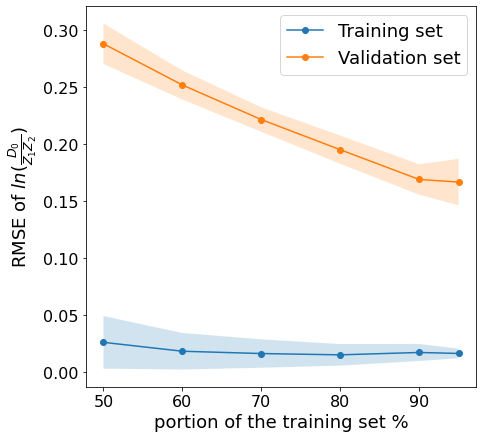

In [30]:
from matplotlib.transforms import Bbox
fig, ax =pyplot.subplots(figsize=(7,7))
ax.errorbar(np.array([0.5,0.6,0.7,0.8,0.9,0.95])*100, Train_rmse_means,fmt='-o',label='Training set')
ax.fill_between(np.array([0.5,0.6,0.7,0.8,0.9,0.95])*100, np.array(Train_rmse_means) - 0.5*np.array(Train_rmse_stds), np.array(Train_rmse_means) + 0.5*np.array(Train_rmse_stds),alpha=0.2)
ax.errorbar(np.array([0.5,0.6,0.7,0.8,0.9,0.95])*100, Valid_rmse_means,fmt='-o',label='Validation set')
ax.fill_between(np.array([0.5,0.6,0.7,0.8,0.9,0.95])*100, np.array(Valid_rmse_means) - 0.5*np.array(Valid_rmse_stds), np.array(Valid_rmse_means) + 0.5*np.array(Valid_rmse_stds),alpha=0.2)
#pyplot.xticks(ticks=np.linspace(1, 4, num=4))
#pyplot.yticks(ticks=np.linspace(0, 5, num=4))
ax.legend(prop={'size': 18})
pyplot.xlabel('portion of the training set %',fontdict={'size': 18})
pyplot.ylabel("RMSE of $ln(\\frac{D_0}{ Z_{1}Z_{2}})$",fontdict={'size': 18})
pyplot.xticks(fontsize=16)
pyplot.yticks(fontsize=16);
#pyplot.savefig('experiment1_2_learning_curve.svg',bbox_inches=Bbox([[-0.2,0],fig.get_size_inches()]))

In [ ]:
learning_curve = pd.DataFrame(list(zip([0.5,0.6,1-0.3,1-0.2,1-0.1,0.95],Train_rmse_means,Train_rmse_stds,Valid_rmse_means,Valid_rmse_stds)),columns =['portion of the data set','Train_rmse_means','Train_rmse_stds','valid_rmse_means','valid_rmse_stds'])
learning_curve.to_csv('learning_curves.csv') 
split_stat = pd.DataFrame(list(zip(Train_MAE,Train_RMSE,Train_R,MAE,RMSE)),columns =['Train_MAE','Train_RMSE','Train_R','MAE','RMSE'])
split_stat.to_csv('split_stat.csv')
gw_expand.drop('we_pred',axis=1,inplace=True)
gw_expand['-ln(De)_pred']=re_test_preds
gw_expand.to_csv('gw_expand_pred.csv')

In [ ]:
from matplotlib.transforms import Bbox
train_preds,train_std,test_preds,test_std,out,fig,ax=plot_results(gr_nodub,'True  $ln(\\frac{D_0}{R_e^{3}Z_{1}Z_{2}})$','Predicted  $ln(\\frac{D_0}{R_e^{3}Z_{1}Z_{2}})$','log(D_0/(Z_1*Z_2))',r_y_train_preds,r_train_stds,r_y_test_preds,r_test_stds)
pyplot.savefig('experiment1.svg',bbox_inches=Bbox([[-2,-2],fig.get_size_inches()]))

In [ ]:
train_preds,train_std,test_preds,test_std,out,fig,ax=plot_results(gr_expand_nodub,'True $R_e(\AA)$','Predicted $R_e(\AA)$',"ln(D0 (eV))",r_y_train_preds_1,r_train_stds_1,r_y_test_preds_1,r_test_stds_1)
for i in range(len(gr_expand_nodub)):
    if abs(gr_expand_nodub['Re (\AA)'].tolist()[i]-test_preds[i])<0.1:
        continue
    ax.annotate(gr_expand_nodub['Molecule'].tolist()[i], (gr_expand_nodub["ln(D0 (eV))"].tolist()[i], test_preds[i]))


## Homonuclear from Hetronuclears

In [24]:
features=['g1_lan_act','g2_lan_act','p1','p2','mu^(1/2)']
prior_features=['ln(Re (au))','g1_lan_act','g2_lan_act','p1','p2',"ln(omega_e (cm^{-1}))",'ln(mu^(1/2))']
logtarget="ln(D0 (eV))"
target="ln(D0 (eV))"
nu=3/2
normalize_y=True
gw_expand.loc[gw_expand.atom2=='D','atom2']=['H']*len(gw_expand.loc[gw_expand.atom2=='D']['atom2'])
gw_expand.loc[gw_expand.atom1=='D','atom1']=['H']*len(gw_expand.loc[gw_expand.atom1=='D']['atom1'])
gw_expand.loc[gw_expand.atom2=='T','atom2']=['H']*len(gw_expand.loc[gw_expand.atom2=='T']['atom2'])
gw_expand.loc[gw_expand.atom1=='T','atom1']=['H']*len(gw_expand.loc[gw_expand.atom1=='T']['atom1'])
re_train_set=gr_expand_nodub[gr_expand_nodub['atom1']!=gr_expand_nodub['atom2']]
re_test_set=gr_expand_nodub[gr_expand_nodub['atom1']==gr_expand_nodub['atom2']]
signal_variance=(re_train_set[logtarget].var())
length_scale=(re_train_set[features].std()).mean()

        
reg = LinearRegression().fit(re_train_set[prior_features], re_train_set[logtarget])

re_train_set['prior_mean']=reg.coef_[0]*re_train_set[prior_features[0]]+reg.coef_[1]*re_train_set[prior_features[1]]+reg.coef_[2]*re_train_set[prior_features[2]]+reg.coef_[3]*re_train_set[prior_features[3]]+reg.coef_[4]*re_train_set[prior_features[4]]+reg.coef_[5]*re_train_set[prior_features[5]]+reg.coef_[6]*re_train_set[prior_features[6]]+reg.intercept_
re_test_set['prior_mean']=reg.coef_[0]*re_test_set[prior_features[0]]+reg.coef_[1]*re_test_set[prior_features[1]]+reg.coef_[2]*re_test_set[prior_features[2]]+reg.coef_[3]*re_test_set[prior_features[3]]+reg.coef_[4]*re_test_set[prior_features[4]]+reg.coef_[5]*re_test_set[prior_features[5]]+reg.coef_[6]*re_test_set[prior_features[6]]+reg.intercept_

prior_mean='prior_mean'
signal_variance=(re_train_set[logtarget].var())
length_scale=(re_train_set[features].std()).mean()
#gpr = MyGPR(kernel=ConstantKernel(constant_value=trval[str(s)]['best $\sigma^2$'],constant_value_bounds='fixed')*Matern(length_scale=trval[str(s)]['best length scale'],length_scale_bounds='fixed' ,nu=nu)+WhiteKernel(noise_level=trval[str(s)]['best noise level'],noise_level_bounds='fixed'),n_restarts_optimizer=20,normalize_y=normalize_y,random_state=42)
gpr = MyGPR(kernel=ConstantKernel(constant_value=signal_variance)*Matern(length_scale=length_scale, nu=nu)+WhiteKernel(noise_level=re_train_set[target].std()/np.sqrt(2),noise_level_bounds=(10**-15,1)),n_restarts_optimizer=20,normalize_y=normalize_y,random_state=42)
#ConstantKernel(constant_value=signal_variance)*Matern(length_scale=length_scale, nu=nu)+WhiteKernel(noise_level=re_train_set[target].std()/np.sqrt(2),noise_level_bounds=(10**-15,1))
gpr.fit(re_train_set[features], re_train_set[logtarget]-re_train_set[prior_mean])
#gpr.log_marginal_likelihood(theta=None, eval_gradient=False, clone_kernel=False)

#trval[str(s)]['$\sigma^2$']=gpr.kernel_.get_params(deep=True)['k1__k1__constant_value']
#trval[str(s)]['length scale']=gpr.kernel_.get_params(deep=True)['k1__k2__length_scale']
#trval[str(s)]['noise level']=gpr.kernel_.get_params(deep=True)['k2__noise_level']

#re_test_set=re_test_set[~re_test_set['Molecule'].isin(['XeCl'])]

r_y_train_pred_log,r_std_train=gpr.predict(re_train_set[features], return_std=True)
r_y_test_pred_log,r_std_test=gpr.predict(re_test_set[features], return_std=True)

r_y_train_pred_log=r_y_train_pred_log+np.array(re_train_set[prior_mean])
r_y_test_pred_log=r_y_test_pred_log+np.array(re_test_set[prior_mean])

r_y_train_pred=r_y_train_pred_log
r_y_test_pred=r_y_test_pred_log
print(re_test_set[target],r_y_test_pred)

0     -1.499206
4     -1.510046
6     -1.515830
12    -1.524091
18    -2.278231
31    -1.826161
44    -1.632295
90    -1.105257
112   -0.019803
141   -1.616016
148   -1.474603
185   -0.908003
194   -1.166271
212   -1.376244
235   -0.044973
241   -0.682945
258   -0.708036
267   -0.984697
271   -0.433327
281   -0.832909
287   -0.712950
290    0.328504
301    0.665532
303    0.713350
304    2.993734
306    0.931404
309    4.555428
311    4.154095
312    3.772261
328   -1.510046
636    3.772261
Name: ln(D0 (eV)), dtype: float64 [-1.48900482 -1.50778725 -1.51641085 -1.51798189 -2.2042007  -1.75442909
 -1.5901516  -0.94051543 -0.85304374 -1.56417859 -1.38246993 -0.87539922
 -0.79676805 -1.36190619  0.06540081 -0.43508065 -1.03667181 -0.91626123
 -0.50592551 -1.43872162 -0.84745373  0.46180124  0.66477925  0.82268876
  3.4348063   0.75002741  4.20851267  4.12236561  3.74650796 -1.50778725
  3.74650796]


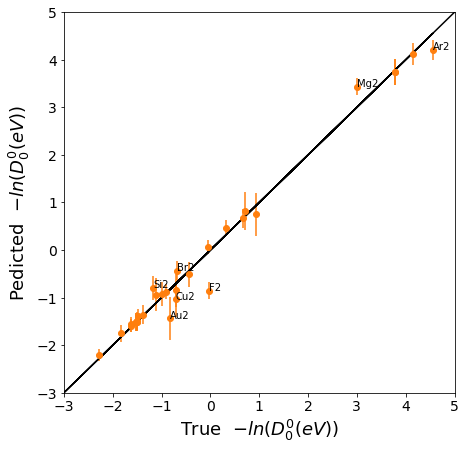

In [25]:
from matplotlib.transforms import Bbox
fig, ax =pyplot.subplots(figsize=(7,7))

ax.errorbar(-4, -3, fmt ='o',label='True values')
ax.errorbar(re_test_set[target], r_y_test_pred, yerr=r_std_test, fmt ='o',label='Homonuclear molecules in the test set')

line=re_test_set[target].tolist()
#line.append(0)
line.append(np.ceil(np.array( r_y_test_pred).min())-1)
line.append(np.ceil(np.array( r_y_test_pred).max()))
ax.plot(line,line,'-k')
#pyplot.xticks(fontdict={'size': 18})
#pyplot.yticks(fontdict={'size': 18})
#ax.plot([0, 1], [0, 1], transform=ax.transAxes)
pyplot.xlim(np.array(line).min(),np.ceil(np.array(line).max()))
pyplot.ylim(np.array(line).min(),np.ceil(np.array(line).max()))
#ax.legend(prop={'size': 18})
pyplot.xlabel('True  $-ln(D_0^0(eV))$',fontdict={'size': 18})
pyplot.ylabel('Pedicted  $-ln(D_0^0(eV))$',fontdict={'size': 18})
pyplot.xticks(fontsize=14)
pyplot.yticks(fontsize=14)
#for i in range(len(re_test_set)):
    #if abs(gr_expand_nodub['D_0/(Z_1*Z_2)'].tolist()[i]-test_preds[i])>0:
        #continue
#    ax.annotate(re_test_set['Molecule'].tolist()[i], (re_test_set['log(D_0/(Z_1*Z_2))'].tolist()[i], r_y_test_pred[i]))
pyplot.savefig('experiment1_homofromhetro.svg',bbox_inches=Bbox([[-0.2,0],fig.get_size_inches()]))
for i in range(len(re_test_set)):
    if abs(re_test_set["ln(D0 (eV))"].tolist()[i]-r_y_test_pred[i])<0.2:
        continue
    ax.annotate(re_test_set['Molecule'].tolist()[i], (re_test_set["ln(D0 (eV))"].tolist()[i], r_y_test_pred[i]))
pyplot.savefig('experiment1_homo_hetro_ann.svg',bbox_inches=Bbox([[-2,-2],fig.get_size_inches()]))    

In [27]:
(sum(abs(re_test_set["ln(D0 (eV))"].tolist()-r_y_test_pred))/len(r_y_test_pred))

0.14941695646160927

## Testing

In [32]:
g_test=pd.read_csv(r"C:\Users\mamr4\OneDrive - Stony Brook University\Master thesis\Data\g-test-2.csv",index_col=None)

In [33]:
g,gr,gw, g_old, g_new, gr_old, gw_old, gr_new, gw_new, g_expand, gr_expand, gw_expand, g_old_expand, g_new_expand, gr_old_expand, gw_old_expand, gr_new_expand, gw_new_expand=load(handel=r"C:\Users\mamr4\OneDrive - Stony Brook University\Master thesis\Data\g-test-2.csv",old_handel=r"C:\Users\mamr4\OneDrive\Documents\Master thesis\Data\list of molecules used in Xiangue and Jesus paper.xlsx")

In [34]:
gw_expand['ln(Re (\AA))']=np.log(gw_expand['Re (\AA)'])  #ln of the target
gw_expand['mu^(1/2)']=np.sqrt(gw_expand['Reduced mass'])
gw_expand['mu^(-1/2)']=1/np.sqrt(gw_expand['Reduced mass'])
gw_expand["ln(D0 (eV))"]=np.log(gw_expand["D0 (eV)"])
gw_expand=gw_expand[~gw_expand['Molecule'].isin(['AgBi','Hg2','XeCl','VF','HgCl','Ne2'])]
#gw_expand=gw_expand[~gw_expand['type1'].isin(['H'])]
#gw_expand=gw_expand[~gw_expand['type2'].isin(['H'])]
gw_expand=gw_expand[gw_expand["D0 (eV)"].isna()==False]
gr_expand_nodub=gw_expand
#.drop_duplicates(subset=['p1','p2','g1_lan_act','g2_lan_act'],ignore_index=True)
gr_expand_nodub["com"]=((gr_expand_nodub["omega_e (au)"]*gr_expand_nodub["Re (au)"]**2))
gr_expand_nodub["ln(com)"]=np.log((gr_expand_nodub["omega_e (au)"]*gr_expand_nodub["Re (au)"]**2))
#gr_expand_nodub=gw_expand
#gr_expand_nodub=gr_expand_nodub[gr_expand_nodub['log(D_e)/(R_e^3*Z_1*Z_2)'].isna()==False]
gr_expand_nodub['rcat']=gr_expand_nodub["ln(D0 (eV))"]

gr_expand_nodub_unique=np.unique(gr_expand_nodub['rcat'])
gr_expand_nodub['Re (au)^-3']=gr_expand_nodub['Re (au)']**-3  
ind=[0,10,20,30,40,50,60,70,80,89,95,100,110,120,130,140,149,159,167,177,187,196,206]
#ind=[0,35,75,125,170,215,267]
for i in range(len(ind)-1):
    
    gr_expand_nodub['rcat'].where((gr_expand_nodub['rcat']>gr_expand_nodub_unique[ind[i+1]])|(gr_expand_nodub['rcat']<=gr_expand_nodub_unique[ind[i]]),gr_expand_nodub_unique[ind[i]],inplace=True)
np.unique((gr_expand_nodub['rcat']),return_counts=True)  
#len(gr_expand_nodub_unique)

(array([-5.08320599, -1.11937443, -0.17284976,  0.58778666,  0.7100043 ,
         0.87546874,  0.98469676,  1.09861229,  1.16627094,  1.20896035,
         1.24415459,  1.26412673,  1.34025042,  1.44456327,  1.4861397 ,
         1.521699  ,  1.58923521,  1.65822808,  1.71739505,  1.78641186,
         1.85002838,  1.97269117,  2.19722458,  2.27823092,  2.4078456 ]),
 array([19, 16, 19, 20, 18, 22, 26, 26, 24, 26, 18, 26, 21, 23, 20, 19, 18,
        18, 26, 23, 18, 20,  2,  1,  2], dtype=int64))

In [35]:
gw_old_expand['mu^(1/2)']=(np.sqrt(gw_old_expand['Reduced mass']))
gw_old_expand['ln(mu^(1/2))']=np.log(np.sqrt(gw_old_expand['Reduced mass']))
gw_old_expand["ln(omega_e (cm^{-1}))"]=np.log(gw_old_expand["omega_e (cm^{-1})"])

In [36]:
gw_expand['mu^(1/2)']=(np.sqrt(gw_expand['Reduced mass']))
gw_expand['ln(mu^(1/2))']=np.log(np.sqrt(gw_expand['Reduced mass']))
gw_expand["ln(omega_e (cm^{-1}))"]=np.log(gw_expand["omega_e (cm^{-1})"])
gw_expand["zero"]=np.log(gw_expand["omega_e (cm^{-1})"])*0

In [37]:

#gr_expand_nodub['1/omega_e (au)'].hist(bins=25)
#gr_expand_nodub["(e1*e2)"]=(gr_expand_nodub["e1"]+gr_expand_nodub["e2"])
#gr_expand_nodub['1/ln(omega_e (au))']=(1/gr_expand_nodub["ln(omega_e (au))"])
#gr_expand_nodub['mu^(1/2)']*(gr_expand_nodub["ln(omega_e (au))"])
#gr_expand_nodub['1/omega_e (au)']=(1/gr_expand_nodub["omega_e (au)"])
gr_expand_nodub['1/D0 (eV)']=(1/gr_expand_nodub["D0 (eV)"])
(gr_expand_nodub["ln(K)"])=np.log(gr_expand_nodub["K"])
gw_expand['ln(mu^(1/2))']=np.log(gw_expand['mu^(1/2)'])
gw_expand['ln(Re (au))']=np.log(gw_expand['Re (au)'])

In [38]:
trval,train,test,mean_std,Train_MAE,Train_RMSE,Train_R,Train_RMSLE,MAE,RMSE,R,RMSLE,r_y_train_preds,r_train_stds,r_y_test_preds,r_test_stds=ml_model(data=gr_expand_nodub,strata=gr_expand_nodub['rcat'],test_size=22,features=['g1_lan_act','g2_lan_act','p1','p2','mu^(1/2)'],prior_features=["ln(K)",'ln(Re (au))','g1_lan_act','g2_lan_act','p1','p2'],logtarget="ln(D0 (eV))",target="ln(D0 (eV))",nu=3/2,normalize_y=True,n_splits=100)

size of training set before removing mirror molecules 470
size of training set after removing mirror molecules 470
size of training set before removing mirror molecules 470
size of training set after removing mirror molecules 469
size of training set before removing mirror molecules 470
size of training set after removing mirror molecules 469
size of training set before removing mirror molecules 470
size of training set after removing mirror molecules 469
size of training set before removing mirror molecules 470
size of training set after removing mirror molecules 469
size of training set before removing mirror molecules 470
size of training set after removing mirror molecules 470
size of training set before removing mirror molecules 470
size of training set after removing mirror molecules 469
size of training set before removing mirror molecules 470
size of training set after removing mirror molecules 469
size of training set before removing mirror molecules 470
size of training set a

In [39]:
test_molecules=gw_expand[gw_expand['Molecule'].isin(['InBr','MoC','NbC','NiC','NiO','NiS','PbI','PdC','RuC','SnI','UO','WC','YC','ZnBr','ZnCl','WO','ZnI','ZnF','HgBr','HgI','HCl','DCl'])].drop_duplicates(subset='Molecule')['Molecule'].tolist()
true_values=gw_expand[gw_expand['Molecule'].isin(['InBr','MoC','NbC','NiC','NiO','NiS','PbI','PdC','RuC','SnI','UO','WC','YC','ZnBr','ZnCl','WO','ZnI','ZnF','HgBr','HgI','HCl','DCl'])].drop_duplicates(subset='Molecule')["ln(D0 (eV))"].tolist()
#re_train_std=[]
re_test_preds=[]
re_test_std=[]
out=[]
#for x, y in thisdict.items():
#  print(x, y)
for index in r_y_test_preds:
        if index >= 230:
            continue
        #test_molecules.append(gw_expand.loc[index,'Molecule'])
        #true_values.append(gw_expand.loc[index,'omega_e (cm^{-1})'])
        re_test_preds.append(((r_y_test_preds[index][0])))
        re_test_std.append(((r_test_stds[index][0])))
        print(index)
re_test_preds
re_test_std
true_values

67
77
83
122
200
213
221


[1.8468787684491346,
 1.6114359150967734,
 1.766441661243765,
 1.4562867329399256,
 0.8977193462887197,
 1.3837912309017721,
 1.0605538331649917]

In [40]:
testing_results = pd.DataFrame(list(zip(test_molecules, true_values,re_test_preds,re_test_std)),
               columns =['Molecule', 'true ln(D0 (eV))','Predicted ln(D0 (eV))','error bars'])
#testing_results['Molecule']=gw_expand[gw_expand['Molecule'].isin(['InBr','MoC','NbC','NiC','NiO','NiS','PbI','PdC','RuC','SnI','UO','WC','YC','ZnBr'])].drop_duplicates(subset='Molecule')['Molecule']
testing_results

,Molecule,true ln(D0 (eV)),Predicted ln(D0 (eV)),error bars
0,RuC,1.846879,1.785182,0.210247
1,MoC,1.611436,1.743151,0.214752
2,NbC,1.766442,1.668339,0.215699
3,YC,1.456287,1.415851,0.311257
4,ZnBr,0.897719,1.337818,0.163895
5,InBr,1.383791,1.384861,0.180432
6,SnI,1.060554,1.182342,0.210934


In [92]:
np.sum(abs(testing_results['true ln(D0 (eV))']-testing_results['Predicted ln(D0 (eV))']))/len(testing_results['true ln(D0 (eV))'])

0.1278438605710696

In [41]:
sqrt(mean_squared_error(testing_results['true ln(D0 (eV))'],testing_results['Predicted ln(D0 (eV))']))

0.1855244188550319

In [51]:
testing_results['true D0 (eV)']=np.exp(testing_results['true ln(D0 (eV))'])

In [53]:
testing_results['predicted D0 (eV)']=np.exp(testing_results['Predicted ln(D0 (eV))'])*(1+0.5*testing_results['error bars']**2)

In [54]:
testing_results['error bars (eV)']=testing_results['predicted D0 (eV)']*testing_results['error bars']

In [57]:
testing_results[['Molecule','true D0 (eV)','predicted D0 (eV)','error bars (eV)']]

,Molecule,true D0 (eV),predicted D0 (eV),error bars (eV)
0,RuC,6.34000,6.092409,1.280913
1,MoC,5.01000,5.847113,1.255677
2,NbC,5.85000,5.426724,1.170541
3,YC,4.29000,4.319565,1.344495
4,ZnBr,2.45400,3.861902,0.632946
5,InBr,3.99000,4.059289,0.732425
6,SnI,2.88797,3.334573,0.703373


In [58]:
np.exp(testing_results['Predicted ln(D0 (eV))'])

0    5.960666
1    5.715323
2    5.303351
3    4.119991
4    3.810721
5    3.994271
6    3.262005
Name: Predicted ln(D0 (eV)), dtype: float64